In [1]:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import argparse
from copy import deepcopy
import torch
import gym
import time
import torch
import torch.nn as nn	# 各种层类型的实现
import torch.nn.functional as F	# 各中层函数的实现，与层类型对应，如：卷积函数、池化函数、归一化函数等等
import torch.optim as optim	# 实现各种优化算法的包
import numpy as np

import argparse
import sys


import numpy as np
from numpy.random import permutation
import matplotlib.pyplot as plt
from grid_data import GridData

from compute_mpe import CircuitMPE
import sys
sys.path.insert(0,'/root/gurobi903/linux64/lib/python3.6_utf32/gurobipy')
import gurobipy
cmpe = CircuitMPE('/root/PySDD/notebooks/yahoo.vtree', '/root/PySDD/notebooks/yahoo.sdd')
class para:
    def __init__(self):
        self.batch_size=16
        self.wmc=10
        self.solDim=24
        self.card=10
        self.test_batch_size=1000
        self.epochs=10
        self.lr=0.1
        self.momentum=0.5
        self.no_cuda='store_true'
        self.seed=1
        self.log_interval=10
        self.hidden_dim=10
args=para()
legalList={0: [13, 18],
 1: [17, 20, 22],
 2: [4, 5, 10, 13, 14, 16, 17, 18, 20, 22],
 3: [5, 9, 11, 12, 15],
 4: [2, 10, 13, 14, 16, 17, 18, 20, 22],
 5: [2, 3, 6, 9, 10, 11, 12, 14, 16],
 6: [5, 15],
 7: [],
 8: [],
 9: [3, 5, 11, 12, 15],
 10: [2, 4, 5, 14, 16, 22],
 11: [3, 5, 9, 12, 15],
 12: [3, 5, 9, 11, 15],
 13: [0, 2, 4, 14, 18, 22],
 14: [2, 4, 5, 10, 13, 16, 17, 18, 20, 22],
 15: [3, 6, 9, 11, 12, 17, 19, 20],
 16: [2, 4, 5, 10, 14, 22],
 17: [1, 2, 4, 14, 15, 19, 20, 22],
 18: [0, 2, 4, 13, 14, 22],
 19: [15, 17, 20],
 20: [1, 2, 4, 14, 15, 17, 19, 22],
 21: [],
 22: [1, 2, 4, 10, 13, 14, 16, 17, 18, 20],
 23: []}
def checkFea(x):
    cnt=0
    cntT=0
    for i in range(len(legalList.keys())):
        for j in legalList[i]:
            cntT+=1
            if x[j]+x[i]>1:
                cnt+=1
    return cnt/cntT/2+abs(sum(x)-args.card)/args.card/2
def checkFea2(x):
    cnt=0
    cntT=0
    for i in range(len(legalList.keys())):
        for j in legalList[i]:
            cntT+=1
            if x[j]+x[i]>1:
                cnt+=1
    return cnt/cntT
def CB(alpha,x,M):
    return alpha*np.sqrt(np.dot(np.dot(x.T,np.linalg.inv(M)),x))
def solver(theta,MODEL):

    import gurobipy
    import time
    s=time.time()
    # 创建模型
    variables=[]
    for i in range(args.solDim):
        variables.append(MODEL.addVar(vtype=gurobipy.GRB.BINARY, name='x'+'i'))
    # 更新变量环境
    MODEL.update()

    # 创建目标函数
    MODEL.setObjective(np.array(variables).dot(theta), sense=gurobipy.GRB.MAXIMIZE)

    # 创建约束条件
    cnt=0
    for i in range(args.solDim):
        if len(legalList)>0:
            for j in legalList[i]:
                MODEL.addConstr(-variables[i]-variables[j] >= -1, name=str(cnt))
                cnt+=1
    MODEL.addConstr(sum(variables) == args.card, name=str(cnt))
    f=time.time()
    # 执行最优化
    MODEL.optimize()
    return np.array(MODEL.x)
def solver_quad(Q,MODEL):

    import gurobipy
    import time
    s=time.time()
    # 创建模型
    variables=[]
    for i in range(args.solDim):
        variables.append(MODEL.addVar(vtype=gurobipy.GRB.BINARY, name='x'+'i'))
    # 更新变量环境
    MODEL.update()

    # 创建目标函数
    MODEL.setObjective(np.array(variables).dot(Q).dot(np.array(variables)), sense=gurobipy.GRB.MAXIMIZE)

    # 创建约束条件
    cnt=0
    for i in range(args.solDim):
        if len(legalList)>0:
            for j in legalList[i]:
                MODEL.addConstr(-variables[i]-variables[j] >= -1, name=str(cnt))
                cnt+=1
    MODEL.addConstr(sum(variables) == args.card, name=str(cnt))
    f=time.time()
    # 执行最优化
    
    MODEL.optimize()
    return np.array(MODEL.x)
def solver_mixed(Q,a,MODEL):
    import gurobipy
    import time
    s=time.time()
    # 创建模型
    variables=[]
    for i in range(args.solDim):
        variables.append(MODEL.addVar(vtype=gurobipy.GRB.BINARY, name='x'+'i'))
    # 更新变量环境
    MODEL.update()

    # 创建目标函数
    MODEL.setObjective(np.array(variables).dot(Q).dot(np.array(variables))+(np.array(variables).dot(a))*(np.array(variables).dot(a)), sense=gurobipy.GRB.MAXIMIZE)

    # 创建约束条件
    cnt=0
    for i in range(args.solDim):
        if len(legalList)>0:
            for j in legalList[i]:
                MODEL.addConstr(-variables[i]-variables[j] >= -1, name=str(cnt))
                cnt+=1
    MODEL.addConstr(sum(variables) == args.card, name=str(cnt))
    f=time.time()
    # 执行最优化
    
    MODEL.optimize()
    return np.array(MODEL.x)

In [2]:
Q= np.load('Q24.npy')
rewards=[]
constraints=[]
import gym

# https://github.com/openai/gym/blob/master/gym/core.py
class Normalizedenv2(gym.ActionWrapper):
    """ Wrap action """

    def action(self, action):
        act_k = (self.action_space.high - self.action_space.low)/ 2.
        act_b = (self.action_space.high + self.action_space.low)/ 2.
        return act_k * action + act_b

    def reverse_action(self, action):
        act_k_inv = 2./(self.action_space.high - self.action_space.low)
        act_b = (self.action_space.high + self.action_space.low)/ 2.
        return act_k_inv * (action - act_b)
import os
import torch
from torch.autograd import Variable

USE_CUDA = torch.cuda.is_available()
FLOAT = torch.cuda.FloatTensor if USE_CUDA else torch.FloatTensor


def to_numpy(var):
    return var.cpu().data.numpy() if USE_CUDA else var.data.numpy()

def to_tensor(ndarray, volatile=False, requires_grad=False, dtype=FLOAT):
    return Variable(
        torch.from_numpy(ndarray), volatile=volatile, requires_grad=requires_grad
    ).type(dtype)

def soft_update(target, source, tau):
    for target_param, param in zip(target.parameters(), source.parameters()):
        target_param.data.copy_(
            target_param.data * (1.0 - tau) + param.data * tau
        )

def hard_update(target, source):
    for target_param, param in zip(target.parameters(), source.parameters()):
            target_param.data.copy_(param.data)

def get_output_folder(parent_dir, env2_name):
    """Return save folder.
    Assumes folders in the parent_dir have suffix -run{run
    number}. Finds the highest run number and sets the output folder
    to that number + 1. This is just convenient so that if you run the
    same script multiple times tensorboard can plot all of the results
    on the same plots with different names.
    Parameters
    ----------
    parent_dir: str
      Path of the directory containing all experiment runs.
    Returns
    -------
    parent_dir/run_dir
      Path to this run's save directory.
    """
    os.makedirs(parent_dir, exist_ok=True)
    experiment_id = 0
    for folder_name in os.listdir(parent_dir):
        if not os.path.isdir(os.path.join(parent_dir, folder_name)):
            continue
        try:
            folder_name = int(folder_name.split('-run')[-1])
            if folder_name > experiment_id:
                experiment_id = folder_name
        except:
            pass
    experiment_id += 1

    parent_dir = os.path.join(parent_dir, env2_name)
    parent_dir = parent_dir + '-run{}'.format(experiment_id)
    os.makedirs(parent_dir, exist_ok=True)
    return parent_dir
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import savemat
class Evaluator(object):

    def __init__(self, num_episodes, interval, save_path='', max_episode_length=None):
        self.num_episodes = num_episodes
        self.max_episode_length = max_episode_length
        self.interval = interval
        self.save_path = save_path
        self.results = np.array([]).reshape(num_episodes,0)

    def __call__(self, env2, policy,m, debug=False, visualize=False, save=True):

        self.is_training = False
        observation = None
        result = []

        for episode in range(self.num_episodes):

            # reset at the start of episode
            observation = env2.reset()
            episode_steps = 0
            episode_reward = 0.

            assert observation is not None

            # start episode
            done = False
            while not done:
                # basic operation, action ,reward, blablabla ...
                action = policy(observation)
                m.eval()
                observation, reward, done, info = env2.step(action,m)
                if self.max_episode_length and episode_steps >= self.max_episode_length -1:
                    done = True

                # update
                episode_reward += reward
                episode_steps += 1

            result.append(episode_reward)

        result = np.array(result).reshape(-1,1)
        self.results = np.hstack([self.results, result])

        if save:
            self.save_results('{}/validate_reward'.format(self.save_path))
        return np.mean(result)

    def save_results(self, fn):

        y = np.mean(self.results, axis=0)
        error=np.std(self.results, axis=0)

        x = range(0,self.results.shape[1]*self.interval,self.interval)
        fig, ax = plt.subplots(1, 1, figsize=(6, 5))
        plt.xlabel('Timestep')
        plt.ylabel('Average Reward')
        ax.errorbar(x, y, yerr=error, fmt='-o')
        plt.savefig(fn+'.png')
        savemat(fn+'.mat', {'reward':self.results})
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

#from ipdb import set_trace as debug

def fanin_init(size, fanin=None):
    fanin = fanin or size[0]
    v = 1. / np.sqrt(fanin)
    return torch.Tensor(size).uniform_(-v, v)

class Actor(nn.Module):
    def __init__(self, nb_states, nb_actions, hidden1=400, hidden2=300, init_w=3e-3):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(nb_states, hidden1)
        self.fc2 = nn.Linear(hidden1, hidden2)
        self.fc3 = nn.Linear(hidden2, nb_actions)
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        self.init_weights(init_w)
        self.sigmoid=nn.Sigmoid()
    def init_weights(self, init_w):
        self.fc1.weight.data = fanin_init(self.fc1.weight.data.size())
        self.fc2.weight.data = fanin_init(self.fc2.weight.data.size())
        self.fc3.weight.data.uniform_(-init_w, init_w)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)
        out = self.tanh(out)
        out=self.sigmoid(out)
        return out

class Critic(nn.Module):
    def __init__(self, nb_states, nb_actions, hidden1=400, hidden2=300, init_w=3e-3):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(nb_states, hidden1)
        self.fc2 = nn.Linear(hidden1 +nb_actions, hidden2)
        self.fc3 = nn.Linear(hidden2, 1)
        self.relu = nn.ReLU()
        self.init_weights(init_w)

    def init_weights(self, init_w):
        self.fc1.weight.data = fanin_init(self.fc1.weight.data.size())
        self.fc2.weight.data = fanin_init(self.fc2.weight.data.size())
        self.fc3.weight.data.uniform_(-init_w, init_w)

    def forward(self, xs):
        x, a = xs
        out = self.fc1(x)
        out = self.relu(out)
        # debug()
        if len(a.shape)==1:
            a=a.view([1,a.shape[0]])
        out = self.fc2(torch.cat([out,a],1))
        out = self.relu(out)
        out = self.fc3(out)
        return out

from collections import deque, namedtuple
import warnings
import random

import numpy as np

# [reference] https://github.com/matthiasplappert/keras-rl/blob/master/rl/memory.py

# This is to be understood as a transition: Given `state0`, performing `action`
# yields `reward` and results in `state1`, which might be `terminal`.
Experience = namedtuple('Experience', 'state0, action, reward, state1, terminal1')


def sample_batch_indexes(low, high, size):
    if high - low >= size:
        # We have enough data. Draw without replacement, that is each index is unique in the
        # batch. We cannot use `np.random.choice` here because it is horribly inefficient as
        # the memory grows. See https://github.com/numpy/numpy/issues/2764 for a discussion.
        # `random.sample` does the same thing (drawing without replacement) and is way faster.
        try:
            r = xrange(low, high)
        except NameError:
            r = range(low, high)
        batch_idxs = random.sample(r, size)
    else:
        # Not enough data. Help ourselves with sampling from the range, but the same index
        # can occur multiple times. This is not good and should be avoided by picking a
        # large enough warm-up phase.
        warnings.warn('Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!')
        batch_idxs = np.random.random_integers(low, high - 1, size=size)
    assert len(batch_idxs) == size
    return batch_idxs


class RingBuffer(object):
    def __init__(self, maxlen):
        self.maxlen = maxlen
        self.start = 0
        self.length = 0
        self.data = [None for _ in range(maxlen)]

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        if idx < 0 or idx >= self.length:
            raise KeyError()
        return self.data[(self.start + idx) % self.maxlen]

    def append(self, v):
        if self.length < self.maxlen:
            # We have space, simply increase the length.
            self.length += 1
        elif self.length == self.maxlen:
            # No space, "remove" the first item.
            self.start = (self.start + 1) % self.maxlen
        else:
            # This should never happen.
            raise RuntimeError()
        self.data[(self.start + self.length - 1) % self.maxlen] = v


def zeroed_observation(observation):
    if hasattr(observation, 'shape'):
        return np.zeros(observation.shape)
    elif hasattr(observation, '__iter__'):
        out = []
        for x in observation:
            out.append(zeroed_observation(x))
        return out
    else:
        return 0.


class Memory(object):
    def __init__(self, window_length, ignore_episode_boundaries=False):
        self.window_length = window_length
        self.ignore_episode_boundaries = ignore_episode_boundaries

        self.recent_observations = deque(maxlen=window_length)
        self.recent_terminals = deque(maxlen=window_length)

    def sample(self, batch_size, batch_idxs=None):
        raise NotImplementedError()

    def append(self, observation, action, reward, terminal, training=True):
        self.recent_observations.append(observation)
        self.recent_terminals.append(terminal)

    def get_recent_state(self, current_observation):
        # This code is slightly complicated by the fact that subsequent observations might be
        # from different episodes. We ensure that an experience never spans multiple episodes.
        # This is probably not that important in practice but it seems cleaner.
        state = [current_observation]
        idx = len(self.recent_observations) - 1
        for offset in range(0, self.window_length - 1):
            current_idx = idx - offset
            current_terminal = self.recent_terminals[current_idx - 1] if current_idx - 1 >= 0 else False
            if current_idx < 0 or (not self.ignore_episode_boundaries and current_terminal):
                # The previously handled observation was terminal, don't add the current one.
                # Otherwise we would leak into a different episode.
                break
            state.insert(0, self.recent_observations[current_idx])
        while len(state) < self.window_length:
            state.insert(0, zeroed_observation(state[0]))
        return state

    def get_config(self):
        config = {
            'window_length': self.window_length,
            'ignore_episode_boundaries': self.ignore_episode_boundaries,
        }
        return config

class SequentialMemory(Memory):
    def __init__(self, limit, **kwargs):
        super(SequentialMemory, self).__init__(**kwargs)

        self.limit = limit

        # Do not use deque to implement the memory. This data structure may seem convenient but
        # it is way too slow on random access. Instead, we use our own ring buffer implementation.
        self.actions = RingBuffer(limit)
        self.rewards = RingBuffer(limit)
        self.terminals = RingBuffer(limit)
        self.observations = RingBuffer(limit)

    def sample(self, batch_size, batch_idxs=None):
        if batch_idxs is None:
            # Draw random indexes such that we have at least a single entry before each
            # index.
            batch_idxs = sample_batch_indexes(0, self.nb_entries - 1, size=batch_size)
        batch_idxs = np.array(batch_idxs) + 1
        assert np.min(batch_idxs) >= 1
        assert np.max(batch_idxs) < self.nb_entries
        assert len(batch_idxs) == batch_size

        # Create experiences
        experiences = []
        for idx in batch_idxs:
            terminal0 = self.terminals[idx - 2] if idx >= 2 else False
            while terminal0:
                # Skip this transition because the env2ironment was reset here. Select a new, random
                # transition and use this instead. This may cause the batch to contain the same
                # transition twice.
                idx = sample_batch_indexes(1, self.nb_entries, size=1)[0]
                terminal0 = self.terminals[idx - 2] if idx >= 2 else False
            assert 1 <= idx < self.nb_entries

            # This code is slightly complicated by the fact that subsequent observations might be
            # from different episodes. We ensure that an experience never spans multiple episodes.
            # This is probably not that important in practice but it seems cleaner.
            state0 = [self.observations[idx - 1]]
            for offset in range(0, self.window_length - 1):
                current_idx = idx - 2 - offset
                current_terminal = self.terminals[current_idx - 1] if current_idx - 1 > 0 else False
                if current_idx < 0 or (not self.ignore_episode_boundaries and current_terminal):
                    # The previously handled observation was terminal, don't add the current one.
                    # Otherwise we would leak into a different episode.
                    break
                state0.insert(0, self.observations[current_idx])
            while len(state0) < self.window_length:
                state0.insert(0, zeroed_observation(state0[0]))
            action = self.actions[idx - 1]
            reward = self.rewards[idx - 1]
            terminal1 = self.terminals[idx - 1]

            # Okay, now we need to create the follow-up state. This is state0 shifted on timestep
            # to the right. Again, we need to be careful to not include an observation from the next
            # episode if the last state is terminal.
            state1 = [np.copy(x) for x in state0[1:]]
            state1.append(self.observations[idx])

            assert len(state0) == self.window_length
            assert len(state1) == len(state0)
            experiences.append(Experience(state0=state0, action=action, reward=reward,
                                          state1=state1, terminal1=terminal1))
        assert len(experiences) == batch_size
        return experiences

    def sample_and_split(self, batch_size, batch_idxs=None):
        experiences = self.sample(batch_size, batch_idxs)

        state0_batch = []
        reward_batch = []
        action_batch = []
        terminal1_batch = []
        state1_batch = []
        for e in experiences:
            state0_batch.append(e.state0)
            state1_batch.append(e.state1)
            reward_batch.append(e.reward)
            action_batch.append(e.action)
            terminal1_batch.append(0. if e.terminal1 else 1.)

        # Prepare and validate parameters.
        state0_batch = np.array(state0_batch).reshape(batch_size,-1)
        state1_batch = np.array(state1_batch).reshape(batch_size,-1)
        terminal1_batch = np.array(terminal1_batch).reshape(batch_size,-1)
        reward_batch = np.array(reward_batch).reshape(batch_size,-1)
        action_batch = np.array(action_batch).reshape(batch_size,-1)

        return state0_batch, action_batch, reward_batch, state1_batch, terminal1_batch


    def append(self, observation, action, reward, terminal, training=True):
        super(SequentialMemory, self).append(observation, action, reward, terminal, training=training)

        # This needs to be understood as follows: in `observation`, take `action`, obtain `reward`
        # and weather the next state is `terminal` or not.
        if training:
            self.observations.append(observation)
            self.actions.append(action)
            self.rewards.append(reward)
            self.terminals.append(terminal)

    @property
    def nb_entries(self):
        return len(self.observations)

    def get_config(self):
        config = super(SequentialMemory, self).get_config()
        config['limit'] = self.limit
        return config


class EpisodeParameterMemory(Memory):
    def __init__(self, limit, **kwargs):
        super(EpisodeParameterMemory, self).__init__(**kwargs)
        self.limit = limit

        self.params = RingBuffer(limit)
        self.intermediate_rewards = []
        self.total_rewards = RingBuffer(limit)

    def sample(self, batch_size, batch_idxs=None):
        if batch_idxs is None:
            batch_idxs = sample_batch_indexes(0, self.nb_entries, size=batch_size)
        assert len(batch_idxs) == batch_size

        batch_params = []
        batch_total_rewards = []
        for idx in batch_idxs:
            batch_params.append(self.params[idx])
            batch_total_rewards.append(self.total_rewards[idx])
        return batch_params, batch_total_rewards

    def append(self, observation, action, reward, terminal, training=True):
        super(EpisodeParameterMemory, self).append(observation, action, reward, terminal, training=training)
        if training:
            self.intermediate_rewards.append(reward)

    def finalize_episode(self, params):
        total_reward = sum(self.intermediate_rewards)
        self.total_rewards.append(total_reward)
        self.params.append(params)
        self.intermediate_rewards = []

    @property
    def nb_entries(self):
        return len(self.total_rewards)

    def get_config(self):
        config = super(SequentialMemory, self).get_config()
        config['limit'] = self.limit
        return config
import numpy as np 

# [reference] https://github.com/matthiasplappert/keras-rl/blob/master/rl/random.py

class RandomProcess(object):
    def reset_states(self):
        pass

class AnnealedGaussianProcess(RandomProcess):
    def __init__(self, mu, sigma, sigma_min, n_steps_annealing):
        self.mu = mu
        self.sigma = sigma
        self.n_steps = 0

        if sigma_min is not None:
            self.m = -float(sigma - sigma_min) / float(n_steps_annealing)
            self.c = sigma
            self.sigma_min = sigma_min
        else:
            self.m = 0.
            self.c = sigma
            self.sigma_min = sigma

    @property
    def current_sigma(self):
        sigma = max(self.sigma_min, self.m * float(self.n_steps) + self.c)
        return sigma


# Based on http://math.stackexchange.com/questions/1287634/implementing-ornstein-uhlenbeck-in-matlab
class OrnsteinUhlenbeckProcess(AnnealedGaussianProcess):
    def __init__(self, theta, mu=0., sigma=1., dt=1e-2, x0=None, size=1, sigma_min=None, n_steps_annealing=1000):
        super(OrnsteinUhlenbeckProcess, self).__init__(mu=mu, sigma=sigma, sigma_min=sigma_min, n_steps_annealing=n_steps_annealing)
        self.theta = theta
        self.mu = mu
        self.dt = dt
        self.x0 = x0
        self.size = size
        self.reset_states()

    def sample(self):
        x = self.x_prev + self.theta * (self.mu - self.x_prev) * self.dt + self.current_sigma * np.sqrt(self.dt) * np.random.normal(size=self.size)
        self.x_prev = x
        self.n_steps += 1
        return x

    def reset_states(self):
        self.x_prev = self.x0 if self.x0 is not None else np.zeros(self.size)
# from ipdb import set_trace as debug

criterion = nn.MSELoss()

class DDPG(object):
    def __init__(self, nb_states, nb_actions, args2):

        if args2.seed > 0:
            self.seed(args2.seed)

        self.nb_states = nb_states
        self.nb_actions= nb_actions

        # Create Actor and Critic Network
        net_cfg = {
            'hidden1':args2.hidden1, 
            'hidden2':args2.hidden2, 
            'init_w':args2.init_w
        }
        self.actor = Actor(self.nb_states, self.nb_actions, **net_cfg)
        self.actor_target = Actor(self.nb_states, self.nb_actions, **net_cfg)
        self.actor_optim  = Adam(self.actor.parameters(), lr=args2.prate)

        self.critic = Critic(self.nb_states, self.nb_actions, **net_cfg)
        self.critic_target = Critic(self.nb_states, self.nb_actions, **net_cfg)
        self.critic_optim  = Adam(self.critic.parameters(), lr=args2.rate)

        hard_update(self.actor_target, self.actor) # Make sure target is with the same weight
        hard_update(self.critic_target, self.critic)

        #Create replay buffer
        self.memory = SequentialMemory(limit=args2.rmsize, window_length=args2.window_length)
        self.random_process = OrnsteinUhlenbeckProcess(size=nb_actions, theta=args2.ou_theta, mu=args2.ou_mu, sigma=args2.ou_sigma)

        # Hyper-parameters
        self.batch_size = args2.bsize
        self.tau = args2.tau
        self.discount = args2.discount
        self.depsilon = 1.0 / args2.epsilon

        # 
        self.epsilon = 1.0
        self.s_t = None # Most recent state
        self.a_t = None # Most recent action
        self.is_training = True

        # 
        if USE_CUDA: self.cuda()

    def update_policy(self):
        # Sample batch
        state_batch, action_batch, reward_batch, \
        next_state_batch, terminal_batch = self.memory.sample_and_split(self.batch_size)

        # Prepare for the target q batch
        next_q_values = self.critic_target([
            to_tensor(next_state_batch, volatile=True),
            self.actor_target(to_tensor(next_state_batch, volatile=True)),
        ])
        next_q_values.volatile=False

        target_q_batch = to_tensor(reward_batch) + \
            self.discount*to_tensor(terminal_batch.astype(np.float))*next_q_values

        # Critic update
        self.critic.zero_grad()

        q_batch = self.critic([ to_tensor(state_batch), to_tensor(action_batch) ])

        value_loss = criterion(q_batch, target_q_batch)
        value_loss.backward()
        self.critic_optim.step()

        # Actor update
        self.actor.zero_grad()

        policy_loss = -self.critic([
            to_tensor(state_batch),
            self.actor(to_tensor(state_batch))
        ])

        policy_loss = policy_loss.mean()
        policy_loss.backward()
        self.actor_optim.step()

        # Target update
        soft_update(self.actor_target, self.actor, self.tau)
        soft_update(self.critic_target, self.critic, self.tau)

    def eval(self):
        self.actor.eval()
        self.actor_target.eval()
        self.critic.eval()
        self.critic_target.eval()

    def cuda(self):
        self.actor.cuda()
        self.actor_target.cuda()
        self.critic.cuda()
        self.critic_target.cuda()

    def observe(self, r_t, s_t1, done):
        if self.is_training:
            self.memory.append(self.s_t, self.a_t, r_t, done)
            self.s_t = s_t1

    def random_action(self):
        action = np.random.uniform(0.,1.,self.nb_actions)
        self.a_t = action
        return action

    def select_action(self, s_t, decay_epsilon=True):
        action = to_numpy(
            self.actor(to_tensor(np.array([s_t])))
        ).squeeze(0)
        #action += self.is_training*max(self.epsilon, 0)*self.random_process.sample()
        action = np.clip(action, 0., 1.)

        if decay_epsilon:
            self.epsilon -= self.depsilon

        self.a_t = action

        return action

    def reset(self, obs):
        self.s_t = obs
        self.random_process.reset_states()

    def load_weights(self, output):
        if output is None: return

        self.actor.load_state_dict(
            torch.load('{}/actor.pkl'.format(output))
        )

        self.critic.load_state_dict(
            torch.load('{}/critic.pkl'.format(output))
        )


    def save_model(self,output):
        torch.save(
            self.actor.state_dict(),
            '{}/actor.pkl'.format(output)
        )
        torch.save(
            self.critic.state_dict(),
            '{}/critic.pkl'.format(output)
        )

    def seed(self,s):
        torch.manual_seed(s)
        if USE_CUDA:
            torch.cuda.manual_seed(s)
import pyflann
from gym.spaces import Box
import numpy as np
import itertools

class Space:

    def __init__(self, low, high, points):

        self._low = np.array(low)
        self._high = np.array(high)
        self._range = self._high - self._low
        self._dimensions = len(low)
        self.__space = init_uniform_space([0] * self._dimensions,
                                          [1] * self._dimensions,
                                          points)
        self._flann = pyflann.FLANN()
        self.rebuild_flann()

    def rebuild_flann(self):
        self._index = self._flann.build_index(self.__space, algorithm='kdtree')
        
    def search_point(self, point, k):
        p_in = self.import_point(point).reshape(1, -1).astype('float64')
        search_res, _ = self._flann.nn_index(p_in, k)
        knns = self.__space[search_res]
        p_out = []
        for p in knns:
            p_out.append(self.export_point(p))

        if k == 1:
            p_out = [p_out]
        return np.array(p_out)

    def import_point(self, point):
        return (point - self._low) / self._range

    def export_point(self, point):
        return self._low + point * self._range

    def get_space(self):
        return self.__space

    def shape(self):
        return self.__space.shape

    def get_number_of_actions(self):
        return self.shape()[0]

    def plot_space(self, additional_points=None):

        dims = self._dimensions

        if dims > 3:
            print(
                'Cannot plot a {}-dimensional space. Max 3 dimensions'.format(dims))
            return

        space = self.get_space()
        if additional_points is not None:
            for i in additional_points:
                space = np.append(space, additional_points, axis=0)

        if dims == 1:
            for x in space:
                plt.plot([x], [0], 'o')

            plt.show()
        elif dims == 2:
            for x, y in space:
                plt.plot([x], [y], 'o')

            plt.show()
        else:
            plot_3d_points(space)


class Discrete_space(Space):
    """
        Discrete action space with n actions (the integers in the range [0, n))
        0, 1, 2, ..., n-2, n-1
    """

    def __init__(self, n):  # n: the number of the discrete actions
        super().__init__([0], [n - 1], n)

    def export_point(self, point):
        return super().export_point(point).astype(int)


def init_uniform_space(low, high, points):
    dims = len(low)
    points_in_each_axis = round(points**(1 / dims))

    axis = []
    for i in range(dims):
        axis.append(list(np.linspace(low[i], high[i], points_in_each_axis)))
    space = []
    for _ in itertools.product(*axis):
        space.append(list(_))
    return np.array(space)
import numpy as np

import torch
import torch.nn as nn
from torch.optim import Adam
criterion = nn.MSELoss()

class WOLPAgent(object):
    def __init__(self, nb_states, nb_actions, args):

        if args2.seed > 0:
            self.seed(args2.seed)

        self.nb_states = nb_states
        self.nb_actions= nb_actions

        # Create Actor and Critic Network
        net_cfg = {
            'hidden1':args2.hidden1, 
            'hidden2':args2.hidden2, 
            'init_w':args2.init_w
        }

        ################################## Our Code Start ################################################
        self.low = args2.low
        self.high = args2.high
        self.action_space = spaces.Box(
            low=0,
            high=1,
            shape=(24,)
        )
        self.k_nearest_neighbors = max(1, int(args2.max_actions * args2.k_ratio))
        ################################## Our Code End ################################################        

        self.actor = Actor(self.nb_states, self.nb_actions, **net_cfg)
        self.actor_target = Actor(self.nb_states, self.nb_actions, **net_cfg)
        self.actor_optim  = Adam(self.actor.parameters(), lr=args2.prate)
        self.critic = Critic(self.nb_states, self.nb_actions, **net_cfg)
        self.critic_target = Critic(self.nb_states, self.nb_actions, **net_cfg)
        self.critic_optim  = Adam(self.critic.parameters(), lr=args2.rate)

        hard_update(self.actor_target, self.actor) # Make sure target is with the same weight
        hard_update(self.critic_target, self.critic)

        #Create replay buffer
        self.memory = SequentialMemory(limit=args2.rmsize, window_length=args2.window_length)
        self.random_process = OrnsteinUhlenbeckProcess(size=nb_actions, theta=args2.ou_theta, mu=args2.ou_mu, sigma=args2.ou_sigma)

        # Hyper-parameters
        self.batch_size = args2.bsize
        self.tau = args2.tau
        self.discount = args2.discount
        self.depsilon = 1.0 / args2.epsilon

        # 
        self.epsilon = 1.0
        self.s_t = None # Most recent state
        self.a_t = None # Most recent action
        self.is_training = True

        # 
        if USE_CUDA: self.cuda()

    def get_action_space(self):
        return self.action_space    

    def update_policy(self):
        # Sample batch
        state_batch, action_batch, reward_batch, \
        next_state_batch, terminal_batch = self.memory.sample_and_split(self.batch_size)

        # Prepare for the target q batch
        next_q_values = self.critic_target([
            to_tensor(next_state_batch, volatile=True),
            self.actor_target(to_tensor(next_state_batch, volatile=True)),
        ])
        next_q_values.volatile=False

        target_q_batch = to_tensor(reward_batch) + \
            self.discount*to_tensor(terminal_batch.astype(np.float))*next_q_values

        # Critic update
        self.critic.zero_grad()
        q_batch = self.critic([ to_tensor(state_batch), to_tensor(action_batch) ])

        value_loss = criterion(q_batch, target_q_batch)
        value_loss.backward()
        self.critic_optim.step()

        # Actor update
        self.actor.zero_grad()

        policy_loss = -self.critic([
            to_tensor(state_batch),
            self.actor(to_tensor(state_batch))
        ])

        policy_loss = policy_loss.mean()
        policy_loss.backward()
        self.actor_optim.step()

        # Target update
        soft_update(self.actor_target, self.actor, self.tau)
        soft_update(self.critic_target, self.critic, self.tau)

    def eval(self):
        self.actor.eval()
        self.actor_target.eval()
        self.critic.eval()
        self.critic_target.eval()

    def cuda(self):
        self.actor.cuda()
        self.actor_target.cuda()
        self.critic.cuda()
        self.critic_target.cuda()

    def observe(self, r_t, s_t1, done):
        if self.is_training:
            self.memory.append(self.s_t, self.a_t, r_t, done)
            self.s_t = s_t1

    def random_action(self):
        action = np.random.uniform(0.,1.,self.nb_actions)
        self.a_t = action
        return action

    def select_action(self, s_t, decay_epsilon=True):
        proto_action = self.ddpg_select_action(s_t, decay_epsilon=decay_epsilon)
        actions = proto_action
        states = np.array([[0.1]*24])

        a = [to_tensor(states), to_tensor(actions)]
        # print("states: {}, actions: {}".format(a[0].size(), a[1].size()))
        actions_evaluation = self.critic([to_tensor(states), to_tensor(actions)])
        # print("actions_evaluation: {}, actions_evaluation.size(): {}".format(actions_evaluation, actions_evaluation.size()))
        actions_evaluation_np = actions_evaluation.cpu().data.numpy()
        max_index = np.argmax(actions_evaluation_np)

        self.a_t = actions[max_index]
        return self.a_t

    def ddpg_select_action(self, s_t, decay_epsilon=True):
        action = to_numpy(
            self.actor(to_tensor(np.array([s_t])))
        ).squeeze(0)
        #action += self.is_training*max(self.epsilon, 0)*self.random_process.sample()
        action = np.clip(action, 0., 1.)
        if decay_epsilon:
            self.epsilon -= self.depsilon

        return action

    def reset(self, obs):
        self.s_t = obs
        self.random_process.reset_states()

    def load_weights(self, output):
        if output is None: return

        self.actor.load_state_dict(
            torch.load('{}/actor.pkl'.format(output))
        )

        self.critic.load_state_dict(
            torch.load('{}/critic.pkl'.format(output))
        )


    def save_model(self,output):
        torch.save(
            self.actor.state_dict(),
            '{}/actor.pkl'.format(output)
        )
        torch.save(
            self.critic.state_dict(),
            '{}/critic.pkl'.format(output)
        )

    def seed(self,s):
        torch.manual_seed(s)
        if USE_CUDA:
            torch.cuda.manual_seed(s)
import math
import gym
from gym import spaces, logger
from gym.utils import seeding
import numpy as np

   
class Arguments(object):
    def __init__(self):
        self.mode = 'train'
        self.env2 = "InvertedPendulum-v2"
        self.hidden1 = 400
        self.hidden2 = 300
        self.rate = 0.001
        self.prate = 0.0001
        self.warmup = 100
        self.discount = 0.99
        self.bsize = 64
        self.rmsize = 6000000
        self.window_length = 1
        self.tau = 0.001
        self.ou_theta = 0.15
        self.ou_sigma = 0.2
        self.ou_mu = 0.0
        self.validate_episodes = 20
        self.max_episode_length = 500
        self.validate_steps = 5000
        self.output = 'output'
        self.debug='debug'
        self.init_w = 0.03
        self.train_iter=20000
        self.epsilon=50000
        self.seed=-1
        self.max_actions=1e6
        self.resume='default'
        self.k_ratio = 1e-6

args2 = Arguments()
args2.output = get_output_folder(args2.output, args2.env2)
if args2.resume == 'default':
    args2.resume = 'output/{}-run0'.format(args2.env2)
class myenv2(gym.Env):
    metadata = {
        'render.modes': ['human', 'rgb_array'],
        'video.frames_per_second': 50
    }

    def __init__(self):

        # Angle limit set to 2 * theta_threshold_radians so failing observation
        # is still within bounds

        self.action_space =  spaces.Box(
            low=0,
            high=1,
            shape=(24,)
        )
        self.observation_space =  spaces.Box(
            low=0,
            high=1,
            shape=(24,)
        )

        self.seed()
        self.viewer = None
        self.state = None

        self.steps_beyond_done = None

        self.steps = torch.tensor(np.array([0.1]*24))
        self._max_episode_steps = 500
        self.iteration=1
        self.a = 10*(np.load('rateListUsersYahoo.npy')[0]-np.load('rateListUsersYahoo.npy')[0].min())
        self.a /= np.linalg.norm(self.a, ord=2)
        self.constraints=[]
        self.constraint=0
        self.history=np.ones(24)
    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def step(self, action,m):
        self.iteration+=1 
        if self.iteration==60:
            self.constraint=10#10*sum(rewards)/len(rewards)
            self.std=np.array(rewards).std()
        if self.iteration>1 and self.iteration%60==0:
            self.constraint=min(100*sum(rewards)/len(rewards),max(0,self.constraint + 0.005*(-0.0+sum(self.constraints)/len(self.constraints))))
        done=1
        action=[action[i]+0.01*np.sqrt(np.log(self.iteration)/self.history[i]) for i in range(args.solDim)]
        action=np.array([1 if i in np.argsort(action)[-args.card:] else 0  for i in range(args.solDim)])
        yu=torch.unbind(torch.from_numpy(np.array([i+0.05 if i<0.1 else i-0.05 for i in action])))
        xu = torch.unbind(torch.from_numpy(np.array([0.02]*24).astype(np.float32)))
        
        self.constraints.append(checkFea(action))
        #print(action,checkFea(action))
  #      if sum(action)<10:
   #         reward=100*m.forward(torch.FloatTensor(action).to(self.device)).detach().squeeze()-100*(sum(action)-10)**2+100000#+ 100*(1/(1+np.exp(-self.iteration))-0.5)*torch.log(torch.mean(wmc)).float()#0*(1/(1+np.exp(-self.iteration))-0.5)*torch.log(torch.mean(wmc)).float()+sum(action)#100*m.forward(torch.FloatTensor(action).to(self.device)).detach().squeeze()
    #    else:
        #m.forward(torch.FloatTensor(action).to(self.device)).detach().squeeze()
        m.eval()
        reward= m.forward(torch.FloatTensor(action)).detach().squeeze()-self.constraint*checkFea(action)##0*(1/(1+np.exp(-self.iteration))-0.5)*torch.log(torch.mean(wmc)).float()+sum(action)#100*m.forward(torch.FloatTensor(action).to(self.device)).detach().squeeze()
        rewards.append(m.forward(torch.FloatTensor(action)).detach().squeeze())
        constraints.append(checkFea(action))
        self.history+=np.array(action)
        #print(self.iteration,1*(self.a.dot(action))**1/(np.sqrt(10))**1,checkFea(action),action)
        #print(m.forward(torch.FloatTensor(action).to(self.device)).detach().squeeze(),checkFea(action),torch.log(torch.mean(wmc)))
        return action, reward, done, {}

    def reset(self):
        return  np.array(np.array([0.1]*24)),

    def render(self, mode='human'):
        pass 

In [3]:
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

def inv_sherman_morrison(u, A_inv):
    """Inverse of a matrix with rank 1 update.
    """
    Au = np.dot(A_inv, u)
    A_inv -= np.outer(Au, Au)/(1+np.dot(u.T, Au))
    return A_inv

class Model(nn.Module):
    """Template for fully connected neural network for scalar approximation.
    """
    def __init__(self, 
                 input_size=1, 
                 hidden_size=2,
                 n_layers=4,
                 activation='ReLU',
                 p=0.0,
                ):
        super(Model, self).__init__()
        
        self.n_layers = n_layers
        
        if self.n_layers == 1:
            self.layers = [nn.Linear(input_size, 1)]
        else:
            size  = [input_size] + [hidden_size,] * (self.n_layers-1) + [1]
            self.layers = [nn.Linear(size[i], size[i+1]) for i in range(self.n_layers)]
        self.layers = nn.ModuleList(self.layers)
        
        # dropout layer
        self.dropout = nn.Dropout(p=p)
        
        # activation function
        if activation == 'sigmoid':
            self.activation = nn.Sigmoid()
        elif activation == 'ReLU':
            self.activation = nn.ReLU()
        elif activation == 'LeakyReLU':
            self.activation = nn.LeakyReLU(negative_slope=0.1)
        else:
            raise Exception('{} not an available activation'.format(activation))
            
    def forward(self, x):
        for i in range(self.n_layers-1):
            x = self.activation(self.layers[i](x))
        x = self.layers[-1](x)
        return x


In [4]:
import numpy as np
import abc
from tqdm import tqdm

class UCB(abc.ABC):
    """Base class for UBC methods.
    """
    def __init__(self,
                 bandit,
                 reg_factor=1.0,
                 confidence_scaling_factor=-1.0,
                 delta=0.1,
                 train_every=1,
                 throttle=int(1e2),
                ):
        # bandit object, contains features and generated rewards
        self.bandit = bandit
        # L2 regularization strength
        self.reg_factor = reg_factor
        # Confidence bound with probability 1-delta
        self.delta = delta
        # multiplier for the confidence bound (default is bandit reward noise std dev)
        if confidence_scaling_factor == -1.0:
            confidence_scaling_factor = bandit.noise_std
        self.confidence_scaling_factor = confidence_scaling_factor
        
        # train approximator only every few rounds
        self.train_every = train_every
        self.best_recommended_reward =-200
        self.best_recommended_action =np.array([1]*args.card+[0]*(self.bandit.n_features-args.card))
        self.rewards_list=[]
        self.best_sample_rewards_list=[]
        self.feasi=[]
        # throttle tqdm updates
        self.throttle = throttle
        self.solverSol=None
        self.reset()
        
    def reset_upper_confidence_bounds(self):
        """Initialize upper confidence bounds and related quantities.
        """
        self.exploration_bonus = np.empty((self.bandit.T, self.bandit.n_arms))
        self.mu_hat = np.empty((self.bandit.T, self.bandit.n_arms)) 
        self.meta_mu_hat = np.empty(( self.bandit.n_features)) 
        self.cross_mu_hat = np.empty(( self.bandit.n_features**2)) 
        self.upper_confidence_bounds = np.ones((self.bandit.T, self.bandit.n_arms))
        self.meta_values= np.ones((self.bandit.n_features))
        self.cross_values= np.ones((self.bandit.n_features**2))
        self.knn_metabest=-100
        self.best_rewards_oracle=-100
    def reset_regrets(self):
        """Initialize regrets.
        """
        self.regrets = np.empty(self.bandit.T)

    def reset_actions(self):
        """Initialize cache of actions.
        """
        self.actions = np.empty(self.bandit.T).astype('int')
    
    def reset_A_inv(self):
        """Initialize n_arms square matrices representing the inverses
        of exploration bonus matrices.
        """
        self.A_inv = np.array(
            [
                np.eye(self.approximator_dim)/self.reg_factor for _ in self.bandit.arms
            ]
        )
    def reset_grad_approx(self):
        """Initialize the gradient of the approximator w.r.t its parameters.
        """
        self.grad_approx = np.zeros((self.bandit.n_arms, self.approximator_dim))

    def sample_action(self):
        """Return the action to play based on current estimates
        """
        if self.iteration>=max(self.bandit.n_features*4,100):
            return np.argmax(self.upper_confidence_bounds[self.iteration]).astype('int')
        else:
            return np.random.choice(self.bandit.n_arms)
    @abc.abstractmethod
    def reset(self):
        """Initialize variables of interest.
        To be defined in children classes.
        """
        pass

    @property
    @abc.abstractmethod
    def approximator_dim(self):
        """Number of parameters used in the approximator.
        """
        pass
    
    @property
    @abc.abstractmethod
    def confidence_multiplier(self):
        """Multiplier for the confidence exploration bonus.
        To be defined in children classes.
        """
        pass
    
    @abc.abstractmethod
    def update_confidence_bounds(self):
        """Update the confidence bounds for all arms at time t.
        To be defined in children classes.
        """
        pass

    @abc.abstractmethod
    def update_output_gradient(self):
        """Compute output gradient of the approximator w.r.t its parameters.
        """
        pass
    
    @abc.abstractmethod
    def train(self):
        """Update approximator.
        To be defined in children classes.
        """
        pass
    
    @abc.abstractmethod
    def predict(self):
        """Predict rewards based on an approximator.
        To be defined in children classes.
        """
        pass

    def update_confidence_bounds(self):
        """Update confidence bounds and related quantities for all arms.
        """
        
        if self.iteration>max(self.bandit.n_features*4,100):#self.bandit.n_features:
            self.bandit.features[self.iteration][2]=self.best_recommended_action
            self.bandit.features[self.iteration][0]=self.solverSol
            self.bandit.features[self.iteration][1]=self.solverSol_quad
            for j in range(3,self.bandit.n_arms//3):
                tmp=[np.random.beta(min(1-0.1,max(0.1,mm)),1-min(1-0.1,max(0.1,mm))) for mm in self.solverSol]#[self.meta_values[i]+2*np.sqrt(np.log(self.iteration+1)/self.cnt[i]/self.iteration) for i in range(self.bandit.n_features)]
                tmp2=sorted(tmp)[-args.card:] 
                self.bandit.features[self.iteration][j]= np.divide(np.array([1 if tmp[i] in tmp2 else 0 for i in range(self.bandit.n_features)]),np.sqrt(args.card))
            for j in range(n_arms//3,self.bandit.n_arms//2):
                tmp=[np.random.beta(min(1-0.1,max(0.1,mm)),1-min(1-0.1,max(0.1,mm))) for mm in self.solverSol_quad]#[self.meta_values[i]+2*np.sqrt(np.log(self.iteration+1)/self.cnt[i]/self.iteration) for i in range(self.bandit.n_features)]
                tmp2=sorted(tmp)[-args.card:] 
                self.bandit.features[self.iteration][j]= np.divide(np.array([1 if tmp[i] in tmp2 else 0 for i in range(self.bandit.n_features)]),np.sqrt(args.card))
            for j in range(n_arms//2,2*self.bandit.n_arms//3):
                tmp=self.bandit.features[self.iteration][j]+np.random.random()*(self.best_recommended_action-self.bandit.features[self.iteration][j])
                self.model.eval()
                if self.model.forward(torch.FloatTensor(self.bandit.features[self.iteration][j]).to(self.device)).detach().squeeze()<self.model.forward(torch.FloatTensor(tmp).to(self.device)).detach().squeeze():
                    tmp2=sorted(tmp)[-args.card:] 
                    self.bandit.features[self.iteration][j]= np.divide(np.array([1 if tmp[i] in tmp2 else 0 for i in range(self.bandit.n_features)]),np.sqrt(args.card))
            if len(self.elite)>=5:
                for kk in range(len(self.elite)):
                    self.bandit.features[self.iteration][-kk]= self.elite[kk]
            if np.random.random()>0.4:
                a=np.random.choice(self.bandit.n_arms)
                b=np.random.choice(self.bandit.n_arms)
                if a!=b:
                    self.model.eval()
                    if  self.model.forward(torch.FloatTensor(self.bandit.features[self.iteration][a]).to(self.device)).detach().squeeze()>self.model.forward(torch.FloatTensor(self.bandit.features[self.iteration][b]).to(self.device)).detach().squeeze():
                        tmp=self.bandit.features[self.iteration][b]+np.random.random()*(a-b)
                        tmp2=sorted(tmp)[-args.card:] 
                        self.bandit.features[self.iteration][b]= np.divide(np.array([1 if tmp[i] in tmp2 else 0 for i in range(self.bandit.n_features)]),np.sqrt(args.card))

        self.update_output_gradient()
        # UCB exploration bonus
        self.exploration_bonus[self.iteration] = np.array(
            [
                -10.*checkFea(self.bandit.features[self.iteration][a]*np.sqrt(args.card))+0.1 * np.sqrt(np.dot(self.grad_approx[a], np.dot(self.A_inv[a], self.grad_approx[a].T))) for a in self.bandit.arms
            ]
        ) #500000*constraint(self.bandit.features[self.iteration][a])+

        # update reward prediction mu_hat
        #self.predict()
        
        self.model.eval()
        self.mu_hat[self.iteration] = np.array([self.model.forward(
            torch.FloatTensor(self.bandit.features[self.iteration,i]).to(self.device)
        ).detach().squeeze() for i in range(len(self.bandit.features[self.iteration]))])
        #print(self.bandit.features[self.iteration][0][:10],self.bandit.features[self.iteration][-1][:10])
        self.meta_mu_hat = self.model.forward(
            torch.FloatTensor(self.bandit.meta_features[self.iteration]).to(self.device)
        ).detach().squeeze()
        if self.iteration>=max(self.bandit.n_features*4,200):
            self.cross_mu_hat= self.model.forward(
                torch.FloatTensor(self.bandit.cross_features).to(self.device)
            ).detach().squeeze()
        self.bandit.rewards[self.iteration]=np.array([self.bandit.hwithoutconstraints(self.bandit.features[self.iteration, k]) + self.bandit.noise_std*np.random.randn() for k in range(self.bandit.n_arms)])
        self.bandit.rewards2[self.iteration]=np.array([self.bandit.hwithoutconstraints(self.bandit.features[self.iteration, k]) + self.bandit.noise_std*np.random.randn() for k in range(self.bandit.n_arms)])

        # estimated combined bound for reward
        self.meta_values=self.meta_mu_hat# + self.meta_exploration_bonus[self.iteration] 
        if self.iteration>=max(self.bandit.n_features*4,100):
            self.cross_values=self.cross_mu_hat
            for i in range(self.bandit.n_features):
                for j in range(self.bandit.n_features):
                    if i==j:
                        self.cross_values[i*self.bandit.n_features+j]=self.meta_mu_hat[i]
                    else:
                        self.cross_values[i*self.bandit.n_features+j]=(self.cross_mu_hat[i*self.bandit.n_features+j]-self.meta_mu_hat[i]-self.meta_mu_hat[j])/2
            self.cross_values=self.cross_values.reshape(self.bandit.n_features,self.bandit.n_features)
        with gurobipy.Env(empty=True) as env:
            env.setParam('OutputFlag', 0)
            env.setParam('IterationLimit',600)
            env.start()
            with gurobipy.Model(env=env) as m:
                self.solverSol=np.divide(solver(self.meta_values,m),np.sqrt(args.card))
        if self.iteration>=max(self.bandit.n_features*4,100):
            with gurobipy.Env(empty=True) as env:
                env.setParam('OutputFlag', 0)
                env.setParam('IterationLimit',600)
                env.start()
                with gurobipy.Model(env=env) as m:
                    self.solverSol_quad=np.divide(solver_quad(self.cross_values,m),np.sqrt(args.card))
                    print('solverSol_quad',self.bandit.hwithoutconstraints(self.solverSol_quad))
        tmp=sorted(self.meta_values )[-args.card:]   #后面记得加/改一下探索项！！！
        self.meta_values = np.array([1 if self.meta_values[i] in tmp else 0 for i in range(self.bandit.n_features)])
        if len(np.argwhere(self.meta_values==1)):
            metabest=np.argwhere(self.meta_values==1)[:args.card].reshape(args.card)
        else:
            metabest=list(range(self.bandit.n_features))
            np.random.shuffle(metabest)
            metabest=np.array(metabest[:args.card])
        knn_metabest={}
        import copy
        for i in range(10):
            tmp=metabest.copy()
            tmp[np.random.choice(range(args.card))]=np.random.choice(range(self.bandit.n_features))
            tmp=np.divide(np.array([1 if i in tmp else 0 for i in range(self.bandit.n_features)]),np.sqrt(args.card))
            self.model.eval()
            tmpvalue=self.model.forward(
                    torch.FloatTensor(tmp).to(self.device)
                ).detach().squeeze()
            knn_metabest[tmpvalue]=tmp
        
        self.meta_values=np.divide(self.meta_values,np.sqrt(args.card))
        self.upper_confidence_bounds[self.iteration] = self.mu_hat[self.iteration] + self.exploration_bonus[self.iteration]
        self.knn_metabest=knn_metabest[max(knn_metabest.keys())]
        self.bandit.knn_metabestValue =self.bandit.hwithoutconstraints(self.knn_metabest)
        self.bandit.best_rewards_oracle =max( max(np.max(self.bandit.rewards, axis=1)),self.bandit.knn_metabestValue)
        self.best_rewards_oracle=max(max(self.best_rewards_oracle,self.bandit.best_rewards_oracle),self.bandit.hwithoutconstraints(self.knn_metabest))
        print('----------------',self.best_rewards_oracle,self.bandit.hwithoutconstraints(self.knn_metabest),checkFea(torch.from_numpy(self.knn_metabest)*np.sqrt(args.card)),self.bandit.hwithoutconstraints(self.solverSol),checkFea(np.sqrt(args.card)*torch.from_numpy(self.solverSol)))
    def update_A_inv(self):
        self.A_inv[self.action] = inv_sherman_morrison(
            self.grad_approx[self.action],
            self.A_inv[self.action]
        )
    def run(self):
        """Run an episode of bandit.
        """
        postfix = {
            'total regret': 0.0,
            '% optimal arm': 0.0,
        }
        step=0
        # env2 = Normalizedenv2(gym.make(args2.env2))
        # env2 = gym.make(args2.env2)
        env2 = myenv2()
        #################################### Our Code ##############################
        args2.low = env2.action_space.low
        args2.high = env2.action_space.high
        #################################### Our Code ##############################

        if args2.seed > 0:
            np.random.seed(args2.seed)
            env2.seed(args2.seed)

        nb_states =24
        nb_actions =24


        agent = WOLPAgent(nb_states, nb_actions, args2)

        evaluate = Evaluator(args2.validate_episodes, 
            args2.validate_steps, args2.output, max_episode_length=args2.max_episode_length)
        num_iterations=args2.train_iter
        validate_steps=args2.validate_steps
        output= args2.output
        max_episode_length=args2.max_episode_length
        debug=args2.debug
        agent.is_training = True
        step = episode = episode_steps = 0
        episode_reward = 0.
        observation = None
        import numpy as np
        import torch
        import copy
        eps=0.03
        jitter=0.1
        beta=0.2
        rho=0.1
        b=200
        N=100
        K=20
        L=1000000
        constraintMean=0.2
        def PPOobj(uNext,u):
            obj=0.
            for i in range(K):
                for j in range(args.solDim):
                    if actions[i][j]==1:
                        obj+=(uNext[j]/u[j])*(b-rewardsCEM[i])
                    else:
                        obj+=((1-uNext[j])/(1-u[j]))*(b-rewardsCEM[i])
                    obj-=(beta*(u[j]*torch.log(u[j]/uNext[j])))
                    obj-=(beta*(u[j]*torch.log(u[j]/uNext[j])))
            return obj

        actions=np.zeros([K,args.solDim])
        rewardsCEM=np.zeros(K)
        actionsN=np.zeros([N,args.solDim])
        rewardsN=np.zeros(N)
        constraintN=np.zeros(N)
        actionhistoryBest=np.zeros([5,args.solDim])
        actionhistoryWorst=np.zeros([5,args.solDim])
        rewardhistoryBest=np.zeros(5)
        rewardhistoryWorst=np.zeros(5)
        u=np.random.random([args.solDim])
        uNext=u.copy()
        action=[np.random.choice([0,1],size=1,p=[1-u[i],u[i]])[0] for i in range(args.solDim)]
        reward=sum(action)-20*checkFea(action)
        actions[0]=action
        def feedback(x,m,constraintMean):
            return m.forward(torch.FloatTensor(x)).detach().squeeze()-10*constraintMean*checkFea(x)
        rewardsCEM[0]=feedback(action,self.model,constraintMean)
        actionsN[0]=action
        rewardsN[0]=feedback(action,self.model,constraintMean)
        actionhistoryBest[0]=action
        actionhistoryWorst[0]=action
        rewardhistoryBest[0]=feedback(action,self.model,constraintMean)
        rewardhistoryWorst[0]=feedback(action,self.model,constraintMean)
        rnd=0
        with tqdm(total=self.bandit.T, postfix=postfix) as pbar:
            for t in range(self.bandit.T):
                # update confidence of all arms based on observed features at time t
                self.update_confidence_bounds()
                # pick action with the highest boosted estimated reward
                self.action = self.sample_action()
                self.actions[t] = self.action
                # update approximator
                if t %2==0:# self.train_every == 0:
                    self.train()
                # update exploration indicator A_inv
                self.update_A_inv()
                # compute regret
                
                #print(t,self.action,self.bandit.best_rewards_oracle[t],self.bandit.rewards[t, self.action])
                print('hhhhh',self.bandit.hwithoutconstraints(self.bandit.features[self.iteration][self.action])-1*checkFea(torch.from_numpy(self.bandit.features[self.iteration][self.action])*np.sqrt(args.card)),np.sqrt(args.card)*sum(self.bandit.features[self.iteration][self.action]),checkFea(torch.from_numpy(self.bandit.features[self.iteration][self.action])*np.sqrt(args.card)))
                self.regrets[t] = self.best_rewards_oracle-self.bandit.hwithoutconstraints(self.bandit.features[self.iteration][self.action])
                if self.best_recommended_reward<self.bandit.hwithoutconstraints(self.bandit.features[self.iteration][self.action]):
                    self.best_recommended_reward=self.bandit.hwithoutconstraints(self.bandit.features[self.iteration][self.action])
                    self.best_recommended_action=self.bandit.features[self.iteration][self.action]
                self.best_sample_rewards_list.append( self.best_rewards_oracle)
                self.rewards_list.append(self.bandit.hwithoutconstraints(self.bandit.features[self.iteration][self.action]))
                self.feasi.append(checkFea(self.bandit.features[self.iteration][self.action]*np.sqrt(args.card)))
                # increment counter
                self.iteration += 1
                
                # log
                postfix['total regret'] += self.regrets[t]
                n_optimal_arm = np.sum(
                    self.actions[:self.iteration]==self.bandit.best_actions_oracle[:self.iteration]
                )
                postfix['% optimal arm'] = '{:.2%}'.format(n_optimal_arm / self.iteration)
                self.elite=[]
                if t % self.throttle == 0:
                    pbar.set_postfix(postfix)
                    pbar.update(self.throttle)
                if t>=100 and t%5==0:
                    if t==100:
                        for _ in range(100):
                            action = agent.random_action()
                            step += 1
                    for j in range(20):
                        u=uNext.copy()
                        action=[np.random.choice([0,1],size=1,p=[1-u[i],u[i]])[0] if 0<=u[i]<=1 else np.random.choice([0,1],size=1,p=[1/2,1/2])[0] for i in range(args.solDim)]
                        reward=sum(action)-20*checkFea(action)
                        actions[(rnd%K)]=action
                        rewardsCEM[(rnd%K)]=feedback(action,self.model,constraintMean)
                        actionsN[(rnd%N)]=action
                        rewardsN[(rnd%N)]=feedback(action,self.model,constraintMean)
                        constraintN[(rnd%N)]=checkFea(action)
                        if reward>min(rewardhistoryBest) and checkFea(action)<0.1:
                            actionhistoryBest[np.argwhere(rewardhistoryBest==min(rewardhistoryBest))]=action
                            rewardhistoryBest[np.argwhere(rewardhistoryBest==min(rewardhistoryBest))]=feedback(action,self.model,constraintMean)
                     #   if reward<max(rewardhistoryWorst) and feedback(action,self.model,constraintMean)<0.15:
                          #      actionhistoryWorst[np.argwhere(rewardhistoryWorst==min(rewardhistoryWorst))]=action
                           #     rewardhistoryWorst[np.argwhere(rewardhistoryWorst==min(rewardhistoryWorst))]=feedback(action,self.model,constraintMean)
                        if rnd%K==0 and rnd%N!=0:
                            b=rewardsCEM.mean()
                            uNext=torch.tensor(uNext,requires_grad=True)
                            optimizer=torch.optim.Adam([uNext],lr=2e-3)
                            for step in range(5):
                                pre=-PPOobj(uNext,u)
                                #pre.requires_grad=True
                                optimizer.zero_grad()
                                pre.backward()
                                optimizer.step() 
                            uNext=uNext.detach().numpy()
                            uNext=np.clip(uNext,jitter,1-jitter)
                        if rnd%N==0:
                            cnt=0
                            pointer=0
                            elite=[]
                            while cnt<int(N*rho) and pointer<N:
                                if constraintN[np.argsort(rewardsN)[pointer]]<0.3:
                                    elite.append(np.argsort(rewardsN)[pointer])              
                                    cnt+=1
                                pointer+=1
                            if cnt<int(N*rho):
                                while cnt<int(N*rho) and pointer<N:
                                    if np.argsort(rewardsN)[pointer] not in elite:
                                        elite.append(np.argsort(rewardsN)[pointer])
                                    pointer+=1
                            actionsN[elite]
                            tmp=actionsN[elite].reshape([len(elite),args.solDim]).T
                            for i in range(args.solDim):
                                uNext[i]=max(min(np.exp(-t/L)*uNext[i] +(1-np.exp(-t/L))*np.sum(tmp[i])/len(elite),1-jitter),jitter)
                        #    tmphistoryBest=actionhistoryBest.T
                         #   for i in range(args.solDim):
                          #      uNext[i]=max(min(uNext[i]/2+np.sum(tmphistoryBest[i])/len(elite)/2,1-jitter),jitter)
                            constraintMean=constraintN.mean()
                        rnd+=1                        
                        # reset if it is the start of episode
                        if observation is None:
                            observation = deepcopy(env2.reset())
                            agent.reset(observation)
                        # agent pick action ...        
                        action = agent.select_action(observation)
                        observation2, reward, done, info = env2.step(action,self.model2)
                        action=observation2.copy()
                        if j>=12 and checkFea(action)<0.3:
                            self.elite.append(np.divide(action,np.sqrt(args.card)))
                            #print('gggggggg',1*(a.dot(action))**1/(np.sqrt(10))**1,checkFea(action))
                        # env2 response with next_observation, reward, terminate_info
                        observation2 = deepcopy(observation2)
                        if max_episode_length and episode_steps >= max_episode_length -1:
                            done = True

                        # agent observe and update policy
                        agent.observe(reward, observation2, done)
                        if step > args2.warmup:
                            agent.update_policy()

                        # [optional] evaluate
                        if evaluate is not None and validate_steps > 0 and step % validate_steps == 0:
                            policy = lambda x: agent.select_action(x, decay_epsilon=False)
                            validate_reward = evaluate(env2, policy,self.model, debug=False, visualize=False)
                            
                        # [optional] save intermideate model
                        if step % int(num_iterations/3) == 0:
                            agent.save_model(output)

                        # update 
                        step += 1
                        episode_steps += 1
                        episode_reward += reward
                        observation = deepcopy(observation2)

                        if done: # end of episode

                            agent.memory.append(
                                observation,
                                agent.select_action(observation),
                                0., False
                            )

                            # reset
                            observation = None
                            episode_steps = 0
                            episode_reward = 0.
                            episode += 1
                    for i in actionhistoryBest:
                        self.elite.append(np.divide(i,np.sqrt(args.card)))
                        #print('--',1*(a.dot(action))**1/(np.sqrt(10))**1,checkFea(action))

In [5]:
import numpy as np
import itertools


class ContextualBandit():
    def __init__(self,
                 T,
                 n_arms,
                 n_features,
                 h,
                 hwithoutconstraints,
                 noise_std=1.0,
                ):
        # number of rounds
        self.T = T
        # number of arms
        self.n_arms = n_arms
        # number of features for each arm
        self.n_features = n_features
        # average reward function
        # h : R^d -> R
        self.h = h
        self.hwithoutconstraints=hwithoutconstraints
        self.knn_metabestValue=-100
        self.best_rewards_oracle = -100
        # standard deviation of Gaussian reward noise
        self.noise_std = noise_std
        # generate random features
        self.reset()

    @property
    def arms(self):
        """Return [0, ...,n_arms-1]
        """
        return range(self.n_arms)
        
    def reset(self):
        """Generate new features and new rewards.
        """
        self.reset_features()
        self.reset_rewards()
        
    def reset_features(self):
        """Generate normalized random N(0,1) features.
        """
        x1,x2=[],[]
        for i in range(self.T):
            tmp1,tmp2=[],[]
            for j in range(self.n_arms):
                a=np.array([0]*(self.n_features-args.card)+[1]*args.card)
                np.random.shuffle(a)
                a=np.divide(a,np.sqrt(args.card))
                tmp1.append(a)
            for j in range(self.n_features):
                a=np.array([0.0]*j+[1.0]+[0.0]*(self.n_features-j-1))
                tmp2.append(a)
            x1.append(tmp1)
            x2.append(tmp2)
        x1,x2=np.array(x1),np.array(x2)
        #x /= np.repeat(np.linalg.norm(x, axis=-1, ord=2), self.n_features).reshape(self.T, self.n_arms, self.n_features)
        self.features = x1
        self.meta_features=x2
        self.cross_features=[]
        for i in range(self.n_features):
            for j in range(self.n_features):
                tmp=np.zeros(self.n_features)
                tmp[i]=1
                tmp[j]=1
                self.cross_features.append(tmp)
                
    def reset_rewards(self):
        """Generate rewards for each arm and each round,
        following the reward function h + Gaussian noise.
        """
        
        self.rewards = np.random.random([self.T, self.n_arms])
        self.rewards2 = np.random.random([self.T, self.n_arms])
        
        # to be used only to compute regret, NOT by the algorithm itself
        self.best_rewards_oracle =max( max(np.max(self.rewards, axis=1)),self.knn_metabestValue)
        self.best_actions_oracle = np.argmax(self.rewards, axis=1)


In [6]:
import numpy as np
import itertools


class ContextualBandit():
    def __init__(self,
                 T,
                 n_arms,
                 n_features,
                 h,
                 hwithoutconstraints,
                 noise_std=1.0,
                ):
        # number of rounds
        self.T = T
        # number of arms
        self.n_arms = n_arms
        # number of features for each arm
        self.n_features = n_features
        # average reward function
        # h : R^d -> R
        self.h = h
        self.hwithoutconstraints=hwithoutconstraints
        self.knn_metabestValue=-100
        self.best_rewards_oracle = -100
        # standard deviation of Gaussian reward noise
        self.noise_std = noise_std
        # generate random features
        self.reset()

    @property
    def arms(self):
        """Return [0, ...,n_arms-1]
        """
        return range(self.n_arms)
        
    def reset(self):
        """Generate new features and new rewards.
        """
        self.reset_features()
        self.reset_rewards()
        
    def reset_features(self):
        """Generate normalized random N(0,1) features.
        """
        x1,x2=[],[]
        for i in range(self.T):
            tmp1,tmp2=[],[]
            for j in range(self.n_arms):
                a=np.array([0]*(self.n_features-args.card)+[1]*args.card)
                np.random.shuffle(a)
                a=np.divide(a,np.sqrt(args.card))
                tmp1.append(a)
            for j in range(self.n_features):
                a=np.array([0.0]*j+[1.0]+[0.0]*(self.n_features-j-1))
                tmp2.append(a)
            x1.append(tmp1)
            x2.append(tmp2)
        x1,x2=np.array(x1),np.array(x2)
        #x /= np.repeat(np.linalg.norm(x, axis=-1, ord=2), self.n_features).reshape(self.T, self.n_arms, self.n_features)
        self.features = x1
        self.meta_features=x2
        self.cross_features=[]
        for i in range(self.n_features):
            for j in range(self.n_features):
                tmp=np.zeros(self.n_features)
                tmp[i]=1
                tmp[j]=1
                self.cross_features.append(tmp)
                
    def reset_rewards(self):
        """Generate rewards for each arm and each round,
        following the reward function h + Gaussian noise.
        """
        
        self.rewards = np.random.random([self.T, self.n_arms])
        self.rewards2 = np.random.random([self.T, self.n_arms])
        
        # to be used only to compute regret, NOT by the algorithm itself
        self.best_rewards_oracle =max( max(np.max(self.rewards, axis=1)),self.knn_metabestValue)
        self.best_actions_oracle = np.argmax(self.rewards, axis=1)
import numpy as np
import torch
import torch.nn as nn

class NeuralUCB(UCB):
    """Neural UCB.
    """
    def __init__(self,
                 bandit,
                 hidden_size=20,
                 n_layers=8,
                 reg_factor=1.0,
                 delta=0.01,
                 confidence_scaling_factor=-1.0,
                 training_window=100,
                 p=0.0,
                 learning_rate=0.01,
                 epochs=1,
                 train_every=1,
                 throttle=1,
                 use_cuda=False,
                ):

        # hidden size of the NN layers
        self.hidden_size = hidden_size
        # number of layers
        self.n_layers = n_layers
        
        # number of rewards in the training buffer
        self.training_window = training_window
        
        # NN parameters
        self.learning_rate = learning_rate
        self.epochs = epochs
        
        self.use_cuda = use_cuda
        if self.use_cuda:
            raise Exception(
                'Not yet CUDA compatible : TODO for later (not necessary to obtain good results')
        self.device = torch.device('cuda' if torch.cuda.is_available() and self.use_cuda else 'cpu')
    
        # dropout rate
        self.p = p

        # neural network
        self.model = Model(input_size=bandit.n_features, 
                           hidden_size=self.hidden_size,
                           n_layers=self.n_layers,
                           p=self.p
                          ).to(self.device)
        self.model2 = Model(input_size=bandit.n_features, 
                           hidden_size=self.hidden_size,
                           n_layers=self.n_layers,
                           p=self.p
                          ).to(self.device)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)
        self.optimizer2 = torch.optim.Adam(self.model2.parameters(), lr=self.learning_rate)

        super().__init__(bandit, 
                         reg_factor=reg_factor,
                         confidence_scaling_factor=confidence_scaling_factor,
                         delta=delta,
                         throttle=throttle,
                         train_every=train_every,
                        )

    @property
    def approximator_dim(self):
        """Sum of the dimensions of all trainable layers in the network.
        """
        return sum(w.numel() for w in self.model.parameters() if w.requires_grad)
    
    @property
    def confidence_multiplier(self):
        """Constant equal to confidence_scaling_factor
        """
        return self.confidence_scaling_factor
    
    def update_output_gradient(self):
        """Get gradient of network prediction w.r.t network weights.
        """
        for a in self.bandit.arms:
            x = torch.FloatTensor(
                self.bandit.features[self.iteration, a].reshape(1,-1)
            ).to(self.device)
            
            self.model.zero_grad()
            y = self.model(x)
            y.backward()
            
            self.grad_approx[a] = torch.cat(
                [w.grad.detach().flatten() / np.sqrt(self.hidden_size) for w in self.model.parameters() if w.requires_grad]
            ).to(self.device)
        for a in range(self.bandit.n_features):
            x = torch.FloatTensor(
                self.bandit.meta_features[self.iteration, a].reshape(1,-1)
            ).to(self.device)
            
        for a in self.bandit.arms:
            x = torch.FloatTensor(
                self.bandit.features[self.iteration, a].reshape(1,-1)
            ).to(self.device)
            

        for a in range(self.bandit.n_features):
            x = torch.FloatTensor(
                self.bandit.meta_features[self.iteration, a].reshape(1,-1)
            ).to(self.device)
            
            
    def reset(self):
        """Reset the internal estimates.
        """
        self.reset_upper_confidence_bounds()
        self.reset_regrets()
        self.reset_actions()
        self.reset_A_inv()
        self.reset_grad_approx()
        self.iteration = 0

    def train(self):
        """Train neural approximator.
        """
        iterations_so_far = range(np.max([0, self.iteration-self.training_window]), self.iteration+1)
        actions_so_far = self.actions[np.max([0, self.iteration-self.training_window]):self.iteration+1]

        x_train = torch.FloatTensor(self.bandit.features[iterations_so_far, actions_so_far]).to(self.device)
        y_train = torch.FloatTensor(self.bandit.rewards[iterations_so_far, actions_so_far]).squeeze().to(self.device)
        y_train2 = torch.FloatTensor(self.bandit.rewards2[iterations_so_far, actions_so_far]).squeeze().to(self.device)
        # train mode
        self.model.train()
        for _ in range(self.epochs):
            y_pred = self.model.forward(x_train).squeeze()
            loss = nn.MSELoss()(y_train2, y_pred)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
        self.model2.train()
        for _ in range(self.epochs):
            y_pred = self.model2.forward(x_train).squeeze()
            loss = nn.MSELoss()(y_train2, y_pred)
            self.optimizer2.zero_grad()
            loss.backward()
            self.optimizer2.step()
        
        
    def predict(self):
        """Predict reward.
        """
        # eval mode
        self.model.eval()
        self.mu_hat[self.iteration] = np.array([self.model.forward(
            torch.FloatTensor(self.bandit.features[self.iteration,i]).to(self.device)
        ).detach().squeeze() for i in range(len(self.bandit.features[self.iteration]))])
        print(self.mu_hat[self.iteration])
        self.meta_mu_hat = self.model.forward(
            torch.FloatTensor(self.bandit.meta_features[self.iteration]).to(self.device)
        ).detach().squeeze()
        if self.iteration>=max(self.bandit.n_features*4,200):
            self.cross_mu_hat= self.model.forward(
                torch.FloatTensor(self.bandit.cross_features).to(self.device)
            ).detach().squeeze()

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [8]:
T = int(2e3)
n_arms =30
n_features = 24
noise_std = 0.5

confidence_scaling_factor = noise_std

n_sim = 1

p = 0.2
hidden_size = 4#16
epochs = 100#100
train_every = 10#10
confidence_scaling_factor = 1.0
use_cuda = False

In [9]:
### mean reward function

a = 10*(np.load('rateListUsersYahoo.npy')[0]-np.load('rateListUsersYahoo.npy')[0].min())#np.random.random(24) #  np.load('rateListUsersYahoo.npy')[0]
a /= np.linalg.norm(a, ord=2)
Q=np.load('Q24.npy')#Q=np.random.random([n_features,n_features])+100*np.diag(np.ones(n_features))
#h = lambda x:   100*a.dot(Q).dot(a)   #min(100*(np.dot(a, x)**(5)),10000)
#100*a.dot(Q).dot(a)
def h(x,iteration):
    return 10*(x.dot(a))**3 #100*(x.dot(a))**2+100*x.dot(Q).dot(x)
def constraint(x):
    yu=torch.unbind(torch.from_numpy(x))
    xu = torch.unbind(torch.from_numpy(np.array([0.0]*n_features).astype(np.float32)))
    wmc = cmpe.get_torch_ac([[1.0 - ny,ny] for ny in yu + xu]) 
    return  50000*torch.log(torch.mean(wmc)).float()
hwithoutconstraints = lambda x:10*(x.dot(a))**3 #100*(x.dot(a))**2+100*x.dot(Q).dot(x) # 、100*x.dot(Q).dot(x)

In [10]:
with gurobipy.Env(empty=True) as env:
        env.setParam('OutputFlag', 0)
        env.setParam('IterationLimit',60000)
        env.start()
        with gurobipy.Model(env=env) as m:
            action=solver(a,m)
10*(hwithoutconstraints(action)/10)**3/(np.sqrt(args.card))**3,10*(action.dot(a))**3/(np.sqrt(args.card))**3

(50.94559112603176, 1.7206882850862506)

In [11]:
with gurobipy.Env(empty=True) as env:
        env.setParam('OutputFlag', 0)
        env.setParam('IterationLimit',6000000)
        env.start()
        with gurobipy.Model(env=env) as m:
            action2=solver_quad(Q,m)
hwithoutconstraints(action2)/10,action2.dot(Q).dot(action2)

(5.293423598058694, 53.24204561097286)

In [12]:
with gurobipy.Env(empty=True) as env:
        env.setParam('OutputFlag', 0)
        env.setParam('IterationLimit',600)
        env.start()
        with gurobipy.Model(env=env) as m:
            action2=solver_mixed(Q,a,m)
hwithoutconstraints(action2)/10

5.293423598058694

In [13]:
bandit = ContextualBandit(T, n_arms, n_features, h,hwithoutconstraints, noise_std=noise_std)

regrets = np.empty((n_sim, T))

for i in range(n_sim):
    bandit.reset_rewards()
    model = NeuralUCB(bandit,
                      hidden_size=hidden_size,
                      reg_factor=1.0,
                      delta=0.1,
                      confidence_scaling_factor=confidence_scaling_factor,
                      training_window=100,
                      p=p,
                      learning_rate=0.01,
                      epochs=epochs,
                      train_every=train_every,
                      use_cuda=use_cuda
                     )
 
    model.run()
    regrets[i] = np.cumsum(model.regrets)

  0%|          | 0/2000 [00:00<?, ?it/s, % optimal arm=0, total regret=0]

---------------- 5.527305769667455 1.7169107716891854 tensor(0.0794, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


  0%|          | 2/2000 [00:01<21:31,  1.55it/s, total regret=7.02, % optimal arm=0.00%]

hhhhh tensor(2.7402, dtype=torch.float64) 10.000000000000002 tensor(0.1032, dtype=torch.float64)
---------------- 5.527305769667455 2.8497546066200474 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.1230, dtype=torch.float64) 10.000000000000002 tensor(0.0635, dtype=torch.float64)
---------------- 5.527305769667455 1.724613396162498 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


  0%|          | 4/2000 [00:01<17:12,  1.93it/s, total regret=14.6, % optimal arm=0.00%]

hhhhh tensor(1.5236, dtype=torch.float64) 10.000000000000002 tensor(0.0794, dtype=torch.float64)
---------------- 5.527305769667455 2.9829989402143435 tensor(0.0635, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.8290, dtype=torch.float64) 10.000000000000002 tensor(0.0873, dtype=torch.float64)
---------------- 5.527305769667455 1.724613396162498 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


  0%|          | 6/2000 [00:02<15:04,  2.21it/s, total regret=22.2, % optimal arm=0.00%]

hhhhh tensor(1.7825, dtype=torch.float64) 10.000000000000002 tensor(0.0556, dtype=torch.float64)
---------------- 5.527305769667455 1.7600691368838182 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.4688, dtype=torch.float64) 10.000000000000002 tensor(0.0635, dtype=torch.float64)
---------------- 5.527305769667455 2.1596840904026844 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


  0%|          | 8/2000 [00:03<14:03,  2.36it/s, total regret=28.8, % optimal arm=0.00%]

hhhhh tensor(2.8463, dtype=torch.float64) 10.000000000000002 tensor(0.0476, dtype=torch.float64)
---------------- 5.527305769667455 3.5879294355459423 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.5871, dtype=torch.float64) 10.000000000000002 tensor(0.0556, dtype=torch.float64)
---------------- 5.527305769667455 1.9957988677226657 tensor(0.0897, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


  0%|          | 10/2000 [00:04<13:30,  2.45it/s, total regret=34.4, % optimal arm=0.00%]

hhhhh tensor(2.9116, dtype=torch.float64) 10.000000000000002 tensor(0.0635, dtype=torch.float64)
---------------- 5.527305769667455 2.446091233168115 tensor(0.0317, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(2.3364, dtype=torch.float64) 10.000000000000002 tensor(0.1349, dtype=torch.float64)
---------------- 5.527305769667455 3.183937137322022 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


  1%|          | 12/2000 [00:05<13:16,  2.50it/s, total regret=41.6, % optimal arm=0.00%]

hhhhh tensor(1.8221, dtype=torch.float64) 10.000000000000002 tensor(0.0556, dtype=torch.float64)
---------------- 5.527305769667455 2.356924101753858 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.8425, dtype=torch.float64) 10.000000000000002 tensor(0.1429, dtype=torch.float64)
---------------- 5.527305769667455 2.9112060197970724 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


  1%|          | 14/2000 [00:06<13:08,  2.52it/s, total regret=49.4, % optimal arm=0.00%]

hhhhh tensor(2.1838, dtype=torch.float64) 10.000000000000002 tensor(0.0556, dtype=torch.float64)
---------------- 5.527305769667455 2.9112060197970724 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(0.9597, dtype=torch.float64) 10.000000000000002 tensor(0.0635, dtype=torch.float64)
---------------- 5.527305769667455 2.877377367354713 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


  1%|          | 16/2000 [00:07<13:02,  2.54it/s, total regret=56.3, % optimal arm=0.00%]

hhhhh tensor(1.7732, dtype=torch.float64) 10.000000000000002 tensor(0.0714, dtype=torch.float64)
---------------- 5.527305769667455 2.7399577153762413 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(2.1332, dtype=torch.float64) 10.000000000000002 tensor(0.1032, dtype=torch.float64)
---------------- 5.527305769667455 2.6667522635803094 tensor(0.0635, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


  1%|          | 18/2000 [00:08<13:12,  2.50it/s, total regret=62.3, % optimal arm=0.00%]

hhhhh tensor(2.7138, dtype=torch.float64) 10.000000000000002 tensor(0.0873, dtype=torch.float64)
---------------- 5.527305769667455 1.724613396162498 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(2.1927, dtype=torch.float64) 10.000000000000002 tensor(0.0635, dtype=torch.float64)
---------------- 5.527305769667455 2.7399577153762413 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


  1%|          | 20/2000 [00:09<13:05,  2.52it/s, total regret=68.9, % optimal arm=0.00%]

hhhhh tensor(2.2887, dtype=torch.float64) 10.000000000000002 tensor(0.0476, dtype=torch.float64)
---------------- 5.527305769667455 1.7600691368838182 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(2.0983, dtype=torch.float64) 10.000000000000002 tensor(0.0556, dtype=torch.float64)
---------------- 5.527305769667455 2.751712394272594 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


  1%|          | 22/2000 [00:09<13:03,  2.53it/s, total regret=75.1, % optimal arm=0.00%]

hhhhh tensor(1.7909, dtype=torch.float64) 10.000000000000002 tensor(0.0397, dtype=torch.float64)
---------------- 5.527305769667455 1.8144342610895758 tensor(0.0659, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(2.9046, dtype=torch.float64) 10.000000000000002 tensor(0.1270, dtype=torch.float64)
---------------- 5.527305769667455 1.9957988677226657 tensor(0.0897, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


  1%|          | 24/2000 [00:10<12:59,  2.53it/s, total regret=81.4, % optimal arm=0.00%]

hhhhh tensor(3.0039, dtype=torch.float64) 10.000000000000002 tensor(0.1111, dtype=torch.float64)
---------------- 5.527305769667455 1.9957988677226657 tensor(0.0897, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.5331, dtype=torch.float64) 10.000000000000002 tensor(0.0714, dtype=torch.float64)
---------------- 5.527305769667455 2.2956059740535246 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


  1%|▏         | 26/2000 [00:11<12:58,  2.53it/s, total regret=87.8, % optimal arm=0.00%]

hhhhh tensor(1.7784, dtype=torch.float64) 10.000000000000002 tensor(0.0794, dtype=torch.float64)
---------------- 5.527305769667455 1.724613396162498 tensor(0.0317, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(2.7279, dtype=torch.float64) 10.000000000000002 tensor(0.0873, dtype=torch.float64)
---------------- 5.527305769667455 2.5168665435877937 tensor(0.0317, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


  1%|▏         | 28/2000 [00:12<13:22,  2.46it/s, total regret=95.1, % optimal arm=3.57%]

hhhhh tensor(1.8277, dtype=torch.float64) 10.000000000000002 tensor(0.0317, dtype=torch.float64)
---------------- 5.527305769667455 2.0469127706325905 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.8461, dtype=torch.float64) 10.000000000000002 tensor(0.0873, dtype=torch.float64)
---------------- 5.527305769667455 2.2956059740535246 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


  2%|▏         | 30/2000 [00:13<14:21,  2.29it/s, total regret=101, % optimal arm=3.33%] 

hhhhh tensor(2.2800, dtype=torch.float64) 10.000000000000002 tensor(0.0556, dtype=torch.float64)
---------------- 5.527305769667455 3.152605183397289 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(2.6267, dtype=torch.float64) 10.000000000000002 tensor(0.0714, dtype=torch.float64)
---------------- 5.527305769667455 2.804813373502317 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


  2%|▏         | 32/2000 [00:14<15:53,  2.06it/s, total regret=109, % optimal arm=3.12%]

hhhhh tensor(1.3472, dtype=torch.float64) 10.000000000000002 tensor(0.0317, dtype=torch.float64)
---------------- 5.527305769667455 1.724613396162498 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.9608, dtype=torch.float64) 10.000000000000002 tensor(0.0238, dtype=torch.float64)
---------------- 5.527305769667455 2.688368614143139 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


  2%|▏         | 34/2000 [00:16<16:47,  1.95it/s, total regret=116, % optimal arm=2.94%]

hhhhh tensor(1.6994, dtype=torch.float64) 10.000000000000002 tensor(0.0397, dtype=torch.float64)
---------------- 5.527305769667455 2.0469127706325905 tensor(0.0317, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(2.4836, dtype=torch.float64) 10.000000000000002 tensor(0.0794, dtype=torch.float64)
---------------- 5.527305769667455 2.2956059740535246 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


  2%|▏         | 36/2000 [00:17<16:52,  1.94it/s, total regret=123, % optimal arm=2.78%]

hhhhh tensor(1.4057, dtype=torch.float64) 10.000000000000002 tensor(0.1032, dtype=torch.float64)
---------------- 5.527305769667455 2.390545476325293 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.9568, dtype=torch.float64) 10.000000000000002 tensor(0.0159, dtype=torch.float64)
---------------- 5.527305769667455 2.804813373502317 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


  2%|▏         | 38/2000 [00:18<16:59,  1.92it/s, total regret=129, % optimal arm=2.63%]

hhhhh tensor(1.9737, dtype=torch.float64) 10.000000000000002 tensor(0.0556, dtype=torch.float64)
---------------- 5.527305769667455 2.9436887983424547 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(2.5324, dtype=torch.float64) 10.000000000000002 tensor(0.1032, dtype=torch.float64)
---------------- 5.527305769667455 3.1104470558290984 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


  2%|▏         | 40/2000 [00:19<16:55,  1.93it/s, total regret=135, % optimal arm=2.50%]

hhhhh tensor(3.0287, dtype=torch.float64) 10.000000000000002 tensor(0.0952, dtype=torch.float64)
---------------- 5.527305769667455 2.823213521018229 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(2.5193, dtype=torch.float64) 10.000000000000002 tensor(0.0635, dtype=torch.float64)
---------------- 5.527305769667455 1.8144342610895758 tensor(0.0659, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


  2%|▏         | 42/2000 [00:20<17:00,  1.92it/s, total regret=140, % optimal arm=2.38%]

hhhhh tensor(3.0481, dtype=torch.float64) 10.000000000000002 tensor(0.0952, dtype=torch.float64)
---------------- 5.527305769667455 2.336302127887728 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(2.9766, dtype=torch.float64) 10.000000000000002 tensor(0.0794, dtype=torch.float64)
---------------- 5.527305769667455 2.1596840904026844 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


  2%|▏         | 43/2000 [00:21<20:37,  1.58it/s, total regret=146, % optimal arm=2.27%]

hhhhh tensor(2.2651, dtype=torch.float64) 10.000000000000002 tensor(0.1111, dtype=torch.float64)
---------------- 5.527305769667455 2.0469127706325905 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(2.5709, dtype=torch.float64) 10.000000000000002 tensor(0.0873, dtype=torch.float64)


  2%|▏         | 44/2000 [00:21<16:21,  1.99it/s, total regret=146, % optimal arm=2.27%]

---------------- 5.527305769667455 1.8144342610895758 tensor(0.0159, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


  2%|▏         | 45/2000 [00:23<21:32,  1.51it/s, total regret=152, % optimal arm=2.17%]

hhhhh tensor(2.2317, dtype=torch.float64) 10.000000000000002 tensor(0.0476, dtype=torch.float64)
---------------- 5.527305769667455 1.724613396162498 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(2.5614, dtype=torch.float64) 10.000000000000002 tensor(0.1587, dtype=torch.float64)


  2%|▏         | 46/2000 [00:23<17:00,  1.91it/s, total regret=152, % optimal arm=2.17%]

---------------- 5.527305769667455 3.506692718313169 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


  2%|▏         | 47/2000 [00:24<20:20,  1.60it/s, total regret=159, % optimal arm=4.17%]

hhhhh tensor(1.5995, dtype=torch.float64) 10.000000000000002 tensor(0.1032, dtype=torch.float64)
---------------- 5.527305769667455 3.041644860215898 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.8947, dtype=torch.float64) 10.000000000000002 tensor(0.0794, dtype=torch.float64)


  2%|▏         | 48/2000 [00:24<16:09,  2.01it/s, total regret=159, % optimal arm=4.17%]

---------------- 5.527305769667455 2.804813373502317 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


  2%|▎         | 50/2000 [00:25<15:14,  2.13it/s, total regret=165, % optimal arm=4.00%]

hhhhh tensor(2.3603, dtype=torch.float64) 10.000000000000002 tensor(0.0476, dtype=torch.float64)
---------------- 5.527305769667455 2.3470326909403587 tensor(0.0317, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(2.6655, dtype=torch.float64) 10.000000000000002 tensor(0.1270, dtype=torch.float64)
---------------- 5.527305769667455 2.7778041436051293 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


  3%|▎         | 51/2000 [00:26<18:23,  1.77it/s, total regret=168, % optimal arm=3.92%]

hhhhh tensor(2.6887, dtype=torch.float64) 10.000000000000002 tensor(0.0476, dtype=torch.float64)
---------------- 5.527305769667455 2.4084189505119484 tensor(0.0397, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.8358, dtype=torch.float64) 10.000000000000002 tensor(0.0556, dtype=torch.float64)


  3%|▎         | 52/2000 [00:26<14:48,  2.19it/s, total regret=171, % optimal arm=3.85%]

---------------- 5.527305769667455 2.9843297175847443 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


  3%|▎         | 54/2000 [00:27<13:53,  2.33it/s, total regret=177, % optimal arm=3.70%]

hhhhh tensor(2.1158, dtype=torch.float64) 10.000000000000002 tensor(0.0794, dtype=torch.float64)
---------------- 5.527305769667455 3.1155578508004 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(3.3338, dtype=torch.float64) 10.000000000000002 tensor(0.0794, dtype=torch.float64)
---------------- 5.527305769667455 2.1596840904026844 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


  3%|▎         | 56/2000 [00:28<13:35,  2.38it/s, total regret=185, % optimal arm=3.57%]

hhhhh tensor(1.6871, dtype=torch.float64) 10.000000000000002 tensor(0.1032, dtype=torch.float64)
---------------- 5.527305769667455 1.8144342610895758 tensor(0.0659, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.4092, dtype=torch.float64) 10.000000000000002 tensor(0.0794, dtype=torch.float64)
---------------- 5.527305769667455 2.728712350293116 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


  3%|▎         | 58/2000 [00:29<13:20,  2.42it/s, total regret=192, % optimal arm=3.45%]

hhhhh tensor(1.7649, dtype=torch.float64) 10.000000000000002 tensor(0.0635, dtype=torch.float64)
---------------- 5.527305769667455 2.356924101753858 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7951, dtype=torch.float64) 10.000000000000002 tensor(0.1032, dtype=torch.float64)
---------------- 5.527305769667455 3.3259272462162843 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


  3%|▎         | 60/2000 [00:29<13:19,  2.43it/s, total regret=198, % optimal arm=3.33%]

hhhhh tensor(3.1879, dtype=torch.float64) 10.000000000000002 tensor(0.0873, dtype=torch.float64)
---------------- 5.527305769667455 1.8144342610895758 tensor(0.0659, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(2.0887, dtype=torch.float64) 10.000000000000002 tensor(0.0556, dtype=torch.float64)
---------------- 5.527305769667455 2.4491771543954695 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


  3%|▎         | 62/2000 [00:30<13:13,  2.44it/s, total regret=205, % optimal arm=3.23%]

hhhhh tensor(1.8668, dtype=torch.float64) 10.000000000000002 tensor(0.1270, dtype=torch.float64)
---------------- 5.527305769667455 2.740318798481934 tensor(0.0397, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.9296, dtype=torch.float64) 10.000000000000002 tensor(0.0873, dtype=torch.float64)
---------------- 5.527305769667455 1.9957988677226657 tensor(0.0397, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


  3%|▎         | 64/2000 [00:31<13:11,  2.44it/s, total regret=211, % optimal arm=3.12%]

hhhhh tensor(1.5077, dtype=torch.float64) 10.000000000000002 tensor(0.0635, dtype=torch.float64)
---------------- 5.527305769667455 3.01186963029483 tensor(0.0635, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(2.5353, dtype=torch.float64) 10.000000000000002 tensor(0.1190, dtype=torch.float64)
---------------- 5.527305769667455 3.3259272462162843 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


  3%|▎         | 66/2000 [00:32<13:00,  2.48it/s, total regret=219, % optimal arm=3.03%]

hhhhh tensor(1.6978, dtype=torch.float64) 10.000000000000002 tensor(0.0794, dtype=torch.float64)
---------------- 5.527305769667455 2.7399577153762413 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(2.0795, dtype=torch.float64) 10.000000000000002 tensor(0.0794, dtype=torch.float64)
---------------- 5.527305769667455 1.7600691368838182 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


  3%|▎         | 68/2000 [00:33<12:51,  2.50it/s, total regret=225, % optimal arm=2.94%]

hhhhh tensor(1.8410, dtype=torch.float64) 10.000000000000002 tensor(0.0952, dtype=torch.float64)
---------------- 5.527305769667455 1.8144342610895758 tensor(0.0659, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(2.3968, dtype=torch.float64) 10.000000000000002 tensor(0.0635, dtype=torch.float64)
---------------- 5.527305769667455 2.7399577153762413 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


  4%|▎         | 70/2000 [00:34<12:47,  2.51it/s, total regret=232, % optimal arm=2.86%]

hhhhh tensor(1.6048, dtype=torch.float64) 10.000000000000002 tensor(0.0635, dtype=torch.float64)
---------------- 5.527305769667455 2.356924101753858 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(2.8770, dtype=torch.float64) 10.000000000000002 tensor(0.0397, dtype=torch.float64)
---------------- 5.527305769667455 3.028888199876616 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


  4%|▎         | 72/2000 [00:35<12:49,  2.51it/s, total regret=239, % optimal arm=2.78%]

hhhhh tensor(1.3175, dtype=torch.float64) 10.000000000000002 tensor(0.0476, dtype=torch.float64)
---------------- 5.527305769667455 2.7399577153762413 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(2.6989, dtype=torch.float64) 10.000000000000002 tensor(0.0317, dtype=torch.float64)
---------------- 5.527305769667455 2.7417021692069716 tensor(0.0635, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


  4%|▎         | 74/2000 [00:36<12:59,  2.47it/s, total regret=245, % optimal arm=2.70%]

hhhhh tensor(2.6924, dtype=torch.float64) 10.000000000000002 tensor(0.0794, dtype=torch.float64)
---------------- 5.527305769667455 2.7417021692069716 tensor(0.0635, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.9298, dtype=torch.float64) 10.000000000000002 tensor(0.0952, dtype=torch.float64)
---------------- 5.527305769667455 2.446091233168115 tensor(0.0317, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


  4%|▍         | 76/2000 [00:37<12:54,  2.48it/s, total regret=251, % optimal arm=3.95%]

hhhhh tensor(2.0840, dtype=torch.float64) 10.000000000000002 tensor(0.0952, dtype=torch.float64)
---------------- 5.527305769667455 2.447894029109308 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(2.3650, dtype=torch.float64) 10.000000000000002 tensor(0.0873, dtype=torch.float64)
---------------- 5.527305769667455 2.5587095577506815 tensor(0.0635, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


  4%|▍         | 78/2000 [00:38<12:52,  2.49it/s, total regret=259, % optimal arm=3.85%]

hhhhh tensor(2.4750, dtype=torch.float64) 10.000000000000002 tensor(0.0714, dtype=torch.float64)
---------------- 5.527305769667455 2.2956059740535246 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.1604, dtype=torch.float64) 10.000000000000002 tensor(0.0476, dtype=torch.float64)
---------------- 5.527305769667455 3.175179499500219 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


  4%|▍         | 80/2000 [00:39<12:48,  2.50it/s, total regret=266, % optimal arm=3.75%]

hhhhh tensor(1.6103, dtype=torch.float64) 10.000000000000002 tensor(0.0794, dtype=torch.float64)
---------------- 5.527305769667455 2.53777956844639 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(2.0535, dtype=torch.float64) 10.000000000000002 tensor(0.0317, dtype=torch.float64)
---------------- 5.527305769667455 1.724613396162498 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


  4%|▍         | 82/2000 [00:40<12:49,  2.49it/s, total regret=273, % optimal arm=3.66%]

hhhhh tensor(2.1561, dtype=torch.float64) 10.000000000000002 tensor(0.1667, dtype=torch.float64)
---------------- 5.527305769667455 2.9112060197970724 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.8753, dtype=torch.float64) 10.000000000000002 tensor(0.0952, dtype=torch.float64)
---------------- 5.527305769667455 2.342697035146544 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


  4%|▍         | 84/2000 [00:40<13:01,  2.45it/s, total regret=278, % optimal arm=3.57%]

hhhhh tensor(2.4463, dtype=torch.float64) 10.000000000000002 tensor(0.0397, dtype=torch.float64)
---------------- 5.527305769667455 2.2055955513492433 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(3.4017, dtype=torch.float64) 10.000000000000002 tensor(0.1111, dtype=torch.float64)
---------------- 5.527305769667455 2.0469127706325905 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


  4%|▍         | 86/2000 [00:41<13:02,  2.45it/s, total regret=284, % optimal arm=4.65%]

hhhhh tensor(2.3641, dtype=torch.float64) 10.000000000000002 tensor(0.0556, dtype=torch.float64)
---------------- 5.527305769667455 2.1596840904026844 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.9064, dtype=torch.float64) 10.000000000000002 tensor(0.1429, dtype=torch.float64)
---------------- 5.527305769667455 1.9957988677226657 tensor(0.0897, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


  4%|▍         | 88/2000 [00:42<13:04,  2.44it/s, total regret=291, % optimal arm=4.55%]

hhhhh tensor(2.4703, dtype=torch.float64) 10.000000000000002 tensor(0.1032, dtype=torch.float64)
---------------- 5.527305769667455 2.356924101753858 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7228, dtype=torch.float64) 10.000000000000002 tensor(0.0873, dtype=torch.float64)
---------------- 5.527305769667455 1.8144342610895758 tensor(0.0659, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


  4%|▍         | 90/2000 [00:43<13:07,  2.42it/s, total regret=297, % optimal arm=4.44%]

hhhhh tensor(3.6359, dtype=torch.float64) 10.000000000000002 tensor(0.1032, dtype=torch.float64)
---------------- 5.527305769667455 2.4571551319857923 tensor(0.0159, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6938, dtype=torch.float64) 10.000000000000002 tensor(0.0952, dtype=torch.float64)
---------------- 5.527305769667455 2.4084189505119484 tensor(0.0397, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


  5%|▍         | 92/2000 [00:44<12:57,  2.45it/s, total regret=303, % optimal arm=4.35%]

hhhhh tensor(1.6832, dtype=torch.float64) 10.000000000000002 tensor(0.0556, dtype=torch.float64)
---------------- 5.527305769667455 2.2997686058218454 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(2.9373, dtype=torch.float64) 10.000000000000002 tensor(0.0317, dtype=torch.float64)
---------------- 5.527305769667455 3.152605183397289 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


  5%|▍         | 94/2000 [00:45<12:58,  2.45it/s, total regret=310, % optimal arm=4.26%]

hhhhh tensor(1.7750, dtype=torch.float64) 10.000000000000002 tensor(0.1111, dtype=torch.float64)
---------------- 5.527305769667455 2.7399577153762413 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(2.0055, dtype=torch.float64) 10.000000000000002 tensor(0.0397, dtype=torch.float64)
---------------- 5.527305769667455 2.404953592945206 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


  5%|▍         | 96/2000 [00:46<12:59,  2.44it/s, total regret=317, % optimal arm=4.17%]

hhhhh tensor(2.1990, dtype=torch.float64) 10.000000000000002 tensor(0.0635, dtype=torch.float64)
---------------- 5.527305769667455 3.028888199876616 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7290, dtype=torch.float64) 10.000000000000002 tensor(0.1111, dtype=torch.float64)
---------------- 5.527305769667455 3.175179499500219 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


  5%|▍         | 98/2000 [00:47<13:01,  2.43it/s, total regret=323, % optimal arm=4.08%]

hhhhh tensor(3.0552, dtype=torch.float64) 10.000000000000002 tensor(0.1429, dtype=torch.float64)
---------------- 5.527305769667455 3.0584353269919387 tensor(0.0635, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.3612, dtype=torch.float64) 10.000000000000002 tensor(0.1032, dtype=torch.float64)
---------------- 5.527305769667455 2.2956059740535246 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


  5%|▌         | 100/2000 [00:48<12:59,  2.44it/s, total regret=330, % optimal arm=4.00%]

hhhhh tensor(2.4160, dtype=torch.float64) 10.000000000000002 tensor(0.1032, dtype=torch.float64)
---------------- 5.527305769667455 2.53777956844639 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6957, dtype=torch.float64) 10.000000000000002 tensor(0.1349, dtype=torch.float64)
solverSol_quad 1.6336651885853604
---------------- 5.527305769667455 2.942238286191012 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


  5%|▌         | 101/2000 [00:49<17:00,  1.86it/s, total regret=334, % optimal arm=3.96%]

hhhhh tensor(1.8147, dtype=torch.float64) 10.000000000000002 tensor(0.0317, dtype=torch.float64)


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:232: UserWarning: Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:233: DeprecationWarning: This function is deprecated. Please call randint(0, 1 + 1) instead
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:32: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:850: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:233: DeprecationWarning: This function is deprecated. Please call randint(0, 3 + 1) instead
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:233: DeprecationWarning: This function is deprecated. Please call randint(0, 5 + 1) instead
/usr/local/lib/python3.6/site-p

solverSol_quad 1.6336651885853604
---------------- 5.687347888550136 3.183937137322022 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6337, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.6336651885853604
---------------- 5.687347888550136 2.356924101753858 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


  5%|▌         | 103/2000 [00:50<20:46,  1.52it/s, total regret=342, % optimal arm=3.88%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.6336651885853604


  5%|▌         | 104/2000 [00:50<16:35,  1.90it/s, total regret=346, % optimal arm=3.85%]

---------------- 5.687347888550136 2.2956059740535246 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.6336651885853604
---------------- 5.687347888550136 2.891887009179919 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


  5%|▌         | 105/2000 [00:51<19:38,  1.61it/s, total regret=350, % optimal arm=3.81%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.6336651885853604


  5%|▌         | 106/2000 [00:52<15:49,  1.99it/s, total regret=354, % optimal arm=3.77%]

---------------- 5.687347888550136 2.646256786309043 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.6336651885853604
---------------- 5.687347888550136 2.1596840904026844 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


  5%|▌         | 107/2000 [00:54<31:51,  1.01s/it, total regret=358, % optimal arm=3.74%]

hhhhh tensor(1.6337, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.6336651885853604


  5%|▌         | 108/2000 [00:54<24:30,  1.29it/s, total regret=362, % optimal arm=3.70%]

---------------- 5.687347888550136 2.1596840904026844 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.6336651885853604
---------------- 5.687347888550136 2.1600802376959596 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


  5%|▌         | 109/2000 [00:55<25:35,  1.23it/s, total regret=366, % optimal arm=3.67%]

hhhhh tensor(1.6337, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.6336651885853604


  6%|▌         | 110/2000 [00:55<20:05,  1.57it/s, total regret=370, % optimal arm=3.64%]

---------------- 5.687347888550136 2.123698339009605 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.6336651885853604
---------------- 5.687347888550136 2.2956059740535246 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


  6%|▌         | 111/2000 [00:56<22:28,  1.40it/s, total regret=374, % optimal arm=3.60%]

hhhhh tensor(1.6337, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


  6%|▌         | 112/2000 [00:57<29:43,  1.06it/s, total regret=378, % optimal arm=3.57%]

solverSol_quad 1.6336651885853604
---------------- 6.122324272540264 2.823213521018229 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6337, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.6336651885853604
---------------- 6.122324272540264 2.404953592945206 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


  6%|▌         | 113/2000 [00:58<29:27,  1.07it/s, total regret=383, % optimal arm=3.54%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.6336651885853604


  6%|▌         | 114/2000 [00:59<22:48,  1.38it/s, total regret=387, % optimal arm=3.51%]

---------------- 6.122324272540264 2.8034088524208025 tensor(0.0317, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.6336651885853604
---------------- 6.122324272540264 2.861957095904936 tensor(0.0317, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


  6%|▌         | 115/2000 [00:59<24:20,  1.29it/s, total regret=392, % optimal arm=3.48%]

hhhhh tensor(1.6337, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.6336651885853604


  6%|▌         | 116/2000 [01:00<19:13,  1.63it/s, total regret=396, % optimal arm=3.45%]

---------------- 6.122324272540264 2.268739464755527 tensor(0.0397, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.6336651885853604
---------------- 6.200427801638529 2.751712394272594 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


  6%|▌         | 117/2000 [01:02<34:18,  1.09s/it, total regret=401, % optimal arm=3.42%]

hhhhh tensor(1.6337, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.6336651885853604


  6%|▌         | 118/2000 [01:02<26:14,  1.20it/s, total regret=405, % optimal arm=3.39%]

---------------- 6.200427801638529 1.8144342610895758 tensor(0.0659, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.664225450967896
---------------- 6.200427801638529 2.6677655547416315 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


  6%|▌         | 119/2000 [01:03<26:45,  1.17it/s, total regret=410, % optimal arm=3.36%]

hhhhh tensor(1.6337, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


  6%|▌         | 120/2000 [01:03<20:54,  1.50it/s, total regret=414, % optimal arm=3.33%]

---------------- 6.200427801638529 1.7600691368838182 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.200427801638529 2.9436887983424547 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


  6%|▌         | 121/2000 [01:04<22:58,  1.36it/s, total regret=419, % optimal arm=3.31%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


  6%|▌         | 122/2000 [01:06<30:08,  1.04it/s, total regret=423, % optimal arm=3.28%]

solverSol_quad 1.665832910992564
---------------- 6.2427579116241505 2.740318798481934 tensor(0.0397, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.2427579116241505 2.4740664316785193 tensor(0.0635, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


  6%|▌         | 123/2000 [01:07<29:28,  1.06it/s, total regret=428, % optimal arm=3.25%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


  6%|▌         | 124/2000 [01:07<22:49,  1.37it/s, total regret=432, % optimal arm=3.23%]

---------------- 6.2427579116241505 2.9112060197970724 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.2427579116241505 3.228297797943008 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


  6%|▋         | 125/2000 [01:08<24:31,  1.27it/s, total regret=437, % optimal arm=3.20%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


  6%|▋         | 126/2000 [01:08<19:21,  1.61it/s, total regret=441, % optimal arm=3.17%]

---------------- 6.2427579116241505 1.8144342610895758 tensor(0.0659, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.2427579116241505 2.877377367354713 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


  6%|▋         | 127/2000 [01:09<23:42,  1.32it/s, total regret=446, % optimal arm=3.15%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


  6%|▋         | 128/2000 [01:09<18:44,  1.67it/s, total regret=450, % optimal arm=3.12%]

---------------- 6.2427579116241505 2.3441348808238174 tensor(0.0397, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.2427579116241505 2.6667522635803094 tensor(0.0635, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


  6%|▋         | 129/2000 [01:10<21:22,  1.46it/s, total regret=455, % optimal arm=3.10%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


  6%|▋         | 130/2000 [01:10<17:04,  1.82it/s, total regret=459, % optimal arm=3.08%]

---------------- 6.2427579116241505 2.0469127706325905 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.2427579116241505 2.7399577153762413 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


  7%|▋         | 131/2000 [01:11<20:11,  1.54it/s, total regret=464, % optimal arm=3.05%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


  7%|▋         | 132/2000 [01:13<27:51,  1.12it/s, total regret=469, % optimal arm=3.03%]

solverSol_quad 1.665832910992564
---------------- 6.2427579116241505 2.6677655547416315 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.2427579116241505 2.688368614143139 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


  7%|▋         | 133/2000 [01:14<27:39,  1.12it/s, total regret=473, % optimal arm=3.01%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


  7%|▋         | 134/2000 [01:14<21:28,  1.45it/s, total regret=478, % optimal arm=2.99%]

---------------- 6.2427579116241505 1.8144342610895758 tensor(0.0659, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.2427579116241505 2.2997686058218454 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


  7%|▋         | 135/2000 [01:15<23:35,  1.32it/s, total regret=482, % optimal arm=2.96%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


  7%|▋         | 136/2000 [01:15<18:40,  1.66it/s, total regret=487, % optimal arm=2.94%]

---------------- 6.2427579116241505 2.5155598821476097 tensor(0.0159, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.2427579116241505 2.5168665435877937 tensor(0.0317, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


  7%|▋         | 137/2000 [01:17<33:10,  1.07s/it, total regret=491, % optimal arm=2.92%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


  7%|▋         | 138/2000 [01:17<25:24,  1.22it/s, total regret=496, % optimal arm=2.90%]

---------------- 6.2427579116241505 2.2956059740535246 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.2427579116241505 1.8144342610895758 tensor(0.0659, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


  7%|▋         | 139/2000 [01:18<26:07,  1.19it/s, total regret=500, % optimal arm=2.88%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


  7%|▋         | 140/2000 [01:19<20:29,  1.51it/s, total regret=505, % optimal arm=2.86%]

---------------- 6.2427579116241505 2.688368614143139 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.2427579116241505 2.1596840904026844 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


  7%|▋         | 141/2000 [01:19<23:06,  1.34it/s, total regret=510, % optimal arm=2.84%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


  7%|▋         | 142/2000 [01:21<30:29,  1.02it/s, total regret=514, % optimal arm=2.82%]

solverSol_quad 1.665832910992564
---------------- 6.2427579116241505 3.1066071136193636 tensor(0.0635, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.2427579116241505 2.2956059740535246 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


  7%|▋         | 143/2000 [01:22<29:48,  1.04it/s, total regret=519, % optimal arm=2.80%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


  7%|▋         | 144/2000 [01:22<23:07,  1.34it/s, total regret=523, % optimal arm=2.78%]

solverSol_quad 1.665832910992564
---------------- 6.2427579116241505 2.7399577153762413 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.2427579116241505 2.5587095577506815 tensor(0.0635, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


  7%|▋         | 145/2000 [01:23<24:37,  1.26it/s, total regret=528, % optimal arm=2.76%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


  7%|▋         | 146/2000 [01:23<19:24,  1.59it/s, total regret=532, % optimal arm=3.42%]

---------------- 6.2427579116241505 2.404953592945206 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.2427579116241505 2.164413506813364 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


  7%|▋         | 147/2000 [01:26<33:55,  1.10s/it, total regret=537, % optimal arm=3.40%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


  7%|▋         | 148/2000 [01:26<26:37,  1.16it/s, total regret=541, % optimal arm=3.38%]

solverSol_quad 1.665832910992564
---------------- 6.2427579116241505 2.7399577153762413 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.2427579116241505 2.1596840904026844 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


  7%|▋         | 149/2000 [01:27<29:46,  1.04it/s, total regret=546, % optimal arm=4.03%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


  8%|▊         | 150/2000 [01:27<23:27,  1.31it/s, total regret=550, % optimal arm=4.00%]

solverSol_quad 1.665832910992564
---------------- 6.2427579116241505 2.0469127706325905 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.2427579116241505 1.724613396162498 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


  8%|▊         | 151/2000 [01:28<26:37,  1.16it/s, total regret=555, % optimal arm=3.97%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


  8%|▊         | 152/2000 [01:29<22:42,  1.36it/s, total regret=560, % optimal arm=3.95%]

solverSol_quad 1.665832910992564
---------------- 6.2427579116241505 2.6677655547416315 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.2427579116241505 2.446091233168115 tensor(0.0317, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


  8%|▊         | 153/2000 [01:30<24:09,  1.27it/s, total regret=564, % optimal arm=3.92%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


  8%|▊         | 154/2000 [01:30<19:01,  1.62it/s, total regret=569, % optimal arm=3.90%]

---------------- 6.2427579116241505 2.0469127706325905 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.2427579116241505 1.9957988677226657 tensor(0.0897, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


  8%|▊         | 155/2000 [01:31<21:26,  1.43it/s, total regret=573, % optimal arm=3.87%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


  8%|▊         | 156/2000 [01:31<17:05,  1.80it/s, total regret=578, % optimal arm=3.85%]

---------------- 6.2427579116241505 2.268739464755527 tensor(0.0397, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.2427579116241505 2.3796825923704055 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


  8%|▊         | 157/2000 [01:33<31:49,  1.04s/it, total regret=582, % optimal arm=3.82%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


  8%|▊         | 158/2000 [01:33<24:25,  1.26it/s, total regret=587, % optimal arm=3.80%]

---------------- 6.2427579116241505 2.9709784954479397 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.2427579116241505 2.7399577153762413 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


  8%|▊         | 159/2000 [01:34<25:18,  1.21it/s, total regret=591, % optimal arm=3.77%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


  8%|▊         | 160/2000 [01:35<19:49,  1.55it/s, total regret=596, % optimal arm=3.75%]

---------------- 6.2427579116241505 2.728712350293116 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.2427579116241505 2.9695190316305142 tensor(0.0397, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


  8%|▊         | 161/2000 [01:36<22:05,  1.39it/s, total regret=600, % optimal arm=3.73%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


  8%|▊         | 162/2000 [01:37<29:06,  1.05it/s, total regret=605, % optimal arm=3.70%]

solverSol_quad 1.665832910992564
---------------- 6.2427579116241505 3.175179499500219 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.2427579116241505 2.4491771543954695 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


  8%|▊         | 163/2000 [01:38<28:40,  1.07it/s, total regret=610, % optimal arm=3.68%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


  8%|▊         | 164/2000 [01:38<22:09,  1.38it/s, total regret=614, % optimal arm=3.66%]

---------------- 6.2427579116241505 2.356924101753858 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.2427579116241505 2.2956059740535246 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


  8%|▊         | 165/2000 [01:39<23:42,  1.29it/s, total regret=619, % optimal arm=3.64%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


  8%|▊         | 166/2000 [01:39<18:41,  1.63it/s, total regret=623, % optimal arm=3.61%]

---------------- 6.2427579116241505 2.7417021692069716 tensor(0.0635, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.707922311026333 2.7881857420005547 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


  8%|▊         | 167/2000 [01:41<32:58,  1.08s/it, total regret=628, % optimal arm=3.59%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


  8%|▊         | 168/2000 [01:42<25:09,  1.21it/s, total regret=633, % optimal arm=3.57%]

---------------- 6.707922311026333 3.185466030981376 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.707922311026333 2.7881857420005565 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


  8%|▊         | 169/2000 [01:43<25:57,  1.18it/s, total regret=638, % optimal arm=3.55%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad

  8%|▊         | 170/2000 [01:43<20:20,  1.50it/s, total regret=643, % optimal arm=3.53%]

 1.665832910992564
---------------- 6.707922311026333 1.9957988677226657 tensor(0.0897, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.707922311026333 3.3555273100876555 tensor(0.0635, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


  9%|▊         | 171/2000 [01:44<22:39,  1.35it/s, total regret=648, % optimal arm=4.09%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


  9%|▊         | 172/2000 [01:45<29:26,  1.03it/s, total regret=653, % optimal arm=4.07%]

solverSol_quad 1.665832910992564
---------------- 6.707922311026333 3.1066071136193636 tensor(0.0635, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.707922311026333 1.9957988677226657 tensor(0.0897, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


  9%|▊         | 173/2000 [01:46<28:52,  1.05it/s, total regret=658, % optimal arm=4.05%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


  9%|▊         | 174/2000 [01:46<22:19,  1.36it/s, total regret=663, % optimal arm=4.02%]

---------------- 6.707922311026333 1.8144342610895758 tensor(0.0659, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.707922311026333 1.724613396162498 tensor(0.0317, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


  9%|▉         | 175/2000 [01:47<23:47,  1.28it/s, total regret=668, % optimal arm=4.00%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


  9%|▉         | 176/2000 [01:47<18:46,  1.62it/s, total regret=673, % optimal arm=3.98%]

---------------- 6.707922311026333 2.356924101753858 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.707922311026333 3.041644860215898 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


  9%|▉         | 177/2000 [01:49<23:05,  1.32it/s, total regret=678, % optimal arm=3.95%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


  9%|▉         | 178/2000 [01:49<18:18,  1.66it/s, total regret=683, % optimal arm=3.93%]

---------------- 6.707922311026333 2.0469127706325905 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.707922311026333 1.724613396162498 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


  9%|▉         | 179/2000 [01:50<20:56,  1.45it/s, total regret=688, % optimal arm=3.91%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


  9%|▉         | 180/2000 [01:50<16:42,  1.82it/s, total regret=693, % optimal arm=4.44%]

---------------- 6.707922311026333 2.6677655547416315 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.707922311026333 2.356924101753858 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


  9%|▉         | 181/2000 [01:51<19:41,  1.54it/s, total regret=698, % optimal arm=4.42%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


  9%|▉         | 182/2000 [01:52<27:09,  1.12it/s, total regret=704, % optimal arm=4.40%]

solverSol_quad 1.665832910992564
---------------- 6.707922311026333 3.3555273100876555 tensor(0.0635, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.707922311026333 2.1600802376959596 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


  9%|▉         | 183/2000 [01:53<26:59,  1.12it/s, total regret=708, % optimal arm=4.37%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


  9%|▉         | 184/2000 [01:53<21:11,  1.43it/s, total regret=713, % optimal arm=4.35%]

solverSol_quad 1.665832910992564
---------------- 6.707922311026333 2.688183991587372 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.707922311026333 3.1155578508004 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


  9%|▉         | 185/2000 [01:54<22:54,  1.32it/s, total regret=719, % optimal arm=4.32%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


  9%|▉         | 186/2000 [01:55<18:07,  1.67it/s, total regret=724, % optimal arm=4.30%]

---------------- 6.707922311026333 2.1596840904026844 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.707922311026333 3.3555273100876555 tensor(0.0635, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


  9%|▉         | 187/2000 [01:57<32:04,  1.06s/it, total regret=729, % optimal arm=4.28%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


  9%|▉         | 188/2000 [01:57<24:32,  1.23it/s, total regret=734, % optimal arm=4.26%]

---------------- 6.707922311026333 1.724613396162498 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.707922311026333 2.6628408359878937 tensor(0.0635, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


  9%|▉         | 189/2000 [01:58<25:16,  1.19it/s, total regret=739, % optimal arm=4.23%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 10%|▉         | 190/2000 [01:58<19:46,  1.53it/s, total regret=744, % optimal arm=4.21%]

---------------- 6.707922311026333 2.1596840904026844 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.707922311026333 2.7881857420005547 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 10%|▉         | 191/2000 [01:59<21:47,  1.38it/s, total regret=749, % optimal arm=4.19%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 10%|▉         | 192/2000 [02:00<28:24,  1.06it/s, total regret=754, % optimal arm=4.17%]

solverSol_quad 1.665832910992564
---------------- 6.707922311026333 2.356924101753858 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.707922311026333 2.8891875844371646 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 10%|▉         | 193/2000 [02:01<27:51,  1.08it/s, total regret=759, % optimal arm=4.15%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 10%|▉         | 194/2000 [02:01<21:33,  1.40it/s, total regret=764, % optimal arm=4.12%]

---------------- 6.707922311026333 2.1596840904026844 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.707922311026333 2.5587095577506815 tensor(0.0635, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 10%|▉         | 195/2000 [02:02<23:04,  1.30it/s, total regret=769, % optimal arm=4.10%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 10%|▉         | 196/2000 [02:03<18:11,  1.65it/s, total regret=774, % optimal arm=4.08%]

---------------- 6.707922311026333 2.646256786309043 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.707922311026333 2.1818903943987347 tensor(0.0897, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 10%|▉         | 197/2000 [02:05<31:51,  1.06s/it, total regret=779, % optimal arm=4.06%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 10%|▉         | 198/2000 [02:05<24:20,  1.23it/s, total regret=784, % optimal arm=4.04%]

---------------- 6.707922311026333 2.164413506813364 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.707922311026333 2.904256310588424 tensor(0.0397, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 10%|▉         | 199/2000 [02:06<24:56,  1.20it/s, total regret=789, % optimal arm=4.02%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 10%|█         | 200/2000 [02:06<19:29,  1.54it/s, total regret=794, % optimal arm=4.00%]

---------------- 6.707922311026333 2.693324747565098 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.707922311026333 1.724613396162498 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 10%|█         | 201/2000 [02:07<21:28,  1.40it/s, total regret=799, % optimal arm=3.98%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 10%|█         | 202/2000 [02:07<18:55,  1.58it/s, total regret=804, % optimal arm=3.96%]

solverSol_quad 1.665832910992564
---------------- 6.707922311026333 2.440482226768462 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.707922311026333 1.7600691368838182 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 10%|█         | 203/2000 [02:08<21:11,  1.41it/s, total regret=809, % optimal arm=3.94%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 10%|█         | 204/2000 [02:08<16:51,  1.78it/s, total regret=814, % optimal arm=3.92%]

---------------- 6.707922311026333 2.1596840904026844 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.707922311026333 3.01186963029483 tensor(0.0635, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 10%|█         | 205/2000 [02:09<20:06,  1.49it/s, total regret=819, % optimal arm=3.90%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 10%|█         | 206/2000 [02:10<16:09,  1.85it/s, total regret=824, % optimal arm=3.88%]

---------------- 6.707922311026333 3.1066071136193636 tensor(0.0635, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.707922311026333 2.356924101753858 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 10%|█         | 207/2000 [02:12<30:27,  1.02s/it, total regret=829, % optimal arm=3.86%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 10%|█         | 208/2000 [02:12<23:22,  1.28it/s, total regret=834, % optimal arm=3.85%]

---------------- 6.707922311026333 2.904256310588424 tensor(0.0397, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.707922311026333 2.336302127887728 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 10%|█         | 209/2000 [02:13<24:28,  1.22it/s, total regret=839, % optimal arm=3.83%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 10%|█         | 210/2000 [02:13<19:08,  1.56it/s, total regret=844, % optimal arm=3.81%]

---------------- 6.707922311026333 3.5879294355459423 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.707922311026333 2.1596840904026844 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 11%|█         | 211/2000 [02:14<21:30,  1.39it/s, total regret=849, % optimal arm=3.79%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 11%|█         | 212/2000 [02:15<28:10,  1.06it/s, total regret=854, % optimal arm=3.77%]

solverSol_quad 1.665832910992564
---------------- 6.707922311026333 2.533016197172178 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.707922311026333 2.693324747565098 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 11%|█         | 213/2000 [02:16<27:51,  1.07it/s, total regret=859, % optimal arm=3.76%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 11%|█         | 214/2000 [02:17<21:34,  1.38it/s, total regret=864, % optimal arm=3.74%]

---------------- 6.707922311026333 2.4084189505119484 tensor(0.0397, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.707922311026333 1.7600691368838182 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 11%|█         | 215/2000 [02:18<23:10,  1.28it/s, total regret=869, % optimal arm=3.72%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 11%|█         | 216/2000 [02:18<18:12,  1.63it/s, total regret=874, % optimal arm=3.70%]

---------------- 6.707922311026333 1.724613396162498 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.707922311026333 1.9957988677226657 tensor(0.0897, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 11%|█         | 217/2000 [02:20<32:12,  1.08s/it, total regret=879, % optimal arm=3.69%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 11%|█         | 218/2000 [02:20<24:37,  1.21it/s, total regret=884, % optimal arm=3.67%]

---------------- 6.707922311026333 2.0469127706325905 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.707922311026333 2.2956059740535246 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 11%|█         | 219/2000 [02:21<26:08,  1.14it/s, total regret=889, % optimal arm=3.65%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 11%|█         | 220/2000 [02:21<20:31,  1.45it/s, total regret=894, % optimal arm=3.64%]

solverSol_quad 1.665832910992564
---------------- 6.707922311026333 1.724613396162498 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.707922311026333 2.6268412897107343 tensor(0.0635, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 11%|█         | 221/2000 [02:22<22:34,  1.31it/s, total regret=899, % optimal arm=3.62%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 11%|█         | 222/2000 [02:24<28:56,  1.02it/s, total regret=904, % optimal arm=3.60%]

solverSol_quad 1.665832910992564
---------------- 6.707922311026333 2.7399577153762413 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.707922311026333 2.2956059740535246 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 11%|█         | 223/2000 [02:25<28:17,  1.05it/s, total regret=909, % optimal arm=3.59%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 11%|█         | 224/2000 [02:25<21:50,  1.36it/s, total regret=914, % optimal arm=3.57%]

---------------- 6.707922311026333 2.3470326909403587 tensor(0.0317, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.707922311026333 3.1104470558290984 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 11%|█▏        | 225/2000 [02:26<23:08,  1.28it/s, total regret=919, % optimal arm=3.56%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 11%|█▏        | 226/2000 [02:26<18:11,  1.63it/s, total regret=924, % optimal arm=3.98%]

---------------- 6.707922311026333 2.4491771543954695 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.707922311026333 2.264319102093047 tensor(0.0397, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 11%|█▏        | 227/2000 [02:27<22:20,  1.32it/s, total regret=929, % optimal arm=3.96%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 11%|█▏        | 228/2000 [02:27<17:47,  1.66it/s, total regret=934, % optimal arm=3.95%]

solverSol_quad 1.665832910992564
---------------- 6.707922311026333 3.3555273100876555 tensor(0.0635, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.707922311026333 3.5879294355459423 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 11%|█▏        | 229/2000 [02:28<20:19,  1.45it/s, total regret=939, % optimal arm=3.93%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 12%|█▏        | 230/2000 [02:29<16:15,  1.81it/s, total regret=944, % optimal arm=3.91%]

---------------- 6.707922311026333 1.8144342610895758 tensor(0.0659, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.707922311026333 3.041644860215898 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 12%|█▏        | 231/2000 [02:29<19:44,  1.49it/s, total regret=949, % optimal arm=3.90%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 12%|█▏        | 232/2000 [02:31<26:52,  1.10it/s, total regret=954, % optimal arm=3.88%]

solverSol_quad 1.665832910992564
---------------- 6.707922311026333 2.9112060197970724 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.707922311026333 2.688183991587372 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 12%|█▏        | 233/2000 [02:32<27:47,  1.06it/s, total regret=959, % optimal arm=3.86%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 12%|█▏        | 234/2000 [02:32<21:28,  1.37it/s, total regret=964, % optimal arm=3.85%]

---------------- 6.707922311026333 2.5155598821476097 tensor(0.0159, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.707922311026333 2.751712394272594 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 12%|█▏        | 235/2000 [02:33<23:40,  1.24it/s, total regret=969, % optimal arm=3.83%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 12%|█▏        | 236/2000 [02:33<18:34,  1.58it/s, total regret=974, % optimal arm=3.81%]

---------------- 6.707922311026333 2.7417021692069716 tensor(0.0635, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.707922311026333 2.8943874798784757 tensor(0.0635, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 12%|█▏        | 237/2000 [02:36<32:10,  1.10s/it, total regret=979, % optimal arm=3.80%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 12%|█▏        | 238/2000 [02:36<24:31,  1.20it/s, total regret=984, % optimal arm=3.78%]

---------------- 6.707922311026333 2.0469127706325905 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.707922311026333 2.844998375800874 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 12%|█▏        | 239/2000 [02:37<25:02,  1.17it/s, total regret=989, % optimal arm=3.77%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 12%|█▏        | 240/2000 [02:37<19:33,  1.50it/s, total regret=994, % optimal arm=3.75%]

---------------- 6.707922311026333 2.404953592945206 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.707922311026333 2.7399577153762413 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 12%|█▏        | 241/2000 [02:38<21:35,  1.36it/s, total regret=999, % optimal arm=3.73%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 12%|█▏        | 242/2000 [02:39<28:06,  1.04it/s, total regret=1e+3, % optimal arm=3.72%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.1596840904026844 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.688368614143139 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 12%|█▏        | 243/2000 [02:40<27:31,  1.06it/s, total regret=1.01e+3, % optimal arm=3.70%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 12%|█▏        | 244/2000 [02:40<21:15,  1.38it/s, total regret=1.01e+3, % optimal arm=3.69%]

---------------- 6.818448277496598 2.7881857420005565 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.724613396162498 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 12%|█▏        | 245/2000 [02:41<22:41,  1.29it/s, total regret=1.02e+3, % optimal arm=3.67%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 12%|█▏        | 246/2000 [02:42<17:53,  1.63it/s, total regret=1.02e+3, % optimal arm=3.66%]

---------------- 6.818448277496598 2.693324747565098 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.688368614143139 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 12%|█▏        | 247/2000 [02:44<31:18,  1.07s/it, total regret=1.03e+3, % optimal arm=3.64%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 12%|█▏        | 248/2000 [02:44<23:55,  1.22it/s, total regret=1.04e+3, % optimal arm=3.63%]

---------------- 6.818448277496598 2.447894029109308 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.446091233168115 tensor(0.0317, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 12%|█▏        | 249/2000 [02:45<24:31,  1.19it/s, total regret=1.04e+3, % optimal arm=3.61%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 12%|█▎        | 250/2000 [02:45<19:10,  1.52it/s, total regret=1.05e+3, % optimal arm=3.60%]

---------------- 6.818448277496598 1.724613396162498 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 3.5879294355459423 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 13%|█▎        | 251/2000 [02:46<21:22,  1.36it/s, total regret=1.05e+3, % optimal arm=3.59%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 13%|█▎        | 252/2000 [02:46<18:39,  1.56it/s, total regret=1.06e+3, % optimal arm=3.57%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.1596840904026844 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.5168665435877937 tensor(0.0317, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 13%|█▎        | 253/2000 [02:47<20:45,  1.40it/s, total regret=1.06e+3, % optimal arm=3.56%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 13%|█▎        | 254/2000 [02:48<16:30,  1.76it/s, total regret=1.07e+3, % optimal arm=3.54%]

---------------- 6.818448277496598 1.7600691368838182 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.1818903943987347 tensor(0.0897, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 13%|█▎        | 255/2000 [02:48<19:17,  1.51it/s, total regret=1.07e+3, % optimal arm=3.53%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 13%|█▎        | 256/2000 [02:49<15:28,  1.88it/s, total regret=1.08e+3, % optimal arm=3.52%]

---------------- 6.818448277496598 3.106607113619362 tensor(0.0635, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.804813373502317 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 13%|█▎        | 257/2000 [02:51<30:35,  1.05s/it, total regret=1.08e+3, % optimal arm=3.50%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 13%|█▎        | 258/2000 [02:51<23:22,  1.24it/s, total regret=1.09e+3, % optimal arm=3.49%]

---------------- 6.818448277496598 2.2956059740535246 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 3.1104470558290984 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 13%|█▎        | 259/2000 [02:52<24:11,  1.20it/s, total regret=1.09e+3, % optimal arm=3.47%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 13%|█▎        | 260/2000 [02:52<18:53,  1.53it/s, total regret=1.1e+3, % optimal arm=3.46%] 

---------------- 6.818448277496598 1.724613396162498 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.9709784954479397 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 13%|█▎        | 261/2000 [02:53<21:06,  1.37it/s, total regret=1.1e+3, % optimal arm=3.45%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 13%|█▎        | 262/2000 [02:55<27:43,  1.04it/s, total regret=1.11e+3, % optimal arm=3.44%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.2956059740535246 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.440482226768462 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 13%|█▎        | 263/2000 [02:56<27:10,  1.07it/s, total regret=1.11e+3, % optimal arm=3.42%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 13%|█▎        | 264/2000 [02:56<21:03,  1.37it/s, total regret=1.12e+3, % optimal arm=3.41%]

---------------- 6.818448277496598 2.740612201863022 tensor(0.0317, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.9957988677226657 tensor(0.0897, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 13%|█▎        | 265/2000 [02:57<22:26,  1.29it/s, total regret=1.12e+3, % optimal arm=3.40%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 13%|█▎        | 266/2000 [02:57<17:40,  1.64it/s, total regret=1.13e+3, % optimal arm=3.38%]

---------------- 6.818448277496598 2.2956059740535246 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.724613396162498 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 13%|█▎        | 267/2000 [02:59<30:54,  1.07s/it, total regret=1.13e+3, % optimal arm=3.37%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 13%|█▎        | 268/2000 [02:59<23:37,  1.22it/s, total regret=1.14e+3, % optimal arm=3.36%]

---------------- 6.818448277496598 2.533016197172178 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.844168728167174 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 13%|█▎        | 269/2000 [03:00<24:13,  1.19it/s, total regret=1.14e+3, % optimal arm=3.35%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 14%|█▎        | 270/2000 [03:00<18:54,  1.52it/s, total regret=1.15e+3, % optimal arm=3.33%]

---------------- 6.818448277496598 2.533016197172178 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.440482226768462 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 14%|█▎        | 271/2000 [03:01<21:00,  1.37it/s, total regret=1.15e+3, % optimal arm=3.32%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 14%|█▎        | 272/2000 [03:03<27:39,  1.04it/s, total regret=1.16e+3, % optimal arm=3.31%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.7600691368838182 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.123698339009605 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 14%|█▎        | 273/2000 [03:04<27:03,  1.06it/s, total regret=1.16e+3, % optimal arm=3.30%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 14%|█▎        | 274/2000 [03:04<20:52,  1.38it/s, total regret=1.17e+3, % optimal arm=3.28%]

---------------- 6.818448277496598 2.4084189505119484 tensor(0.0397, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.6667522635803094 tensor(0.0635, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 14%|█▍        | 275/2000 [03:05<22:17,  1.29it/s, total regret=1.17e+3, % optimal arm=3.27%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 14%|█▍        | 276/2000 [03:05<17:37,  1.63it/s, total regret=1.18e+3, % optimal arm=3.26%]

---------------- 6.818448277496598 1.9957988677226657 tensor(0.0897, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.356924101753858 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 14%|█▍        | 277/2000 [03:06<21:43,  1.32it/s, total regret=1.18e+3, % optimal arm=3.25%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 14%|█▍        | 278/2000 [03:06<17:08,  1.67it/s, total regret=1.19e+3, % optimal arm=3.24%]

---------------- 6.818448277496598 1.9957988677226657 tensor(0.0397, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.9709784954479397 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 14%|█▍        | 279/2000 [03:07<19:38,  1.46it/s, total regret=1.19e+3, % optimal arm=3.23%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 14%|█▍        | 280/2000 [03:07<15:46,  1.82it/s, total regret=1.2e+3, % optimal arm=3.21%] 

---------------- 6.818448277496598 3.041644860215898 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.2267726577093465 tensor(0.0397, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 14%|█▍        | 281/2000 [03:08<18:43,  1.53it/s, total regret=1.2e+3, % optimal arm=3.20%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 14%|█▍        | 282/2000 [03:10<25:49,  1.11it/s, total regret=1.21e+3, % optimal arm=3.19%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.4491771543954695 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.0469127706325905 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 14%|█▍        | 283/2000 [03:11<25:37,  1.12it/s, total regret=1.21e+3, % optimal arm=3.18%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 14%|█▍        | 284/2000 [03:11<19:50,  1.44it/s, total regret=1.22e+3, % optimal arm=3.52%]

---------------- 6.818448277496598 2.4491771543954695 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.7399577153762413 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 14%|█▍        | 285/2000 [03:12<21:20,  1.34it/s, total regret=1.22e+3, % optimal arm=3.51%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 14%|█▍        | 286/2000 [03:12<16:49,  1.70it/s, total regret=1.23e+3, % optimal arm=3.85%]

---------------- 6.818448277496598 1.9957988677226657 tensor(0.0897, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.1818903943987347 tensor(0.0897, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 14%|█▍        | 287/2000 [03:14<29:36,  1.04s/it, total regret=1.24e+3, % optimal arm=3.83%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 14%|█▍        | 288/2000 [03:14<22:36,  1.26it/s, total regret=1.24e+3, % optimal arm=3.82%]

---------------- 6.818448277496598 2.3796825923704055 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.356924101753858 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 14%|█▍        | 289/2000 [03:15<23:23,  1.22it/s, total regret=1.25e+3, % optimal arm=3.81%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 14%|█▍        | 290/2000 [03:15<18:18,  1.56it/s, total regret=1.25e+3, % optimal arm=3.79%]

---------------- 6.818448277496598 2.9843297175847443 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.9957988677226657 tensor(0.0897, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 15%|█▍        | 291/2000 [03:16<20:30,  1.39it/s, total regret=1.26e+3, % optimal arm=3.78%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 15%|█▍        | 292/2000 [03:18<27:17,  1.04it/s, total regret=1.26e+3, % optimal arm=3.77%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.2956059740535246 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.1818903943987347 tensor(0.0897, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 15%|█▍        | 293/2000 [03:19<26:45,  1.06it/s, total regret=1.27e+3, % optimal arm=3.75%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 15%|█▍        | 294/2000 [03:19<21:16,  1.34it/s, total regret=1.27e+3, % optimal arm=3.74%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.3441348808238174 tensor(0.0397, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 3.1104470558290984 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 15%|█▍        | 295/2000 [03:20<23:29,  1.21it/s, total regret=1.28e+3, % optimal arm=3.73%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 15%|█▍        | 296/2000 [03:20<18:20,  1.55it/s, total regret=1.28e+3, % optimal arm=3.72%]

---------------- 6.818448277496598 2.356924101753858 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.356924101753858 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 15%|█▍        | 297/2000 [03:22<31:08,  1.10s/it, total regret=1.29e+3, % optimal arm=3.70%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 15%|█▍        | 298/2000 [03:23<23:57,  1.18it/s, total regret=1.29e+3, % optimal arm=3.69%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.7600691368838182 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.0469127706325905 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 15%|█▍        | 299/2000 [03:24<24:28,  1.16it/s, total regret=1.3e+3, % optimal arm=3.68%] 

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 15%|█▌        | 300/2000 [03:24<19:05,  1.48it/s, total regret=1.3e+3, % optimal arm=3.67%]

---------------- 6.818448277496598 2.2956059740535246 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.2997686058218454 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 15%|█▌        | 301/2000 [03:25<20:57,  1.35it/s, total regret=1.31e+3, % optimal arm=3.65%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:419: RuntimeWarning: invalid value encountered in double_scalars
 15%|█▌        | 302/2000 [03:25<18:19,  1.54it/s, total regret=1.31e+3, % optimal arm=3.64%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.9829989402143435 tensor(0.0635, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 3.175179499500219 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 15%|█▌        | 303/2000 [03:26<20:17,  1.39it/s, total regret=1.32e+3, % optimal arm=3.63%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 15%|█▌        | 304/2000 [03:26<16:06,  1.76it/s, total regret=1.32e+3, % optimal arm=3.62%]

---------------- 6.818448277496598 2.865084557166116 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.390545476325293 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 15%|█▌        | 305/2000 [03:27<18:47,  1.50it/s, total regret=1.33e+3, % optimal arm=3.61%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 15%|█▌        | 306/2000 [03:27<15:19,  1.84it/s, total regret=1.33e+3, % optimal arm=3.59%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.6628408359878937 tensor(0.0635, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.6667522635803094 tensor(0.0635, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 15%|█▌        | 307/2000 [03:30<29:17,  1.04s/it, total regret=1.34e+3, % optimal arm=3.91%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 15%|█▌        | 308/2000 [03:30<22:25,  1.26it/s, total regret=1.34e+3, % optimal arm=3.90%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.7399577153762413 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.7600691368838182 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 15%|█▌        | 309/2000 [03:31<23:10,  1.22it/s, total regret=1.35e+3, % optimal arm=3.88%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 16%|█▌        | 310/2000 [03:31<18:07,  1.55it/s, total regret=1.35e+3, % optimal arm=3.87%]

---------------- 6.818448277496598 2.0469127706325905 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.2956059740535246 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 16%|█▌        | 311/2000 [03:32<20:10,  1.40it/s, total regret=1.36e+3, % optimal arm=3.86%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 16%|█▌        | 312/2000 [03:33<26:56,  1.04it/s, total regret=1.36e+3, % optimal arm=3.85%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.8034088524208025 tensor(0.0317, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.336302127887728 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 16%|█▌        | 313/2000 [03:34<26:24,  1.06it/s, total regret=1.37e+3, % optimal arm=4.15%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 16%|█▌        | 314/2000 [03:34<20:23,  1.38it/s, total regret=1.37e+3, % optimal arm=4.14%]

---------------- 6.818448277496598 2.268739464755527 tensor(0.0397, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.9957988677226657 tensor(0.0897, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 16%|█▌        | 315/2000 [03:35<21:47,  1.29it/s, total regret=1.38e+3, % optimal arm=4.13%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 16%|█▌        | 316/2000 [03:36<17:08,  1.64it/s, total regret=1.38e+3, % optimal arm=4.11%]

---------------- 6.818448277496598 1.9957988677226657 tensor(0.0897, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.7881857420005565 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 16%|█▌        | 317/2000 [03:38<30:20,  1.08s/it, total regret=1.39e+3, % optimal arm=4.10%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 16%|█▌        | 318/2000 [03:38<23:08,  1.21it/s, total regret=1.39e+3, % optimal arm=4.09%]

---------------- 6.818448277496598 2.2956059740535246 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.9709784954479397 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 16%|█▌        | 319/2000 [03:39<23:46,  1.18it/s, total regret=1.4e+3, % optimal arm=4.08%] 

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 16%|█▌        | 320/2000 [03:39<18:32,  1.51it/s, total regret=1.4e+3, % optimal arm=4.06%]

---------------- 6.818448277496598 2.740612201863022 tensor(0.0317, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 3.5879294355459423 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 16%|█▌        | 321/2000 [03:40<20:36,  1.36it/s, total regret=1.41e+3, % optimal arm=4.05%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 16%|█▌        | 322/2000 [03:42<27:21,  1.02it/s, total regret=1.41e+3, % optimal arm=4.04%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.6628408359878937 tensor(0.0635, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.7399577153762413 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 16%|█▌        | 323/2000 [03:43<26:47,  1.04it/s, total regret=1.42e+3, % optimal arm=4.02%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 16%|█▌        | 324/2000 [03:43<20:47,  1.34it/s, total regret=1.42e+3, % optimal arm=4.01%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 3.3555273100876555 tensor(0.0635, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.1600802376959596 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 16%|█▋        | 325/2000 [03:44<22:42,  1.23it/s, total regret=1.43e+3, % optimal arm=4.00%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 16%|█▋        | 326/2000 [03:44<17:51,  1.56it/s, total regret=1.43e+3, % optimal arm=3.99%]

---------------- 6.818448277496598 2.336302127887728 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.9695190316305142 tensor(0.0397, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 16%|█▋        | 327/2000 [03:45<21:39,  1.29it/s, total regret=1.44e+3, % optimal arm=3.98%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 16%|█▋        | 328/2000 [03:45<17:06,  1.63it/s, total regret=1.45e+3, % optimal arm=3.96%]

---------------- 6.818448277496598 2.8497546066200474 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.356924101753858 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 16%|█▋        | 329/2000 [03:46<19:58,  1.39it/s, total regret=1.45e+3, % optimal arm=3.95%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 16%|█▋        | 330/2000 [03:46<15:53,  1.75it/s, total regret=1.46e+3, % optimal arm=3.94%]

---------------- 6.818448277496598 2.356924101753858 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.9957988677226657 tensor(0.0397, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 17%|█▋        | 331/2000 [03:47<18:38,  1.49it/s, total regret=1.46e+3, % optimal arm=4.23%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 17%|█▋        | 332/2000 [03:49<25:31,  1.09it/s, total regret=1.47e+3, % optimal arm=4.22%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.904256310588424 tensor(0.0397, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.8144342610895758 tensor(0.0659, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 17%|█▋        | 333/2000 [03:50<25:13,  1.10it/s, total regret=1.47e+3, % optimal arm=4.20%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 17%|█▋        | 334/2000 [03:50<19:30,  1.42it/s, total regret=1.48e+3, % optimal arm=4.19%]

---------------- 6.818448277496598 2.1600802376959596 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 3.1155578508004 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 17%|█▋        | 335/2000 [03:51<21:06,  1.31it/s, total regret=1.48e+3, % optimal arm=4.18%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 17%|█▋        | 336/2000 [03:51<16:41,  1.66it/s, total regret=1.49e+3, % optimal arm=4.17%]

---------------- 6.818448277496598 2.0469127706325905 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 3.185466030981376 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 17%|█▋        | 337/2000 [03:53<31:22,  1.13s/it, total regret=1.49e+3, % optimal arm=4.15%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 17%|█▋        | 338/2000 [03:54<23:57,  1.16it/s, total regret=1.5e+3, % optimal arm=4.14%] 

---------------- 6.818448277496598 2.804813373502317 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.1643639195461364 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 17%|█▋        | 339/2000 [03:55<24:27,  1.13it/s, total regret=1.5e+3, % optimal arm=4.13%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 17%|█▋        | 340/2000 [03:55<19:02,  1.45it/s, total regret=1.51e+3, % optimal arm=4.12%]

---------------- 6.818448277496598 2.440482226768462 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 3.3259272462162843 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 17%|█▋        | 341/2000 [03:56<20:45,  1.33it/s, total regret=1.51e+3, % optimal arm=4.11%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 17%|█▋        | 342/2000 [03:57<27:13,  1.02it/s, total regret=1.52e+3, % optimal arm=4.09%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.7399577153762413 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.7399577153762413 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 17%|█▋        | 343/2000 [03:58<26:30,  1.04it/s, total regret=1.52e+3, % optimal arm=4.08%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 17%|█▋        | 344/2000 [03:58<20:28,  1.35it/s, total regret=1.53e+3, % optimal arm=4.07%]

---------------- 6.818448277496598 2.9829989402143435 tensor(0.0635, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.8891875844371646 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 17%|█▋        | 345/2000 [03:59<21:35,  1.28it/s, total regret=1.53e+3, % optimal arm=4.35%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 17%|█▋        | 346/2000 [04:00<16:57,  1.63it/s, total regret=1.54e+3, % optimal arm=4.34%]

---------------- 6.818448277496598 2.1596840904026844 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 3.183937137322022 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 17%|█▋        | 347/2000 [04:02<29:48,  1.08s/it, total regret=1.54e+3, % optimal arm=4.32%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 17%|█▋        | 348/2000 [04:02<22:44,  1.21it/s, total regret=1.55e+3, % optimal arm=4.31%]

---------------- 6.818448277496598 1.7600691368838182 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.775446072016039 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 17%|█▋        | 349/2000 [04:03<23:14,  1.18it/s, total regret=1.55e+3, % optimal arm=4.30%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 18%|█▊        | 350/2000 [04:03<18:07,  1.52it/s, total regret=1.56e+3, % optimal arm=4.29%]

---------------- 6.818448277496598 1.724613396162498 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 3.041644860215898 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 18%|█▊        | 351/2000 [04:04<20:00,  1.37it/s, total regret=1.56e+3, % optimal arm=4.27%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 18%|█▊        | 352/2000 [04:04<17:31,  1.57it/s, total regret=1.57e+3, % optimal arm=4.26%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.7881857420005565 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.904256310588424 tensor(0.0397, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 18%|█▊        | 353/2000 [04:05<19:41,  1.39it/s, total regret=1.57e+3, % optimal arm=4.25%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 18%|█▊        | 354/2000 [04:06<15:40,  1.75it/s, total regret=1.58e+3, % optimal arm=4.24%]

---------------- 6.818448277496598 1.724613396162498 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.678471419457712 tensor(0.0397, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 18%|█▊        | 355/2000 [04:06<18:16,  1.50it/s, total regret=1.58e+3, % optimal arm=4.23%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 18%|█▊        | 356/2000 [04:07<14:37,  1.87it/s, total regret=1.59e+3, % optimal arm=4.21%]

---------------- 6.818448277496598 2.8497546066200474 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.7399577153762413 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 18%|█▊        | 357/2000 [04:09<28:09,  1.03s/it, total regret=1.59e+3, % optimal arm=4.48%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 18%|█▊        | 358/2000 [04:09<21:32,  1.27it/s, total regret=1.6e+3, % optimal arm=4.47%] 

---------------- 6.818448277496598 2.7399577153762413 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 3.175179499500219 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 18%|█▊        | 359/2000 [04:10<22:26,  1.22it/s, total regret=1.6e+3, % optimal arm=4.46%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 18%|█▊        | 360/2000 [04:10<17:42,  1.54it/s, total regret=1.61e+3, % optimal arm=4.44%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.646256786309043 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.7399577153762413 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 18%|█▊        | 361/2000 [04:11<19:47,  1.38it/s, total regret=1.61e+3, % optimal arm=4.43%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 18%|█▊        | 362/2000 [04:13<26:40,  1.02it/s, total regret=1.62e+3, % optimal arm=4.42%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.1596840904026844 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.1600802376959596 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 18%|█▊        | 363/2000 [04:14<26:15,  1.04it/s, total regret=1.62e+3, % optimal arm=4.41%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 18%|█▊        | 364/2000 [04:14<20:13,  1.35it/s, total regret=1.63e+3, % optimal arm=4.40%]

---------------- 6.818448277496598 2.0469127706325905 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.356924101753858 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 18%|█▊        | 365/2000 [04:15<21:35,  1.26it/s, total regret=1.63e+3, % optimal arm=4.38%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 18%|█▊        | 366/2000 [04:15<17:00,  1.60it/s, total regret=1.64e+3, % optimal arm=4.37%]

---------------- 6.818448277496598 2.2956059740535246 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.0469127706325905 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 18%|█▊        | 367/2000 [04:17<30:17,  1.11s/it, total regret=1.65e+3, % optimal arm=4.36%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 18%|█▊        | 368/2000 [04:17<23:10,  1.17it/s, total regret=1.65e+3, % optimal arm=4.35%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.1818903943987347 tensor(0.0897, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.8144342610895758 tensor(0.0659, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 18%|█▊        | 369/2000 [04:18<23:32,  1.15it/s, total regret=1.66e+3, % optimal arm=4.34%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 18%|█▊        | 370/2000 [04:19<18:19,  1.48it/s, total regret=1.66e+3, % optimal arm=4.32%]

---------------- 6.818448277496598 2.1818903943987347 tensor(0.0897, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.8144342610895758 tensor(0.0659, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 19%|█▊        | 371/2000 [04:19<20:04,  1.35it/s, total regret=1.67e+3, % optimal arm=4.31%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 19%|█▊        | 372/2000 [04:21<26:24,  1.03it/s, total regret=1.67e+3, % optimal arm=4.30%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.553486306538259 tensor(0.0397, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.2956059740535246 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 19%|█▊        | 373/2000 [04:22<26:05,  1.04it/s, total regret=1.68e+3, % optimal arm=4.29%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 19%|█▊        | 374/2000 [04:22<20:04,  1.35it/s, total regret=1.68e+3, % optimal arm=4.28%]

---------------- 6.818448277496598 2.6667522635803094 tensor(0.0635, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.9957988677226657 tensor(0.0897, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 19%|█▉        | 375/2000 [04:23<21:07,  1.28it/s, total regret=1.69e+3, % optimal arm=4.27%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 19%|█▉        | 376/2000 [04:23<16:35,  1.63it/s, total regret=1.69e+3, % optimal arm=4.26%]

---------------- 6.818448277496598 2.1818903943987347 tensor(0.0897, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6337, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.7399577153762413 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 19%|█▉        | 377/2000 [04:24<20:50,  1.30it/s, total regret=1.7e+3, % optimal arm=4.24%] 

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 19%|█▉        | 378/2000 [04:25<16:32,  1.63it/s, total regret=1.7e+3, % optimal arm=4.23%]

---------------- 6.818448277496598 2.804813373502317 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.7399577153762413 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 19%|█▉        | 379/2000 [04:26<18:47,  1.44it/s, total regret=1.71e+3, % optimal arm=4.22%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 19%|█▉        | 380/2000 [04:26<15:04,  1.79it/s, total regret=1.71e+3, % optimal arm=4.21%]

---------------- 6.818448277496598 2.1818903943987347 tensor(0.0897, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.7600691368838182 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 19%|█▉        | 381/2000 [04:27<17:44,  1.52it/s, total regret=1.72e+3, % optimal arm=4.20%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 19%|█▉        | 382/2000 [04:28<25:00,  1.08it/s, total regret=1.72e+3, % optimal arm=4.19%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.724613396162498 tensor(0.0317, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.440482226768462 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 19%|█▉        | 383/2000 [04:29<24:46,  1.09it/s, total regret=1.73e+3, % optimal arm=4.18%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 19%|█▉        | 384/2000 [04:29<19:10,  1.40it/s, total regret=1.73e+3, % optimal arm=4.43%]

---------------- 6.818448277496598 2.7399577153762413 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.336302127887728 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 19%|█▉        | 385/2000 [04:30<20:38,  1.30it/s, total regret=1.74e+3, % optimal arm=4.42%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 19%|█▉        | 386/2000 [04:30<16:33,  1.62it/s, total regret=1.74e+3, % optimal arm=4.40%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.861957095904936 tensor(0.0317, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.646256786309043 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 19%|█▉        | 387/2000 [04:33<29:36,  1.10s/it, total regret=1.75e+3, % optimal arm=4.39%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 19%|█▉        | 388/2000 [04:33<22:37,  1.19it/s, total regret=1.75e+3, % optimal arm=4.38%]

---------------- 6.818448277496598 1.724613396162498 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.804813373502317 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 19%|█▉        | 389/2000 [04:34<23:04,  1.16it/s, total regret=1.76e+3, % optimal arm=4.37%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 20%|█▉        | 390/2000 [04:34<17:58,  1.49it/s, total regret=1.76e+3, % optimal arm=4.36%]

---------------- 6.818448277496598 2.1596840904026844 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.724613396162498 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 20%|█▉        | 391/2000 [04:35<19:52,  1.35it/s, total regret=1.77e+3, % optimal arm=4.35%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 20%|█▉        | 392/2000 [04:37<26:05,  1.03it/s, total regret=1.77e+3, % optimal arm=4.34%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.4740664316785193 tensor(0.0635, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.5610, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.5587095577506815 tensor(0.0635, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 20%|█▉        | 393/2000 [04:37<25:22,  1.06it/s, total regret=1.78e+3, % optimal arm=4.33%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 20%|█▉        | 394/2000 [04:38<19:34,  1.37it/s, total regret=1.78e+3, % optimal arm=4.31%]

---------------- 6.818448277496598 2.2956059740535246 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.724613396162498 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 20%|█▉        | 395/2000 [04:39<20:57,  1.28it/s, total regret=1.79e+3, % optimal arm=4.30%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 20%|█▉        | 396/2000 [04:39<16:31,  1.62it/s, total regret=1.79e+3, % optimal arm=4.55%]

---------------- 6.818448277496598 2.818913963206918 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.2267726577093465 tensor(0.0397, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 20%|█▉        | 397/2000 [04:41<29:25,  1.10s/it, total regret=1.8e+3, % optimal arm=4.53%] 

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 20%|█▉        | 398/2000 [04:41<22:25,  1.19it/s, total regret=1.8e+3, % optimal arm=4.52%]

---------------- 6.818448277496598 2.3796825923704055 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.740612201863022 tensor(0.0317, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 20%|█▉        | 399/2000 [04:42<22:53,  1.17it/s, total regret=1.81e+3, % optimal arm=4.51%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 20%|██        | 400/2000 [04:42<17:55,  1.49it/s, total regret=1.81e+3, % optimal arm=4.50%]

---------------- 6.818448277496598 2.1596840904026844 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.1818903943987347 tensor(0.0897, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 20%|██        | 401/2000 [04:43<19:44,  1.35it/s, total regret=1.82e+3, % optimal arm=4.49%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 20%|██        | 402/2000 [04:44<17:21,  1.53it/s, total regret=1.82e+3, % optimal arm=4.48%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.620996718528428 tensor(0.0635, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.356924101753858 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 20%|██        | 403/2000 [04:45<19:12,  1.39it/s, total regret=1.83e+3, % optimal arm=4.47%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 20%|██        | 404/2000 [04:45<15:13,  1.75it/s, total regret=1.83e+3, % optimal arm=4.46%]

---------------- 6.818448277496598 1.9957988677226657 tensor(0.0897, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 3.102595213061198 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 20%|██        | 405/2000 [04:46<17:43,  1.50it/s, total regret=1.84e+3, % optimal arm=4.44%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 20%|██        | 406/2000 [04:46<14:11,  1.87it/s, total regret=1.85e+3, % optimal arm=4.43%]

---------------- 6.818448277496598 2.2997686058218454 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.7399577153762413 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 20%|██        | 407/2000 [04:48<27:14,  1.03s/it, total regret=1.85e+3, % optimal arm=4.42%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 20%|██        | 408/2000 [04:48<21:01,  1.26it/s, total regret=1.86e+3, % optimal arm=4.41%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.1818903943987347 tensor(0.0397, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.164413506813364 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 20%|██        | 409/2000 [04:49<21:49,  1.21it/s, total regret=1.86e+3, % optimal arm=4.40%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 20%|██        | 410/2000 [04:49<17:02,  1.56it/s, total regret=1.87e+3, % optimal arm=4.39%]

---------------- 6.818448277496598 2.985432173819971 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.4036859617004165 tensor(0.0317, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 21%|██        | 411/2000 [04:50<18:54,  1.40it/s, total regret=1.87e+3, % optimal arm=4.38%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 21%|██        | 412/2000 [04:52<25:29,  1.04it/s, total regret=1.88e+3, % optimal arm=4.37%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.0469127706325905 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.1643639195461364 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 21%|██        | 413/2000 [04:53<25:05,  1.05it/s, total regret=1.88e+3, % optimal arm=4.36%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 21%|██        | 414/2000 [04:53<19:25,  1.36it/s, total regret=1.89e+3, % optimal arm=4.35%]

---------------- 6.818448277496598 1.9957988677226657 tensor(0.0897, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.0469127706325905 tensor(0.0317, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 21%|██        | 415/2000 [04:54<20:44,  1.27it/s, total regret=1.89e+3, % optimal arm=4.34%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 21%|██        | 416/2000 [04:54<16:18,  1.62it/s, total regret=1.9e+3, % optimal arm=4.33%] 

---------------- 6.818448277496598 2.0469127706325905 tensor(0.0317, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.336302127887728 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 21%|██        | 417/2000 [04:56<28:59,  1.10s/it, total regret=1.9e+3, % optimal arm=4.32%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 21%|██        | 418/2000 [04:57<22:13,  1.19it/s, total regret=1.91e+3, % optimal arm=4.31%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.1818903943987347 tensor(0.0397, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.342697035146544 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 21%|██        | 419/2000 [04:58<22:46,  1.16it/s, total regret=1.91e+3, % optimal arm=4.30%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 21%|██        | 420/2000 [04:58<17:51,  1.47it/s, total regret=1.92e+3, % optimal arm=4.29%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.356924101753858 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.724613396162498 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 21%|██        | 421/2000 [04:59<19:48,  1.33it/s, total regret=1.92e+3, % optimal arm=4.28%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 21%|██        | 422/2000 [05:00<26:09,  1.01it/s, total regret=1.93e+3, % optimal arm=4.27%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.7881857420005565 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.2956059740535246 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 21%|██        | 423/2000 [05:01<25:30,  1.03it/s, total regret=1.93e+3, % optimal arm=4.26%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 21%|██        | 424/2000 [05:01<19:39,  1.34it/s, total regret=1.94e+3, % optimal arm=4.25%]

---------------- 6.818448277496598 2.942238286191012 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.823213521018229 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 21%|██▏       | 425/2000 [05:02<20:55,  1.25it/s, total regret=1.94e+3, % optimal arm=4.24%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 21%|██▏       | 426/2000 [05:03<16:27,  1.59it/s, total regret=1.95e+3, % optimal arm=4.23%]

---------------- 6.818448277496598 2.865084557166116 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 3.3259272462162843 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 21%|██▏       | 427/2000 [05:04<20:07,  1.30it/s, total regret=1.95e+3, % optimal arm=4.22%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 21%|██▏       | 428/2000 [05:04<15:56,  1.64it/s, total regret=1.96e+3, % optimal arm=4.21%]

---------------- 6.818448277496598 2.1818903943987347 tensor(0.0897, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.2997686058218454 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 21%|██▏       | 429/2000 [05:05<18:15,  1.43it/s, total regret=1.96e+3, % optimal arm=4.20%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 22%|██▏       | 430/2000 [05:05<14:35,  1.79it/s, total regret=1.97e+3, % optimal arm=4.19%]

---------------- 6.818448277496598 2.7399577153762413 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.1643639195461364 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 22%|██▏       | 431/2000 [05:06<17:16,  1.51it/s, total regret=1.97e+3, % optimal arm=4.18%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 22%|██▏       | 432/2000 [05:07<23:59,  1.09it/s, total regret=1.98e+3, % optimal arm=4.17%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.356924101753858 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.724613396162498 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 22%|██▏       | 433/2000 [05:08<23:47,  1.10it/s, total regret=1.98e+3, % optimal arm=4.16%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 22%|██▏       | 434/2000 [05:09<18:24,  1.42it/s, total regret=1.99e+3, % optimal arm=4.15%]

---------------- 6.818448277496598 2.123698339009605 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.9112060197970724 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 22%|██▏       | 435/2000 [05:09<19:50,  1.31it/s, total regret=1.99e+3, % optimal arm=4.14%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 22%|██▏       | 436/2000 [05:10<15:39,  1.66it/s, total regret=2e+3, % optimal arm=4.13%]   

---------------- 6.818448277496598 2.1818903943987347 tensor(0.0897, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.620996718528428 tensor(0.0635, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 22%|██▏       | 437/2000 [05:12<28:09,  1.08s/it, total regret=2e+3, % optimal arm=4.35%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 22%|██▏       | 438/2000 [05:12<21:37,  1.20it/s, total regret=2.01e+3, % optimal arm=4.34%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.620996718528428 tensor(0.0635, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.7399577153762413 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 22%|██▏       | 439/2000 [05:13<22:24,  1.16it/s, total regret=2.01e+3, % optimal arm=4.33%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 22%|██▏       | 440/2000 [05:13<17:30,  1.49it/s, total regret=2.02e+3, % optimal arm=4.32%]

---------------- 6.818448277496598 1.724613396162498 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.7399577153762413 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 22%|██▏       | 441/2000 [05:14<19:36,  1.32it/s, total regret=2.02e+3, % optimal arm=4.31%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 22%|██▏       | 442/2000 [05:16<25:44,  1.01it/s, total regret=2.03e+3, % optimal arm=4.30%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.7417021692069716 tensor(0.0635, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 3.185466030981376 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 22%|██▏       | 443/2000 [05:17<24:50,  1.04it/s, total regret=2.03e+3, % optimal arm=4.29%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 22%|██▏       | 444/2000 [05:17<19:08,  1.35it/s, total regret=2.04e+3, % optimal arm=4.28%]

---------------- 6.818448277496598 2.775446072016039 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.5587095577506815 tensor(0.0635, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 22%|██▏       | 445/2000 [05:18<20:17,  1.28it/s, total regret=2.04e+3, % optimal arm=4.27%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 22%|██▏       | 446/2000 [05:18<16:01,  1.62it/s, total regret=2.05e+3, % optimal arm=4.26%]

---------------- 6.818448277496598 2.390545476325293 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.492547014846811 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 22%|██▏       | 447/2000 [05:20<28:16,  1.09s/it, total regret=2.06e+3, % optimal arm=4.25%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 22%|██▏       | 448/2000 [05:20<21:33,  1.20it/s, total regret=2.06e+3, % optimal arm=4.24%]

---------------- 6.818448277496598 1.724613396162498 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.804813373502317 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 22%|██▏       | 449/2000 [05:21<21:49,  1.18it/s, total regret=2.07e+3, % optimal arm=4.23%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 22%|██▎       | 450/2000 [05:22<16:58,  1.52it/s, total regret=2.07e+3, % optimal arm=4.22%]

---------------- 6.818448277496598 2.4036859617004165 tensor(0.0317, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.7399577153762413 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 23%|██▎       | 451/2000 [05:22<18:37,  1.39it/s, total regret=2.08e+3, % optimal arm=4.21%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 23%|██▎       | 452/2000 [05:23<16:18,  1.58it/s, total regret=2.08e+3, % optimal arm=4.20%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.5155598821476097 tensor(0.0159, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.7399577153762413 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 23%|██▎       | 453/2000 [05:24<18:04,  1.43it/s, total regret=2.09e+3, % optimal arm=4.19%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 23%|██▎       | 454/2000 [05:24<14:20,  1.80it/s, total regret=2.09e+3, % optimal arm=4.19%]

---------------- 6.818448277496598 2.891887009179919 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.1596840904026844 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 23%|██▎       | 455/2000 [05:25<16:41,  1.54it/s, total regret=2.1e+3, % optimal arm=4.18%] 

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 23%|██▎       | 456/2000 [05:25<13:22,  1.92it/s, total regret=2.1e+3, % optimal arm=4.17%]

---------------- 6.818448277496598 2.891887009179919 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.724613396162498 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 23%|██▎       | 457/2000 [05:27<25:44,  1.00s/it, total regret=2.11e+3, % optimal arm=4.16%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 23%|██▎       | 458/2000 [05:27<19:42,  1.30it/s, total regret=2.11e+3, % optimal arm=4.15%]

---------------- 6.818448277496598 2.620996718528428 tensor(0.0635, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.724613396162498 tensor(0.0317, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 23%|██▎       | 459/2000 [05:28<20:39,  1.24it/s, total regret=2.12e+3, % optimal arm=4.14%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 23%|██▎       | 460/2000 [05:28<16:08,  1.59it/s, total regret=2.12e+3, % optimal arm=4.13%]

---------------- 6.818448277496598 2.264319102093047 tensor(0.0397, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.7399577153762413 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 23%|██▎       | 461/2000 [05:29<17:58,  1.43it/s, total regret=2.13e+3, % optimal arm=4.12%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 23%|██▎       | 462/2000 [05:31<24:05,  1.06it/s, total regret=2.13e+3, % optimal arm=4.11%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 3.183937137322022 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.7600691368838182 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 23%|██▎       | 463/2000 [05:32<23:45,  1.08it/s, total regret=2.14e+3, % optimal arm=4.32%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 23%|██▎       | 464/2000 [05:32<18:22,  1.39it/s, total regret=2.14e+3, % optimal arm=4.31%]

---------------- 6.818448277496598 2.9829989402143435 tensor(0.0635, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.7600691368838182 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 23%|██▎       | 465/2000 [05:33<19:45,  1.29it/s, total regret=2.15e+3, % optimal arm=4.30%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 23%|██▎       | 466/2000 [05:33<15:33,  1.64it/s, total regret=2.15e+3, % optimal arm=4.29%]

---------------- 6.818448277496598 3.152605183397289 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.7399577153762413 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 23%|██▎       | 467/2000 [05:35<27:29,  1.08s/it, total regret=2.16e+3, % optimal arm=4.28%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 23%|██▎       | 468/2000 [05:35<20:57,  1.22it/s, total regret=2.16e+3, % optimal arm=4.27%]

---------------- 6.818448277496598 2.8943874798784757 tensor(0.0635, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.2012576194061313 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 23%|██▎       | 469/2000 [05:36<21:31,  1.19it/s, total regret=2.17e+3, % optimal arm=4.26%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 24%|██▎       | 470/2000 [05:37<16:47,  1.52it/s, total regret=2.17e+3, % optimal arm=4.26%]

---------------- 6.818448277496598 2.9829989402143435 tensor(0.0635, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 3.3259272462162843 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 24%|██▎       | 471/2000 [05:37<18:31,  1.38it/s, total regret=2.18e+3, % optimal arm=4.25%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 24%|██▎       | 472/2000 [05:39<24:40,  1.03it/s, total regret=2.18e+3, % optimal arm=4.24%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.942238286191012 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.7399577153762413 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 24%|██▎       | 473/2000 [05:40<24:05,  1.06it/s, total regret=2.19e+3, % optimal arm=4.23%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 24%|██▎       | 474/2000 [05:40<18:34,  1.37it/s, total regret=2.19e+3, % optimal arm=4.22%]

---------------- 6.818448277496598 2.4491771543954695 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.2956059740535246 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 24%|██▍       | 475/2000 [05:41<19:46,  1.29it/s, total regret=2.2e+3, % optimal arm=4.21%] 

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 24%|██▍       | 476/2000 [05:41<15:33,  1.63it/s, total regret=2.2e+3, % optimal arm=4.20%]

---------------- 6.818448277496598 2.2956059740535246 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 3.108942263338042 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 24%|██▍       | 477/2000 [05:42<19:05,  1.33it/s, total regret=2.21e+3, % optimal arm=4.19%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 24%|██▍       | 478/2000 [05:43<15:05,  1.68it/s, total regret=2.21e+3, % optimal arm=4.18%]

---------------- 6.818448277496598 2.1818903943987347 tensor(0.0897, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.0469127706325905 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 24%|██▍       | 479/2000 [05:43<17:17,  1.47it/s, total regret=2.22e+3, % optimal arm=4.18%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 24%|██▍       | 480/2000 [05:44<13:48,  1.83it/s, total regret=2.22e+3, % optimal arm=4.17%]

---------------- 6.818448277496598 2.804813373502317 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.0469127706325905 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 24%|██▍       | 481/2000 [05:45<16:23,  1.55it/s, total regret=2.23e+3, % optimal arm=4.16%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 24%|██▍       | 482/2000 [05:46<22:54,  1.10it/s, total regret=2.23e+3, % optimal arm=4.15%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 3.185466030981376 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 3.3555273100876555 tensor(0.0635, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 24%|██▍       | 483/2000 [05:47<22:47,  1.11it/s, total regret=2.24e+3, % optimal arm=4.14%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 24%|██▍       | 484/2000 [05:47<17:39,  1.43it/s, total regret=2.24e+3, % optimal arm=4.13%]

---------------- 6.818448277496598 2.356924101753858 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.7399577153762413 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 24%|██▍       | 485/2000 [05:48<19:05,  1.32it/s, total regret=2.25e+3, % optimal arm=4.12%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 24%|██▍       | 486/2000 [05:48<15:04,  1.67it/s, total regret=2.26e+3, % optimal arm=4.12%]

---------------- 6.818448277496598 2.447894029109308 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.0469127706325905 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 24%|██▍       | 487/2000 [05:50<27:04,  1.07s/it, total regret=2.26e+3, % optimal arm=4.11%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 24%|██▍       | 488/2000 [05:51<20:39,  1.22it/s, total regret=2.27e+3, % optimal arm=4.30%]

---------------- 6.818448277496598 2.818913963206918 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.7399577153762413 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 24%|██▍       | 489/2000 [05:52<21:11,  1.19it/s, total regret=2.27e+3, % optimal arm=4.50%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 24%|██▍       | 490/2000 [05:52<16:33,  1.52it/s, total regret=2.28e+3, % optimal arm=4.49%]

---------------- 6.818448277496598 2.6677655547416315 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.724613396162498 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 25%|██▍       | 491/2000 [05:53<18:32,  1.36it/s, total regret=2.28e+3, % optimal arm=4.48%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 25%|██▍       | 492/2000 [05:54<24:38,  1.02it/s, total regret=2.29e+3, % optimal arm=4.47%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.7399577153762413 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6739, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.728712350293116 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 25%|██▍       | 493/2000 [05:55<23:49,  1.05it/s, total regret=2.29e+3, % optimal arm=4.46%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 25%|██▍       | 494/2000 [05:55<18:20,  1.37it/s, total regret=2.3e+3, % optimal arm=4.45%] 

---------------- 6.818448277496598 2.1818903943987347 tensor(0.0897, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.0469127706325905 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 25%|██▍       | 495/2000 [05:56<19:26,  1.29it/s, total regret=2.3e+3, % optimal arm=4.44%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 25%|██▍       | 496/2000 [05:56<15:16,  1.64it/s, total regret=2.31e+3, % optimal arm=4.44%]

---------------- 6.818448277496598 2.164413506813364 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.9957988677226657 tensor(0.0897, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 25%|██▍       | 497/2000 [05:59<26:56,  1.08s/it, total regret=2.31e+3, % optimal arm=4.43%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 25%|██▍       | 498/2000 [05:59<20:31,  1.22it/s, total regret=2.32e+3, % optimal arm=4.42%]

---------------- 6.818448277496598 2.740612201863022 tensor(0.0317, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.0469127706325905 tensor(0.0317, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 25%|██▍       | 499/2000 [06:00<20:53,  1.20it/s, total regret=2.32e+3, % optimal arm=4.41%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 25%|██▌       | 500/2000 [06:00<16:16,  1.54it/s, total regret=2.33e+3, % optimal arm=4.40%]

---------------- 6.818448277496598 2.1818903943987347 tensor(0.0397, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.9957988677226657 tensor(0.0897, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 25%|██▌       | 501/2000 [06:01<18:06,  1.38it/s, total regret=2.33e+3, % optimal arm=4.39%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 25%|██▌       | 502/2000 [06:01<16:48,  1.49it/s, total regret=2.34e+3, % optimal arm=4.38%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.440482226768462 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.2956059740535246 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 25%|██▌       | 503/2000 [06:03<20:38,  1.21it/s, total regret=2.34e+3, % optimal arm=4.37%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 25%|██▌       | 504/2000 [06:03<16:35,  1.50it/s, total regret=2.35e+3, % optimal arm=4.37%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.434229275042953 tensor(0.0635, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.724613396162498 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 25%|██▌       | 505/2000 [06:04<20:25,  1.22it/s, total regret=2.35e+3, % optimal arm=4.36%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 25%|██▌       | 506/2000 [06:04<16:24,  1.52it/s, total regret=2.36e+3, % optimal arm=4.35%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.775446072016039 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.6677655547416315 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 25%|██▌       | 507/2000 [06:07<29:34,  1.19s/it, total regret=2.36e+3, % optimal arm=4.34%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 25%|██▌       | 508/2000 [06:07<22:24,  1.11it/s, total regret=2.37e+3, % optimal arm=4.33%]

---------------- 6.818448277496598 1.7600691368838182 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.2956059740535246 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 25%|██▌       | 509/2000 [06:08<22:21,  1.11it/s, total regret=2.37e+3, % optimal arm=4.32%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 26%|██▌       | 510/2000 [06:08<17:21,  1.43it/s, total regret=2.38e+3, % optimal arm=4.31%]

---------------- 6.818448277496598 2.404953592945206 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.7399577153762413 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 26%|██▌       | 511/2000 [06:09<18:49,  1.32it/s, total regret=2.38e+3, % optimal arm=4.31%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 26%|██▌       | 512/2000 [06:11<26:46,  1.08s/it, total regret=2.39e+3, % optimal arm=4.30%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.2997686058218454 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.724613396162498 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 26%|██▌       | 513/2000 [06:12<25:34,  1.03s/it, total regret=2.39e+3, % optimal arm=4.29%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 26%|██▌       | 514/2000 [06:12<19:37,  1.26it/s, total regret=2.4e+3, % optimal arm=4.28%] 

---------------- 6.818448277496598 2.4851389450136043 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.5155598821476097 tensor(0.0159, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 26%|██▌       | 515/2000 [06:13<20:26,  1.21it/s, total regret=2.4e+3, % optimal arm=4.27%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 26%|██▌       | 516/2000 [06:13<16:01,  1.54it/s, total regret=2.41e+3, % optimal arm=4.26%]

---------------- 6.818448277496598 1.724613396162498 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.8240292204291735 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 26%|██▌       | 517/2000 [06:15<27:31,  1.11s/it, total regret=2.41e+3, % optimal arm=4.26%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 26%|██▌       | 518/2000 [06:16<20:57,  1.18it/s, total regret=2.42e+3, % optimal arm=4.25%]

---------------- 6.818448277496598 1.724613396162498 tensor(0.0317, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.1596840904026844 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 26%|██▌       | 519/2000 [06:17<22:41,  1.09it/s, total regret=2.42e+3, % optimal arm=4.24%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 26%|██▌       | 520/2000 [06:17<17:35,  1.40it/s, total regret=2.43e+3, % optimal arm=4.23%]

---------------- 6.818448277496598 3.0584353269919387 tensor(0.0635, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.2956059740535246 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 26%|██▌       | 521/2000 [06:18<19:02,  1.29it/s, total regret=2.43e+3, % optimal arm=4.22%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 26%|██▌       | 522/2000 [06:20<28:39,  1.16s/it, total regret=2.44e+3, % optimal arm=4.21%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.9957988677226657 tensor(0.0897, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.0469127706325905 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 26%|██▌       | 523/2000 [06:21<28:39,  1.16s/it, total regret=2.44e+3, % optimal arm=4.21%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 26%|██▌       | 524/2000 [06:21<22:09,  1.11it/s, total regret=2.45e+3, % optimal arm=4.20%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.2997686058218454 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.0469127706325905 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 26%|██▋       | 525/2000 [06:22<24:05,  1.02it/s, total regret=2.45e+3, % optimal arm=4.19%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 26%|██▋       | 526/2000 [06:23<18:57,  1.30it/s, total regret=2.46e+3, % optimal arm=4.18%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.2956059740535246 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.447894029109308 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 26%|██▋       | 527/2000 [06:24<23:42,  1.04it/s, total regret=2.47e+3, % optimal arm=4.17%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 26%|██▋       | 528/2000 [06:24<18:46,  1.31it/s, total regret=2.47e+3, % optimal arm=4.17%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.7600691368838182 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 3.3555273100876555 tensor(0.0635, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 26%|██▋       | 529/2000 [06:26<21:49,  1.12it/s, total regret=2.48e+3, % optimal arm=4.16%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 26%|██▋       | 530/2000 [06:26<17:23,  1.41it/s, total regret=2.48e+3, % optimal arm=4.15%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.1818903943987347 tensor(0.0897, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.4571551319857923 tensor(0.0159, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 27%|██▋       | 531/2000 [06:27<19:11,  1.28it/s, total regret=2.49e+3, % optimal arm=4.14%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 27%|██▋       | 532/2000 [06:28<24:46,  1.01s/it, total regret=2.49e+3, % optimal arm=4.14%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.775446072016039 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.693324747565098 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 27%|██▋       | 533/2000 [06:29<23:58,  1.02it/s, total regret=2.5e+3, % optimal arm=4.13%] 

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 27%|██▋       | 534/2000 [06:30<18:28,  1.32it/s, total regret=2.5e+3, % optimal arm=4.12%]

---------------- 6.818448277496598 2.440482226768462 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.440482226768462 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 27%|██▋       | 535/2000 [06:31<19:32,  1.25it/s, total regret=2.51e+3, % optimal arm=4.11%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 27%|██▋       | 536/2000 [06:31<15:20,  1.59it/s, total regret=2.51e+3, % optimal arm=4.10%]

---------------- 6.818448277496598 1.8144342610895758 tensor(0.0659, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 3.01186963029483 tensor(0.0635, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 27%|██▋       | 537/2000 [06:33<28:13,  1.16s/it, total regret=2.52e+3, % optimal arm=4.10%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 27%|██▋       | 538/2000 [06:33<21:25,  1.14it/s, total regret=2.52e+3, % optimal arm=4.09%]

---------------- 6.818448277496598 2.620996718528428 tensor(0.0635, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.7600691368838182 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 27%|██▋       | 539/2000 [06:34<21:34,  1.13it/s, total regret=2.53e+3, % optimal arm=4.08%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 27%|██▋       | 540/2000 [06:34<16:44,  1.45it/s, total regret=2.53e+3, % optimal arm=4.07%]

---------------- 6.818448277496598 2.336302127887728 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.6667522635803094 tensor(0.0635, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 27%|██▋       | 541/2000 [06:35<18:08,  1.34it/s, total regret=2.54e+3, % optimal arm=4.07%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 27%|██▋       | 542/2000 [06:37<23:44,  1.02it/s, total regret=2.54e+3, % optimal arm=4.06%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.7600691368838182 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.164413506813364 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 27%|██▋       | 543/2000 [06:38<23:05,  1.05it/s, total regret=2.55e+3, % optimal arm=4.05%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 27%|██▋       | 544/2000 [06:38<17:47,  1.36it/s, total regret=2.55e+3, % optimal arm=4.04%]

---------------- 6.818448277496598 2.2956059740535246 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.9957988677226657 tensor(0.0897, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 27%|██▋       | 545/2000 [06:39<18:53,  1.28it/s, total regret=2.56e+3, % optimal arm=4.22%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 27%|██▋       | 546/2000 [06:39<14:50,  1.63it/s, total regret=2.56e+3, % optimal arm=4.21%]

---------------- 6.818448277496598 2.1596840904026844 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.1596840904026844 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 27%|██▋       | 547/2000 [06:41<26:08,  1.08s/it, total regret=2.57e+3, % optimal arm=4.20%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 27%|██▋       | 548/2000 [06:42<19:55,  1.21it/s, total regret=2.57e+3, % optimal arm=4.20%]

---------------- 6.818448277496598 3.5879294355459423 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.4036859617004165 tensor(0.0317, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 27%|██▋       | 549/2000 [06:42<20:25,  1.18it/s, total regret=2.58e+3, % optimal arm=4.19%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 28%|██▊       | 550/2000 [06:43<15:55,  1.52it/s, total regret=2.58e+3, % optimal arm=4.18%]

---------------- 6.818448277496598 3.3555273100876555 tensor(0.0635, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.2956059740535246 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 28%|██▊       | 551/2000 [06:44<17:33,  1.37it/s, total regret=2.59e+3, % optimal arm=4.17%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 28%|██▊       | 552/2000 [06:44<15:26,  1.56it/s, total regret=2.59e+3, % optimal arm=4.17%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 3.3259272462162843 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.9957988677226657 tensor(0.0897, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 28%|██▊       | 553/2000 [06:45<17:12,  1.40it/s, total regret=2.6e+3, % optimal arm=4.16%] 

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 28%|██▊       | 554/2000 [06:45<13:40,  1.76it/s, total regret=2.6e+3, % optimal arm=4.15%]

---------------- 6.818448277496598 2.6268412897107343 tensor(0.0635, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.1596840904026844 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 28%|██▊       | 555/2000 [06:46<15:58,  1.51it/s, total regret=2.61e+3, % optimal arm=4.32%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 28%|██▊       | 556/2000 [06:46<12:47,  1.88it/s, total regret=2.61e+3, % optimal arm=4.32%]

---------------- 6.818448277496598 2.2795930879504525 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.985432173819971 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 28%|██▊       | 557/2000 [06:48<24:31,  1.02s/it, total regret=2.62e+3, % optimal arm=4.31%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 28%|██▊       | 558/2000 [06:49<18:46,  1.28it/s, total regret=2.62e+3, % optimal arm=4.30%]

---------------- 6.818448277496598 2.7881857420005547 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.2795930879504525 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 28%|██▊       | 559/2000 [06:49<19:38,  1.22it/s, total regret=2.63e+3, % optimal arm=4.29%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 28%|██▊       | 560/2000 [06:50<15:38,  1.53it/s, total regret=2.63e+3, % optimal arm=4.29%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.7881857420005547 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.1596840904026844 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 28%|██▊       | 561/2000 [06:51<17:22,  1.38it/s, total regret=2.64e+3, % optimal arm=4.28%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 28%|██▊       | 562/2000 [06:53<27:13,  1.14s/it, total regret=2.64e+3, % optimal arm=4.27%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.9112060197970724 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 3.0584353269919387 tensor(0.0635, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 28%|██▊       | 563/2000 [06:54<27:25,  1.15s/it, total regret=2.65e+3, % optimal arm=4.26%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 28%|██▊       | 564/2000 [06:54<21:13,  1.13it/s, total regret=2.65e+3, % optimal arm=4.26%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.1643639195461364 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.728712350293116 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 28%|██▊       | 565/2000 [06:55<23:13,  1.03it/s, total regret=2.66e+3, % optimal arm=4.25%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 28%|██▊       | 566/2000 [06:56<18:14,  1.31it/s, total regret=2.67e+3, % optimal arm=4.42%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.8144342610895758 tensor(0.0659, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 3.1104470558290984 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 28%|██▊       | 567/2000 [06:59<33:46,  1.41s/it, total regret=2.67e+3, % optimal arm=4.41%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 28%|██▊       | 568/2000 [06:59<25:38,  1.07s/it, total regret=2.68e+3, % optimal arm=4.40%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.2795930879504525 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.8144342610895758 tensor(0.0159, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 28%|██▊       | 569/2000 [07:00<26:10,  1.10s/it, total regret=2.68e+3, % optimal arm=4.39%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 28%|██▊       | 570/2000 [07:00<20:21,  1.17it/s, total regret=2.69e+3, % optimal arm=4.39%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.7399577153762413 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 3.1066071136193636 tensor(0.0635, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 29%|██▊       | 571/2000 [07:01<22:44,  1.05it/s, total regret=2.69e+3, % optimal arm=4.38%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 29%|██▊       | 572/2000 [07:04<30:39,  1.29s/it, total regret=2.7e+3, % optimal arm=4.37%] 

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.4491771543954695 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.268739464755527 tensor(0.0397, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 29%|██▊       | 573/2000 [07:05<29:44,  1.25s/it, total regret=2.7e+3, % optimal arm=4.36%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 29%|██▊       | 574/2000 [07:05<22:49,  1.04it/s, total regret=2.71e+3, % optimal arm=4.36%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.4851389450136043 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.7804663020517353 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 29%|██▉       | 575/2000 [07:06<24:16,  1.02s/it, total regret=2.71e+3, % optimal arm=4.35%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 29%|██▉       | 576/2000 [07:06<18:58,  1.25it/s, total regret=2.72e+3, % optimal arm=4.34%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.8144342610895758 tensor(0.0659, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.7417021692069716 tensor(0.0635, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 29%|██▉       | 577/2000 [07:08<23:29,  1.01it/s, total regret=2.72e+3, % optimal arm=4.33%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 29%|██▉       | 578/2000 [07:08<18:33,  1.28it/s, total regret=2.73e+3, % optimal arm=4.33%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.678471419457712 tensor(0.0397, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 3.1066071136193636 tensor(0.0635, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 29%|██▉       | 579/2000 [07:09<21:24,  1.11it/s, total regret=2.73e+3, % optimal arm=4.32%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 29%|██▉       | 580/2000 [07:10<17:00,  1.39it/s, total regret=2.74e+3, % optimal arm=4.31%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.404953592945206 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.1596840904026844 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 29%|██▉       | 581/2000 [07:11<18:42,  1.26it/s, total regret=2.74e+3, % optimal arm=4.30%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 29%|██▉       | 582/2000 [07:12<23:46,  1.01s/it, total regret=2.75e+3, % optimal arm=4.30%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 3.183937137322022 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.9695190316305142 tensor(0.0397, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 29%|██▉       | 583/2000 [07:13<22:55,  1.03it/s, total regret=2.75e+3, % optimal arm=4.29%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 29%|██▉       | 584/2000 [07:13<17:43,  1.33it/s, total regret=2.76e+3, % optimal arm=4.28%]

---------------- 6.818448277496598 2.1643639195461364 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 3.5879294355459423 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 29%|██▉       | 585/2000 [07:14<18:47,  1.25it/s, total regret=2.76e+3, % optimal arm=4.27%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 29%|██▉       | 586/2000 [07:14<14:46,  1.59it/s, total regret=2.77e+3, % optimal arm=4.27%]

---------------- 6.818448277496598 1.7600691368838182 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.2267726577093465 tensor(0.0397, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 29%|██▉       | 587/2000 [07:17<26:17,  1.12s/it, total regret=2.77e+3, % optimal arm=4.43%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 29%|██▉       | 588/2000 [07:17<19:59,  1.18it/s, total regret=2.78e+3, % optimal arm=4.42%]

---------------- 6.818448277496598 1.8144342610895758 tensor(0.0659, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.0469127706325905 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 29%|██▉       | 589/2000 [07:18<20:08,  1.17it/s, total regret=2.78e+3, % optimal arm=4.41%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 30%|██▉       | 590/2000 [07:18<15:41,  1.50it/s, total regret=2.79e+3, % optimal arm=4.41%]

---------------- 6.818448277496598 2.4036859617004165 tensor(0.0317, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.440482226768462 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 30%|██▉       | 591/2000 [07:19<17:10,  1.37it/s, total regret=2.79e+3, % optimal arm=4.40%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 30%|██▉       | 592/2000 [07:20<22:34,  1.04it/s, total regret=2.8e+3, % optimal arm=4.39%] 

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.1596840904026844 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.8144342610895758 tensor(0.0659, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 30%|██▉       | 593/2000 [07:21<21:57,  1.07it/s, total regret=2.8e+3, % optimal arm=4.38%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 30%|██▉       | 594/2000 [07:21<16:55,  1.38it/s, total regret=2.81e+3, % optimal arm=4.38%]

---------------- 6.818448277496598 2.9695190316305142 tensor(0.0397, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6337, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.724613396162498 tensor(0.0317, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 30%|██▉       | 595/2000 [07:22<18:14,  1.28it/s, total regret=2.81e+3, % optimal arm=4.37%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 30%|██▉       | 596/2000 [07:23<14:23,  1.63it/s, total regret=2.82e+3, % optimal arm=4.36%]

---------------- 6.818448277496598 3.175179499500219 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.1600802376959596 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 30%|██▉       | 597/2000 [07:25<25:24,  1.09s/it, total regret=2.82e+3, % optimal arm=4.36%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 30%|██▉       | 598/2000 [07:25<19:28,  1.20it/s, total regret=2.83e+3, % optimal arm=4.35%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.724613396162498 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.1596840904026844 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 30%|██▉       | 599/2000 [07:26<20:03,  1.16it/s, total regret=2.83e+3, % optimal arm=4.34%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 30%|███       | 600/2000 [07:26<15:45,  1.48it/s, total regret=2.84e+3, % optimal arm=4.33%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.7399577153762413 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.7804663020517353 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 30%|███       | 601/2000 [07:27<18:27,  1.26it/s, total regret=2.84e+3, % optimal arm=4.33%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 30%|███       | 602/2000 [07:28<16:00,  1.46it/s, total regret=2.85e+3, % optimal arm=4.32%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.3441348808238174 tensor(0.0397, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.804813373502317 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 30%|███       | 603/2000 [07:29<17:29,  1.33it/s, total regret=2.85e+3, % optimal arm=4.31%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 30%|███       | 604/2000 [07:29<13:52,  1.68it/s, total regret=2.86e+3, % optimal arm=4.30%]

---------------- 6.818448277496598 2.434229275042953 tensor(0.0635, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.8144342610895758 tensor(0.0659, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 30%|███       | 605/2000 [07:30<15:57,  1.46it/s, total regret=2.87e+3, % optimal arm=4.30%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 30%|███       | 606/2000 [07:30<12:43,  1.82it/s, total regret=2.87e+3, % optimal arm=4.29%]

---------------- 6.818448277496598 2.1596840904026844 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.942238286191012 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 30%|███       | 607/2000 [07:32<24:15,  1.04s/it, total regret=2.88e+3, % optimal arm=4.28%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 30%|███       | 608/2000 [07:32<18:31,  1.25it/s, total regret=2.88e+3, % optimal arm=4.28%]

---------------- 6.818448277496598 3.3259272462162843 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.1596840904026844 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 30%|███       | 609/2000 [07:33<19:09,  1.21it/s, total regret=2.89e+3, % optimal arm=4.27%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 30%|███       | 610/2000 [07:33<15:00,  1.54it/s, total regret=2.89e+3, % optimal arm=4.26%]

---------------- 6.818448277496598 2.7399577153762413 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.0469127706325905 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 31%|███       | 611/2000 [07:34<16:40,  1.39it/s, total regret=2.9e+3, % optimal arm=4.26%] 

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 31%|███       | 612/2000 [07:36<22:21,  1.03it/s, total regret=2.9e+3, % optimal arm=4.25%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.9436887983424547 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.724613396162498 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 31%|███       | 613/2000 [07:37<21:41,  1.07it/s, total regret=2.91e+3, % optimal arm=4.24%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 31%|███       | 614/2000 [07:37<16:45,  1.38it/s, total regret=2.91e+3, % optimal arm=4.23%]

---------------- 6.818448277496598 1.724613396162498 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.728712350293116 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 31%|███       | 615/2000 [07:38<17:45,  1.30it/s, total regret=2.92e+3, % optimal arm=4.23%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 31%|███       | 616/2000 [07:38<13:57,  1.65it/s, total regret=2.92e+3, % optimal arm=4.22%]

---------------- 6.818448277496598 2.9112060197970724 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.1643639195461364 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 31%|███       | 617/2000 [07:40<24:47,  1.08s/it, total regret=2.93e+3, % optimal arm=4.21%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 31%|███       | 618/2000 [07:40<18:53,  1.22it/s, total regret=2.93e+3, % optimal arm=4.21%]

---------------- 6.818448277496598 1.724613396162498 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.1818903943987347 tensor(0.0897, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 31%|███       | 619/2000 [07:41<19:19,  1.19it/s, total regret=2.94e+3, % optimal arm=4.20%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 31%|███       | 620/2000 [07:42<15:03,  1.53it/s, total regret=2.94e+3, % optimal arm=4.19%]

---------------- 6.818448277496598 2.1596840904026844 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.7399577153762413 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 31%|███       | 621/2000 [07:42<16:37,  1.38it/s, total regret=2.95e+3, % optimal arm=4.35%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 31%|███       | 622/2000 [07:44<22:03,  1.04it/s, total regret=2.95e+3, % optimal arm=4.34%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.804813373502317 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.7600691368838182 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 31%|███       | 623/2000 [07:45<21:28,  1.07it/s, total regret=2.96e+3, % optimal arm=4.33%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 31%|███       | 624/2000 [07:45<16:35,  1.38it/s, total regret=2.96e+3, % optimal arm=4.33%]

---------------- 6.818448277496598 2.7399577153762413 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.446091233168115 tensor(0.0317, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 31%|███▏      | 625/2000 [07:46<17:44,  1.29it/s, total regret=2.97e+3, % optimal arm=4.32%]

hhhhh tensor(1.6739, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 31%|███▏      | 626/2000 [07:46<13:58,  1.64it/s, total regret=2.97e+3, % optimal arm=4.31%]

---------------- 6.818448277496598 1.8144342610895758 tensor(0.0159, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 3.1155578508004 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 31%|███▏      | 627/2000 [07:47<17:12,  1.33it/s, total regret=2.98e+3, % optimal arm=4.31%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 31%|███▏      | 628/2000 [07:48<13:36,  1.68it/s, total regret=2.98e+3, % optimal arm=4.30%]

---------------- 6.818448277496598 3.01186963029483 tensor(0.0635, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.8144342610895758 tensor(0.0659, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 31%|███▏      | 629/2000 [07:48<15:34,  1.47it/s, total regret=2.99e+3, % optimal arm=4.29%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 32%|███▏      | 630/2000 [07:49<12:26,  1.84it/s, total regret=2.99e+3, % optimal arm=4.29%]

---------------- 6.818448277496598 2.7399577153762413 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 3.152605183397289 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 32%|███▏      | 631/2000 [07:50<14:45,  1.55it/s, total regret=3e+3, % optimal arm=4.28%]   

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 32%|███▏      | 632/2000 [07:51<20:46,  1.10it/s, total regret=3e+3, % optimal arm=4.27%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.8144342610895758 tensor(0.0659, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.356924101753858 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 32%|███▏      | 633/2000 [07:52<20:36,  1.11it/s, total regret=3.01e+3, % optimal arm=4.27%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 32%|███▏      | 634/2000 [07:52<15:58,  1.43it/s, total regret=3.01e+3, % optimal arm=4.26%]

---------------- 6.818448277496598 2.5168665435877937 tensor(0.0317, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.553486306538259 tensor(0.0397, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 32%|███▏      | 635/2000 [07:53<17:26,  1.30it/s, total regret=3.02e+3, % optimal arm=4.25%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 32%|███▏      | 636/2000 [07:53<13:49,  1.64it/s, total regret=3.02e+3, % optimal arm=4.25%]

---------------- 6.818448277496598 2.0469127706325905 tensor(0.0317, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.724613396162498 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 32%|███▏      | 637/2000 [07:56<24:48,  1.09s/it, total regret=3.03e+3, % optimal arm=4.24%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 32%|███▏      | 638/2000 [07:56<18:52,  1.20it/s, total regret=3.03e+3, % optimal arm=4.23%]

---------------- 6.818448277496598 2.2956059740535246 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.8144342610895758 tensor(0.0659, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 32%|███▏      | 639/2000 [07:57<19:22,  1.17it/s, total regret=3.04e+3, % optimal arm=4.23%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 32%|███▏      | 640/2000 [07:57<15:10,  1.49it/s, total regret=3.04e+3, % optimal arm=4.22%]

---------------- 6.818448277496598 2.751712394272594 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.688183991587372 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 32%|███▏      | 641/2000 [07:58<16:42,  1.36it/s, total regret=3.05e+3, % optimal arm=4.21%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 32%|███▏      | 642/2000 [07:59<22:27,  1.01it/s, total regret=3.05e+3, % optimal arm=4.21%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.336302127887728 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.724613396162498 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 32%|███▏      | 643/2000 [08:00<21:53,  1.03it/s, total regret=3.06e+3, % optimal arm=4.20%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 32%|███▏      | 644/2000 [08:01<16:53,  1.34it/s, total regret=3.06e+3, % optimal arm=4.19%]

---------------- 6.818448277496598 2.7399577153762413 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.8144342610895758 tensor(0.0659, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 32%|███▏      | 645/2000 [08:01<18:01,  1.25it/s, total regret=3.07e+3, % optimal arm=4.19%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 32%|███▏      | 646/2000 [08:02<14:15,  1.58it/s, total regret=3.08e+3, % optimal arm=4.18%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.724613396162498 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 3.0584353269919387 tensor(0.0635, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 32%|███▏      | 647/2000 [08:04<24:43,  1.10s/it, total regret=3.08e+3, % optimal arm=4.17%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 32%|███▏      | 648/2000 [08:04<18:50,  1.20it/s, total regret=3.09e+3, % optimal arm=4.17%]

---------------- 6.818448277496598 2.356924101753858 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.9709784954479397 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 32%|███▏      | 649/2000 [08:05<19:11,  1.17it/s, total regret=3.09e+3, % optimal arm=4.31%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 32%|███▎      | 650/2000 [08:05<14:55,  1.51it/s, total regret=3.1e+3, % optimal arm=4.31%] 

---------------- 6.818448277496598 2.356924101753858 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.0469127706325905 tensor(0.0317, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 33%|███▎      | 651/2000 [08:06<16:25,  1.37it/s, total regret=3.1e+3, % optimal arm=4.30%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 33%|███▎      | 652/2000 [08:07<14:24,  1.56it/s, total regret=3.11e+3, % optimal arm=4.45%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.8240292204291735 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.447894029109308 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 33%|███▎      | 653/2000 [08:07<16:02,  1.40it/s, total regret=3.11e+3, % optimal arm=4.44%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 33%|███▎      | 654/2000 [08:08<12:46,  1.75it/s, total regret=3.12e+3, % optimal arm=4.43%]

---------------- 6.818448277496598 3.228297797943008 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.440482226768462 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 33%|███▎      | 655/2000 [08:09<15:10,  1.48it/s, total regret=3.12e+3, % optimal arm=4.43%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 33%|███▎      | 656/2000 [08:09<12:06,  1.85it/s, total regret=3.13e+3, % optimal arm=4.42%]

---------------- 6.818448277496598 2.1818903943987347 tensor(0.0897, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 3.1066071136193636 tensor(0.0635, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 33%|███▎      | 657/2000 [08:11<22:53,  1.02s/it, total regret=3.13e+3, % optimal arm=4.41%]

hhhhh tensor(1.6739, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 33%|███▎      | 658/2000 [08:11<17:30,  1.28it/s, total regret=3.14e+3, % optimal arm=4.41%]

---------------- 6.818448277496598 3.1104470558290984 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.724613396162498 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 33%|███▎      | 659/2000 [08:12<18:07,  1.23it/s, total regret=3.14e+3, % optimal arm=4.40%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 33%|███▎      | 660/2000 [08:12<14:10,  1.58it/s, total regret=3.15e+3, % optimal arm=4.55%]

---------------- 6.818448277496598 2.5168665435877937 tensor(0.0317, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.8144342610895758 tensor(0.0659, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 33%|███▎      | 661/2000 [08:13<15:46,  1.41it/s, total regret=3.15e+3, % optimal arm=4.54%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 33%|███▎      | 662/2000 [08:15<21:15,  1.05it/s, total regret=3.16e+3, % optimal arm=4.53%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.1596840904026844 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.2956059740535246 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 33%|███▎      | 663/2000 [08:16<20:42,  1.08it/s, total regret=3.16e+3, % optimal arm=4.52%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 33%|███▎      | 664/2000 [08:16<15:58,  1.39it/s, total regret=3.17e+3, % optimal arm=4.52%]

---------------- 6.818448277496598 1.7600691368838182 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.8144342610895758 tensor(0.0659, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 33%|███▎      | 665/2000 [08:17<17:06,  1.30it/s, total regret=3.17e+3, % optimal arm=4.51%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 33%|███▎      | 666/2000 [08:17<13:33,  1.64it/s, total regret=3.18e+3, % optimal arm=4.65%]

---------------- 6.818448277496598 2.2956059740535246 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.823213521018229 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 33%|███▎      | 667/2000 [08:19<24:06,  1.09s/it, total regret=3.18e+3, % optimal arm=4.65%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 33%|███▎      | 668/2000 [08:19<18:22,  1.21it/s, total regret=3.19e+3, % optimal arm=4.64%]

---------------- 6.818448277496598 2.751712394272594 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6337, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.434229275042953 tensor(0.0635, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 33%|███▎      | 669/2000 [08:20<18:49,  1.18it/s, total regret=3.19e+3, % optimal arm=4.63%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 34%|███▎      | 670/2000 [08:20<14:50,  1.49it/s, total regret=3.2e+3, % optimal arm=4.63%] 

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.724613396162498 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.740612201863022 tensor(0.0317, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 34%|███▎      | 671/2000 [08:21<16:18,  1.36it/s, total regret=3.2e+3, % optimal arm=4.62%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 34%|███▎      | 672/2000 [08:23<21:35,  1.03it/s, total regret=3.21e+3, % optimal arm=4.61%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.1596840904026844 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.942238286191012 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 34%|███▎      | 673/2000 [08:24<21:01,  1.05it/s, total regret=3.21e+3, % optimal arm=4.61%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 34%|███▎      | 674/2000 [08:24<16:12,  1.36it/s, total regret=3.22e+3, % optimal arm=4.60%]

---------------- 6.818448277496598 3.183937137322022 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.618991019809238 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 34%|███▍      | 675/2000 [08:25<17:20,  1.27it/s, total regret=3.22e+3, % optimal arm=4.59%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 34%|███▍      | 676/2000 [08:25<13:40,  1.61it/s, total regret=3.23e+3, % optimal arm=4.59%]

---------------- 6.818448277496598 2.688368614143139 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.0469127706325905 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 34%|███▍      | 677/2000 [08:26<16:46,  1.31it/s, total regret=3.23e+3, % optimal arm=4.58%]

hhhhh tensor(1.6642, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 34%|███▍      | 678/2000 [08:26<13:12,  1.67it/s, total regret=3.24e+3, % optimal arm=4.57%]

---------------- 6.818448277496598 2.164413506813364 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.7600691368838182 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 34%|███▍      | 679/2000 [08:27<14:56,  1.47it/s, total regret=3.24e+3, % optimal arm=4.57%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 34%|███▍      | 680/2000 [08:28<11:54,  1.85it/s, total regret=3.25e+3, % optimal arm=4.56%]

---------------- 6.818448277496598 2.7399577153762413 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.844168728167174 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 34%|███▍      | 681/2000 [08:28<14:10,  1.55it/s, total regret=3.25e+3, % optimal arm=4.55%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 34%|███▍      | 682/2000 [08:30<19:41,  1.12it/s, total regret=3.26e+3, % optimal arm=4.55%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 3.028888199876616 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.751712394272594 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 34%|███▍      | 683/2000 [08:31<19:26,  1.13it/s, total regret=3.26e+3, % optimal arm=4.54%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 34%|███▍      | 684/2000 [08:31<15:02,  1.46it/s, total regret=3.27e+3, % optimal arm=4.53%]

---------------- 6.818448277496598 2.1596840904026844 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.1596840904026844 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 34%|███▍      | 685/2000 [08:32<16:11,  1.35it/s, total regret=3.28e+3, % optimal arm=4.53%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 34%|███▍      | 686/2000 [08:32<12:46,  1.71it/s, total regret=3.28e+3, % optimal arm=4.52%]

---------------- 6.818448277496598 3.183937137322022 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.724613396162498 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 34%|███▍      | 687/2000 [08:34<22:50,  1.04s/it, total regret=3.29e+3, % optimal arm=4.51%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 34%|███▍      | 688/2000 [08:34<17:24,  1.26it/s, total regret=3.29e+3, % optimal arm=4.51%]

---------------- 6.818448277496598 1.724613396162498 tensor(0.0317, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.5587095577506815 tensor(0.0635, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 34%|███▍      | 689/2000 [08:35<17:50,  1.22it/s, total regret=3.3e+3, % optimal arm=4.50%] 

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 34%|███▍      | 690/2000 [08:36<13:54,  1.57it/s, total regret=3.3e+3, % optimal arm=4.49%]

---------------- 6.818448277496598 2.1596840904026844 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.724613396162498 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 35%|███▍      | 691/2000 [08:36<15:23,  1.42it/s, total regret=3.31e+3, % optimal arm=4.49%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 35%|███▍      | 692/2000 [08:38<20:27,  1.07it/s, total regret=3.31e+3, % optimal arm=4.48%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.336302127887728 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 3.108942263338042 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 35%|███▍      | 693/2000 [08:39<19:54,  1.09it/s, total regret=3.32e+3, % optimal arm=4.47%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 35%|███▍      | 694/2000 [08:39<15:21,  1.42it/s, total regret=3.32e+3, % optimal arm=4.47%]

---------------- 6.818448277496598 2.356924101753858 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.3470326909403587 tensor(0.0317, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 35%|███▍      | 695/2000 [08:40<16:34,  1.31it/s, total regret=3.33e+3, % optimal arm=4.46%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 35%|███▍      | 696/2000 [08:40<13:10,  1.65it/s, total regret=3.33e+3, % optimal arm=4.45%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.7881857420005565 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.8891875844371646 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 35%|███▍      | 697/2000 [08:42<23:50,  1.10s/it, total regret=3.34e+3, % optimal arm=4.45%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 35%|███▍      | 698/2000 [08:43<18:11,  1.19it/s, total regret=3.34e+3, % optimal arm=4.44%]

---------------- 6.818448277496598 1.9957988677226657 tensor(0.0897, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.4036859617004165 tensor(0.0317, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 35%|███▍      | 699/2000 [08:44<18:55,  1.15it/s, total regret=3.35e+3, % optimal arm=4.43%]

hhhhh tensor(1.6642, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 35%|███▌      | 700/2000 [08:44<14:47,  1.47it/s, total regret=3.35e+3, % optimal arm=4.43%]

---------------- 6.818448277496598 1.724613396162498 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.9957988677226657 tensor(0.0897, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 35%|███▌      | 701/2000 [08:45<16:06,  1.34it/s, total regret=3.36e+3, % optimal arm=4.42%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 35%|███▌      | 702/2000 [08:45<14:02,  1.54it/s, total regret=3.36e+3, % optimal arm=4.42%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.724613396162498 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 3.102595213061198 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 35%|███▌      | 703/2000 [08:46<15:35,  1.39it/s, total regret=3.37e+3, % optimal arm=4.41%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 35%|███▌      | 704/2000 [08:46<12:22,  1.75it/s, total regret=3.37e+3, % optimal arm=4.40%]

---------------- 6.818448277496598 2.5168665435877937 tensor(0.0317, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.877377367354713 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 35%|███▌      | 705/2000 [08:47<14:29,  1.49it/s, total regret=3.38e+3, % optimal arm=4.40%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 35%|███▌      | 706/2000 [08:47<11:39,  1.85it/s, total regret=3.38e+3, % optimal arm=4.39%]

---------------- 6.818448277496598 2.356924101753858 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.3796825923704055 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 35%|███▌      | 707/2000 [08:50<22:37,  1.05s/it, total regret=3.39e+3, % optimal arm=4.38%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 35%|███▌      | 708/2000 [08:50<17:26,  1.23it/s, total regret=3.39e+3, % optimal arm=4.38%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.0469127706325905 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.356924101753858 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 35%|███▌      | 709/2000 [08:51<18:00,  1.19it/s, total regret=3.4e+3, % optimal arm=4.37%] 

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 36%|███▌      | 710/2000 [08:51<14:04,  1.53it/s, total regret=3.4e+3, % optimal arm=4.37%]

---------------- 6.818448277496598 2.404953592945206 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.9709784954479397 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 36%|███▌      | 711/2000 [08:52<15:37,  1.38it/s, total regret=3.41e+3, % optimal arm=4.36%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 36%|███▌      | 712/2000 [08:54<24:26,  1.14s/it, total regret=3.41e+3, % optimal arm=4.35%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.8144342610895758 tensor(0.0659, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.440482226768462 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 36%|███▌      | 713/2000 [08:55<22:55,  1.07s/it, total regret=3.42e+3, % optimal arm=4.35%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 36%|███▌      | 714/2000 [08:55<17:31,  1.22it/s, total regret=3.42e+3, % optimal arm=4.34%]

---------------- 6.818448277496598 1.7600691368838182 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.4084189505119484 tensor(0.0397, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 36%|███▌      | 715/2000 [08:56<18:06,  1.18it/s, total regret=3.43e+3, % optimal arm=4.34%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 36%|███▌      | 716/2000 [08:56<14:08,  1.51it/s, total regret=3.43e+3, % optimal arm=4.33%]

---------------- 6.818448277496598 1.7600691368838182 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.2795930879504525 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 36%|███▌      | 717/2000 [08:58<23:52,  1.12s/it, total regret=3.44e+3, % optimal arm=4.32%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 36%|███▌      | 718/2000 [08:59<18:07,  1.18it/s, total regret=3.44e+3, % optimal arm=4.32%]

---------------- 6.818448277496598 2.1818903943987347 tensor(0.0897, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.264319102093047 tensor(0.0397, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 36%|███▌      | 719/2000 [09:00<18:27,  1.16it/s, total regret=3.45e+3, % optimal arm=4.31%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 36%|███▌      | 720/2000 [09:00<14:23,  1.48it/s, total regret=3.45e+3, % optimal arm=4.31%]

---------------- 6.818448277496598 2.237441428263091 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.1596840904026844 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 36%|███▌      | 721/2000 [09:01<15:50,  1.35it/s, total regret=3.46e+3, % optimal arm=4.30%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 36%|███▌      | 722/2000 [09:02<21:14,  1.00it/s, total regret=3.46e+3, % optimal arm=4.29%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.2012576194061313 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 3.175179499500219 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 36%|███▌      | 723/2000 [09:03<21:31,  1.01s/it, total regret=3.47e+3, % optimal arm=4.29%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 36%|███▌      | 724/2000 [09:04<16:55,  1.26it/s, total regret=3.48e+3, % optimal arm=4.28%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.0469127706325905 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.740318798481934 tensor(0.0397, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 36%|███▋      | 725/2000 [09:05<19:30,  1.09it/s, total regret=3.48e+3, % optimal arm=4.28%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 36%|███▋      | 726/2000 [09:05<15:33,  1.37it/s, total regret=3.49e+3, % optimal arm=4.27%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.646256786309043 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 3.1104470558290984 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 36%|███▋      | 727/2000 [09:06<17:53,  1.19it/s, total regret=3.49e+3, % optimal arm=4.26%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 36%|███▋      | 728/2000 [09:06<13:56,  1.52it/s, total regret=3.5e+3, % optimal arm=4.26%] 

---------------- 6.818448277496598 2.2795930879504525 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.818913963206918 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 36%|███▋      | 729/2000 [09:07<15:21,  1.38it/s, total regret=3.5e+3, % optimal arm=4.25%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 36%|███▋      | 730/2000 [09:08<12:10,  1.74it/s, total regret=3.51e+3, % optimal arm=4.25%]

---------------- 6.818448277496598 2.7399577153762413 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.740318798481934 tensor(0.0397, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 37%|███▋      | 731/2000 [09:08<14:12,  1.49it/s, total regret=3.51e+3, % optimal arm=4.24%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 37%|███▋      | 732/2000 [09:10<19:34,  1.08it/s, total regret=3.52e+3, % optimal arm=4.23%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.7399577153762413 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.7600691368838182 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 37%|███▋      | 733/2000 [09:11<19:20,  1.09it/s, total regret=3.52e+3, % optimal arm=4.23%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 37%|███▋      | 734/2000 [09:11<14:56,  1.41it/s, total regret=3.53e+3, % optimal arm=4.22%]

---------------- 6.818448277496598 3.102595213061198 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.1600802376959596 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 37%|███▋      | 735/2000 [09:12<16:03,  1.31it/s, total regret=3.53e+3, % optimal arm=4.22%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 37%|███▋      | 736/2000 [09:12<12:40,  1.66it/s, total regret=3.54e+3, % optimal arm=4.21%]

---------------- 6.818448277496598 2.646256786309043 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6337, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.1818903943987347 tensor(0.0897, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 37%|███▋      | 737/2000 [09:14<22:40,  1.08s/it, total regret=3.54e+3, % optimal arm=4.21%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 37%|███▋      | 738/2000 [09:15<17:16,  1.22it/s, total regret=3.55e+3, % optimal arm=4.20%]

---------------- 6.818448277496598 2.4036859617004165 tensor(0.0317, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.1643639195461364 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 37%|███▋      | 739/2000 [09:15<17:39,  1.19it/s, total regret=3.55e+3, % optimal arm=4.33%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 37%|███▋      | 740/2000 [09:16<13:46,  1.52it/s, total regret=3.56e+3, % optimal arm=4.32%]

---------------- 6.818448277496598 2.356924101753858 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.7804663020517353 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 37%|███▋      | 741/2000 [09:17<15:10,  1.38it/s, total regret=3.56e+3, % optimal arm=4.32%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 37%|███▋      | 742/2000 [09:18<20:10,  1.04it/s, total regret=3.57e+3, % optimal arm=4.31%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.9957988677226657 tensor(0.0897, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.3470326909403587 tensor(0.0317, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 37%|███▋      | 743/2000 [09:19<19:38,  1.07it/s, total regret=3.57e+3, % optimal arm=4.31%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 37%|███▋      | 744/2000 [09:19<15:08,  1.38it/s, total regret=3.58e+3, % optimal arm=4.44%]

---------------- 6.818448277496598 2.164413506813364 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.9957988677226657 tensor(0.0897, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 37%|███▋      | 745/2000 [09:20<16:05,  1.30it/s, total regret=3.58e+3, % optimal arm=4.43%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 37%|███▋      | 746/2000 [09:20<12:40,  1.65it/s, total regret=3.59e+3, % optimal arm=4.42%]

---------------- 6.818448277496598 2.2956059740535246 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.693324747565098 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 37%|███▋      | 747/2000 [09:23<26:39,  1.28s/it, total regret=3.59e+3, % optimal arm=4.42%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 37%|███▋      | 748/2000 [09:23<20:25,  1.02it/s, total regret=3.6e+3, % optimal arm=4.41%] 

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 3.506692718313169 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.724613396162498 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 37%|███▋      | 749/2000 [09:25<21:37,  1.04s/it, total regret=3.6e+3, % optimal arm=4.54%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 38%|███▊      | 750/2000 [09:25<17:01,  1.22it/s, total regret=3.61e+3, % optimal arm=4.53%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.724613396162498 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.2055955513492433 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 38%|███▊      | 751/2000 [09:26<19:12,  1.08it/s, total regret=3.61e+3, % optimal arm=4.53%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 38%|███▊      | 752/2000 [09:27<16:39,  1.25it/s, total regret=3.62e+3, % optimal arm=4.65%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.724613396162498 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.724613396162498 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 38%|███▊      | 753/2000 [09:28<18:50,  1.10it/s, total regret=3.62e+3, % optimal arm=4.65%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 38%|███▊      | 754/2000 [09:28<14:55,  1.39it/s, total regret=3.63e+3, % optimal arm=4.64%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.4036859617004165 tensor(0.0317, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.6268412897107343 tensor(0.0635, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 38%|███▊      | 755/2000 [09:29<17:38,  1.18it/s, total regret=3.63e+3, % optimal arm=4.64%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 38%|███▊      | 756/2000 [09:29<14:04,  1.47it/s, total regret=3.64e+3, % optimal arm=4.63%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.1600802376959596 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.7881857420005565 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 38%|███▊      | 757/2000 [09:32<28:06,  1.36s/it, total regret=3.64e+3, % optimal arm=4.62%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 38%|███▊      | 758/2000 [09:33<21:23,  1.03s/it, total regret=3.65e+3, % optimal arm=4.62%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.4740664316785193 tensor(0.0635, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.2267726577093465 tensor(0.0397, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 38%|███▊      | 759/2000 [09:34<22:08,  1.07s/it, total regret=3.65e+3, % optimal arm=4.61%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 38%|███▊      | 760/2000 [09:34<17:13,  1.20it/s, total regret=3.66e+3, % optimal arm=4.61%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.342697035146544 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.891887009179919 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 38%|███▊      | 761/2000 [09:35<19:16,  1.07it/s, total regret=3.66e+3, % optimal arm=4.60%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 38%|███▊      | 762/2000 [09:37<26:05,  1.26s/it, total regret=3.67e+3, % optimal arm=4.59%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.724613396162498 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.342697035146544 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 38%|███▊      | 763/2000 [09:38<25:23,  1.23s/it, total regret=3.68e+3, % optimal arm=4.59%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 38%|███▊      | 764/2000 [09:39<19:32,  1.05it/s, total regret=3.68e+3, % optimal arm=4.58%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.877377367354713 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.804813373502317 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 38%|███▊      | 765/2000 [09:40<20:48,  1.01s/it, total regret=3.69e+3, % optimal arm=4.58%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 38%|███▊      | 766/2000 [09:40<16:18,  1.26it/s, total regret=3.69e+3, % optimal arm=4.57%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.3441348808238174 tensor(0.0397, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.1818903943987347 tensor(0.0897, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 38%|███▊      | 767/2000 [09:43<29:21,  1.43s/it, total regret=3.7e+3, % optimal arm=4.56%] 

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 38%|███▊      | 768/2000 [09:43<22:15,  1.08s/it, total regret=3.7e+3, % optimal arm=4.56%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.3796825923704055 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.4491771543954695 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 38%|███▊      | 769/2000 [09:45<22:41,  1.11s/it, total regret=3.71e+3, % optimal arm=4.55%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 38%|███▊      | 770/2000 [09:45<17:36,  1.16it/s, total regret=3.71e+3, % optimal arm=4.68%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.1600802376959596 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.2956059740535246 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 39%|███▊      | 771/2000 [09:46<19:25,  1.05it/s, total regret=3.72e+3, % optimal arm=4.67%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 39%|███▊      | 772/2000 [09:48<26:12,  1.28s/it, total regret=3.72e+3, % optimal arm=4.66%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.724613396162498 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.6677655547416315 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 39%|███▊      | 773/2000 [09:49<25:25,  1.24s/it, total regret=3.73e+3, % optimal arm=4.66%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 39%|███▊      | 774/2000 [09:49<19:32,  1.05it/s, total regret=3.73e+3, % optimal arm=4.65%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 3.01186963029483 tensor(0.0635, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.7399577153762413 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 39%|███▉      | 775/2000 [09:51<20:23,  1.00it/s, total regret=3.74e+3, % optimal arm=4.65%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 39%|███▉      | 776/2000 [09:51<16:03,  1.27it/s, total regret=3.74e+3, % optimal arm=4.64%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 3.3259272462162843 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.4787556325461373 tensor(0.0635, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 39%|███▉      | 777/2000 [09:52<19:54,  1.02it/s, total regret=3.75e+3, % optimal arm=4.63%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 39%|███▉      | 778/2000 [09:53<15:40,  1.30it/s, total regret=3.75e+3, % optimal arm=4.76%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.356924101753858 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.724613396162498 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 39%|███▉      | 779/2000 [09:54<18:14,  1.12it/s, total regret=3.76e+3, % optimal arm=4.75%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 39%|███▉      | 780/2000 [09:54<14:30,  1.40it/s, total regret=3.76e+3, % optimal arm=4.74%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.7600691368838182 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.268739464755527 tensor(0.0397, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 39%|███▉      | 781/2000 [09:55<17:23,  1.17it/s, total regret=3.77e+3, % optimal arm=4.74%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 39%|███▉      | 782/2000 [09:57<24:51,  1.22s/it, total regret=3.77e+3, % optimal arm=4.73%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.2267726577093465 tensor(0.0397, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.728712350293116 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 39%|███▉      | 783/2000 [09:59<24:36,  1.21s/it, total regret=3.78e+3, % optimal arm=4.73%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 39%|███▉      | 784/2000 [09:59<19:00,  1.07it/s, total regret=3.78e+3, % optimal arm=4.72%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.1818903943987347 tensor(0.0897, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.7399577153762413 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 39%|███▉      | 785/2000 [10:00<20:27,  1.01s/it, total regret=3.79e+3, % optimal arm=4.71%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 39%|███▉      | 786/2000 [10:00<16:02,  1.26it/s, total regret=3.79e+3, % optimal arm=4.71%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.356924101753858 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.9436887983424547 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 39%|███▉      | 787/2000 [10:03<29:23,  1.45s/it, total regret=3.8e+3, % optimal arm=4.70%] 

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 39%|███▉      | 788/2000 [10:04<22:19,  1.11s/it, total regret=3.8e+3, % optimal arm=4.70%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.7399577153762413 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.1596840904026844 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 39%|███▉      | 789/2000 [10:05<22:45,  1.13s/it, total regret=3.81e+3, % optimal arm=4.69%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 40%|███▉      | 790/2000 [10:05<17:37,  1.14it/s, total regret=3.81e+3, % optimal arm=4.68%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.740612201863022 tensor(0.0317, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.434229275042953 tensor(0.0635, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 40%|███▉      | 791/2000 [10:06<19:25,  1.04it/s, total regret=3.82e+3, % optimal arm=4.68%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 40%|███▉      | 792/2000 [10:08<26:13,  1.30s/it, total regret=3.82e+3, % optimal arm=4.67%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.2012576194061313 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.7600691368838182 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 40%|███▉      | 793/2000 [10:09<25:27,  1.27s/it, total regret=3.83e+3, % optimal arm=4.67%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 40%|███▉      | 794/2000 [10:10<19:31,  1.03it/s, total regret=3.83e+3, % optimal arm=4.66%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.404953592945206 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 3.1104470558290984 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 40%|███▉      | 795/2000 [10:11<19:25,  1.03it/s, total regret=3.84e+3, % optimal arm=4.65%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 40%|███▉      | 796/2000 [10:11<14:58,  1.34it/s, total regret=3.84e+3, % optimal arm=4.65%]

---------------- 6.818448277496598 3.041644860215898 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.8891875844371646 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 40%|███▉      | 797/2000 [10:13<23:26,  1.17s/it, total regret=3.85e+3, % optimal arm=4.64%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 40%|███▉      | 798/2000 [10:13<17:45,  1.13it/s, total regret=3.85e+3, % optimal arm=4.64%]

---------------- 6.818448277496598 2.2012576194061313 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.844168728167174 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 40%|███▉      | 799/2000 [10:14<17:42,  1.13it/s, total regret=3.86e+3, % optimal arm=4.63%]

hhhhh tensor(1.5610, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 40%|████      | 800/2000 [10:14<13:46,  1.45it/s, total regret=3.86e+3, % optimal arm=4.62%]

---------------- 6.818448277496598 2.237441428263091 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.8144342610895758 tensor(0.0659, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 40%|████      | 801/2000 [10:15<14:55,  1.34it/s, total regret=3.87e+3, % optimal arm=4.62%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 40%|████      | 802/2000 [10:16<13:06,  1.52it/s, total regret=3.88e+3, % optimal arm=4.61%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.2956059740535246 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.9957988677226657 tensor(0.0897, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 40%|████      | 803/2000 [10:17<14:24,  1.38it/s, total regret=3.88e+3, % optimal arm=4.61%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 40%|████      | 804/2000 [10:17<11:24,  1.75it/s, total regret=3.89e+3, % optimal arm=4.60%]

---------------- 6.818448277496598 2.804813373502317 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6337, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.9957988677226657 tensor(0.0897, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 40%|████      | 805/2000 [10:18<13:14,  1.50it/s, total regret=3.89e+3, % optimal arm=4.60%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 40%|████      | 806/2000 [10:18<10:35,  1.88it/s, total regret=3.9e+3, % optimal arm=4.59%] 

---------------- 6.818448277496598 3.3259272462162843 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.724613396162498 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 40%|████      | 807/2000 [10:20<20:20,  1.02s/it, total regret=3.9e+3, % optimal arm=4.58%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 40%|████      | 808/2000 [10:20<15:44,  1.26it/s, total regret=3.91e+3, % optimal arm=4.58%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.7399577153762413 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.818913963206918 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 40%|████      | 809/2000 [10:21<16:26,  1.21it/s, total regret=3.91e+3, % optimal arm=4.57%]

hhhhh tensor(1.5610, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 40%|████      | 810/2000 [10:22<13:05,  1.51it/s, total regret=3.92e+3, % optimal arm=4.57%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.8144342610895758 tensor(0.0659, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.7399577153762413 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 41%|████      | 811/2000 [10:22<14:35,  1.36it/s, total regret=3.92e+3, % optimal arm=4.56%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 41%|████      | 812/2000 [10:24<19:29,  1.02it/s, total regret=3.93e+3, % optimal arm=4.56%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.9843297175847443 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.618991019809238 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 41%|████      | 813/2000 [10:25<19:10,  1.03it/s, total regret=3.93e+3, % optimal arm=4.55%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 41%|████      | 814/2000 [10:25<14:46,  1.34it/s, total regret=3.94e+3, % optimal arm=4.55%]

---------------- 6.818448277496598 2.533016197172178 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.5587095577506815 tensor(0.0635, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 41%|████      | 815/2000 [10:26<15:38,  1.26it/s, total regret=3.94e+3, % optimal arm=4.54%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 41%|████      | 816/2000 [10:26<12:15,  1.61it/s, total regret=3.95e+3, % optimal arm=4.53%]

---------------- 6.818448277496598 2.1818903943987347 tensor(0.0897, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.7399577153762413 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 41%|████      | 817/2000 [10:28<21:19,  1.08s/it, total regret=3.95e+3, % optimal arm=4.53%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 41%|████      | 818/2000 [10:29<16:14,  1.21it/s, total regret=3.96e+3, % optimal arm=4.52%]

---------------- 6.818448277496598 3.3555273100876555 tensor(0.0635, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.1818903943987347 tensor(0.0897, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 41%|████      | 819/2000 [10:30<16:28,  1.20it/s, total regret=3.96e+3, % optimal arm=4.52%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 41%|████      | 820/2000 [10:30<12:49,  1.53it/s, total regret=3.97e+3, % optimal arm=4.51%]

---------------- 6.818448277496598 2.390545476325293 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.237441428263091 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 41%|████      | 821/2000 [10:31<14:05,  1.39it/s, total regret=3.97e+3, % optimal arm=4.51%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 41%|████      | 822/2000 [10:32<18:36,  1.05it/s, total regret=3.98e+3, % optimal arm=4.50%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.356924101753858 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.164413506813364 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 41%|████      | 823/2000 [10:33<18:08,  1.08it/s, total regret=3.98e+3, % optimal arm=4.50%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 41%|████      | 824/2000 [10:33<13:58,  1.40it/s, total regret=3.99e+3, % optimal arm=4.49%]

---------------- 6.818448277496598 2.9709784954479397 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.356924101753858 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 41%|████▏     | 825/2000 [10:34<14:53,  1.32it/s, total regret=3.99e+3, % optimal arm=4.48%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 41%|████▏     | 826/2000 [10:34<11:42,  1.67it/s, total regret=4e+3, % optimal arm=4.48%]   

---------------- 6.818448277496598 2.620996718528428 tensor(0.0635, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.2956059740535246 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 41%|████▏     | 827/2000 [10:35<14:37,  1.34it/s, total regret=4e+3, % optimal arm=4.47%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 41%|████▏     | 828/2000 [10:36<11:34,  1.69it/s, total regret=4.01e+3, % optimal arm=4.47%]

---------------- 6.818448277496598 1.7600691368838182 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.7881857420005565 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 41%|████▏     | 829/2000 [10:37<13:23,  1.46it/s, total regret=4.01e+3, % optimal arm=4.46%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 42%|████▏     | 830/2000 [10:37<10:40,  1.83it/s, total regret=4.02e+3, % optimal arm=4.46%]

---------------- 6.818448277496598 2.2012576194061313 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.7399577153762413 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 42%|████▏     | 831/2000 [10:38<12:40,  1.54it/s, total regret=4.02e+3, % optimal arm=4.45%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 42%|████▏     | 832/2000 [10:39<17:54,  1.09it/s, total regret=4.03e+3, % optimal arm=4.45%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.356924101753858 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.1596840904026844 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 42%|████▏     | 833/2000 [10:40<18:00,  1.08it/s, total regret=4.03e+3, % optimal arm=4.44%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 42%|████▏     | 834/2000 [10:40<13:56,  1.39it/s, total regret=4.04e+3, % optimal arm=4.44%]

---------------- 6.818448277496598 2.553486306538259 tensor(0.0397, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.0469127706325905 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 42%|████▏     | 835/2000 [10:41<14:57,  1.30it/s, total regret=4.04e+3, % optimal arm=4.55%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 42%|████▏     | 836/2000 [10:42<11:48,  1.64it/s, total regret=4.05e+3, % optimal arm=4.55%]

---------------- 6.818448277496598 3.5879294355459423 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.904256310588424 tensor(0.0397, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 42%|████▏     | 837/2000 [10:44<21:05,  1.09s/it, total regret=4.05e+3, % optimal arm=4.54%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 42%|████▏     | 838/2000 [10:44<16:05,  1.20it/s, total regret=4.06e+3, % optimal arm=4.53%]

---------------- 6.818448277496598 2.861957095904936 tensor(0.0317, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.1818903943987347 tensor(0.0897, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 42%|████▏     | 839/2000 [10:45<16:28,  1.17it/s, total regret=4.06e+3, % optimal arm=4.53%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 42%|████▏     | 840/2000 [10:45<12:52,  1.50it/s, total regret=4.07e+3, % optimal arm=4.52%]

---------------- 6.818448277496598 2.8034088524208025 tensor(0.0317, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.8144342610895758 tensor(0.0659, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 42%|████▏     | 841/2000 [10:46<14:13,  1.36it/s, total regret=4.08e+3, % optimal arm=4.52%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 42%|████▏     | 842/2000 [10:48<18:50,  1.02it/s, total regret=4.08e+3, % optimal arm=4.51%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.751712394272594 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.8144342610895758 tensor(0.0659, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 42%|████▏     | 843/2000 [10:48<18:20,  1.05it/s, total regret=4.09e+3, % optimal arm=4.51%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 42%|████▏     | 844/2000 [10:49<14:08,  1.36it/s, total regret=4.09e+3, % optimal arm=4.50%]

---------------- 6.818448277496598 1.7600691368838182 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.4571551319857923 tensor(0.0159, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 42%|████▏     | 845/2000 [10:50<15:00,  1.28it/s, total regret=4.1e+3, % optimal arm=4.50%] 

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 42%|████▏     | 846/2000 [10:50<11:50,  1.62it/s, total regret=4.1e+3, % optimal arm=4.49%]

---------------- 6.818448277496598 2.6628408359878937 tensor(0.0635, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.1596840904026844 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 42%|████▏     | 847/2000 [10:52<20:46,  1.08s/it, total regret=4.11e+3, % optimal arm=4.49%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 42%|████▏     | 848/2000 [10:52<15:49,  1.21it/s, total regret=4.11e+3, % optimal arm=4.48%]

---------------- 6.818448277496598 1.9957988677226657 tensor(0.0897, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.533016197172178 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 42%|████▏     | 849/2000 [10:53<16:16,  1.18it/s, total regret=4.12e+3, % optimal arm=4.48%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 42%|████▎     | 850/2000 [10:53<12:42,  1.51it/s, total regret=4.12e+3, % optimal arm=4.47%]

---------------- 6.818448277496598 2.688368614143139 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.1818903943987347 tensor(0.0897, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 43%|████▎     | 851/2000 [10:54<13:53,  1.38it/s, total regret=4.13e+3, % optimal arm=4.47%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 43%|████▎     | 852/2000 [10:55<12:07,  1.58it/s, total regret=4.13e+3, % optimal arm=4.46%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.7600691368838182 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 3.1155578508004 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 43%|████▎     | 853/2000 [10:55<13:26,  1.42it/s, total regret=4.14e+3, % optimal arm=4.45%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 43%|████▎     | 854/2000 [10:56<10:39,  1.79it/s, total regret=4.14e+3, % optimal arm=4.45%]

---------------- 6.818448277496598 2.164413506813364 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.688368614143139 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 43%|████▎     | 855/2000 [10:57<12:26,  1.53it/s, total regret=4.15e+3, % optimal arm=4.44%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 43%|████▎     | 856/2000 [10:57<09:58,  1.91it/s, total regret=4.15e+3, % optimal arm=4.44%]

---------------- 6.818448277496598 1.724613396162498 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.724613396162498 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 43%|████▎     | 857/2000 [10:59<19:12,  1.01s/it, total regret=4.16e+3, % optimal arm=4.43%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 43%|████▎     | 858/2000 [10:59<14:40,  1.30it/s, total regret=4.16e+3, % optimal arm=4.43%]

---------------- 6.818448277496598 2.336302127887728 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.7600691368838182 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 43%|████▎     | 859/2000 [11:00<15:12,  1.25it/s, total regret=4.17e+3, % optimal arm=4.42%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 43%|████▎     | 860/2000 [11:00<11:54,  1.60it/s, total regret=4.17e+3, % optimal arm=4.42%]

---------------- 6.818448277496598 2.818913963206918 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.8891875844371646 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 43%|████▎     | 861/2000 [11:01<13:16,  1.43it/s, total regret=4.18e+3, % optimal arm=4.41%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 43%|████▎     | 862/2000 [11:03<17:47,  1.07it/s, total regret=4.18e+3, % optimal arm=4.41%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.7399577153762413 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.6628408359878937 tensor(0.0635, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 43%|████▎     | 863/2000 [11:03<17:20,  1.09it/s, total regret=4.19e+3, % optimal arm=4.40%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 43%|████▎     | 864/2000 [11:04<13:23,  1.41it/s, total regret=4.19e+3, % optimal arm=4.40%]

---------------- 6.818448277496598 1.8144342610895758 tensor(0.0659, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.5587095577506815 tensor(0.0635, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 43%|████▎     | 865/2000 [11:05<14:20,  1.32it/s, total regret=4.2e+3, % optimal arm=4.39%] 

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 43%|████▎     | 866/2000 [11:05<11:16,  1.68it/s, total regret=4.2e+3, % optimal arm=4.39%]

---------------- 6.818448277496598 2.7881857420005565 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.775446072016039 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 43%|████▎     | 867/2000 [11:07<20:02,  1.06s/it, total regret=4.21e+3, % optimal arm=4.38%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 43%|████▎     | 868/2000 [11:07<15:15,  1.24it/s, total regret=4.21e+3, % optimal arm=4.38%]

---------------- 6.818448277496598 3.152605183397289 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.7399577153762413 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 43%|████▎     | 869/2000 [11:08<15:38,  1.21it/s, total regret=4.22e+3, % optimal arm=4.37%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 44%|████▎     | 870/2000 [11:08<12:11,  1.55it/s, total regret=4.22e+3, % optimal arm=4.48%]

---------------- 6.818448277496598 2.2956059740535246 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.356924101753858 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 44%|████▎     | 871/2000 [11:09<13:27,  1.40it/s, total regret=4.23e+3, % optimal arm=4.48%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 44%|████▎     | 872/2000 [11:11<17:53,  1.05it/s, total regret=4.23e+3, % optimal arm=4.47%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.3470326909403587 tensor(0.0317, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.2956059740535246 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 44%|████▎     | 873/2000 [11:11<17:24,  1.08it/s, total regret=4.24e+3, % optimal arm=4.47%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 44%|████▎     | 874/2000 [11:12<13:25,  1.40it/s, total regret=4.24e+3, % optimal arm=4.46%]

---------------- 6.818448277496598 1.8144342610895758 tensor(0.0659, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.7600691368838182 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 44%|████▍     | 875/2000 [11:13<14:18,  1.31it/s, total regret=4.25e+3, % optimal arm=4.46%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 44%|████▍     | 876/2000 [11:13<11:15,  1.66it/s, total regret=4.25e+3, % optimal arm=4.45%]

---------------- 6.818448277496598 1.8144342610895758 tensor(0.0659, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.3470326909403587 tensor(0.0317, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 44%|████▍     | 877/2000 [11:14<14:07,  1.32it/s, total regret=4.26e+3, % optimal arm=4.45%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 44%|████▍     | 878/2000 [11:14<11:09,  1.68it/s, total regret=4.26e+3, % optimal arm=4.44%]

---------------- 6.818448277496598 2.9709784954479397 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.9957988677226657 tensor(0.0897, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 44%|████▍     | 879/2000 [11:15<12:52,  1.45it/s, total regret=4.27e+3, % optimal arm=4.44%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 44%|████▍     | 880/2000 [11:15<10:22,  1.80it/s, total regret=4.27e+3, % optimal arm=4.43%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 3.1155578508004 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 3.0584353269919387 tensor(0.0635, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 44%|████▍     | 881/2000 [11:16<12:18,  1.52it/s, total regret=4.28e+3, % optimal arm=4.43%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 44%|████▍     | 882/2000 [11:18<17:31,  1.06it/s, total regret=4.29e+3, % optimal arm=4.42%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.7399577153762413 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.3470326909403587 tensor(0.0317, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 44%|████▍     | 883/2000 [11:19<17:17,  1.08it/s, total regret=4.29e+3, % optimal arm=4.42%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 44%|████▍     | 884/2000 [11:19<13:21,  1.39it/s, total regret=4.3e+3, % optimal arm=4.41%] 

---------------- 6.818448277496598 2.0469127706325905 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.356924101753858 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 44%|████▍     | 885/2000 [11:20<14:23,  1.29it/s, total regret=4.3e+3, % optimal arm=4.41%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 44%|████▍     | 886/2000 [11:20<11:18,  1.64it/s, total regret=4.31e+3, % optimal arm=4.40%]

---------------- 6.818448277496598 1.724613396162498 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.404953592945206 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 44%|████▍     | 887/2000 [11:22<20:18,  1.09s/it, total regret=4.31e+3, % optimal arm=4.40%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 44%|████▍     | 888/2000 [11:22<15:30,  1.20it/s, total regret=4.32e+3, % optimal arm=4.39%]

---------------- 6.818448277496598 2.404953592945206 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.533016197172178 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 44%|████▍     | 889/2000 [11:23<15:49,  1.17it/s, total regret=4.32e+3, % optimal arm=4.39%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 44%|████▍     | 890/2000 [11:24<12:23,  1.49it/s, total regret=4.33e+3, % optimal arm=4.38%]

---------------- 6.818448277496598 2.1600802376959596 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.7881857420005547 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 45%|████▍     | 891/2000 [11:25<13:41,  1.35it/s, total regret=4.33e+3, % optimal arm=4.38%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 45%|████▍     | 892/2000 [11:26<18:15,  1.01it/s, total regret=4.34e+3, % optimal arm=4.37%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 3.5879294355459423 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.3470326909403587 tensor(0.0317, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 45%|████▍     | 893/2000 [11:27<17:46,  1.04it/s, total regret=4.34e+3, % optimal arm=4.37%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 45%|████▍     | 894/2000 [11:27<13:41,  1.35it/s, total regret=4.35e+3, % optimal arm=4.36%]

---------------- 6.818448277496598 2.9843297175847443 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.865084557166116 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 45%|████▍     | 895/2000 [11:28<14:29,  1.27it/s, total regret=4.35e+3, % optimal arm=4.47%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 45%|████▍     | 896/2000 [11:28<11:23,  1.62it/s, total regret=4.36e+3, % optimal arm=4.46%]

---------------- 6.818448277496598 2.1818903943987347 tensor(0.0897, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6739, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.724613396162498 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 45%|████▍     | 897/2000 [11:31<20:10,  1.10s/it, total regret=4.36e+3, % optimal arm=4.46%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 45%|████▍     | 898/2000 [11:31<15:22,  1.20it/s, total regret=4.37e+3, % optimal arm=4.45%]

---------------- 6.818448277496598 2.7399577153762413 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.891887009179919 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 45%|████▍     | 899/2000 [11:32<15:48,  1.16it/s, total regret=4.37e+3, % optimal arm=4.45%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 45%|████▌     | 900/2000 [11:32<12:18,  1.49it/s, total regret=4.38e+3, % optimal arm=4.44%]

---------------- 6.818448277496598 2.553486306538259 tensor(0.0397, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.237441428263091 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 45%|████▌     | 901/2000 [11:33<13:30,  1.36it/s, total regret=4.38e+3, % optimal arm=4.44%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 45%|████▌     | 902/2000 [11:33<11:46,  1.56it/s, total regret=4.39e+3, % optimal arm=4.43%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 3.3555273100876555 tensor(0.0635, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.877377367354713 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 45%|████▌     | 903/2000 [11:34<13:16,  1.38it/s, total regret=4.39e+3, % optimal arm=4.54%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 45%|████▌     | 904/2000 [11:34<10:30,  1.74it/s, total regret=4.4e+3, % optimal arm=4.54%] 

---------------- 6.818448277496598 2.620996718528428 tensor(0.0635, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.7600691368838182 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 45%|████▌     | 905/2000 [11:35<12:16,  1.49it/s, total regret=4.4e+3, % optimal arm=4.53%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 45%|████▌     | 906/2000 [11:36<09:51,  1.85it/s, total regret=4.41e+3, % optimal arm=4.53%]

---------------- 6.818448277496598 2.1818903943987347 tensor(0.0897, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.5610, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.4491771543954695 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 45%|████▌     | 907/2000 [11:38<18:56,  1.04s/it, total regret=4.41e+3, % optimal arm=4.52%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 45%|████▌     | 908/2000 [11:38<14:29,  1.26it/s, total regret=4.42e+3, % optimal arm=4.52%]

---------------- 6.818448277496598 2.9843297175847443 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 3.3259272462162843 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 45%|████▌     | 909/2000 [11:39<15:00,  1.21it/s, total regret=4.42e+3, % optimal arm=4.51%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 46%|████▌     | 910/2000 [11:39<11:43,  1.55it/s, total regret=4.43e+3, % optimal arm=4.51%]

---------------- 6.818448277496598 2.7399577153762413 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.728712350293116 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 46%|████▌     | 911/2000 [11:40<13:04,  1.39it/s, total regret=4.43e+3, % optimal arm=4.50%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 46%|████▌     | 912/2000 [11:42<18:49,  1.04s/it, total regret=4.44e+3, % optimal arm=4.50%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.434229275042953 tensor(0.0635, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.724613396162498 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 46%|████▌     | 913/2000 [11:43<18:05,  1.00it/s, total regret=4.44e+3, % optimal arm=4.49%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 46%|████▌     | 914/2000 [11:43<13:53,  1.30it/s, total regret=4.45e+3, % optimal arm=4.60%]

---------------- 6.818448277496598 2.693324747565098 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.356924101753858 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 46%|████▌     | 915/2000 [11:44<14:35,  1.24it/s, total regret=4.45e+3, % optimal arm=4.59%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 46%|████▌     | 916/2000 [11:44<11:47,  1.53it/s, total regret=4.46e+3, % optimal arm=4.59%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.336302127887728 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.724613396162498 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 46%|████▌     | 917/2000 [11:46<20:02,  1.11s/it, total regret=4.46e+3, % optimal arm=4.58%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 46%|████▌     | 918/2000 [11:46<15:14,  1.18it/s, total regret=4.47e+3, % optimal arm=4.58%]

---------------- 6.818448277496598 3.1104470558290984 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.6628408359878937 tensor(0.0635, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 46%|████▌     | 919/2000 [11:47<15:26,  1.17it/s, total regret=4.48e+3, % optimal arm=4.57%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 46%|████▌     | 920/2000 [11:48<12:00,  1.50it/s, total regret=4.48e+3, % optimal arm=4.57%]

---------------- 6.818448277496598 3.108942263338042 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.9957988677226657 tensor(0.0897, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 46%|████▌     | 921/2000 [11:49<13:15,  1.36it/s, total regret=4.49e+3, % optimal arm=4.56%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 46%|████▌     | 922/2000 [11:50<17:46,  1.01it/s, total regret=4.49e+3, % optimal arm=4.56%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.724613396162498 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.9957988677226657 tensor(0.0897, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 46%|████▌     | 923/2000 [11:51<17:17,  1.04it/s, total regret=4.5e+3, % optimal arm=4.55%] 

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 46%|████▌     | 924/2000 [11:51<13:19,  1.35it/s, total regret=4.5e+3, % optimal arm=4.55%]

---------------- 6.818448277496598 2.7417021692069716 tensor(0.0635, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.7399577153762413 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 46%|████▋     | 925/2000 [11:52<14:10,  1.26it/s, total regret=4.51e+3, % optimal arm=4.54%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 46%|████▋     | 926/2000 [11:52<11:08,  1.61it/s, total regret=4.51e+3, % optimal arm=4.54%]

---------------- 6.818448277496598 2.2267726577093465 tensor(0.0397, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.7399577153762413 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 46%|████▋     | 927/2000 [11:53<13:53,  1.29it/s, total regret=4.52e+3, % optimal arm=4.53%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 46%|████▋     | 928/2000 [11:54<10:56,  1.63it/s, total regret=4.52e+3, % optimal arm=4.53%]

---------------- 6.818448277496598 2.1600802376959596 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.8240292204291735 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 46%|████▋     | 929/2000 [11:55<12:37,  1.41it/s, total regret=4.53e+3, % optimal arm=4.52%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 46%|████▋     | 930/2000 [11:55<10:09,  1.76it/s, total regret=4.53e+3, % optimal arm=4.52%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.356924101753858 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.123698339009605 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 47%|████▋     | 931/2000 [11:56<11:52,  1.50it/s, total regret=4.54e+3, % optimal arm=4.51%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 47%|████▋     | 932/2000 [11:57<16:33,  1.07it/s, total regret=4.54e+3, % optimal arm=4.51%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.724613396162498 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 3.185466030981376 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 47%|████▋     | 933/2000 [11:58<16:21,  1.09it/s, total regret=4.55e+3, % optimal arm=4.50%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 47%|████▋     | 934/2000 [11:58<12:39,  1.40it/s, total regret=4.55e+3, % optimal arm=4.50%]

---------------- 6.818448277496598 2.1600802376959596 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.342697035146544 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 47%|████▋     | 935/2000 [11:59<13:39,  1.30it/s, total regret=4.56e+3, % optimal arm=4.49%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 47%|████▋     | 936/2000 [12:00<10:47,  1.64it/s, total regret=4.56e+3, % optimal arm=4.49%]

---------------- 6.818448277496598 1.9957988677226657 tensor(0.0897, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.356924101753858 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 47%|████▋     | 937/2000 [12:02<19:18,  1.09s/it, total regret=4.57e+3, % optimal arm=4.48%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 47%|████▋     | 938/2000 [12:02<14:41,  1.20it/s, total regret=4.57e+3, % optimal arm=4.48%]

---------------- 6.818448277496598 2.440482226768462 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 3.0584353269919387 tensor(0.0635, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 47%|████▋     | 939/2000 [12:03<14:58,  1.18it/s, total regret=4.58e+3, % optimal arm=4.47%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 47%|████▋     | 940/2000 [12:03<11:39,  1.52it/s, total regret=4.58e+3, % optimal arm=4.47%]

---------------- 6.818448277496598 2.7399577153762413 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 3.1104470558290984 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 47%|████▋     | 941/2000 [12:04<12:48,  1.38it/s, total regret=4.59e+3, % optimal arm=4.46%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 47%|████▋     | 942/2000 [12:06<17:00,  1.04it/s, total regret=4.59e+3, % optimal arm=4.46%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.0469127706325905 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.751712394272594 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 47%|████▋     | 943/2000 [12:06<16:47,  1.05it/s, total regret=4.6e+3, % optimal arm=4.45%] 

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 47%|████▋     | 944/2000 [12:07<12:56,  1.36it/s, total regret=4.6e+3, % optimal arm=4.45%]

---------------- 6.818448277496598 2.0469127706325905 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.0469127706325905 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 47%|████▋     | 945/2000 [12:08<13:45,  1.28it/s, total regret=4.61e+3, % optimal arm=4.44%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 47%|████▋     | 946/2000 [12:08<10:53,  1.61it/s, total regret=4.61e+3, % optimal arm=4.44%]

---------------- 6.818448277496598 1.7600691368838182 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 3.228297797943008 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 47%|████▋     | 947/2000 [12:10<19:20,  1.10s/it, total regret=4.62e+3, % optimal arm=4.44%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 47%|████▋     | 948/2000 [12:10<14:43,  1.19it/s, total regret=4.62e+3, % optimal arm=4.43%]

---------------- 6.818448277496598 2.7399577153762413 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.2956059740535246 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 47%|████▋     | 949/2000 [12:11<14:57,  1.17it/s, total regret=4.63e+3, % optimal arm=4.43%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 48%|████▊     | 950/2000 [12:11<11:39,  1.50it/s, total regret=4.63e+3, % optimal arm=4.42%]

---------------- 6.818448277496598 3.1104470558290984 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 3.1104470558290984 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 48%|████▊     | 951/2000 [12:12<12:48,  1.36it/s, total regret=4.64e+3, % optimal arm=4.42%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 48%|████▊     | 952/2000 [12:13<11:21,  1.54it/s, total regret=4.64e+3, % optimal arm=4.41%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.7600691368838182 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.356924101753858 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 48%|████▊     | 953/2000 [12:14<12:36,  1.38it/s, total regret=4.65e+3, % optimal arm=4.41%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 48%|████▊     | 954/2000 [12:14<09:59,  1.75it/s, total regret=4.65e+3, % optimal arm=4.40%]

---------------- 6.818448277496598 2.8891875844371646 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.7600691368838182 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 48%|████▊     | 955/2000 [12:15<11:33,  1.51it/s, total regret=4.66e+3, % optimal arm=4.40%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 48%|████▊     | 956/2000 [12:15<09:16,  1.88it/s, total regret=4.66e+3, % optimal arm=4.39%]

---------------- 6.818448277496598 2.3441348808238174 tensor(0.0397, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.2956059740535246 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 48%|████▊     | 957/2000 [12:17<17:41,  1.02s/it, total regret=4.67e+3, % optimal arm=4.39%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 48%|████▊     | 958/2000 [12:17<13:31,  1.28it/s, total regret=4.67e+3, % optimal arm=4.38%]

---------------- 6.818448277496598 1.724613396162498 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.356924101753858 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 48%|████▊     | 959/2000 [12:18<13:59,  1.24it/s, total regret=4.68e+3, % optimal arm=4.38%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 48%|████▊     | 960/2000 [12:18<10:56,  1.58it/s, total regret=4.69e+3, % optimal arm=4.38%]

---------------- 6.818448277496598 2.7804663020517353 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.2997686058218454 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 48%|████▊     | 961/2000 [12:19<12:16,  1.41it/s, total regret=4.69e+3, % optimal arm=4.37%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 48%|████▊     | 962/2000 [12:21<16:48,  1.03it/s, total regret=4.7e+3, % optimal arm=4.37%] 

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.7417021692069716 tensor(0.0635, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.2956059740535246 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 48%|████▊     | 963/2000 [12:22<16:25,  1.05it/s, total regret=4.7e+3, % optimal arm=4.36%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 48%|████▊     | 964/2000 [12:22<12:41,  1.36it/s, total regret=4.71e+3, % optimal arm=4.36%]

---------------- 6.818448277496598 2.447894029109308 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6739, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.1596840904026844 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 48%|████▊     | 965/2000 [12:23<13:34,  1.27it/s, total regret=4.71e+3, % optimal arm=4.35%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 48%|████▊     | 966/2000 [12:23<10:59,  1.57it/s, total regret=4.72e+3, % optimal arm=4.35%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.237441428263091 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.8891875844371646 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 48%|████▊     | 967/2000 [12:26<19:53,  1.16s/it, total regret=4.72e+3, % optimal arm=4.34%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 48%|████▊     | 968/2000 [12:26<15:12,  1.13it/s, total regret=4.73e+3, % optimal arm=4.34%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.942238286191012 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.2012576194061313 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 48%|████▊     | 969/2000 [12:27<15:17,  1.12it/s, total regret=4.73e+3, % optimal arm=4.33%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 48%|████▊     | 970/2000 [12:27<11:56,  1.44it/s, total regret=4.74e+3, % optimal arm=4.33%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.164413506813364 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.336302127887728 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 49%|████▊     | 971/2000 [12:28<12:57,  1.32it/s, total regret=4.74e+3, % optimal arm=4.33%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 49%|████▊     | 972/2000 [12:29<17:02,  1.01it/s, total regret=4.75e+3, % optimal arm=4.32%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 3.3555273100876555 tensor(0.0635, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.9695190316305142 tensor(0.0397, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 49%|████▊     | 973/2000 [12:30<16:31,  1.04it/s, total regret=4.75e+3, % optimal arm=4.32%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 49%|████▊     | 974/2000 [12:31<12:42,  1.34it/s, total regret=4.76e+3, % optimal arm=4.31%]

---------------- 6.818448277496598 1.9957988677226657 tensor(0.0897, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.492547014846811 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 49%|████▉     | 975/2000 [12:31<13:26,  1.27it/s, total regret=4.76e+3, % optimal arm=4.31%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 49%|████▉     | 976/2000 [12:32<10:36,  1.61it/s, total regret=4.77e+3, % optimal arm=4.30%]

---------------- 6.818448277496598 2.390545476325293 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.751712394272594 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 49%|████▉     | 977/2000 [12:33<13:01,  1.31it/s, total regret=4.77e+3, % optimal arm=4.30%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 49%|████▉     | 978/2000 [12:33<10:16,  1.66it/s, total regret=4.78e+3, % optimal arm=4.29%]

---------------- 6.818448277496598 2.1643639195461364 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.618991019809238 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 49%|████▉     | 979/2000 [12:34<11:42,  1.45it/s, total regret=4.78e+3, % optimal arm=4.29%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 49%|████▉     | 980/2000 [12:34<09:20,  1.82it/s, total regret=4.79e+3, % optimal arm=4.29%]

---------------- 6.818448277496598 1.724613396162498 tensor(0.0317, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.904256310588424 tensor(0.0397, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 49%|████▉     | 981/2000 [12:35<11:07,  1.53it/s, total regret=4.79e+3, % optimal arm=4.28%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 49%|████▉     | 982/2000 [12:37<18:53,  1.11s/it, total regret=4.8e+3, % optimal arm=4.28%] 

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.1596840904026844 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.8497546066200474 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 49%|████▉     | 983/2000 [12:38<18:18,  1.08s/it, total regret=4.8e+3, % optimal arm=4.27%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 49%|████▉     | 984/2000 [12:38<13:56,  1.21it/s, total regret=4.81e+3, % optimal arm=4.27%]

---------------- 6.818448277496598 2.2012576194061313 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.440482226768462 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 49%|████▉     | 985/2000 [12:39<14:15,  1.19it/s, total regret=4.81e+3, % optimal arm=4.26%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 49%|████▉     | 986/2000 [12:40<11:07,  1.52it/s, total regret=4.82e+3, % optimal arm=4.26%]

---------------- 6.818448277496598 2.5155598821476097 tensor(0.0159, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 3.0584353269919387 tensor(0.0635, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 49%|████▉     | 987/2000 [12:42<18:41,  1.11s/it, total regret=4.82e+3, % optimal arm=4.26%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 49%|████▉     | 988/2000 [12:42<14:12,  1.19it/s, total regret=4.83e+3, % optimal arm=4.25%]

---------------- 6.818448277496598 2.492547014846811 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.7804663020517353 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 49%|████▉     | 989/2000 [12:43<14:22,  1.17it/s, total regret=4.83e+3, % optimal arm=4.25%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 50%|████▉     | 990/2000 [12:43<11:12,  1.50it/s, total regret=4.84e+3, % optimal arm=4.24%]

---------------- 6.818448277496598 2.7399577153762413 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.7399577153762413 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 50%|████▉     | 991/2000 [12:44<12:18,  1.37it/s, total regret=4.84e+3, % optimal arm=4.24%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 50%|████▉     | 992/2000 [12:45<16:26,  1.02it/s, total regret=4.85e+3, % optimal arm=4.23%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.356924101753858 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.9957988677226657 tensor(0.0897, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 50%|████▉     | 993/2000 [12:46<16:04,  1.04it/s, total regret=4.85e+3, % optimal arm=4.23%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 50%|████▉     | 994/2000 [12:47<12:24,  1.35it/s, total regret=4.86e+3, % optimal arm=4.23%]

---------------- 6.818448277496598 2.7399577153762413 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.446091233168115 tensor(0.0317, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 50%|████▉     | 995/2000 [12:48<13:14,  1.26it/s, total regret=4.86e+3, % optimal arm=4.22%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 50%|████▉     | 996/2000 [12:48<10:24,  1.61it/s, total regret=4.87e+3, % optimal arm=4.22%]

---------------- 6.818448277496598 3.028888199876616 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.8144342610895758 tensor(0.0659, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 50%|████▉     | 997/2000 [12:50<18:45,  1.12s/it, total regret=4.87e+3, % optimal arm=4.21%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 50%|████▉     | 998/2000 [12:50<14:22,  1.16it/s, total regret=4.88e+3, % optimal arm=4.21%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.7399577153762413 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.5155598821476097 tensor(0.0159, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 50%|████▉     | 999/2000 [12:51<14:33,  1.15it/s, total regret=4.89e+3, % optimal arm=4.20%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 50%|█████     | 1000/2000 [12:51<11:19,  1.47it/s, total regret=4.89e+3, % optimal arm=4.20%]

---------------- 6.818448277496598 2.434229275042953 tensor(0.0635, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.1818903943987347 tensor(0.0897, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 50%|█████     | 1001/2000 [12:52<12:20,  1.35it/s, total regret=4.9e+3, % optimal arm=4.20%] 

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 50%|█████     | 1002/2000 [12:53<10:49,  1.54it/s, total regret=4.9e+3, % optimal arm=4.19%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.724613396162498 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 3.228297797943008 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 50%|█████     | 1003/2000 [12:54<12:04,  1.38it/s, total regret=4.91e+3, % optimal arm=4.19%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 50%|█████     | 1004/2000 [12:54<09:43,  1.71it/s, total regret=4.91e+3, % optimal arm=4.18%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.2956059740535246 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.2997686058218454 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 50%|█████     | 1005/2000 [12:55<11:26,  1.45it/s, total regret=4.92e+3, % optimal arm=4.18%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 50%|█████     | 1006/2000 [12:55<09:09,  1.81it/s, total regret=4.92e+3, % optimal arm=4.17%]

---------------- 6.818448277496598 1.9957988677226657 tensor(0.0897, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.724613396162498 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 50%|█████     | 1007/2000 [12:57<17:14,  1.04s/it, total regret=4.93e+3, % optimal arm=4.17%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 50%|█████     | 1008/2000 [12:57<13:11,  1.25it/s, total regret=4.93e+3, % optimal arm=4.17%]

---------------- 6.818448277496598 2.891887009179919 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.8144342610895758 tensor(0.0659, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 50%|█████     | 1009/2000 [12:58<13:36,  1.21it/s, total regret=4.94e+3, % optimal arm=4.16%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 50%|█████     | 1010/2000 [12:59<10:38,  1.55it/s, total regret=4.94e+3, % optimal arm=4.16%]

---------------- 6.818448277496598 1.724613396162498 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.7399577153762413 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 51%|█████     | 1011/2000 [12:59<11:47,  1.40it/s, total regret=4.95e+3, % optimal arm=4.15%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 51%|█████     | 1012/2000 [13:01<16:02,  1.03it/s, total regret=4.95e+3, % optimal arm=4.15%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.1818903943987347 tensor(0.0897, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.2956059740535246 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 51%|█████     | 1013/2000 [13:02<15:40,  1.05it/s, total regret=4.96e+3, % optimal arm=4.15%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 51%|█████     | 1014/2000 [13:02<12:06,  1.36it/s, total regret=4.96e+3, % optimal arm=4.14%]

---------------- 6.818448277496598 2.6667522635803094 tensor(0.0635, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.823213521018229 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 51%|█████     | 1015/2000 [13:03<12:49,  1.28it/s, total regret=4.97e+3, % optimal arm=4.14%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 51%|█████     | 1016/2000 [13:03<10:04,  1.63it/s, total regret=4.97e+3, % optimal arm=4.13%]

---------------- 6.818448277496598 2.804813373502317 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.8497546066200474 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 51%|█████     | 1017/2000 [13:05<17:47,  1.09s/it, total regret=4.98e+3, % optimal arm=4.13%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 51%|█████     | 1018/2000 [13:06<13:32,  1.21it/s, total regret=4.98e+3, % optimal arm=4.13%]

---------------- 6.818448277496598 3.1104470558290984 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.1600802376959596 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 51%|█████     | 1019/2000 [13:07<13:52,  1.18it/s, total regret=4.99e+3, % optimal arm=4.12%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 51%|█████     | 1020/2000 [13:07<10:50,  1.51it/s, total regret=4.99e+3, % optimal arm=4.12%]

---------------- 6.818448277496598 2.4036859617004165 tensor(0.0317, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.7399577153762413 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 51%|█████     | 1021/2000 [13:08<11:57,  1.36it/s, total regret=5e+3, % optimal arm=4.11%]   

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 51%|█████     | 1022/2000 [13:09<15:53,  1.03it/s, total regret=5e+3, % optimal arm=4.11%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.0469127706325905 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.7600691368838182 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 51%|█████     | 1023/2000 [13:10<15:27,  1.05it/s, total regret=5.01e+3, % optimal arm=4.11%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 51%|█████     | 1024/2000 [13:10<11:55,  1.36it/s, total regret=5.01e+3, % optimal arm=4.20%]

---------------- 6.818448277496598 1.9957988677226657 tensor(0.0897, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 3.028888199876616 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 51%|█████▏    | 1025/2000 [13:11<12:45,  1.27it/s, total regret=5.02e+3, % optimal arm=4.20%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 51%|█████▏    | 1026/2000 [13:12<10:02,  1.62it/s, total regret=5.02e+3, % optimal arm=4.19%]

---------------- 6.818448277496598 1.724613396162498 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.492547014846811 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 51%|█████▏    | 1027/2000 [13:13<12:30,  1.30it/s, total regret=5.03e+3, % optimal arm=4.28%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 51%|█████▏    | 1028/2000 [13:13<09:55,  1.63it/s, total regret=5.03e+3, % optimal arm=4.28%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.7600691368838182 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.1818903943987347 tensor(0.0897, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 51%|█████▏    | 1029/2000 [13:14<11:28,  1.41it/s, total regret=5.04e+3, % optimal arm=4.28%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 52%|█████▏    | 1030/2000 [13:14<09:09,  1.77it/s, total regret=5.04e+3, % optimal arm=4.27%]

---------------- 6.818448277496598 2.6268412897107343 tensor(0.0635, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.8144342610895758 tensor(0.0659, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 52%|█████▏    | 1031/2000 [13:15<10:41,  1.51it/s, total regret=5.05e+3, % optimal arm=4.27%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 52%|█████▏    | 1032/2000 [13:16<14:54,  1.08it/s, total regret=5.05e+3, % optimal arm=4.26%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 3.3555273100876555 tensor(0.0635, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.724613396162498 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 52%|█████▏    | 1033/2000 [13:17<14:41,  1.10it/s, total regret=5.06e+3, % optimal arm=4.26%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 52%|█████▏    | 1034/2000 [13:18<11:21,  1.42it/s, total regret=5.06e+3, % optimal arm=4.26%]

---------------- 6.818448277496598 2.356924101753858 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.844168728167174 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 52%|█████▏    | 1035/2000 [13:19<12:21,  1.30it/s, total regret=5.07e+3, % optimal arm=4.25%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 52%|█████▏    | 1036/2000 [13:19<10:00,  1.60it/s, total regret=5.07e+3, % optimal arm=4.25%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.6667522635803094 tensor(0.0635, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.1596840904026844 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 52%|█████▏    | 1037/2000 [13:21<17:53,  1.11s/it, total regret=5.08e+3, % optimal arm=4.24%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 52%|█████▏    | 1038/2000 [13:21<13:36,  1.18it/s, total regret=5.08e+3, % optimal arm=4.24%]

---------------- 6.818448277496598 1.724613396162498 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.1818903943987347 tensor(0.0897, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 52%|█████▏    | 1039/2000 [13:22<13:49,  1.16it/s, total regret=5.09e+3, % optimal arm=4.23%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 52%|█████▏    | 1040/2000 [13:22<10:47,  1.48it/s, total regret=5.1e+3, % optimal arm=4.23%] 

---------------- 6.818448277496598 2.3441348808238174 tensor(0.0397, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.9695190316305142 tensor(0.0397, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 52%|█████▏    | 1041/2000 [13:24<13:08,  1.22it/s, total regret=5.1e+3, % optimal arm=4.23%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 52%|█████▏    | 1042/2000 [13:25<16:33,  1.04s/it, total regret=5.11e+3, % optimal arm=4.22%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.7417021692069716 tensor(0.0635, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.6677655547416315 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 52%|█████▏    | 1043/2000 [13:26<15:50,  1.01it/s, total regret=5.11e+3, % optimal arm=4.22%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 52%|█████▏    | 1044/2000 [13:26<12:07,  1.31it/s, total regret=5.12e+3, % optimal arm=4.21%]

---------------- 6.818448277496598 1.9957988677226657 tensor(0.0897, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.9436887983424547 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 52%|█████▏    | 1045/2000 [13:27<12:39,  1.26it/s, total regret=5.12e+3, % optimal arm=4.21%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 52%|█████▏    | 1046/2000 [13:27<09:54,  1.60it/s, total regret=5.13e+3, % optimal arm=4.21%]

---------------- 6.818448277496598 2.1818903943987347 tensor(0.0897, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.5168665435877937 tensor(0.0317, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 52%|█████▏    | 1047/2000 [13:29<17:13,  1.08s/it, total regret=5.13e+3, % optimal arm=4.20%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 52%|█████▏    | 1048/2000 [13:30<13:06,  1.21it/s, total regret=5.14e+3, % optimal arm=4.20%]

---------------- 6.818448277496598 2.1643639195461364 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.356924101753858 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 52%|█████▏    | 1049/2000 [13:31<13:16,  1.19it/s, total regret=5.14e+3, % optimal arm=4.19%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 52%|█████▎    | 1050/2000 [13:31<10:20,  1.53it/s, total regret=5.15e+3, % optimal arm=4.19%]

---------------- 6.818448277496598 2.7417021692069716 tensor(0.0635, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.7804663020517353 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 53%|█████▎    | 1051/2000 [13:32<11:30,  1.37it/s, total regret=5.15e+3, % optimal arm=4.19%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 53%|█████▎    | 1052/2000 [13:32<10:02,  1.57it/s, total regret=5.16e+3, % optimal arm=4.18%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.9957988677226657 tensor(0.0897, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.1596840904026844 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 53%|█████▎    | 1053/2000 [13:33<11:13,  1.41it/s, total regret=5.16e+3, % optimal arm=4.18%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 53%|█████▎    | 1054/2000 [13:33<08:56,  1.76it/s, total regret=5.17e+3, % optimal arm=4.17%]

---------------- 6.818448277496598 2.7399577153762413 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.1818903943987347 tensor(0.0897, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 53%|█████▎    | 1055/2000 [13:34<10:32,  1.49it/s, total regret=5.17e+3, % optimal arm=4.17%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 53%|█████▎    | 1056/2000 [13:34<08:26,  1.86it/s, total regret=5.18e+3, % optimal arm=4.17%]

---------------- 6.818448277496598 2.0469127706325905 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.7881857420005547 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 53%|█████▎    | 1057/2000 [13:37<16:13,  1.03s/it, total regret=5.18e+3, % optimal arm=4.16%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 53%|█████▎    | 1058/2000 [13:37<12:25,  1.26it/s, total regret=5.19e+3, % optimal arm=4.16%]

---------------- 6.818448277496598 2.356924101753858 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.5168665435877937 tensor(0.0317, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 53%|█████▎    | 1059/2000 [13:38<12:45,  1.23it/s, total regret=5.19e+3, % optimal arm=4.15%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 53%|█████▎    | 1060/2000 [13:38<09:58,  1.57it/s, total regret=5.2e+3, % optimal arm=4.15%] 

---------------- 6.818448277496598 1.9957988677226657 tensor(0.0897, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.2956059740535246 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 53%|█████▎    | 1061/2000 [13:39<11:05,  1.41it/s, total regret=5.2e+3, % optimal arm=4.15%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 53%|█████▎    | 1062/2000 [13:40<15:08,  1.03it/s, total regret=5.21e+3, % optimal arm=4.14%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.9957988677226657 tensor(0.0897, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.356924101753858 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 53%|█████▎    | 1063/2000 [13:41<14:45,  1.06it/s, total regret=5.21e+3, % optimal arm=4.14%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 53%|█████▎    | 1064/2000 [13:41<11:21,  1.37it/s, total regret=5.22e+3, % optimal arm=4.14%]

---------------- 6.818448277496598 1.7600691368838182 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.7600691368838182 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 53%|█████▎    | 1065/2000 [13:42<12:04,  1.29it/s, total regret=5.22e+3, % optimal arm=4.13%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 53%|█████▎    | 1066/2000 [13:43<09:31,  1.63it/s, total regret=5.23e+3, % optimal arm=4.13%]

---------------- 6.818448277496598 1.724613396162498 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.2267726577093465 tensor(0.0397, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 53%|█████▎    | 1067/2000 [13:45<17:07,  1.10s/it, total regret=5.23e+3, % optimal arm=4.12%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 53%|█████▎    | 1068/2000 [13:45<12:59,  1.19it/s, total regret=5.24e+3, % optimal arm=4.12%]

---------------- 6.818448277496598 3.1066071136193636 tensor(0.0635, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.724613396162498 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 53%|█████▎    | 1069/2000 [13:46<13:08,  1.18it/s, total regret=5.24e+3, % optimal arm=4.12%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 54%|█████▎    | 1070/2000 [13:46<10:13,  1.52it/s, total regret=5.25e+3, % optimal arm=4.11%]

---------------- 6.818448277496598 2.1596840904026844 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.8144342610895758 tensor(0.0659, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 54%|█████▎    | 1071/2000 [13:47<11:10,  1.39it/s, total regret=5.25e+3, % optimal arm=4.11%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 54%|█████▎    | 1072/2000 [13:49<15:09,  1.02it/s, total regret=5.26e+3, % optimal arm=4.10%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.7600691368838182 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.7600691368838182 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 54%|█████▎    | 1073/2000 [13:49<14:38,  1.06it/s, total regret=5.26e+3, % optimal arm=4.10%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 54%|█████▎    | 1074/2000 [13:50<11:19,  1.36it/s, total regret=5.27e+3, % optimal arm=4.10%]

---------------- 6.818448277496598 1.9957988677226657 tensor(0.0897, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.724613396162498 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 54%|█████▍    | 1075/2000 [13:51<11:55,  1.29it/s, total regret=5.27e+3, % optimal arm=4.19%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 54%|█████▍    | 1076/2000 [13:51<09:32,  1.61it/s, total regret=5.28e+3, % optimal arm=4.18%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.724613396162498 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.2267726577093465 tensor(0.0397, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 54%|█████▍    | 1077/2000 [13:52<11:36,  1.33it/s, total regret=5.28e+3, % optimal arm=4.18%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 54%|█████▍    | 1078/2000 [13:52<09:08,  1.68it/s, total regret=5.29e+3, % optimal arm=4.17%]

---------------- 6.818448277496598 1.7600691368838182 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.865084557166116 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 54%|█████▍    | 1079/2000 [13:53<10:25,  1.47it/s, total regret=5.3e+3, % optimal arm=4.17%] 

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 54%|█████▍    | 1080/2000 [13:53<08:21,  1.83it/s, total regret=5.3e+3, % optimal arm=4.17%]

---------------- 6.818448277496598 2.4084189505119484 tensor(0.0397, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.1596840904026844 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 54%|█████▍    | 1081/2000 [13:54<10:06,  1.52it/s, total regret=5.31e+3, % optimal arm=4.16%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 54%|█████▍    | 1082/2000 [13:56<14:16,  1.07it/s, total regret=5.31e+3, % optimal arm=4.16%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.8144342610895758 tensor(0.0659, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.9709784954479397 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 54%|█████▍    | 1083/2000 [13:57<14:04,  1.09it/s, total regret=5.32e+3, % optimal arm=4.16%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 54%|█████▍    | 1084/2000 [13:57<10:53,  1.40it/s, total regret=5.32e+3, % optimal arm=4.15%]

---------------- 6.818448277496598 2.2956059740535246 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 3.01186963029483 tensor(0.0635, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 54%|█████▍    | 1085/2000 [13:58<11:42,  1.30it/s, total regret=5.33e+3, % optimal arm=4.15%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 54%|█████▍    | 1086/2000 [13:58<09:13,  1.65it/s, total regret=5.33e+3, % optimal arm=4.14%]

---------------- 6.818448277496598 3.506692718313169 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.0469127706325905 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 54%|█████▍    | 1087/2000 [14:00<16:38,  1.09s/it, total regret=5.34e+3, % optimal arm=4.14%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 54%|█████▍    | 1088/2000 [14:00<12:40,  1.20it/s, total regret=5.34e+3, % optimal arm=4.14%]

---------------- 6.818448277496598 1.8144342610895758 tensor(0.0159, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 3.228297797943008 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 54%|█████▍    | 1089/2000 [14:01<12:55,  1.17it/s, total regret=5.35e+3, % optimal arm=4.13%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 55%|█████▍    | 1090/2000 [14:02<10:06,  1.50it/s, total regret=5.35e+3, % optimal arm=4.13%]

---------------- 6.818448277496598 2.1596840904026844 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 3.3555273100876555 tensor(0.0635, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 55%|█████▍    | 1091/2000 [14:03<11:32,  1.31it/s, total regret=5.36e+3, % optimal arm=4.12%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 55%|█████▍    | 1092/2000 [14:04<15:08,  1.00s/it, total regret=5.36e+3, % optimal arm=4.12%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.9957988677226657 tensor(0.0897, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 3.3555273100876555 tensor(0.0635, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 55%|█████▍    | 1093/2000 [14:05<14:42,  1.03it/s, total regret=5.37e+3, % optimal arm=4.12%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 55%|█████▍    | 1094/2000 [14:05<11:20,  1.33it/s, total regret=5.37e+3, % optimal arm=4.11%]

---------------- 6.818448277496598 2.1596840904026844 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.1818903943987347 tensor(0.0397, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 55%|█████▍    | 1095/2000 [14:06<12:02,  1.25it/s, total regret=5.38e+3, % optimal arm=4.11%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 55%|█████▍    | 1096/2000 [14:06<09:26,  1.59it/s, total regret=5.38e+3, % optimal arm=4.11%]

---------------- 6.818448277496598 2.356924101753858 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.7399577153762413 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 55%|█████▍    | 1097/2000 [14:09<16:23,  1.09s/it, total regret=5.39e+3, % optimal arm=4.10%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 55%|█████▍    | 1098/2000 [14:09<12:28,  1.20it/s, total regret=5.39e+3, % optimal arm=4.10%]

---------------- 6.818448277496598 2.3441348808238174 tensor(0.0397, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.9957988677226657 tensor(0.0897, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 55%|█████▍    | 1099/2000 [14:10<12:41,  1.18it/s, total regret=5.4e+3, % optimal arm=4.09%] 

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 55%|█████▌    | 1100/2000 [14:10<09:57,  1.51it/s, total regret=5.4e+3, % optimal arm=4.18%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 3.3555273100876555 tensor(0.0635, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.9843297175847443 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 55%|█████▌    | 1101/2000 [14:11<11:01,  1.36it/s, total regret=5.41e+3, % optimal arm=4.18%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 55%|█████▌    | 1102/2000 [14:11<09:40,  1.55it/s, total regret=5.41e+3, % optimal arm=4.17%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.9957988677226657 tensor(0.0897, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 3.152605183397289 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 55%|█████▌    | 1103/2000 [14:12<10:45,  1.39it/s, total regret=5.42e+3, % optimal arm=4.17%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 55%|█████▌    | 1104/2000 [14:12<08:32,  1.75it/s, total regret=5.42e+3, % optimal arm=4.17%]

---------------- 6.818448277496598 2.342697035146544 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.447894029109308 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 55%|█████▌    | 1105/2000 [14:13<09:54,  1.51it/s, total regret=5.43e+3, % optimal arm=4.16%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 55%|█████▌    | 1106/2000 [14:13<07:55,  1.88it/s, total regret=5.43e+3, % optimal arm=4.16%]

---------------- 6.818448277496598 2.2956059740535246 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.724613396162498 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 55%|█████▌    | 1107/2000 [14:16<15:04,  1.01s/it, total regret=5.44e+3, % optimal arm=4.16%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 55%|█████▌    | 1108/2000 [14:16<11:31,  1.29it/s, total regret=5.44e+3, % optimal arm=4.15%]

---------------- 6.818448277496598 2.688183991587372 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.724613396162498 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 55%|█████▌    | 1109/2000 [14:17<11:53,  1.25it/s, total regret=5.45e+3, % optimal arm=4.15%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 56%|█████▌    | 1110/2000 [14:17<09:18,  1.59it/s, total regret=5.45e+3, % optimal arm=4.14%]

---------------- 6.818448277496598 2.2956059740535246 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.775446072016039 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 56%|█████▌    | 1111/2000 [14:18<10:27,  1.42it/s, total regret=5.46e+3, % optimal arm=4.14%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 56%|█████▌    | 1112/2000 [14:19<14:17,  1.04it/s, total regret=5.46e+3, % optimal arm=4.14%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.7399577153762413 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.7804663020517353 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 56%|█████▌    | 1113/2000 [14:20<14:01,  1.05it/s, total regret=5.47e+3, % optimal arm=4.13%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 56%|█████▌    | 1114/2000 [14:20<10:57,  1.35it/s, total regret=5.47e+3, % optimal arm=4.22%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 3.1155578508004 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.751712394272594 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 56%|█████▌    | 1115/2000 [14:21<11:40,  1.26it/s, total regret=5.48e+3, % optimal arm=4.22%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 56%|█████▌    | 1116/2000 [14:22<09:10,  1.61it/s, total regret=5.48e+3, % optimal arm=4.21%]

---------------- 6.818448277496598 2.2956059740535246 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.1818903943987347 tensor(0.0897, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 56%|█████▌    | 1117/2000 [14:24<16:19,  1.11s/it, total regret=5.49e+3, % optimal arm=4.30%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 56%|█████▌    | 1118/2000 [14:24<12:25,  1.18it/s, total regret=5.49e+3, % optimal arm=4.29%]

---------------- 6.818448277496598 3.175179499500219 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.268739464755527 tensor(0.0397, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 56%|█████▌    | 1119/2000 [14:25<12:41,  1.16it/s, total regret=5.5e+3, % optimal arm=4.29%] 

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 56%|█████▌    | 1120/2000 [14:25<09:52,  1.49it/s, total regret=5.51e+3, % optimal arm=4.29%]

---------------- 6.818448277496598 1.724613396162498 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.7600691368838182 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 56%|█████▌    | 1121/2000 [14:26<11:31,  1.27it/s, total regret=5.51e+3, % optimal arm=4.28%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 56%|█████▌    | 1122/2000 [14:28<15:24,  1.05s/it, total regret=5.52e+3, % optimal arm=4.28%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.9695190316305142 tensor(0.0397, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.7399577153762413 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 56%|█████▌    | 1123/2000 [14:29<14:39,  1.00s/it, total regret=5.52e+3, % optimal arm=4.27%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 56%|█████▌    | 1124/2000 [14:29<11:15,  1.30it/s, total regret=5.53e+3, % optimal arm=4.27%]

---------------- 6.818448277496598 2.533016197172178 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.4491771543954695 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 56%|█████▋    | 1125/2000 [14:30<11:46,  1.24it/s, total regret=5.53e+3, % optimal arm=4.27%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 56%|█████▋    | 1126/2000 [14:30<09:14,  1.58it/s, total regret=5.54e+3, % optimal arm=4.26%]

---------------- 6.818448277496598 2.404953592945206 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.1818903943987347 tensor(0.0897, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 56%|█████▋    | 1127/2000 [14:31<11:15,  1.29it/s, total regret=5.54e+3, % optimal arm=4.26%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 56%|█████▋    | 1128/2000 [14:32<08:53,  1.63it/s, total regret=5.55e+3, % optimal arm=4.26%]

---------------- 6.818448277496598 2.693324747565098 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.6628408359878937 tensor(0.0635, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 56%|█████▋    | 1129/2000 [14:32<10:05,  1.44it/s, total regret=5.55e+3, % optimal arm=4.25%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 56%|█████▋    | 1130/2000 [14:33<08:02,  1.80it/s, total regret=5.56e+3, % optimal arm=4.25%]

---------------- 6.818448277496598 2.336302127887728 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.7600691368838182 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 57%|█████▋    | 1131/2000 [14:34<09:28,  1.53it/s, total regret=5.56e+3, % optimal arm=4.24%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 57%|█████▋    | 1132/2000 [14:35<13:21,  1.08it/s, total regret=5.57e+3, % optimal arm=4.24%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.356924101753858 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.904256310588424 tensor(0.0397, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 57%|█████▋    | 1133/2000 [14:36<13:11,  1.10it/s, total regret=5.57e+3, % optimal arm=4.24%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 57%|█████▋    | 1134/2000 [14:36<10:13,  1.41it/s, total regret=5.58e+3, % optimal arm=4.23%]

---------------- 6.818448277496598 2.618991019809238 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.724613396162498 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 57%|█████▋    | 1135/2000 [14:37<11:05,  1.30it/s, total regret=5.58e+3, % optimal arm=4.23%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 57%|█████▋    | 1136/2000 [14:37<08:46,  1.64it/s, total regret=5.59e+3, % optimal arm=4.23%]

---------------- 6.818448277496598 2.2997686058218454 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.724613396162498 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 57%|█████▋    | 1137/2000 [14:40<15:39,  1.09s/it, total regret=5.59e+3, % optimal arm=4.22%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 57%|█████▋    | 1138/2000 [14:40<12:01,  1.19it/s, total regret=5.6e+3, % optimal arm=4.22%] 

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.2997686058218454 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.861957095904936 tensor(0.0317, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 57%|█████▋    | 1139/2000 [14:41<12:16,  1.17it/s, total regret=5.6e+3, % optimal arm=4.21%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 57%|█████▋    | 1140/2000 [14:41<09:33,  1.50it/s, total regret=5.61e+3, % optimal arm=4.21%]

---------------- 6.818448277496598 2.0469127706325905 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.356924101753858 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 57%|█████▋    | 1141/2000 [14:42<10:27,  1.37it/s, total regret=5.61e+3, % optimal arm=4.21%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 57%|█████▋    | 1142/2000 [14:43<13:50,  1.03it/s, total regret=5.62e+3, % optimal arm=4.20%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.9957988677226657 tensor(0.0897, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.8144342610895758 tensor(0.0659, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 57%|█████▋    | 1143/2000 [14:44<13:27,  1.06it/s, total regret=5.62e+3, % optimal arm=4.20%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 57%|█████▋    | 1144/2000 [14:44<10:24,  1.37it/s, total regret=5.63e+3, % optimal arm=4.20%]

---------------- 6.818448277496598 2.804813373502317 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.646256786309043 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 57%|█████▋    | 1145/2000 [14:45<11:03,  1.29it/s, total regret=5.63e+3, % optimal arm=4.19%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 57%|█████▋    | 1146/2000 [14:46<08:41,  1.64it/s, total regret=5.64e+3, % optimal arm=4.19%]

---------------- 6.818448277496598 3.01186963029483 tensor(0.0635, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.0469127706325905 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 57%|█████▋    | 1147/2000 [14:48<15:24,  1.08s/it, total regret=5.64e+3, % optimal arm=4.18%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 57%|█████▋    | 1148/2000 [14:48<11:43,  1.21it/s, total regret=5.65e+3, % optimal arm=4.18%]

---------------- 6.818448277496598 1.7600691368838182 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.1643639195461364 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 57%|█████▋    | 1149/2000 [14:49<11:56,  1.19it/s, total regret=5.65e+3, % optimal arm=4.18%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 57%|█████▊    | 1150/2000 [14:49<09:18,  1.52it/s, total regret=5.66e+3, % optimal arm=4.17%]

---------------- 6.818448277496598 2.1596840904026844 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.724613396162498 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 58%|█████▊    | 1151/2000 [14:50<10:15,  1.38it/s, total regret=5.66e+3, % optimal arm=4.17%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 58%|█████▊    | 1152/2000 [14:50<08:58,  1.57it/s, total regret=5.67e+3, % optimal arm=4.17%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.1600802376959596 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.7399577153762413 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 58%|█████▊    | 1153/2000 [14:51<10:03,  1.40it/s, total regret=5.67e+3, % optimal arm=4.16%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 58%|█████▊    | 1154/2000 [14:52<08:01,  1.76it/s, total regret=5.68e+3, % optimal arm=4.16%]

---------------- 6.818448277496598 2.1643639195461364 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.1600802376959596 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 58%|█████▊    | 1155/2000 [14:52<09:25,  1.49it/s, total regret=5.68e+3, % optimal arm=4.16%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 58%|█████▊    | 1156/2000 [14:53<07:36,  1.85it/s, total regret=5.69e+3, % optimal arm=4.15%]

---------------- 6.818448277496598 2.2956059740535246 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.356924101753858 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 58%|█████▊    | 1157/2000 [14:55<15:04,  1.07s/it, total regret=5.69e+3, % optimal arm=4.15%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 58%|█████▊    | 1158/2000 [14:55<11:48,  1.19it/s, total regret=5.7e+3, % optimal arm=4.15%] 

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.7399577153762413 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 3.108942263338042 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 58%|█████▊    | 1159/2000 [14:56<13:17,  1.05it/s, total regret=5.7e+3, % optimal arm=4.14%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 58%|█████▊    | 1160/2000 [14:57<10:31,  1.33it/s, total regret=5.71e+3, % optimal arm=4.14%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.4787556325461373 tensor(0.0635, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.8240292204291735 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 58%|█████▊    | 1161/2000 [14:58<12:21,  1.13it/s, total regret=5.72e+3, % optimal arm=4.13%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 58%|█████▊    | 1162/2000 [15:00<15:42,  1.12s/it, total regret=5.72e+3, % optimal arm=4.13%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.1818903943987347 tensor(0.0897, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.9112060197970724 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 58%|█████▊    | 1163/2000 [15:01<14:46,  1.06s/it, total regret=5.73e+3, % optimal arm=4.13%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 58%|█████▊    | 1164/2000 [15:01<11:16,  1.24it/s, total regret=5.73e+3, % optimal arm=4.12%]

---------------- 6.818448277496598 2.9436887983424547 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.7600691368838182 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 58%|█████▊    | 1165/2000 [15:02<11:35,  1.20it/s, total regret=5.74e+3, % optimal arm=4.12%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 58%|█████▊    | 1166/2000 [15:02<09:05,  1.53it/s, total regret=5.74e+3, % optimal arm=4.12%]

---------------- 6.818448277496598 3.175179499500219 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 3.041644860215898 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 58%|█████▊    | 1167/2000 [15:04<15:26,  1.11s/it, total regret=5.75e+3, % optimal arm=4.11%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 58%|█████▊    | 1168/2000 [15:04<11:43,  1.18it/s, total regret=5.75e+3, % optimal arm=4.11%]

---------------- 6.818448277496598 2.2956059740535246 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.8144342610895758 tensor(0.0659, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 58%|█████▊    | 1169/2000 [15:05<11:50,  1.17it/s, total regret=5.76e+3, % optimal arm=4.11%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 58%|█████▊    | 1170/2000 [15:05<09:12,  1.50it/s, total regret=5.76e+3, % optimal arm=4.10%]

---------------- 6.818448277496598 1.8144342610895758 tensor(0.0659, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.9829989402143435 tensor(0.0635, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 59%|█████▊    | 1171/2000 [15:06<10:03,  1.37it/s, total regret=5.77e+3, % optimal arm=4.10%]

hhhhh tensor(1.6337, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 59%|█████▊    | 1172/2000 [15:08<13:17,  1.04it/s, total regret=5.77e+3, % optimal arm=4.10%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.724613396162498 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.2956059740535246 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 59%|█████▊    | 1173/2000 [15:09<12:52,  1.07it/s, total regret=5.78e+3, % optimal arm=4.09%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 59%|█████▊    | 1174/2000 [15:09<09:56,  1.38it/s, total regret=5.78e+3, % optimal arm=4.09%]

---------------- 6.818448277496598 2.7804663020517353 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 3.175179499500219 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 59%|█████▉    | 1175/2000 [15:10<10:32,  1.31it/s, total regret=5.79e+3, % optimal arm=4.09%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 59%|█████▉    | 1176/2000 [15:10<08:17,  1.66it/s, total regret=5.79e+3, % optimal arm=4.08%]

---------------- 6.818448277496598 2.123698339009605 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6642, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.2956059740535246 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 59%|█████▉    | 1177/2000 [15:11<10:12,  1.34it/s, total regret=5.8e+3, % optimal arm=4.16%] 

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 59%|█████▉    | 1178/2000 [15:11<08:02,  1.70it/s, total regret=5.8e+3, % optimal arm=4.16%]

---------------- 6.818448277496598 2.985432173819971 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.8240292204291735 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 59%|█████▉    | 1179/2000 [15:12<09:17,  1.47it/s, total regret=5.81e+3, % optimal arm=4.16%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 59%|█████▉    | 1180/2000 [15:12<07:24,  1.85it/s, total regret=5.81e+3, % optimal arm=4.15%]

---------------- 6.818448277496598 2.356924101753858 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.9829989402143435 tensor(0.0635, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 59%|█████▉    | 1181/2000 [15:13<08:45,  1.56it/s, total regret=5.82e+3, % optimal arm=4.15%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 59%|█████▉    | 1182/2000 [15:15<12:14,  1.11it/s, total regret=5.82e+3, % optimal arm=4.15%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 3.3555273100876555 tensor(0.0635, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.356924101753858 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 59%|█████▉    | 1183/2000 [15:16<12:08,  1.12it/s, total regret=5.83e+3, % optimal arm=4.14%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 59%|█████▉    | 1184/2000 [15:16<09:23,  1.45it/s, total regret=5.83e+3, % optimal arm=4.14%]

---------------- 6.818448277496598 2.861957095904936 tensor(0.0317, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.1818903943987347 tensor(0.0897, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 59%|█████▉    | 1185/2000 [15:17<10:06,  1.34it/s, total regret=5.84e+3, % optimal arm=4.14%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 59%|█████▉    | 1186/2000 [15:17<07:57,  1.70it/s, total regret=5.84e+3, % optimal arm=4.13%]

---------------- 6.818448277496598 2.1596840904026844 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.724613396162498 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 59%|█████▉    | 1187/2000 [15:19<14:21,  1.06s/it, total regret=5.85e+3, % optimal arm=4.21%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 59%|█████▉    | 1188/2000 [15:19<10:55,  1.24it/s, total regret=5.85e+3, % optimal arm=4.21%]

---------------- 6.818448277496598 1.8144342610895758 tensor(0.0659, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.740318798481934 tensor(0.0397, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 59%|█████▉    | 1189/2000 [15:20<11:14,  1.20it/s, total regret=5.86e+3, % optimal arm=4.21%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 60%|█████▉    | 1190/2000 [15:20<08:46,  1.54it/s, total regret=5.86e+3, % optimal arm=4.20%]

---------------- 6.818448277496598 2.2956059740535246 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.904256310588424 tensor(0.0397, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 60%|█████▉    | 1191/2000 [15:21<09:44,  1.38it/s, total regret=5.87e+3, % optimal arm=4.20%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 60%|█████▉    | 1192/2000 [15:23<13:24,  1.00it/s, total regret=5.87e+3, % optimal arm=4.19%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.53777956844639 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 3.185466030981376 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 60%|█████▉    | 1193/2000 [15:24<13:02,  1.03it/s, total regret=5.88e+3, % optimal arm=4.19%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 60%|█████▉    | 1194/2000 [15:24<10:03,  1.33it/s, total regret=5.88e+3, % optimal arm=4.19%]

---------------- 6.818448277496598 2.0469127706325905 tensor(0.0317, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.3470326909403587 tensor(0.0317, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 60%|█████▉    | 1195/2000 [15:25<10:37,  1.26it/s, total regret=5.89e+3, % optimal arm=4.27%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 60%|█████▉    | 1196/2000 [15:25<08:20,  1.61it/s, total regret=5.89e+3, % optimal arm=4.26%]

---------------- 6.818448277496598 3.1066071136193636 tensor(0.0635, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.7600691368838182 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 60%|█████▉    | 1197/2000 [15:27<14:45,  1.10s/it, total regret=5.9e+3, % optimal arm=4.26%] 

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 60%|█████▉    | 1198/2000 [15:28<11:15,  1.19it/s, total regret=5.9e+3, % optimal arm=4.26%]

---------------- 6.818448277496598 2.865084557166116 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.9957988677226657 tensor(0.0897, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 60%|█████▉    | 1199/2000 [15:29<11:33,  1.16it/s, total regret=5.91e+3, % optimal arm=4.25%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 60%|██████    | 1200/2000 [15:29<08:58,  1.49it/s, total regret=5.92e+3, % optimal arm=4.25%]

---------------- 6.818448277496598 2.0469127706325905 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.1818903943987347 tensor(0.0897, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 60%|██████    | 1201/2000 [15:30<09:55,  1.34it/s, total regret=5.92e+3, % optimal arm=4.33%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 60%|██████    | 1202/2000 [15:30<08:37,  1.54it/s, total regret=5.93e+3, % optimal arm=4.33%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.2956059740535246 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.356924101753858 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 60%|██████    | 1203/2000 [15:31<09:35,  1.38it/s, total regret=5.93e+3, % optimal arm=4.32%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 60%|██████    | 1204/2000 [15:31<07:36,  1.74it/s, total regret=5.94e+3, % optimal arm=4.32%]

---------------- 6.818448277496598 2.4491771543954695 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.3441348808238174 tensor(0.0397, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 60%|██████    | 1205/2000 [15:32<08:51,  1.50it/s, total regret=5.94e+3, % optimal arm=4.32%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 60%|██████    | 1206/2000 [15:32<07:05,  1.87it/s, total regret=5.95e+3, % optimal arm=4.31%]

---------------- 6.818448277496598 2.861957095904936 tensor(0.0317, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 3.0584353269919387 tensor(0.0635, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 60%|██████    | 1207/2000 [15:35<13:50,  1.05s/it, total regret=5.95e+3, % optimal arm=4.31%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 60%|██████    | 1208/2000 [15:35<10:37,  1.24it/s, total regret=5.96e+3, % optimal arm=4.39%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.356924101753858 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.2956059740535246 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 60%|██████    | 1209/2000 [15:36<11:02,  1.19it/s, total regret=5.96e+3, % optimal arm=4.38%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 60%|██████    | 1210/2000 [15:36<08:39,  1.52it/s, total regret=5.97e+3, % optimal arm=4.38%]

---------------- 6.818448277496598 1.8144342610895758 tensor(0.0659, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.7417021692069716 tensor(0.0635, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 61%|██████    | 1211/2000 [15:37<09:38,  1.36it/s, total regret=5.97e+3, % optimal arm=4.38%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 61%|██████    | 1212/2000 [15:38<12:50,  1.02it/s, total regret=5.98e+3, % optimal arm=4.37%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.268739464755527 tensor(0.0397, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.8144342610895758 tensor(0.0659, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 61%|██████    | 1213/2000 [15:39<12:30,  1.05it/s, total regret=5.98e+3, % optimal arm=4.37%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 61%|██████    | 1214/2000 [15:40<09:41,  1.35it/s, total regret=5.99e+3, % optimal arm=4.37%]

---------------- 6.818448277496598 2.9709784954479397 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.7600691368838182 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 61%|██████    | 1215/2000 [15:41<10:17,  1.27it/s, total regret=5.99e+3, % optimal arm=4.36%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 61%|██████    | 1216/2000 [15:41<08:05,  1.61it/s, total regret=6e+3, % optimal arm=4.36%]   

---------------- 6.818448277496598 2.356924101753858 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.1596840904026844 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 61%|██████    | 1217/2000 [15:43<14:32,  1.11s/it, total regret=6e+3, % optimal arm=4.35%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 61%|██████    | 1218/2000 [15:43<11:05,  1.18it/s, total regret=6.01e+3, % optimal arm=4.35%]

---------------- 6.818448277496598 2.2956059740535246 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.724613396162498 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 61%|██████    | 1219/2000 [15:44<11:16,  1.15it/s, total regret=6.01e+3, % optimal arm=4.35%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 61%|██████    | 1220/2000 [15:44<08:49,  1.47it/s, total regret=6.02e+3, % optimal arm=4.34%]

---------------- 6.818448277496598 2.823213521018229 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.2956059740535246 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 61%|██████    | 1221/2000 [15:45<09:39,  1.34it/s, total regret=6.02e+3, % optimal arm=4.34%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 61%|██████    | 1222/2000 [15:47<12:57,  1.00it/s, total regret=6.03e+3, % optimal arm=4.34%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.942238286191012 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.823213521018229 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 61%|██████    | 1223/2000 [15:48<13:16,  1.03s/it, total regret=6.03e+3, % optimal arm=4.33%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 61%|██████    | 1224/2000 [15:48<10:10,  1.27it/s, total regret=6.04e+3, % optimal arm=4.33%]

---------------- 6.818448277496598 2.8497546066200474 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 3.228297797943008 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 61%|██████▏   | 1225/2000 [15:49<10:34,  1.22it/s, total regret=6.04e+3, % optimal arm=4.33%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 61%|██████▏   | 1226/2000 [15:49<08:15,  1.56it/s, total regret=6.05e+3, % optimal arm=4.32%]

---------------- 6.818448277496598 2.9695190316305142 tensor(0.0397, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.891887009179919 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 61%|██████▏   | 1227/2000 [15:50<09:58,  1.29it/s, total regret=6.05e+3, % optimal arm=4.32%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 61%|██████▏   | 1228/2000 [15:51<07:51,  1.64it/s, total regret=6.06e+3, % optimal arm=4.32%]

---------------- 6.818448277496598 2.8240292204291735 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.1596840904026844 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 61%|██████▏   | 1229/2000 [15:52<09:03,  1.42it/s, total regret=6.06e+3, % optimal arm=4.39%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 62%|██████▏   | 1230/2000 [15:52<07:14,  1.77it/s, total regret=6.07e+3, % optimal arm=4.39%]

---------------- 6.818448277496598 3.175179499500219 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.2956059740535246 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 62%|██████▏   | 1231/2000 [15:53<08:33,  1.50it/s, total regret=6.07e+3, % optimal arm=4.39%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 62%|██████▏   | 1232/2000 [15:54<12:07,  1.06it/s, total regret=6.08e+3, % optimal arm=4.38%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.2956059740535246 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.724613396162498 tensor(0.0317, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 62%|██████▏   | 1233/2000 [15:55<12:00,  1.06it/s, total regret=6.08e+3, % optimal arm=4.38%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 62%|██████▏   | 1234/2000 [15:55<09:16,  1.38it/s, total regret=6.09e+3, % optimal arm=4.38%]

---------------- 6.818448277496598 3.1104470558290984 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.688183991587372 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 62%|██████▏   | 1235/2000 [15:56<10:03,  1.27it/s, total regret=6.09e+3, % optimal arm=4.37%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 62%|██████▏   | 1236/2000 [15:57<07:54,  1.61it/s, total regret=6.1e+3, % optimal arm=4.37%] 

---------------- 6.818448277496598 1.7600691368838182 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.1818903943987347 tensor(0.0897, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 62%|██████▏   | 1237/2000 [15:59<14:09,  1.11s/it, total regret=6.1e+3, % optimal arm=4.37%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 62%|██████▏   | 1238/2000 [15:59<10:46,  1.18it/s, total regret=6.11e+3, % optimal arm=4.36%]

---------------- 6.818448277496598 3.3555273100876555 tensor(0.0635, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.446091233168115 tensor(0.0317, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 62%|██████▏   | 1239/2000 [16:00<10:59,  1.15it/s, total regret=6.12e+3, % optimal arm=4.36%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 62%|██████▏   | 1240/2000 [16:00<08:33,  1.48it/s, total regret=6.12e+3, % optimal arm=4.35%]

---------------- 6.818448277496598 1.724613396162498 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.356924101753858 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 62%|██████▏   | 1241/2000 [16:01<09:22,  1.35it/s, total regret=6.13e+3, % optimal arm=4.35%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 62%|██████▏   | 1242/2000 [16:03<12:25,  1.02it/s, total regret=6.13e+3, % optimal arm=4.35%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.7399577153762413 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.404953592945206 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 62%|██████▏   | 1243/2000 [16:04<12:02,  1.05it/s, total regret=6.14e+3, % optimal arm=4.34%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 62%|██████▏   | 1244/2000 [16:04<09:18,  1.35it/s, total regret=6.14e+3, % optimal arm=4.34%]

---------------- 6.818448277496598 1.7600691368838182 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.9709784954479397 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 62%|██████▏   | 1245/2000 [16:05<09:53,  1.27it/s, total regret=6.15e+3, % optimal arm=4.34%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 62%|██████▏   | 1246/2000 [16:05<07:46,  1.62it/s, total regret=6.15e+3, % optimal arm=4.33%]

---------------- 6.818448277496598 1.724613396162498 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.724613396162498 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 62%|██████▏   | 1247/2000 [16:07<13:38,  1.09s/it, total regret=6.16e+3, % optimal arm=4.33%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 62%|██████▏   | 1248/2000 [16:07<10:23,  1.21it/s, total regret=6.16e+3, % optimal arm=4.33%]

---------------- 6.818448277496598 2.818913963206918 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.492547014846811 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 62%|██████▏   | 1249/2000 [16:08<10:35,  1.18it/s, total regret=6.17e+3, % optimal arm=4.32%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 62%|██████▎   | 1250/2000 [16:08<08:14,  1.52it/s, total regret=6.17e+3, % optimal arm=4.32%]

---------------- 6.818448277496598 3.183937137322022 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.4740664316785193 tensor(0.0635, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 63%|██████▎   | 1251/2000 [16:09<09:08,  1.36it/s, total regret=6.18e+3, % optimal arm=4.32%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 63%|██████▎   | 1252/2000 [16:10<08:03,  1.55it/s, total regret=6.18e+3, % optimal arm=4.31%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.728712350293116 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.264319102093047 tensor(0.0397, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 63%|██████▎   | 1253/2000 [16:11<08:57,  1.39it/s, total regret=6.19e+3, % optimal arm=4.31%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 63%|██████▎   | 1254/2000 [16:11<07:06,  1.75it/s, total regret=6.19e+3, % optimal arm=4.31%]

---------------- 6.818448277496598 2.7417021692069716 tensor(0.0635, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.861957095904936 tensor(0.0317, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 63%|██████▎   | 1255/2000 [16:12<08:17,  1.50it/s, total regret=6.2e+3, % optimal arm=4.30%] 

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 63%|██████▎   | 1256/2000 [16:12<06:38,  1.87it/s, total regret=6.2e+3, % optimal arm=4.30%]

---------------- 6.818448277496598 1.9957988677226657 tensor(0.0897, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.2795930879504525 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 63%|██████▎   | 1257/2000 [16:14<12:49,  1.04s/it, total regret=6.21e+3, % optimal arm=4.30%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 63%|██████▎   | 1258/2000 [16:14<09:48,  1.26it/s, total regret=6.21e+3, % optimal arm=4.29%]

---------------- 6.818448277496598 2.492547014846811 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.1818903943987347 tensor(0.0897, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 63%|██████▎   | 1259/2000 [16:15<10:09,  1.22it/s, total regret=6.22e+3, % optimal arm=4.29%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 63%|██████▎   | 1260/2000 [16:16<07:57,  1.55it/s, total regret=6.22e+3, % optimal arm=4.29%]

---------------- 6.818448277496598 2.4491771543954695 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.8144342610895758 tensor(0.0659, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 63%|██████▎   | 1261/2000 [16:17<08:52,  1.39it/s, total regret=6.23e+3, % optimal arm=4.28%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 63%|██████▎   | 1262/2000 [16:18<11:53,  1.03it/s, total regret=6.23e+3, % optimal arm=4.28%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.7417021692069716 tensor(0.0635, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 3.5879294355459423 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 63%|██████▎   | 1263/2000 [16:19<11:37,  1.06it/s, total regret=6.24e+3, % optimal arm=4.28%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 63%|██████▎   | 1264/2000 [16:19<08:59,  1.36it/s, total regret=6.24e+3, % optimal arm=4.27%]

---------------- 6.818448277496598 2.1596840904026844 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.7399577153762413 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 63%|██████▎   | 1265/2000 [16:20<09:38,  1.27it/s, total regret=6.25e+3, % optimal arm=4.27%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 63%|██████▎   | 1266/2000 [16:20<07:43,  1.59it/s, total regret=6.25e+3, % optimal arm=4.27%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.904256310588424 tensor(0.0397, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.8144342610895758 tensor(0.0659, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 63%|██████▎   | 1267/2000 [16:23<13:27,  1.10s/it, total regret=6.26e+3, % optimal arm=4.26%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 63%|██████▎   | 1268/2000 [16:23<10:14,  1.19it/s, total regret=6.26e+3, % optimal arm=4.34%]

---------------- 6.818448277496598 2.646256786309043 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.1818903943987347 tensor(0.0897, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 63%|██████▎   | 1269/2000 [16:24<10:21,  1.18it/s, total regret=6.27e+3, % optimal arm=4.41%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 64%|██████▎   | 1270/2000 [16:24<08:04,  1.51it/s, total regret=6.27e+3, % optimal arm=4.41%]

---------------- 6.818448277496598 2.7417021692069716 tensor(0.0635, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.724613396162498 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 64%|██████▎   | 1271/2000 [16:25<08:49,  1.38it/s, total regret=6.28e+3, % optimal arm=4.41%]

hhhhh tensor(1.6739, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 64%|██████▎   | 1272/2000 [16:26<11:48,  1.03it/s, total regret=6.28e+3, % optimal arm=4.40%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.9436887983424547 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.2956059740535246 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 64%|██████▎   | 1273/2000 [16:27<11:24,  1.06it/s, total regret=6.29e+3, % optimal arm=4.40%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 64%|██████▎   | 1274/2000 [16:27<08:46,  1.38it/s, total regret=6.29e+3, % optimal arm=4.40%]

---------------- 6.818448277496598 2.1643639195461364 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.751712394272594 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 64%|██████▍   | 1275/2000 [16:28<09:16,  1.30it/s, total regret=6.3e+3, % optimal arm=4.39%] 

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 64%|██████▍   | 1276/2000 [16:28<07:17,  1.65it/s, total regret=6.3e+3, % optimal arm=4.39%]

---------------- 6.818448277496598 2.7399577153762413 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.7399577153762413 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 64%|██████▍   | 1277/2000 [16:30<09:00,  1.34it/s, total regret=6.31e+3, % optimal arm=4.39%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 64%|██████▍   | 1278/2000 [16:30<07:09,  1.68it/s, total regret=6.31e+3, % optimal arm=4.38%]

---------------- 6.818448277496598 2.0469127706325905 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.336302127887728 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 64%|██████▍   | 1279/2000 [16:31<08:15,  1.46it/s, total regret=6.32e+3, % optimal arm=4.38%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 64%|██████▍   | 1280/2000 [16:31<06:35,  1.82it/s, total regret=6.33e+3, % optimal arm=4.45%]

---------------- 6.818448277496598 2.7417021692069716 tensor(0.0635, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.740318798481934 tensor(0.0397, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 64%|██████▍   | 1281/2000 [16:32<07:49,  1.53it/s, total regret=6.33e+3, % optimal arm=4.45%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 64%|██████▍   | 1282/2000 [16:33<11:08,  1.07it/s, total regret=6.34e+3, % optimal arm=4.45%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 3.185466030981376 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.356924101753858 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 64%|██████▍   | 1283/2000 [16:34<11:01,  1.08it/s, total regret=6.34e+3, % optimal arm=4.44%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 64%|██████▍   | 1284/2000 [16:35<08:31,  1.40it/s, total regret=6.35e+3, % optimal arm=4.44%]

---------------- 6.818448277496598 2.356924101753858 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.390545476325293 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 64%|██████▍   | 1285/2000 [16:35<09:14,  1.29it/s, total regret=6.35e+3, % optimal arm=4.44%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 64%|██████▍   | 1286/2000 [16:36<07:16,  1.64it/s, total regret=6.36e+3, % optimal arm=4.43%]

---------------- 6.818448277496598 2.9695190316305142 tensor(0.0397, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.9843297175847443 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 64%|██████▍   | 1287/2000 [16:38<12:56,  1.09s/it, total regret=6.36e+3, % optimal arm=4.43%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 64%|██████▍   | 1288/2000 [16:38<09:51,  1.20it/s, total regret=6.37e+3, % optimal arm=4.43%]

---------------- 6.818448277496598 2.5587095577506815 tensor(0.0635, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.2012576194061313 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 64%|██████▍   | 1289/2000 [16:39<10:02,  1.18it/s, total regret=6.37e+3, % optimal arm=4.42%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 64%|██████▍   | 1290/2000 [16:39<07:49,  1.51it/s, total regret=6.38e+3, % optimal arm=4.42%]

---------------- 6.818448277496598 1.7600691368838182 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.533016197172178 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 65%|██████▍   | 1291/2000 [16:40<08:35,  1.38it/s, total regret=6.38e+3, % optimal arm=4.42%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 65%|██████▍   | 1292/2000 [16:42<11:31,  1.02it/s, total regret=6.39e+3, % optimal arm=4.41%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.9957988677226657 tensor(0.0897, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.724613396162498 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 65%|██████▍   | 1293/2000 [16:43<11:15,  1.05it/s, total regret=6.39e+3, % optimal arm=4.41%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 65%|██████▍   | 1294/2000 [16:43<08:40,  1.36it/s, total regret=6.4e+3, % optimal arm=4.40%] 

---------------- 6.818448277496598 2.4740664316785193 tensor(0.0635, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.1596840904026844 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 65%|██████▍   | 1295/2000 [16:44<09:15,  1.27it/s, total regret=6.4e+3, % optimal arm=4.40%]

hhhhh tensor(1.5610, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 65%|██████▍   | 1296/2000 [16:44<07:16,  1.61it/s, total regret=6.41e+3, % optimal arm=4.40%]

---------------- 6.818448277496598 2.5168665435877937 tensor(0.0317, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.804813373502317 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 65%|██████▍   | 1297/2000 [16:46<12:53,  1.10s/it, total regret=6.41e+3, % optimal arm=4.39%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 65%|██████▍   | 1298/2000 [16:46<09:47,  1.19it/s, total regret=6.42e+3, % optimal arm=4.39%]

---------------- 6.818448277496598 2.8497546066200474 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.356924101753858 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 65%|██████▍   | 1299/2000 [16:47<09:58,  1.17it/s, total regret=6.42e+3, % optimal arm=4.39%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 65%|██████▌   | 1300/2000 [16:48<07:46,  1.50it/s, total regret=6.43e+3, % optimal arm=4.38%]

---------------- 6.818448277496598 2.440482226768462 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.620996718528428 tensor(0.0635, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 65%|██████▌   | 1301/2000 [16:48<08:36,  1.35it/s, total regret=6.43e+3, % optimal arm=4.38%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 65%|██████▌   | 1302/2000 [16:49<07:39,  1.52it/s, total regret=6.44e+3, % optimal arm=4.38%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.0469127706325905 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.390545476325293 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 65%|██████▌   | 1303/2000 [16:50<08:40,  1.34it/s, total regret=6.44e+3, % optimal arm=4.37%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 65%|██████▌   | 1304/2000 [16:50<06:51,  1.69it/s, total regret=6.45e+3, % optimal arm=4.37%]

---------------- 6.818448277496598 1.724613396162498 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.2956059740535246 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 65%|██████▌   | 1305/2000 [16:51<07:58,  1.45it/s, total regret=6.45e+3, % optimal arm=4.37%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 65%|██████▌   | 1306/2000 [16:51<06:23,  1.81it/s, total regret=6.46e+3, % optimal arm=4.44%]

---------------- 6.818448277496598 2.751712394272594 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.2956059740535246 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 65%|██████▌   | 1307/2000 [16:53<12:12,  1.06s/it, total regret=6.46e+3, % optimal arm=4.44%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 65%|██████▌   | 1308/2000 [16:54<09:21,  1.23it/s, total regret=6.47e+3, % optimal arm=4.51%]

---------------- 6.818448277496598 2.342697035146544 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.4491771543954695 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 65%|██████▌   | 1309/2000 [16:55<09:39,  1.19it/s, total regret=6.47e+3, % optimal arm=4.51%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 66%|██████▌   | 1310/2000 [16:55<07:33,  1.52it/s, total regret=6.48e+3, % optimal arm=4.50%]

---------------- 6.818448277496598 3.1104470558290984 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.8497546066200474 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 66%|██████▌   | 1311/2000 [16:56<08:23,  1.37it/s, total regret=6.48e+3, % optimal arm=4.50%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 66%|██████▌   | 1312/2000 [16:57<11:16,  1.02it/s, total regret=6.49e+3, % optimal arm=4.50%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.9843297175847443 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.0469127706325905 tensor(0.0317, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 66%|██████▌   | 1313/2000 [16:58<10:59,  1.04it/s, total regret=6.49e+3, % optimal arm=4.49%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 66%|██████▌   | 1314/2000 [16:58<08:27,  1.35it/s, total regret=6.5e+3, % optimal arm=4.57%] 

---------------- 6.818448277496598 2.740318798481934 tensor(0.0397, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.740318798481934 tensor(0.0397, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 66%|██████▌   | 1315/2000 [16:59<08:59,  1.27it/s, total regret=6.5e+3, % optimal arm=4.56%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 66%|██████▌   | 1316/2000 [17:00<07:02,  1.62it/s, total regret=6.51e+3, % optimal arm=4.56%]

---------------- 6.818448277496598 2.7417021692069716 tensor(0.0635, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.1596840904026844 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 66%|██████▌   | 1317/2000 [17:02<12:25,  1.09s/it, total regret=6.51e+3, % optimal arm=4.56%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 66%|██████▌   | 1318/2000 [17:02<09:26,  1.20it/s, total regret=6.52e+3, % optimal arm=4.55%]

---------------- 6.818448277496598 2.356924101753858 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.0469127706325905 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 66%|██████▌   | 1319/2000 [17:03<09:33,  1.19it/s, total regret=6.53e+3, % optimal arm=4.55%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 66%|██████▌   | 1320/2000 [17:03<07:25,  1.53it/s, total regret=6.53e+3, % optimal arm=4.55%]

---------------- 6.818448277496598 3.028888199876616 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.724613396162498 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 66%|██████▌   | 1321/2000 [17:04<08:16,  1.37it/s, total regret=6.54e+3, % optimal arm=4.54%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 66%|██████▌   | 1322/2000 [17:06<12:58,  1.15s/it, total regret=6.54e+3, % optimal arm=4.54%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.646256786309043 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.724613396162498 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 66%|██████▌   | 1323/2000 [17:07<13:03,  1.16s/it, total regret=6.55e+3, % optimal arm=4.54%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 66%|██████▌   | 1324/2000 [17:08<10:05,  1.12it/s, total regret=6.55e+3, % optimal arm=4.53%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.492547014846811 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.8144342610895758 tensor(0.0659, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 66%|██████▋   | 1325/2000 [17:09<11:02,  1.02it/s, total regret=6.56e+3, % optimal arm=4.53%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 66%|██████▋   | 1326/2000 [17:09<08:43,  1.29it/s, total regret=6.56e+3, % optimal arm=4.52%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.8144342610895758 tensor(0.0659, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.2997686058218454 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 66%|██████▋   | 1327/2000 [17:10<10:58,  1.02it/s, total regret=6.57e+3, % optimal arm=4.52%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 66%|██████▋   | 1328/2000 [17:11<08:34,  1.31it/s, total regret=6.57e+3, % optimal arm=4.59%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.7399577153762413 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.356924101753858 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 66%|██████▋   | 1329/2000 [17:12<08:59,  1.24it/s, total regret=6.58e+3, % optimal arm=4.59%]

hhhhh tensor(1.6739, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 66%|██████▋   | 1330/2000 [17:12<07:02,  1.59it/s, total regret=6.58e+3, % optimal arm=4.59%]

---------------- 6.818448277496598 3.185466030981376 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.1643639195461364 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 67%|██████▋   | 1331/2000 [17:13<07:53,  1.41it/s, total regret=6.59e+3, % optimal arm=4.58%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 67%|██████▋   | 1332/2000 [17:14<10:40,  1.04it/s, total regret=6.59e+3, % optimal arm=4.58%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.4787556325461373 tensor(0.0635, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.2956059740535246 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 67%|██████▋   | 1333/2000 [17:15<10:28,  1.06it/s, total regret=6.6e+3, % optimal arm=4.58%] 

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 67%|██████▋   | 1334/2000 [17:15<08:06,  1.37it/s, total regret=6.6e+3, % optimal arm=4.57%]

---------------- 6.818448277496598 2.1643639195461364 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.2267726577093465 tensor(0.0397, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 67%|██████▋   | 1335/2000 [17:16<08:35,  1.29it/s, total regret=6.61e+3, % optimal arm=4.57%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 67%|██████▋   | 1336/2000 [17:17<06:45,  1.64it/s, total regret=6.61e+3, % optimal arm=4.57%]

---------------- 6.818448277496598 2.8943874798784757 tensor(0.0635, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 3.175179499500219 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 67%|██████▋   | 1337/2000 [17:19<12:06,  1.10s/it, total regret=6.62e+3, % optimal arm=4.56%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 67%|██████▋   | 1338/2000 [17:19<09:13,  1.20it/s, total regret=6.62e+3, % optimal arm=4.56%]

---------------- 6.818448277496598 2.5168665435877937 tensor(0.0317, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 3.152605183397289 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 67%|██████▋   | 1339/2000 [17:20<09:29,  1.16it/s, total regret=6.63e+3, % optimal arm=4.56%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 67%|██████▋   | 1340/2000 [17:20<07:23,  1.49it/s, total regret=6.63e+3, % optimal arm=4.55%]

---------------- 6.818448277496598 2.891887009179919 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.446091233168115 tensor(0.0317, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 67%|██████▋   | 1341/2000 [17:21<08:09,  1.35it/s, total regret=6.64e+3, % optimal arm=4.55%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 67%|██████▋   | 1342/2000 [17:23<10:53,  1.01it/s, total regret=6.64e+3, % optimal arm=4.55%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.5587095577506815 tensor(0.0635, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.440482226768462 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 67%|██████▋   | 1343/2000 [17:24<10:34,  1.04it/s, total regret=6.65e+3, % optimal arm=4.54%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 67%|██████▋   | 1344/2000 [17:24<08:09,  1.34it/s, total regret=6.65e+3, % optimal arm=4.54%]

---------------- 6.818448277496598 1.8144342610895758 tensor(0.0659, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.7417021692069716 tensor(0.0635, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 67%|██████▋   | 1345/2000 [17:25<08:39,  1.26it/s, total regret=6.66e+3, % optimal arm=4.54%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 67%|██████▋   | 1346/2000 [17:25<06:48,  1.60it/s, total regret=6.66e+3, % optimal arm=4.53%]

---------------- 6.818448277496598 2.2956059740535246 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.9436887983424547 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 67%|██████▋   | 1347/2000 [17:27<11:55,  1.10s/it, total regret=6.67e+3, % optimal arm=4.53%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 67%|██████▋   | 1348/2000 [17:27<09:04,  1.20it/s, total regret=6.67e+3, % optimal arm=4.53%]

---------------- 6.818448277496598 2.7881857420005565 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.7399577153762413 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 67%|██████▋   | 1349/2000 [17:28<09:24,  1.15it/s, total regret=6.68e+3, % optimal arm=4.52%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 68%|██████▊   | 1350/2000 [17:29<07:19,  1.48it/s, total regret=6.68e+3, % optimal arm=4.52%]

---------------- 6.818448277496598 1.724613396162498 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 3.1066071136193636 tensor(0.0635, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 68%|██████▊   | 1351/2000 [17:29<08:04,  1.34it/s, total regret=6.69e+3, % optimal arm=4.52%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 68%|██████▊   | 1352/2000 [17:30<07:03,  1.53it/s, total regret=6.69e+3, % optimal arm=4.51%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.1596840904026844 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.7399577153762413 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 68%|██████▊   | 1353/2000 [17:31<07:51,  1.37it/s, total regret=6.7e+3, % optimal arm=4.51%] 

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 68%|██████▊   | 1354/2000 [17:31<06:26,  1.67it/s, total regret=6.7e+3, % optimal arm=4.51%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.336302127887728 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.7600691368838182 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 68%|██████▊   | 1355/2000 [17:32<08:22,  1.28it/s, total regret=6.71e+3, % optimal arm=4.50%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 68%|██████▊   | 1356/2000 [17:33<06:46,  1.58it/s, total regret=6.71e+3, % optimal arm=4.50%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.5155598821476097 tensor(0.0159, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 3.3259272462162843 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 68%|██████▊   | 1357/2000 [17:36<14:18,  1.34s/it, total regret=6.72e+3, % optimal arm=4.50%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 68%|██████▊   | 1358/2000 [17:36<10:55,  1.02s/it, total regret=6.73e+3, % optimal arm=4.49%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.724613396162498 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.7600691368838182 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 68%|██████▊   | 1359/2000 [17:37<10:29,  1.02it/s, total regret=6.73e+3, % optimal arm=4.49%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 68%|██████▊   | 1360/2000 [17:37<08:03,  1.32it/s, total regret=6.74e+3, % optimal arm=4.49%]

---------------- 6.818448277496598 2.9709784954479397 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.4084189505119484 tensor(0.0397, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 68%|██████▊   | 1361/2000 [17:38<08:28,  1.26it/s, total regret=6.74e+3, % optimal arm=4.48%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 68%|██████▊   | 1362/2000 [17:39<10:54,  1.03s/it, total regret=6.75e+3, % optimal arm=4.48%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.724613396162498 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.942238286191012 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 68%|██████▊   | 1363/2000 [17:40<10:35,  1.00it/s, total regret=6.75e+3, % optimal arm=4.48%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 68%|██████▊   | 1364/2000 [17:41<08:08,  1.30it/s, total regret=6.76e+3, % optimal arm=4.47%]

---------------- 6.818448277496598 2.0469127706325905 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.2956059740535246 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 68%|██████▊   | 1365/2000 [17:41<08:32,  1.24it/s, total regret=6.76e+3, % optimal arm=4.47%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 68%|██████▊   | 1366/2000 [17:42<06:41,  1.58it/s, total regret=6.77e+3, % optimal arm=4.54%]

---------------- 6.818448277496598 2.1600802376959596 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.7399577153762413 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 68%|██████▊   | 1367/2000 [17:44<11:36,  1.10s/it, total regret=6.77e+3, % optimal arm=4.54%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 68%|██████▊   | 1368/2000 [17:44<08:53,  1.19it/s, total regret=6.78e+3, % optimal arm=4.53%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 3.3259272462162843 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.804813373502317 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 68%|██████▊   | 1369/2000 [17:45<09:04,  1.16it/s, total regret=6.78e+3, % optimal arm=4.53%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 68%|██████▊   | 1370/2000 [17:45<07:03,  1.49it/s, total regret=6.79e+3, % optimal arm=4.53%]

---------------- 6.818448277496598 1.724613396162498 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.390545476325293 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 69%|██████▊   | 1371/2000 [17:46<07:50,  1.34it/s, total regret=6.79e+3, % optimal arm=4.52%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 69%|██████▊   | 1372/2000 [17:48<10:28,  1.00s/it, total regret=6.8e+3, % optimal arm=4.52%] 

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.728712350293116 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.688183991587372 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 69%|██████▊   | 1373/2000 [17:49<10:07,  1.03it/s, total regret=6.8e+3, % optimal arm=4.52%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 69%|██████▊   | 1374/2000 [17:49<07:47,  1.34it/s, total regret=6.81e+3, % optimal arm=4.51%]

---------------- 6.818448277496598 2.5587095577506815 tensor(0.0635, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.724613396162498 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 69%|██████▉   | 1375/2000 [17:50<08:18,  1.25it/s, total regret=6.81e+3, % optimal arm=4.51%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 69%|██████▉   | 1376/2000 [17:50<06:31,  1.59it/s, total regret=6.82e+3, % optimal arm=4.51%]

---------------- 6.818448277496598 1.7600691368838182 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.7399577153762413 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 69%|██████▉   | 1377/2000 [17:51<08:00,  1.30it/s, total regret=6.82e+3, % optimal arm=4.50%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 69%|██████▉   | 1378/2000 [17:51<06:18,  1.64it/s, total regret=6.83e+3, % optimal arm=4.50%]

---------------- 6.818448277496598 1.724613396162498 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.8144342610895758 tensor(0.0159, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 69%|██████▉   | 1379/2000 [17:52<07:11,  1.44it/s, total regret=6.83e+3, % optimal arm=4.50%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 69%|██████▉   | 1380/2000 [17:52<05:43,  1.80it/s, total regret=6.84e+3, % optimal arm=4.49%]

---------------- 6.818448277496598 2.2956059740535246 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.4787556325461373 tensor(0.0635, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 69%|██████▉   | 1381/2000 [17:53<06:47,  1.52it/s, total regret=6.84e+3, % optimal arm=4.49%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 69%|██████▉   | 1382/2000 [17:55<09:36,  1.07it/s, total regret=6.85e+3, % optimal arm=4.49%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.724613396162498 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.356924101753858 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 69%|██████▉   | 1383/2000 [17:56<09:31,  1.08it/s, total regret=6.85e+3, % optimal arm=4.48%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 69%|██████▉   | 1384/2000 [17:56<07:22,  1.39it/s, total regret=6.86e+3, % optimal arm=4.48%]

---------------- 6.818448277496598 3.3259272462162843 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.1818903943987347 tensor(0.0897, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 69%|██████▉   | 1385/2000 [17:57<07:54,  1.30it/s, total regret=6.86e+3, % optimal arm=4.48%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 69%|██████▉   | 1386/2000 [17:57<06:13,  1.64it/s, total regret=6.87e+3, % optimal arm=4.47%]

---------------- 6.818448277496598 2.268739464755527 tensor(0.0397, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 3.175179499500219 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 69%|██████▉   | 1387/2000 [18:00<11:22,  1.11s/it, total regret=6.87e+3, % optimal arm=4.47%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 69%|██████▉   | 1388/2000 [18:00<08:40,  1.18it/s, total regret=6.88e+3, % optimal arm=4.47%]

---------------- 6.818448277496598 2.404953592945206 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 3.152605183397289 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 69%|██████▉   | 1389/2000 [18:01<08:46,  1.16it/s, total regret=6.88e+3, % optimal arm=4.46%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 70%|██████▉   | 1390/2000 [18:01<06:49,  1.49it/s, total regret=6.89e+3, % optimal arm=4.46%]

---------------- 6.818448277496598 2.804813373502317 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.336302127887728 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 70%|██████▉   | 1391/2000 [18:02<07:29,  1.35it/s, total regret=6.89e+3, % optimal arm=4.46%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 70%|██████▉   | 1392/2000 [18:03<09:56,  1.02it/s, total regret=6.9e+3, % optimal arm=4.45%] 

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.7600691368838182 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.6628408359878937 tensor(0.0635, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 70%|██████▉   | 1393/2000 [18:04<09:41,  1.04it/s, total regret=6.9e+3, % optimal arm=4.45%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 70%|██████▉   | 1394/2000 [18:04<07:28,  1.35it/s, total regret=6.91e+3, % optimal arm=4.45%]

---------------- 6.818448277496598 2.1818903943987347 tensor(0.0897, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.9957988677226657 tensor(0.0897, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 70%|██████▉   | 1395/2000 [18:05<07:55,  1.27it/s, total regret=6.91e+3, % optimal arm=4.44%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 70%|██████▉   | 1396/2000 [18:06<06:14,  1.61it/s, total regret=6.92e+3, % optimal arm=4.44%]

---------------- 6.818448277496598 3.506692718313169 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.2956059740535246 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 70%|██████▉   | 1397/2000 [18:08<11:00,  1.10s/it, total regret=6.93e+3, % optimal arm=4.44%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 70%|██████▉   | 1398/2000 [18:08<08:23,  1.20it/s, total regret=6.93e+3, % optimal arm=4.43%]

---------------- 6.818448277496598 1.8144342610895758 tensor(0.0159, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.724613396162498 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 70%|██████▉   | 1399/2000 [18:09<08:33,  1.17it/s, total regret=6.94e+3, % optimal arm=4.43%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 70%|███████   | 1400/2000 [18:09<06:44,  1.48it/s, total regret=6.94e+3, % optimal arm=4.43%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.620996718528428 tensor(0.0635, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.620996718528428 tensor(0.0635, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 70%|███████   | 1401/2000 [18:10<07:20,  1.36it/s, total regret=6.95e+3, % optimal arm=4.43%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 70%|███████   | 1402/2000 [18:10<06:25,  1.55it/s, total regret=6.95e+3, % optimal arm=4.42%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.9436887983424547 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.7417021692069716 tensor(0.0635, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 70%|███████   | 1403/2000 [18:11<07:05,  1.40it/s, total regret=6.96e+3, % optimal arm=4.42%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 70%|███████   | 1404/2000 [18:12<05:37,  1.77it/s, total regret=6.96e+3, % optimal arm=4.42%]

---------------- 6.818448277496598 2.237441428263091 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.9957988677226657 tensor(0.0897, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 70%|███████   | 1405/2000 [18:12<06:31,  1.52it/s, total regret=6.97e+3, % optimal arm=4.41%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 70%|███████   | 1406/2000 [18:13<05:13,  1.90it/s, total regret=6.97e+3, % optimal arm=4.41%]

---------------- 6.818448277496598 3.185466030981376 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.7600691368838182 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 70%|███████   | 1407/2000 [18:15<10:02,  1.02s/it, total regret=6.98e+3, % optimal arm=4.41%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 70%|███████   | 1408/2000 [18:15<07:41,  1.28it/s, total regret=6.98e+3, % optimal arm=4.47%]

---------------- 6.818448277496598 3.106607113619362 tensor(0.0635, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.7600691368838182 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 70%|███████   | 1409/2000 [18:16<07:57,  1.24it/s, total regret=6.99e+3, % optimal arm=4.47%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 70%|███████   | 1410/2000 [18:16<06:12,  1.58it/s, total regret=6.99e+3, % optimal arm=4.47%]

---------------- 6.818448277496598 1.8144342610895758 tensor(0.0659, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.9112060197970724 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 71%|███████   | 1411/2000 [18:17<06:55,  1.42it/s, total regret=7e+3, % optimal arm=4.46%]   

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 71%|███████   | 1412/2000 [18:19<09:15,  1.06it/s, total regret=7e+3, % optimal arm=4.46%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.0469127706325905 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.9709784954479397 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 71%|███████   | 1413/2000 [18:19<09:01,  1.08it/s, total regret=7.01e+3, % optimal arm=4.46%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 71%|███████   | 1414/2000 [18:20<06:57,  1.40it/s, total regret=7.01e+3, % optimal arm=4.46%]

---------------- 6.818448277496598 2.9709784954479397 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.7600691368838182 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 71%|███████   | 1415/2000 [18:21<07:30,  1.30it/s, total regret=7.02e+3, % optimal arm=4.45%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 71%|███████   | 1416/2000 [18:21<05:53,  1.65it/s, total regret=7.02e+3, % optimal arm=4.45%]

---------------- 6.818448277496598 2.7399577153762413 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.1818903943987347 tensor(0.0397, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 71%|███████   | 1417/2000 [18:23<10:23,  1.07s/it, total regret=7.03e+3, % optimal arm=4.45%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 71%|███████   | 1418/2000 [18:23<07:54,  1.23it/s, total regret=7.03e+3, % optimal arm=4.44%]

---------------- 6.818448277496598 2.0469127706325905 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.4036859617004165 tensor(0.0317, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 71%|███████   | 1419/2000 [18:24<08:02,  1.20it/s, total regret=7.04e+3, % optimal arm=4.44%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 71%|███████   | 1420/2000 [18:24<06:15,  1.55it/s, total regret=7.04e+3, % optimal arm=4.44%]

---------------- 6.818448277496598 2.7417021692069716 tensor(0.0635, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.8497546066200474 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 71%|███████   | 1421/2000 [18:25<06:53,  1.40it/s, total regret=7.05e+3, % optimal arm=4.43%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 71%|███████   | 1422/2000 [18:27<09:08,  1.05it/s, total regret=7.05e+3, % optimal arm=4.43%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.7399577153762413 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.8497546066200474 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 71%|███████   | 1423/2000 [18:27<08:53,  1.08it/s, total regret=7.06e+3, % optimal arm=4.43%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 71%|███████   | 1424/2000 [18:28<06:50,  1.40it/s, total regret=7.06e+3, % optimal arm=4.42%]

---------------- 6.818448277496598 2.553486306538259 tensor(0.0397, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.6268412897107343 tensor(0.0635, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 71%|███████▏  | 1425/2000 [18:29<07:16,  1.32it/s, total regret=7.07e+3, % optimal arm=4.42%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 71%|███████▏  | 1426/2000 [18:29<05:43,  1.67it/s, total regret=7.07e+3, % optimal arm=4.42%]

---------------- 6.818448277496598 2.7804663020517353 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.356924101753858 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 71%|███████▏  | 1427/2000 [18:30<07:01,  1.36it/s, total regret=7.08e+3, % optimal arm=4.41%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 71%|███████▏  | 1428/2000 [18:30<05:34,  1.71it/s, total regret=7.08e+3, % optimal arm=4.41%]

---------------- 6.818448277496598 1.7600691368838182 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.2956059740535246 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 71%|███████▏  | 1429/2000 [18:31<06:25,  1.48it/s, total regret=7.09e+3, % optimal arm=4.41%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 72%|███████▏  | 1430/2000 [18:31<05:08,  1.85it/s, total regret=7.09e+3, % optimal arm=4.41%]

---------------- 6.818448277496598 2.6268412897107343 tensor(0.0635, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.724613396162498 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 72%|███████▏  | 1431/2000 [18:32<06:08,  1.54it/s, total regret=7.1e+3, % optimal arm=4.40%] 

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 72%|███████▏  | 1432/2000 [18:34<08:56,  1.06it/s, total regret=7.1e+3, % optimal arm=4.40%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.2267726577093465 tensor(0.0397, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.6677655547416315 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 72%|███████▏  | 1433/2000 [18:35<09:41,  1.03s/it, total regret=7.11e+3, % optimal arm=4.40%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 72%|███████▏  | 1434/2000 [18:35<07:37,  1.24it/s, total regret=7.11e+3, % optimal arm=4.39%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.404953592945206 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.8144342610895758 tensor(0.0659, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 72%|███████▏  | 1435/2000 [18:36<08:47,  1.07it/s, total regret=7.12e+3, % optimal arm=4.39%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 72%|███████▏  | 1436/2000 [18:37<06:59,  1.35it/s, total regret=7.12e+3, % optimal arm=4.39%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.8144342610895758 tensor(0.0659, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.7417021692069716 tensor(0.0635, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 72%|███████▏  | 1437/2000 [18:40<13:18,  1.42s/it, total regret=7.13e+3, % optimal arm=4.38%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 72%|███████▏  | 1438/2000 [18:40<10:06,  1.08s/it, total regret=7.14e+3, % optimal arm=4.38%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.356924101753858 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 3.108942263338042 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 72%|███████▏  | 1439/2000 [18:41<10:19,  1.10s/it, total regret=7.14e+3, % optimal arm=4.38%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 72%|███████▏  | 1440/2000 [18:41<08:00,  1.17it/s, total regret=7.15e+3, % optimal arm=4.38%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.9436887983424547 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.8144342610895758 tensor(0.0659, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 72%|███████▏  | 1441/2000 [18:42<08:11,  1.14it/s, total regret=7.15e+3, % optimal arm=4.37%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 72%|███████▏  | 1442/2000 [18:44<10:02,  1.08s/it, total regret=7.16e+3, % optimal arm=4.37%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.9709784954479397 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.7399577153762413 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 72%|███████▏  | 1443/2000 [18:45<09:29,  1.02s/it, total regret=7.16e+3, % optimal arm=4.37%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 72%|███████▏  | 1444/2000 [18:45<07:15,  1.28it/s, total regret=7.17e+3, % optimal arm=4.36%]

---------------- 6.818448277496598 3.1104470558290984 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.9843297175847443 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 72%|███████▏  | 1445/2000 [18:46<07:31,  1.23it/s, total regret=7.17e+3, % optimal arm=4.36%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 72%|███████▏  | 1446/2000 [18:46<05:52,  1.57it/s, total regret=7.18e+3, % optimal arm=4.43%]

---------------- 6.818448277496598 2.8240292204291735 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 3.106607113619362 tensor(0.0635, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 72%|███████▏  | 1447/2000 [18:48<10:12,  1.11s/it, total regret=7.18e+3, % optimal arm=4.42%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 72%|███████▏  | 1448/2000 [18:49<07:45,  1.19it/s, total regret=7.19e+3, % optimal arm=4.42%]

---------------- 6.818448277496598 2.3796825923704055 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.434229275042953 tensor(0.0635, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 72%|███████▏  | 1449/2000 [18:49<07:50,  1.17it/s, total regret=7.19e+3, % optimal arm=4.42%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 72%|███████▎  | 1450/2000 [18:50<06:06,  1.50it/s, total regret=7.2e+3, % optimal arm=4.41%] 

---------------- 6.818448277496598 2.688183991587372 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 3.3555273100876555 tensor(0.0635, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 73%|███████▎  | 1451/2000 [18:51<06:41,  1.37it/s, total regret=7.2e+3, % optimal arm=4.41%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 73%|███████▎  | 1452/2000 [18:51<05:49,  1.57it/s, total regret=7.21e+3, % optimal arm=4.41%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.447894029109308 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.356924101753858 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 73%|███████▎  | 1453/2000 [18:52<06:28,  1.41it/s, total regret=7.21e+3, % optimal arm=4.40%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 73%|███████▎  | 1454/2000 [18:52<05:08,  1.77it/s, total regret=7.22e+3, % optimal arm=4.40%]

---------------- 6.818448277496598 2.4036859617004165 tensor(0.0317, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.804813373502317 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 73%|███████▎  | 1455/2000 [18:53<06:26,  1.41it/s, total regret=7.22e+3, % optimal arm=4.40%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 73%|███████▎  | 1456/2000 [18:53<05:07,  1.77it/s, total regret=7.23e+3, % optimal arm=4.40%]

---------------- 6.818448277496598 2.7417021692069716 tensor(0.0635, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.356924101753858 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 73%|███████▎  | 1457/2000 [18:56<09:28,  1.05s/it, total regret=7.23e+3, % optimal arm=4.39%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 73%|███████▎  | 1458/2000 [18:56<07:15,  1.25it/s, total regret=7.24e+3, % optimal arm=4.39%]

---------------- 6.818448277496598 1.8144342610895758 tensor(0.0659, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 3.1066071136193636 tensor(0.0635, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 73%|███████▎  | 1459/2000 [18:57<07:25,  1.21it/s, total regret=7.24e+3, % optimal arm=4.39%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 73%|███████▎  | 1460/2000 [18:57<05:47,  1.55it/s, total regret=7.25e+3, % optimal arm=4.38%]

---------------- 6.818448277496598 1.724613396162498 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.356924101753858 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 73%|███████▎  | 1461/2000 [18:58<06:25,  1.40it/s, total regret=7.25e+3, % optimal arm=4.38%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 73%|███████▎  | 1462/2000 [18:59<08:37,  1.04it/s, total regret=7.26e+3, % optimal arm=4.38%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.4787556325461373 tensor(0.0635, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.724613396162498 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 73%|███████▎  | 1463/2000 [19:00<08:22,  1.07it/s, total regret=7.26e+3, % optimal arm=4.37%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 73%|███████▎  | 1464/2000 [19:00<06:27,  1.38it/s, total regret=7.27e+3, % optimal arm=4.37%]

---------------- 6.818448277496598 3.5879294355459423 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.861957095904936 tensor(0.0317, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 73%|███████▎  | 1465/2000 [19:01<06:56,  1.28it/s, total regret=7.27e+3, % optimal arm=4.37%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 73%|███████▎  | 1466/2000 [19:02<05:27,  1.63it/s, total regret=7.28e+3, % optimal arm=4.37%]

---------------- 6.818448277496598 1.9957988677226657 tensor(0.0897, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.7600691368838182 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 73%|███████▎  | 1467/2000 [19:04<09:47,  1.10s/it, total regret=7.28e+3, % optimal arm=4.36%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 

 73%|███████▎  | 1468/2000 [19:04<07:28,  1.19it/s, total regret=7.29e+3, % optimal arm=4.36%]

1.665832910992564
---------------- 6.818448277496598 1.7600691368838182 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.356924101753858 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 73%|███████▎  | 1469/2000 [19:05<07:33,  1.17it/s, total regret=7.29e+3, % optimal arm=4.36%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 74%|███████▎  | 1470/2000 [19:05<05:54,  1.49it/s, total regret=7.3e+3, % optimal arm=4.35%] 

---------------- 6.818448277496598 1.724613396162498 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.1818903943987347 tensor(0.0897, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 74%|███████▎  | 1471/2000 [19:06<06:25,  1.37it/s, total regret=7.3e+3, % optimal arm=4.35%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 74%|███████▎  | 1472/2000 [19:08<08:30,  1.04it/s, total regret=7.31e+3, % optimal arm=4.35%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 3.106607113619362 tensor(0.0635, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.4491771543954695 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 74%|███████▎  | 1473/2000 [19:08<08:14,  1.07it/s, total regret=7.31e+3, % optimal arm=4.34%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 74%|███████▎  | 1474/2000 [19:09<06:21,  1.38it/s, total regret=7.32e+3, % optimal arm=4.34%]

---------------- 6.818448277496598 2.2956059740535246 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.724613396162498 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 74%|███████▍  | 1475/2000 [19:10<06:48,  1.29it/s, total regret=7.32e+3, % optimal arm=4.34%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 74%|███████▍  | 1476/2000 [19:10<05:22,  1.63it/s, total regret=7.33e+3, % optimal arm=4.34%]

---------------- 6.818448277496598 2.740612201863022 tensor(0.0317, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.724613396162498 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 74%|███████▍  | 1477/2000 [19:11<06:37,  1.32it/s, total regret=7.33e+3, % optimal arm=4.33%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 74%|███████▍  | 1478/2000 [19:11<05:12,  1.67it/s, total regret=7.34e+3, % optimal arm=4.33%]

---------------- 6.818448277496598 2.7399577153762413 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.724613396162498 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 74%|███████▍  | 1479/2000 [19:12<05:55,  1.47it/s, total regret=7.35e+3, % optimal arm=4.33%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 74%|███████▍  | 1480/2000 [19:12<04:43,  1.84it/s, total regret=7.35e+3, % optimal arm=4.32%]

---------------- 6.818448277496598 2.1643639195461364 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.2956059740535246 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 74%|███████▍  | 1481/2000 [19:13<05:34,  1.55it/s, total regret=7.36e+3, % optimal arm=4.32%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 74%|███████▍  | 1482/2000 [19:15<07:47,  1.11it/s, total regret=7.36e+3, % optimal arm=4.32%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.724613396162498 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.751712394272594 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 74%|███████▍  | 1483/2000 [19:15<07:42,  1.12it/s, total regret=7.37e+3, % optimal arm=4.32%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 74%|███████▍  | 1484/2000 [19:16<05:57,  1.44it/s, total regret=7.37e+3, % optimal arm=4.31%]

---------------- 6.818448277496598 2.5168665435877937 tensor(0.0317, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.7600691368838182 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 74%|███████▍  | 1485/2000 [19:17<06:25,  1.34it/s, total regret=7.38e+3, % optimal arm=4.31%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 74%|███████▍  | 1486/2000 [19:17<05:03,  1.69it/s, total regret=7.38e+3, % optimal arm=4.31%]

---------------- 6.818448277496598 2.3441348808238174 tensor(0.0397, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.7399577153762413 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 74%|███████▍  | 1487/2000 [19:19<09:04,  1.06s/it, total regret=7.39e+3, % optimal arm=4.30%]

hhhhh tensor(1.6337, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 74%|███████▍  | 1488/2000 [19:19<06:54,  1.23it/s, total regret=7.39e+3, % optimal arm=4.30%]

---------------- 6.818448277496598 1.7600691368838182 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.724613396162498 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 74%|███████▍  | 1489/2000 [19:20<07:06,  1.20it/s, total regret=7.4e+3, % optimal arm=4.30%] 

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 74%|███████▍  | 1490/2000 [19:20<05:32,  1.53it/s, total regret=7.4e+3, % optimal arm=4.30%]

---------------- 6.818448277496598 2.728712350293116 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.404953592945206 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 75%|███████▍  | 1491/2000 [19:21<06:05,  1.39it/s, total regret=7.41e+3, % optimal arm=4.29%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 75%|███████▍  | 1492/2000 [19:23<08:11,  1.03it/s, total regret=7.41e+3, % optimal arm=4.29%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.2956059740535246 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.823213521018229 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 75%|███████▍  | 1493/2000 [19:24<07:56,  1.06it/s, total regret=7.42e+3, % optimal arm=4.29%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 75%|███████▍  | 1494/2000 [19:24<06:06,  1.38it/s, total regret=7.42e+3, % optimal arm=4.35%]

---------------- 6.818448277496598 1.724613396162498 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.7600691368838182 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 75%|███████▍  | 1495/2000 [19:25<06:29,  1.29it/s, total regret=7.43e+3, % optimal arm=4.35%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 75%|███████▍  | 1496/2000 [19:25<05:08,  1.63it/s, total regret=7.43e+3, % optimal arm=4.34%]

---------------- 6.818448277496598 1.8144342610895758 tensor(0.0659, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.7600691368838182 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 75%|███████▍  | 1497/2000 [19:27<09:04,  1.08s/it, total regret=7.44e+3, % optimal arm=4.34%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 75%|███████▍  | 1498/2000 [19:27<06:53,  1.21it/s, total regret=7.44e+3, % optimal arm=4.34%]

---------------- 6.818448277496598 1.7600691368838182 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 3.175179499500219 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 75%|███████▍  | 1499/2000 [19:28<07:00,  1.19it/s, total regret=7.45e+3, % optimal arm=4.34%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 75%|███████▌  | 1500/2000 [19:28<05:27,  1.53it/s, total regret=7.45e+3, % optimal arm=4.33%]

---------------- 6.818448277496598 2.8497546066200474 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.724613396162498 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 75%|███████▌  | 1501/2000 [19:29<05:59,  1.39it/s, total regret=7.46e+3, % optimal arm=4.33%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 75%|███████▌  | 1502/2000 [19:30<05:15,  1.58it/s, total regret=7.46e+3, % optimal arm=4.33%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.2956059740535246 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.0469127706325905 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 75%|███████▌  | 1503/2000 [19:31<05:51,  1.42it/s, total regret=7.47e+3, % optimal arm=4.32%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 75%|███████▌  | 1504/2000 [19:31<04:38,  1.78it/s, total regret=7.47e+3, % optimal arm=4.32%]

---------------- 6.818448277496598 2.2956059740535246 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.390545476325293 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 75%|███████▌  | 1505/2000 [19:32<05:25,  1.52it/s, total regret=7.48e+3, % optimal arm=4.32%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 75%|███████▌  | 1506/2000 [19:32<04:20,  1.90it/s, total regret=7.48e+3, % optimal arm=4.32%]

---------------- 6.818448277496598 2.356924101753858 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.693324747565098 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 75%|███████▌  | 1507/2000 [19:34<08:27,  1.03s/it, total regret=7.49e+3, % optimal arm=4.31%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 75%|███████▌  | 1508/2000 [19:34<06:28,  1.27it/s, total regret=7.49e+3, % optimal arm=4.31%]

---------------- 6.818448277496598 2.356924101753858 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.7399577153762413 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 75%|███████▌  | 1509/2000 [19:35<06:43,  1.22it/s, total regret=7.5e+3, % optimal arm=4.31%] 

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 76%|███████▌  | 1510/2000 [19:35<05:16,  1.55it/s, total regret=7.5e+3, % optimal arm=4.30%]

---------------- 6.818448277496598 1.9957988677226657 tensor(0.0897, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.9829989402143435 tensor(0.0635, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 76%|███████▌  | 1511/2000 [19:36<05:53,  1.38it/s, total regret=7.51e+3, % optimal arm=4.30%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 76%|███████▌  | 1512/2000 [19:38<07:53,  1.03it/s, total regret=7.51e+3, % optimal arm=4.30%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.844998375800874 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.8144342610895758 tensor(0.0659, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 76%|███████▌  | 1513/2000 [19:39<07:42,  1.05it/s, total regret=7.52e+3, % optimal arm=4.30%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 76%|███████▌  | 1514/2000 [19:39<05:56,  1.36it/s, total regret=7.52e+3, % optimal arm=4.36%]

---------------- 6.818448277496598 2.447894029109308 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.6628408359878937 tensor(0.0635, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 76%|███████▌  | 1515/2000 [19:40<06:19,  1.28it/s, total regret=7.53e+3, % optimal arm=4.36%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 76%|███████▌  | 1516/2000 [19:40<04:58,  1.62it/s, total regret=7.53e+3, % optimal arm=4.35%]

---------------- 6.818448277496598 2.9843297175847443 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.3796825923704055 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 76%|███████▌  | 1517/2000 [19:42<08:43,  1.08s/it, total regret=7.54e+3, % optimal arm=4.35%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 76%|███████▌  | 1518/2000 [19:43<06:38,  1.21it/s, total regret=7.55e+3, % optimal arm=4.35%]

---------------- 6.818448277496598 2.1596840904026844 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.8144342610895758 tensor(0.0659, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 76%|███████▌  | 1519/2000 [19:43<06:45,  1.19it/s, total regret=7.55e+3, % optimal arm=4.34%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 76%|███████▌  | 1520/2000 [19:44<05:17,  1.51it/s, total regret=7.56e+3, % optimal arm=4.34%]

---------------- 6.818448277496598 1.9957988677226657 tensor(0.0897, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.7881857420005565 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 76%|███████▌  | 1521/2000 [19:45<05:51,  1.36it/s, total regret=7.56e+3, % optimal arm=4.34%]

hhhhh tensor(1.6739, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 76%|███████▌  | 1522/2000 [19:46<07:50,  1.02it/s, total regret=7.57e+3, % optimal arm=4.34%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.2956059740535246 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6337, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.8144342610895758 tensor(0.0659, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 76%|███████▌  | 1523/2000 [19:47<07:38,  1.04it/s, total regret=7.57e+3, % optimal arm=4.33%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 76%|███████▌  | 1524/2000 [19:47<05:53,  1.35it/s, total regret=7.58e+3, % optimal arm=4.33%]

---------------- 6.818448277496598 2.9843297175847443 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.404953592945206 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 76%|███████▋  | 1525/2000 [19:48<06:14,  1.27it/s, total regret=7.58e+3, % optimal arm=4.33%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 76%|███████▋  | 1526/2000 [19:48<04:54,  1.61it/s, total regret=7.59e+3, % optimal arm=4.33%]

---------------- 6.818448277496598 3.041644860215898 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.9957988677226657 tensor(0.0897, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 76%|███████▋  | 1527/2000 [19:50<06:02,  1.30it/s, total regret=7.59e+3, % optimal arm=4.32%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 76%|███████▋  | 1528/2000 [19:50<04:50,  1.63it/s, total regret=7.6e+3, % optimal arm=4.32%] 

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.4036859617004165 tensor(0.0317, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.678471419457712 tensor(0.0397, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 76%|███████▋  | 1529/2000 [19:51<05:46,  1.36it/s, total regret=7.6e+3, % optimal arm=4.32%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 76%|███████▋  | 1530/2000 [19:51<04:34,  1.71it/s, total regret=7.61e+3, % optimal arm=4.31%]

---------------- 6.818448277496598 2.9829989402143435 tensor(0.0635, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.6628408359878937 tensor(0.0635, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 77%|███████▋  | 1531/2000 [19:52<05:18,  1.47it/s, total regret=7.61e+3, % optimal arm=4.31%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 77%|███████▋  | 1532/2000 [19:54<07:25,  1.05it/s, total regret=7.62e+3, % optimal arm=4.31%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.1596840904026844 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.724613396162498 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 77%|███████▋  | 1533/2000 [19:54<07:19,  1.06it/s, total regret=7.62e+3, % optimal arm=4.31%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 77%|███████▋  | 1534/2000 [19:55<05:49,  1.33it/s, total regret=7.63e+3, % optimal arm=4.30%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.3470326909403587 tensor(0.0317, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.724613396162498 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 77%|███████▋  | 1535/2000 [19:56<06:40,  1.16it/s, total regret=7.63e+3, % optimal arm=4.36%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 77%|███████▋  | 1536/2000 [19:56<05:21,  1.45it/s, total regret=7.64e+3, % optimal arm=4.36%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.390545476325293 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.0469127706325905 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 77%|███████▋  | 1537/2000 [19:58<08:55,  1.16s/it, total regret=7.64e+3, % optimal arm=4.36%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 77%|███████▋  | 1538/2000 [19:59<06:47,  1.13it/s, total regret=7.65e+3, % optimal arm=4.36%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.724613396162498 tensor(0.0317, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.724613396162498 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 77%|███████▋  | 1539/2000 [20:00<06:48,  1.13it/s, total regret=7.65e+3, % optimal arm=4.35%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 77%|███████▋  | 1540/2000 [20:00<05:17,  1.45it/s, total regret=7.66e+3, % optimal arm=4.35%]

---------------- 6.818448277496598 2.1818903943987347 tensor(0.0897, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 3.506692718313169 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 77%|███████▋  | 1541/2000 [20:01<05:44,  1.33it/s, total regret=7.66e+3, % optimal arm=4.35%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 77%|███████▋  | 1542/2000 [20:02<07:29,  1.02it/s, total regret=7.67e+3, % optimal arm=4.35%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 3.183937137322022 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.2956059740535246 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 77%|███████▋  | 1543/2000 [20:03<07:15,  1.05it/s, total regret=7.67e+3, % optimal arm=4.34%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 77%|███████▋  | 1544/2000 [20:03<05:35,  1.36it/s, total regret=7.68e+3, % optimal arm=4.34%]

---------------- 6.818448277496598 1.8144342610895758 tensor(0.0659, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.9112060197970724 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 77%|███████▋  | 1545/2000 [20:04<05:55,  1.28it/s, total regret=7.68e+3, % optimal arm=4.34%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 77%|███████▋  | 1546/2000 [20:04<04:38,  1.63it/s, total regret=7.69e+3, % optimal arm=4.33%]

---------------- 6.818448277496598 2.818913963206918 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.5155598821476097 tensor(0.0159, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 77%|███████▋  | 1547/2000 [20:07<08:12,  1.09s/it, total regret=7.69e+3, % optimal arm=4.33%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 77%|███████▋  | 1548/2000 [20:07<06:14,  1.21it/s, total regret=7.7e+3, % optimal arm=4.33%] 

---------------- 6.818448277496598 2.264319102093047 tensor(0.0397, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.618991019809238 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 77%|███████▋  | 1549/2000 [20:08<06:21,  1.18it/s, total regret=7.7e+3, % optimal arm=4.33%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 78%|███████▊  | 1550/2000 [20:08<04:56,  1.52it/s, total regret=7.71e+3, % optimal arm=4.32%]

---------------- 6.818448277496598 3.506692718313169 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.618991019809238 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 78%|███████▊  | 1551/2000 [20:09<05:26,  1.37it/s, total regret=7.71e+3, % optimal arm=4.32%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 78%|███████▊  | 1552/2000 [20:09<04:47,  1.56it/s, total regret=7.72e+3, % optimal arm=4.32%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.0469127706325905 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.688368614143139 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 78%|███████▊  | 1553/2000 [20:10<05:20,  1.40it/s, total regret=7.72e+3, % optimal arm=4.31%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 78%|███████▊  | 1554/2000 [20:10<04:14,  1.75it/s, total regret=7.73e+3, % optimal arm=4.31%]

---------------- 6.818448277496598 2.8497546066200474 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.678471419457712 tensor(0.0397, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 78%|███████▊  | 1555/2000 [20:11<04:57,  1.50it/s, total regret=7.73e+3, % optimal arm=4.31%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 78%|███████▊  | 1556/2000 [20:12<03:57,  1.87it/s, total regret=7.74e+3, % optimal arm=4.31%]

---------------- 6.818448277496598 2.356924101753858 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.1818903943987347 tensor(0.0897, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 78%|███████▊  | 1557/2000 [20:14<07:35,  1.03s/it, total regret=7.75e+3, % optimal arm=4.30%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 78%|███████▊  | 1558/2000 [20:14<05:47,  1.27it/s, total regret=7.75e+3, % optimal arm=4.30%]

---------------- 6.818448277496598 2.9709784954479397 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.7600691368838182 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 78%|███████▊  | 1559/2000 [20:15<05:59,  1.23it/s, total regret=7.76e+3, % optimal arm=4.30%]

hhhhh tensor(1.6642, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 78%|███████▊  | 1560/2000 [20:15<04:40,  1.57it/s, total regret=7.76e+3, % optimal arm=4.29%]

---------------- 6.818448277496598 2.2956059740535246 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 3.1104470558290984 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 78%|███████▊  | 1561/2000 [20:16<05:45,  1.27it/s, total regret=7.77e+3, % optimal arm=4.29%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 78%|███████▊  | 1562/2000 [20:18<07:32,  1.03s/it, total regret=7.77e+3, % optimal arm=4.29%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.1818903943987347 tensor(0.0897, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.618991019809238 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 78%|███████▊  | 1563/2000 [20:19<07:53,  1.08s/it, total regret=7.78e+3, % optimal arm=4.29%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 78%|███████▊  | 1564/2000 [20:19<06:07,  1.18it/s, total regret=7.78e+3, % optimal arm=4.28%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.1818903943987347 tensor(0.0897, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.724613396162498 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 78%|███████▊  | 1565/2000 [20:20<06:24,  1.13it/s, total regret=7.79e+3, % optimal arm=4.35%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 78%|███████▊  | 1566/2000 [20:20<05:01,  1.44it/s, total regret=7.79e+3, % optimal arm=4.34%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.2956059740535246 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.985432173819971 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 78%|███████▊  | 1567/2000 [20:23<08:18,  1.15s/it, total regret=7.8e+3, % optimal arm=4.34%] 

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 78%|███████▊  | 1568/2000 [20:23<06:17,  1.14it/s, total regret=7.8e+3, % optimal arm=4.34%]

---------------- 6.818448277496598 2.775446072016039 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.0469127706325905 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 78%|███████▊  | 1569/2000 [20:24<06:19,  1.13it/s, total regret=7.81e+3, % optimal arm=4.33%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 78%|███████▊  | 1570/2000 [20:24<04:55,  1.45it/s, total regret=7.81e+3, % optimal arm=4.33%]

---------------- 6.818448277496598 2.1818903943987347 tensor(0.0897, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.2956059740535246 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 79%|███████▊  | 1571/2000 [20:25<05:22,  1.33it/s, total regret=7.82e+3, % optimal arm=4.33%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 79%|███████▊  | 1572/2000 [20:27<07:02,  1.01it/s, total regret=7.82e+3, % optimal arm=4.33%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.0469127706325905 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.434229275042953 tensor(0.0635, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 79%|███████▊  | 1573/2000 [20:27<06:47,  1.05it/s, total regret=7.83e+3, % optimal arm=4.32%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 79%|███████▊  | 1574/2000 [20:28<05:13,  1.36it/s, total regret=7.83e+3, % optimal arm=4.32%]

---------------- 6.818448277496598 2.7804663020517353 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.0469127706325905 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 79%|███████▉  | 1575/2000 [20:29<05:33,  1.28it/s, total regret=7.84e+3, % optimal arm=4.32%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 79%|███████▉  | 1576/2000 [20:29<04:23,  1.61it/s, total regret=7.84e+3, % optimal arm=4.31%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 3.506692718313169 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.9957988677226657 tensor(0.0897, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 79%|███████▉  | 1577/2000 [20:30<05:25,  1.30it/s, total regret=7.85e+3, % optimal arm=4.31%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 79%|███████▉  | 1578/2000 [20:30<04:15,  1.65it/s, total regret=7.85e+3, % optimal arm=4.31%]

---------------- 6.818448277496598 3.185466030981376 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 3.1066071136193636 tensor(0.0635, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 79%|███████▉  | 1579/2000 [20:31<04:48,  1.46it/s, total regret=7.86e+3, % optimal arm=4.31%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 79%|███████▉  | 1580/2000 [20:31<03:49,  1.83it/s, total regret=7.86e+3, % optimal arm=4.30%]

---------------- 6.818448277496598 3.175179499500219 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 3.5879294355459423 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 79%|███████▉  | 1581/2000 [20:32<04:31,  1.55it/s, total regret=7.87e+3, % optimal arm=4.30%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 79%|███████▉  | 1582/2000 [20:34<06:26,  1.08it/s, total regret=7.87e+3, % optimal arm=4.30%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.9957988677226657 tensor(0.0897, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.336302127887728 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 79%|███████▉  | 1583/2000 [20:35<06:23,  1.09it/s, total regret=7.88e+3, % optimal arm=4.30%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 79%|███████▉  | 1584/2000 [20:35<04:58,  1.39it/s, total regret=7.88e+3, % optimal arm=4.29%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 3.1104470558290984 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6739, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.2956059740535246 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 79%|███████▉  | 1585/2000 [20:36<05:21,  1.29it/s, total regret=7.89e+3, % optimal arm=4.29%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 79%|███████▉  | 1586/2000 [20:36<04:13,  1.63it/s, total regret=7.89e+3, % optimal arm=4.29%]

---------------- 6.818448277496598 2.356924101753858 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.404953592945206 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 79%|███████▉  | 1587/2000 [20:38<07:36,  1.11s/it, total regret=7.9e+3, % optimal arm=4.28%] 

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 79%|███████▉  | 1588/2000 [20:38<05:55,  1.16it/s, total regret=7.9e+3, % optimal arm=4.28%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 3.3259272462162843 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 3.183937137322022 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 79%|███████▉  | 1589/2000 [20:40<06:35,  1.04it/s, total regret=7.91e+3, % optimal arm=4.28%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 80%|███████▉  | 1590/2000 [20:40<05:05,  1.34it/s, total regret=7.91e+3, % optimal arm=4.28%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.7399577153762413 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.0469127706325905 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 80%|███████▉  | 1591/2000 [20:41<05:25,  1.26it/s, total regret=7.92e+3, % optimal arm=4.27%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 80%|███████▉  | 1592/2000 [20:42<06:53,  1.01s/it, total regret=7.92e+3, % optimal arm=4.27%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.8144342610895758 tensor(0.0659, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.4491771543954695 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 80%|███████▉  | 1593/2000 [20:43<06:36,  1.03it/s, total regret=7.93e+3, % optimal arm=4.27%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 80%|███████▉  | 1594/2000 [20:43<05:04,  1.34it/s, total regret=7.93e+3, % optimal arm=4.33%]

---------------- 6.818448277496598 2.942238286191012 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.4036859617004165 tensor(0.0317, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 80%|███████▉  | 1595/2000 [20:44<05:18,  1.27it/s, total regret=7.94e+3, % optimal arm=4.33%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 80%|███████▉  | 1596/2000 [20:45<04:09,  1.62it/s, total regret=7.94e+3, % optimal arm=4.32%]

---------------- 6.818448277496598 2.6628408359878937 tensor(0.0635, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.164413506813364 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 80%|███████▉  | 1597/2000 [20:47<07:23,  1.10s/it, total regret=7.95e+3, % optimal arm=4.32%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 80%|███████▉  | 1598/2000 [20:47<05:37,  1.19it/s, total regret=7.96e+3, % optimal arm=4.32%]

---------------- 6.818448277496598 2.1596840904026844 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 3.1066071136193636 tensor(0.0635, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 80%|███████▉  | 1599/2000 [20:48<05:44,  1.16it/s, total regret=7.96e+3, % optimal arm=4.32%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 80%|████████  | 1600/2000 [20:48<04:27,  1.49it/s, total regret=7.97e+3, % optimal arm=4.31%]

---------------- 6.818448277496598 1.724613396162498 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6642, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.2012576194061313 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 80%|████████  | 1601/2000 [20:49<04:53,  1.36it/s, total regret=7.97e+3, % optimal arm=4.31%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 80%|████████  | 1602/2000 [20:49<04:15,  1.56it/s, total regret=7.98e+3, % optimal arm=4.31%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.861957095904936 tensor(0.0317, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.985432173819971 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 80%|████████  | 1603/2000 [20:50<04:43,  1.40it/s, total regret=7.98e+3, % optimal arm=4.30%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 80%|████████  | 1604/2000 [20:51<03:44,  1.76it/s, total regret=7.99e+3, % optimal arm=4.30%]

---------------- 6.818448277496598 2.53777956844639 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.1596840904026844 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 80%|████████  | 1605/2000 [20:51<04:20,  1.51it/s, total regret=7.99e+3, % optimal arm=4.30%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 80%|████████  | 1606/2000 [20:52<03:28,  1.89it/s, total regret=8e+3, % optimal arm=4.30%]   

---------------- 6.818448277496598 1.724613396162498 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.9957988677226657 tensor(0.0897, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 80%|████████  | 1607/2000 [20:54<06:42,  1.02s/it, total regret=8e+3, % optimal arm=4.29%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 80%|████████  | 1608/2000 [20:54<05:07,  1.27it/s, total regret=8.01e+3, % optimal arm=4.29%]

---------------- 6.818448277496598 1.724613396162498 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.904256310588424 tensor(0.0397, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 80%|████████  | 1609/2000 [20:55<05:17,  1.23it/s, total regret=8.01e+3, % optimal arm=4.29%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 80%|████████  | 1610/2000 [20:55<04:08,  1.57it/s, total regret=8.02e+3, % optimal arm=4.29%]

---------------- 6.818448277496598 2.688368614143139 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.3470326909403587 tensor(0.0317, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 81%|████████  | 1611/2000 [20:56<04:40,  1.39it/s, total regret=8.02e+3, % optimal arm=4.28%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 81%|████████  | 1612/2000 [20:58<06:17,  1.03it/s, total regret=8.03e+3, % optimal arm=4.28%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.942238286191012 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.7399577153762413 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 81%|████████  | 1613/2000 [20:59<06:06,  1.06it/s, total regret=8.03e+3, % optimal arm=4.28%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 81%|████████  | 1614/2000 [20:59<04:41,  1.37it/s, total regret=8.04e+3, % optimal arm=4.28%]

---------------- 6.818448277496598 2.2956059740535246 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.123698339009605 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 81%|████████  | 1615/2000 [21:00<04:58,  1.29it/s, total regret=8.04e+3, % optimal arm=4.27%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 81%|████████  | 1616/2000 [21:00<03:53,  1.64it/s, total regret=8.05e+3, % optimal arm=4.27%]

---------------- 6.818448277496598 2.2956059740535246 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.5587095577506815 tensor(0.0635, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 81%|████████  | 1617/2000 [21:02<06:52,  1.08s/it, total regret=8.05e+3, % optimal arm=4.27%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 81%|████████  | 1618/2000 [21:02<05:13,  1.22it/s, total regret=8.06e+3, % optimal arm=4.26%]

---------------- 6.818448277496598 2.7881857420005565 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 3.506692718313169 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 81%|████████  | 1619/2000 [21:03<05:19,  1.19it/s, total regret=8.06e+3, % optimal arm=4.26%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 81%|████████  | 1620/2000 [21:03<04:08,  1.53it/s, total regret=8.07e+3, % optimal arm=4.26%]

---------------- 6.818448277496598 2.7881857420005547 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.646256786309043 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 81%|████████  | 1621/2000 [21:04<04:33,  1.39it/s, total regret=8.07e+3, % optimal arm=4.26%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 81%|████████  | 1622/2000 [21:06<06:02,  1.04it/s, total regret=8.08e+3, % optimal arm=4.32%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.356924101753858 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 3.3259272462162843 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 81%|████████  | 1623/2000 [21:07<05:51,  1.07it/s, total regret=8.08e+3, % optimal arm=4.31%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 81%|████████  | 1624/2000 [21:07<04:30,  1.39it/s, total regret=8.09e+3, % optimal arm=4.31%]

---------------- 6.818448277496598 1.8144342610895758 tensor(0.0659, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.1596840904026844 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 81%|████████▏ | 1625/2000 [21:08<04:46,  1.31it/s, total regret=8.09e+3, % optimal arm=4.31%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 81%|████████▏ | 1626/2000 [21:08<03:45,  1.66it/s, total regret=8.1e+3, % optimal arm=4.31%] 

---------------- 6.818448277496598 2.2956059740535246 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.9957988677226657 tensor(0.0897, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 81%|████████▏ | 1627/2000 [21:09<04:39,  1.34it/s, total regret=8.1e+3, % optimal arm=4.30%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 81%|████████▏ | 1628/2000 [21:09<03:39,  1.69it/s, total regret=8.11e+3, % optimal arm=4.30%]

---------------- 6.818448277496598 2.8943874798784757 tensor(0.0635, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.0469127706325905 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 81%|████████▏ | 1629/2000 [21:10<04:10,  1.48it/s, total regret=8.11e+3, % optimal arm=4.30%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 82%|████████▏ | 1630/2000 [21:10<03:19,  1.85it/s, total regret=8.12e+3, % optimal arm=4.29%]

---------------- 6.818448277496598 2.3470326909403587 tensor(0.0317, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.8144342610895758 tensor(0.0659, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 82%|████████▏ | 1631/2000 [21:11<03:56,  1.56it/s, total regret=8.12e+3, % optimal arm=4.29%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 82%|████████▏ | 1632/2000 [21:13<05:32,  1.11it/s, total regret=8.13e+3, % optimal arm=4.29%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.9843297175847443 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.5587095577506815 tensor(0.0635, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 82%|████████▏ | 1633/2000 [21:14<05:27,  1.12it/s, total regret=8.13e+3, % optimal arm=4.29%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 82%|████████▏ | 1634/2000 [21:14<04:13,  1.45it/s, total regret=8.14e+3, % optimal arm=4.28%]

---------------- 6.818448277496598 2.3470326909403587 tensor(0.0317, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.4740664316785193 tensor(0.0635, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 82%|████████▏ | 1635/2000 [21:15<04:32,  1.34it/s, total regret=8.14e+3, % optimal arm=4.28%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 82%|████████▏ | 1636/2000 [21:15<03:34,  1.69it/s, total regret=8.15e+3, % optimal arm=4.28%]

---------------- 6.818448277496598 2.861957095904936 tensor(0.0317, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.5168665435877937 tensor(0.0317, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 82%|████████▏ | 1637/2000 [21:17<06:25,  1.06s/it, total regret=8.16e+3, % optimal arm=4.28%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 82%|████████▏ | 1638/2000 [21:17<04:53,  1.23it/s, total regret=8.16e+3, % optimal arm=4.27%]

---------------- 6.818448277496598 1.724613396162498 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6739, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.2956059740535246 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 82%|████████▏ | 1639/2000 [21:18<05:00,  1.20it/s, total regret=8.17e+3, % optimal arm=4.27%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 82%|████████▏ | 1640/2000 [21:18<03:53,  1.54it/s, total regret=8.17e+3, % optimal arm=4.33%]

---------------- 6.818448277496598 2.9695190316305142 tensor(0.0397, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 3.106607113619362 tensor(0.0635, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 82%|████████▏ | 1641/2000 [21:19<04:16,  1.40it/s, total regret=8.18e+3, % optimal arm=4.33%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 82%|████████▏ | 1642/2000 [21:21<05:48,  1.03it/s, total regret=8.18e+3, % optimal arm=4.32%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.646256786309043 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.7804663020517353 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 82%|████████▏ | 1643/2000 [21:22<05:36,  1.06it/s, total regret=8.19e+3, % optimal arm=4.32%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 82%|████████▏ | 1644/2000 [21:22<04:18,  1.38it/s, total regret=8.19e+3, % optimal arm=4.32%]

---------------- 6.818448277496598 2.7399577153762413 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.4491771543954695 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 82%|████████▏ | 1645/2000 [21:23<04:33,  1.30it/s, total regret=8.2e+3, % optimal arm=4.32%] 

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 82%|████████▏ | 1646/2000 [21:23<03:34,  1.65it/s, total regret=8.2e+3, % optimal arm=4.31%]

---------------- 6.818448277496598 1.8144342610895758 tensor(0.0659, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.9436887983424547 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 82%|████████▏ | 1647/2000 [21:25<06:20,  1.08s/it, total regret=8.21e+3, % optimal arm=4.31%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 82%|████████▏ | 1648/2000 [21:25<04:50,  1.21it/s, total regret=8.21e+3, % optimal arm=4.31%]

---------------- 6.818448277496598 2.4740664316785193 tensor(0.0635, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.861957095904936 tensor(0.0317, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 82%|████████▏ | 1649/2000 [21:26<04:54,  1.19it/s, total regret=8.22e+3, % optimal arm=4.31%]

hhhhh tensor(1.6642, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 82%|████████▎ | 1650/2000 [21:27<03:48,  1.53it/s, total regret=8.22e+3, % optimal arm=4.30%]

---------------- 6.818448277496598 2.1818903943987347 tensor(0.0897, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.724613396162498 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 83%|████████▎ | 1651/2000 [21:27<04:12,  1.38it/s, total regret=8.23e+3, % optimal arm=4.30%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 83%|████████▎ | 1652/2000 [21:28<03:39,  1.58it/s, total regret=8.23e+3, % optimal arm=4.30%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.1596840904026844 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.356924101753858 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 83%|████████▎ | 1653/2000 [21:29<04:04,  1.42it/s, total regret=8.24e+3, % optimal arm=4.30%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 83%|████████▎ | 1654/2000 [21:29<03:14,  1.78it/s, total regret=8.24e+3, % optimal arm=4.29%]

---------------- 6.818448277496598 2.2956059740535246 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.8144342610895758 tensor(0.0659, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 83%|████████▎ | 1655/2000 [21:30<03:45,  1.53it/s, total regret=8.25e+3, % optimal arm=4.29%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 83%|████████▎ | 1656/2000 [21:30<03:00,  1.91it/s, total regret=8.25e+3, % optimal arm=4.29%]

---------------- 6.818448277496598 2.1596840904026844 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.693324747565098 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 83%|████████▎ | 1657/2000 [21:32<05:52,  1.03s/it, total regret=8.26e+3, % optimal arm=4.28%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 83%|████████▎ | 1658/2000 [21:32<04:29,  1.27it/s, total regret=8.26e+3, % optimal arm=4.28%]

---------------- 6.818448277496598 2.9709784954479397 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.0469127706325905 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 83%|████████▎ | 1659/2000 [21:33<04:40,  1.22it/s, total regret=8.27e+3, % optimal arm=4.28%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 83%|████████▎ | 1660/2000 [21:34<03:39,  1.55it/s, total regret=8.27e+3, % optimal arm=4.28%]

---------------- 6.818448277496598 3.506692718313169 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.0469127706325905 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 83%|████████▎ | 1661/2000 [21:35<04:04,  1.39it/s, total regret=8.28e+3, % optimal arm=4.27%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 83%|████████▎ | 1662/2000 [21:36<05:30,  1.02it/s, total regret=8.28e+3, % optimal arm=4.27%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.7399577153762413 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6739, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.1818903943987347 tensor(0.0897, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 83%|████████▎ | 1663/2000 [21:37<05:21,  1.05it/s, total regret=8.29e+3, % optimal arm=4.27%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 83%|████████▎ | 1664/2000 [21:37<04:07,  1.36it/s, total regret=8.29e+3, % optimal arm=4.27%]

---------------- 6.818448277496598 2.9829989402143435 tensor(0.0635, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.440482226768462 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 83%|████████▎ | 1665/2000 [21:38<04:23,  1.27it/s, total regret=8.3e+3, % optimal arm=4.26%] 

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 83%|████████▎ | 1666/2000 [21:38<03:27,  1.61it/s, total regret=8.3e+3, % optimal arm=4.26%]

---------------- 6.818448277496598 3.175179499500219 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.1818903943987347 tensor(0.0897, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 83%|████████▎ | 1667/2000 [21:41<06:30,  1.17s/it, total regret=8.31e+3, % optimal arm=4.26%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 83%|████████▎ | 1668/2000 [21:41<04:55,  1.12it/s, total regret=8.31e+3, % optimal arm=4.26%]

---------------- 6.818448277496598 1.724613396162498 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.356924101753858 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 83%|████████▎ | 1669/2000 [21:42<04:54,  1.12it/s, total regret=8.32e+3, % optimal arm=4.25%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 84%|████████▎ | 1670/2000 [21:42<03:47,  1.45it/s, total regret=8.32e+3, % optimal arm=4.25%]

---------------- 6.818448277496598 1.7600691368838182 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.985432173819971 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 84%|████████▎ | 1671/2000 [21:43<04:05,  1.34it/s, total regret=8.33e+3, % optimal arm=4.25%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 84%|████████▎ | 1672/2000 [21:45<05:25,  1.01it/s, total regret=8.33e+3, % optimal arm=4.25%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.1818903943987347 tensor(0.0397, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.688368614143139 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 84%|████████▎ | 1673/2000 [21:45<05:13,  1.04it/s, total regret=8.34e+3, % optimal arm=4.24%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 84%|████████▎ | 1674/2000 [21:46<04:00,  1.35it/s, total regret=8.34e+3, % optimal arm=4.24%]

---------------- 6.818448277496598 2.7399577153762413 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.823213521018229 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 84%|████████▍ | 1675/2000 [21:47<04:16,  1.27it/s, total regret=8.35e+3, % optimal arm=4.24%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 84%|████████▍ | 1676/2000 [21:47<03:21,  1.61it/s, total regret=8.36e+3, % optimal arm=4.30%]

---------------- 6.818448277496598 2.0469127706325905 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.9957988677226657 tensor(0.0897, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 84%|████████▍ | 1677/2000 [21:48<04:07,  1.30it/s, total regret=8.36e+3, % optimal arm=4.29%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 84%|████████▍ | 1678/2000 [21:48<03:19,  1.61it/s, total regret=8.37e+3, % optimal arm=4.29%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 3.3555273100876555 tensor(0.0635, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.8240292204291735 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 84%|████████▍ | 1679/2000 [21:49<03:42,  1.44it/s, total regret=8.37e+3, % optimal arm=4.29%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 84%|████████▍ | 1680/2000 [21:49<02:56,  1.82it/s, total regret=8.38e+3, % optimal arm=4.29%]

---------------- 6.818448277496598 1.724613396162498 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.7600691368838182 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 84%|████████▍ | 1681/2000 [21:50<03:25,  1.55it/s, total regret=8.38e+3, % optimal arm=4.28%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 84%|████████▍ | 1682/2000 [21:52<04:46,  1.11it/s, total regret=8.39e+3, % optimal arm=4.28%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.7399577153762413 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.7399577153762413 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 84%|████████▍ | 1683/2000 [21:53<04:46,  1.11it/s, total regret=8.39e+3, % optimal arm=4.28%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 84%|████████▍ | 1684/2000 [21:53<03:48,  1.38it/s, total regret=8.4e+3, % optimal arm=4.28%] 

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.678471419457712 tensor(0.0397, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.1596840904026844 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 84%|████████▍ | 1685/2000 [21:54<04:37,  1.13it/s, total regret=8.4e+3, % optimal arm=4.27%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 84%|████████▍ | 1686/2000 [21:54<03:41,  1.42it/s, total regret=8.41e+3, % optimal arm=4.27%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.7399577153762413 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.891887009179919 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 84%|████████▍ | 1687/2000 [21:57<06:41,  1.28s/it, total regret=8.41e+3, % optimal arm=4.27%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 84%|████████▍ | 1688/2000 [21:57<05:01,  1.03it/s, total regret=8.42e+3, % optimal arm=4.27%]

---------------- 6.818448277496598 2.4036859617004165 tensor(0.0317, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 3.041644860215898 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 84%|████████▍ | 1689/2000 [21:58<04:54,  1.05it/s, total regret=8.42e+3, % optimal arm=4.26%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 84%|████████▍ | 1690/2000 [21:58<03:47,  1.37it/s, total regret=8.43e+3, % optimal arm=4.26%]

---------------- 6.818448277496598 1.724613396162498 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.904256310588424 tensor(0.0397, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 85%|████████▍ | 1691/2000 [21:59<04:02,  1.28it/s, total regret=8.43e+3, % optimal arm=4.26%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 85%|████████▍ | 1692/2000 [22:01<05:15,  1.02s/it, total regret=8.44e+3, % optimal arm=4.26%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.3470326909403587 tensor(0.0317, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.5168665435877937 tensor(0.0317, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 85%|████████▍ | 1693/2000 [22:02<05:05,  1.00it/s, total regret=8.44e+3, % optimal arm=4.25%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 85%|████████▍ | 1694/2000 [22:02<03:54,  1.30it/s, total regret=8.45e+3, % optimal arm=4.25%]

---------------- 6.818448277496598 2.440482226768462 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6642, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.4787556325461373 tensor(0.0635, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 85%|████████▍ | 1695/2000 [22:03<04:06,  1.23it/s, total regret=8.45e+3, % optimal arm=4.25%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 85%|████████▍ | 1696/2000 [22:03<03:13,  1.57it/s, total regret=8.46e+3, % optimal arm=4.25%]

---------------- 6.818448277496598 2.404953592945206 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.724613396162498 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 85%|████████▍ | 1697/2000 [22:06<06:24,  1.27s/it, total regret=8.46e+3, % optimal arm=4.24%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 85%|████████▍ | 1698/2000 [22:06<04:49,  1.04it/s, total regret=8.47e+3, % optimal arm=4.24%]

---------------- 6.818448277496598 1.724613396162498 tensor(0.0317, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.2956059740535246 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 85%|████████▍ | 1699/2000 [22:07<04:44,  1.06it/s, total regret=8.47e+3, % optimal arm=4.24%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 85%|████████▌ | 1700/2000 [22:07<03:38,  1.37it/s, total regret=8.48e+3, % optimal arm=4.24%]

---------------- 6.818448277496598 1.9957988677226657 tensor(0.0897, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.356924101753858 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 85%|████████▌ | 1701/2000 [22:08<03:56,  1.27it/s, total regret=8.48e+3, % optimal arm=4.23%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 85%|████████▌ | 1702/2000 [22:09<03:26,  1.45it/s, total regret=8.49e+3, % optimal arm=4.23%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.8144342610895758 tensor(0.0659, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.7600691368838182 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 85%|████████▌ | 1703/2000 [22:10<03:45,  1.32it/s, total regret=8.49e+3, % optimal arm=4.23%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 85%|████████▌ | 1704/2000 [22:10<02:57,  1.67it/s, total regret=8.5e+3, % optimal arm=4.23%] 

---------------- 6.818448277496598 1.7600691368838182 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.1600802376959596 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 85%|████████▌ | 1705/2000 [22:11<03:23,  1.45it/s, total regret=8.5e+3, % optimal arm=4.22%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 85%|████████▌ | 1706/2000 [22:11<02:41,  1.82it/s, total regret=8.51e+3, % optimal arm=4.22%]

---------------- 6.818448277496598 2.4740664316785193 tensor(0.0635, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.2956059740535246 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 85%|████████▌ | 1707/2000 [22:13<05:03,  1.04s/it, total regret=8.51e+3, % optimal arm=4.22%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 85%|████████▌ | 1708/2000 [22:13<03:51,  1.26it/s, total regret=8.52e+3, % optimal arm=4.22%]

---------------- 6.818448277496598 2.356924101753858 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.9957988677226657 tensor(0.0897, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 85%|████████▌ | 1709/2000 [22:14<03:57,  1.22it/s, total regret=8.52e+3, % optimal arm=4.21%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 86%|████████▌ | 1710/2000 [22:14<03:05,  1.56it/s, total regret=8.53e+3, % optimal arm=4.21%]

---------------- 6.818448277496598 2.390545476325293 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.7804663020517353 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 86%|████████▌ | 1711/2000 [22:15<03:30,  1.37it/s, total regret=8.53e+3, % optimal arm=4.21%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 86%|████████▌ | 1712/2000 [22:17<04:40,  1.03it/s, total regret=8.54e+3, % optimal arm=4.21%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.9843297175847443 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.7399577153762413 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 86%|████████▌ | 1713/2000 [22:18<04:30,  1.06it/s, total regret=8.54e+3, % optimal arm=4.20%]

hhhhh tensor(1.5610, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 86%|████████▌ | 1714/2000 [22:18<03:28,  1.37it/s, total regret=8.55e+3, % optimal arm=4.20%]

---------------- 6.818448277496598 2.3796825923704055 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6739, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.1818903943987347 tensor(0.0897, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 86%|████████▌ | 1715/2000 [22:19<03:41,  1.29it/s, total regret=8.56e+3, % optimal arm=4.20%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 86%|████████▌ | 1716/2000 [22:19<02:53,  1.64it/s, total regret=8.56e+3, % optimal arm=4.20%]

---------------- 6.818448277496598 1.7600691368838182 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.2956059740535246 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 86%|████████▌ | 1717/2000 [22:21<05:11,  1.10s/it, total regret=8.57e+3, % optimal arm=4.19%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 86%|████████▌ | 1718/2000 [22:22<03:56,  1.19it/s, total regret=8.57e+3, % optimal arm=4.19%]

---------------- 6.818448277496598 1.724613396162498 tensor(0.0317, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.268739464755527 tensor(0.0397, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 86%|████████▌ | 1719/2000 [22:23<03:58,  1.18it/s, total regret=8.58e+3, % optimal arm=4.19%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 86%|████████▌ | 1720/2000 [22:23<03:05,  1.51it/s, total regret=8.58e+3, % optimal arm=4.19%]

---------------- 6.818448277496598 2.4036859617004165 tensor(0.0317, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.904256310588424 tensor(0.0397, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 86%|████████▌ | 1721/2000 [22:24<03:22,  1.38it/s, total regret=8.59e+3, % optimal arm=4.18%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 86%|████████▌ | 1722/2000 [22:25<04:27,  1.04it/s, total regret=8.59e+3, % optimal arm=4.18%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.724613396162498 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.9436887983424547 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 86%|████████▌ | 1723/2000 [22:26<04:35,  1.01it/s, total regret=8.6e+3, % optimal arm=4.18%] 

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 86%|████████▌ | 1724/2000 [22:26<03:35,  1.28it/s, total regret=8.6e+3, % optimal arm=4.18%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 3.028888199876616 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.7399577153762413 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 86%|████████▋ | 1725/2000 [22:28<04:07,  1.11it/s, total regret=8.61e+3, % optimal arm=4.17%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 86%|████████▋ | 1726/2000 [22:28<03:15,  1.40it/s, total regret=8.61e+3, % optimal arm=4.17%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.891887009179919 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.1596840904026844 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 86%|████████▋ | 1727/2000 [22:29<04:12,  1.08it/s, total regret=8.62e+3, % optimal arm=4.17%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 86%|████████▋ | 1728/2000 [22:30<03:19,  1.37it/s, total regret=8.62e+3, % optimal arm=4.17%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.8144342610895758 tensor(0.0659, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.7600691368838182 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 86%|████████▋ | 1729/2000 [22:31<03:53,  1.16it/s, total regret=8.63e+3, % optimal arm=4.16%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 86%|████████▋ | 1730/2000 [22:31<03:05,  1.45it/s, total regret=8.63e+3, % optimal arm=4.16%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.0469127706325905 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.7881857420005565 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 87%|████████▋ | 1731/2000 [22:32<03:43,  1.20it/s, total regret=8.64e+3, % optimal arm=4.16%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 87%|████████▋ | 1732/2000 [22:34<05:27,  1.22s/it, total regret=8.64e+3, % optimal arm=4.16%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.7417021692069716 tensor(0.0635, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.8144342610895758 tensor(0.0659, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 87%|████████▋ | 1733/2000 [22:36<05:21,  1.20s/it, total regret=8.65e+3, % optimal arm=4.15%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 87%|████████▋ | 1734/2000 [22:36<04:06,  1.08it/s, total regret=8.65e+3, % optimal arm=4.15%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.1818903943987347 tensor(0.0897, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6642, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.724613396162498 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 87%|████████▋ | 1735/2000 [22:37<04:25,  1.00s/it, total regret=8.66e+3, % optimal arm=4.15%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 87%|████████▋ | 1736/2000 [22:37<03:27,  1.27it/s, total regret=8.66e+3, % optimal arm=4.15%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.2956059740535246 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.724613396162498 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 87%|████████▋ | 1737/2000 [22:40<06:18,  1.44s/it, total regret=8.67e+3, % optimal arm=4.15%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 87%|████████▋ | 1738/2000 [22:41<04:45,  1.09s/it, total regret=8.67e+3, % optimal arm=4.14%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.342697035146544 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.7399577153762413 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 87%|████████▋ | 1739/2000 [22:42<04:51,  1.12s/it, total regret=8.68e+3, % optimal arm=4.14%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 87%|████████▋ | 1740/2000 [22:42<03:45,  1.15it/s, total regret=8.68e+3, % optimal arm=4.14%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.9957988677226657 tensor(0.0897, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.724613396162498 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 87%|████████▋ | 1741/2000 [22:43<04:07,  1.04it/s, total regret=8.69e+3, % optimal arm=4.14%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 87%|████████▋ | 1742/2000 [22:45<05:33,  1.29s/it, total regret=8.69e+3, % optimal arm=4.13%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.724613396162498 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 3.185466030981376 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 87%|████████▋ | 1743/2000 [22:46<05:23,  1.26s/it, total regret=8.7e+3, % optimal arm=4.13%] 

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 87%|████████▋ | 1744/2000 [22:47<04:06,  1.04it/s, total regret=8.7e+3, % optimal arm=4.13%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.1596840904026844 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.0469127706325905 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 87%|████████▋ | 1745/2000 [22:48<04:21,  1.03s/it, total regret=8.71e+3, % optimal arm=4.13%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 87%|████████▋ | 1746/2000 [22:48<03:24,  1.24it/s, total regret=8.71e+3, % optimal arm=4.12%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.2997686058218454 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.6268412897107343 tensor(0.0635, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 87%|████████▋ | 1747/2000 [22:51<06:11,  1.47s/it, total regret=8.72e+3, % optimal arm=4.12%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 87%|████████▋ | 1748/2000 [22:51<04:40,  1.11s/it, total regret=8.72e+3, % optimal arm=4.18%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.7399577153762413 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.7881857420005565 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 87%|████████▋ | 1749/2000 [22:52<04:25,  1.06s/it, total regret=8.73e+3, % optimal arm=4.17%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 88%|████████▊ | 1750/2000 [22:53<03:21,  1.24it/s, total regret=8.73e+3, % optimal arm=4.17%]

---------------- 6.818448277496598 2.0469127706325905 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.356924101753858 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 88%|████████▊ | 1751/2000 [22:53<03:26,  1.20it/s, total regret=8.74e+3, % optimal arm=4.17%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 88%|████████▊ | 1752/2000 [22:54<02:55,  1.42it/s, total regret=8.74e+3, % optimal arm=4.17%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 3.0584353269919387 tensor(0.0635, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.1818903943987347 tensor(0.0897, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 88%|████████▊ | 1753/2000 [22:55<03:06,  1.32it/s, total regret=8.75e+3, % optimal arm=4.16%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 88%|████████▊ | 1754/2000 [22:55<02:26,  1.68it/s, total regret=8.75e+3, % optimal arm=4.16%]

---------------- 6.818448277496598 2.891887009179919 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.7804663020517353 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 88%|████████▊ | 1755/2000 [22:56<02:47,  1.47it/s, total regret=8.76e+3, % optimal arm=4.16%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 88%|████████▊ | 1756/2000 [22:56<02:12,  1.84it/s, total regret=8.77e+3, % optimal arm=4.16%]

---------------- 6.818448277496598 2.4740664316785193 tensor(0.0635, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.237441428263091 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 88%|████████▊ | 1757/2000 [22:58<04:10,  1.03s/it, total regret=8.77e+3, % optimal arm=4.15%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 88%|████████▊ | 1758/2000 [22:58<03:10,  1.27it/s, total regret=8.78e+3, % optimal arm=4.15%]

---------------- 6.818448277496598 1.724613396162498 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 3.228297797943008 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 88%|████████▊ | 1759/2000 [22:59<03:16,  1.23it/s, total regret=8.78e+3, % optimal arm=4.15%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 88%|████████▊ | 1760/2000 [23:00<02:33,  1.57it/s, total regret=8.79e+3, % optimal arm=4.15%]

---------------- 6.818448277496598 2.390545476325293 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.446091233168115 tensor(0.0317, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 88%|████████▊ | 1761/2000 [23:00<02:49,  1.41it/s, total regret=8.79e+3, % optimal arm=4.15%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 88%|████████▊ | 1762/2000 [23:02<03:47,  1.05it/s, total regret=8.8e+3, % optimal arm=4.14%] 

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.6628408359878937 tensor(0.0635, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.1596840904026844 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 88%|████████▊ | 1763/2000 [23:03<03:40,  1.07it/s, total regret=8.8e+3, % optimal arm=4.14%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 88%|████████▊ | 1764/2000 [23:03<02:49,  1.39it/s, total regret=8.81e+3, % optimal arm=4.14%]

---------------- 6.818448277496598 1.724613396162498 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6739, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.1596840904026844 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 88%|████████▊ | 1765/2000 [23:04<03:01,  1.29it/s, total regret=8.81e+3, % optimal arm=4.14%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 88%|████████▊ | 1766/2000 [23:04<02:23,  1.63it/s, total regret=8.82e+3, % optimal arm=4.13%]

---------------- 6.818448277496598 1.724613396162498 tensor(0.0317, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.724613396162498 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 88%|████████▊ | 1767/2000 [23:07<04:19,  1.11s/it, total regret=8.82e+3, % optimal arm=4.13%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 88%|████████▊ | 1768/2000 [23:07<03:16,  1.18it/s, total regret=8.83e+3, % optimal arm=4.13%]

---------------- 6.818448277496598 2.553486306538259 tensor(0.0397, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.356924101753858 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 88%|████████▊ | 1769/2000 [23:08<03:19,  1.16it/s, total regret=8.83e+3, % optimal arm=4.13%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 88%|████████▊ | 1770/2000 [23:08<02:35,  1.48it/s, total regret=8.84e+3, % optimal arm=4.12%]

---------------- 6.818448277496598 2.2956059740535246 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6739, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.861957095904936 tensor(0.0317, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 89%|████████▊ | 1771/2000 [23:09<02:50,  1.35it/s, total regret=8.84e+3, % optimal arm=4.12%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 89%|████████▊ | 1772/2000 [23:10<03:44,  1.01it/s, total regret=8.85e+3, % optimal arm=4.12%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.5168665435877937 tensor(0.0317, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.7881857420005547 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 89%|████████▊ | 1773/2000 [23:11<03:37,  1.04it/s, total regret=8.85e+3, % optimal arm=4.12%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 89%|████████▊ | 1774/2000 [23:11<02:46,  1.36it/s, total regret=8.86e+3, % optimal arm=4.11%]

---------------- 6.818448277496598 1.7600691368838182 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.1596840904026844 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 89%|████████▉ | 1775/2000 [23:12<02:55,  1.28it/s, total regret=8.86e+3, % optimal arm=4.11%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 89%|████████▉ | 1776/2000 [23:13<02:17,  1.63it/s, total regret=8.87e+3, % optimal arm=4.11%]

---------------- 6.818448277496598 2.4084189505119484 tensor(0.0397, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.8497546066200474 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 89%|████████▉ | 1777/2000 [23:14<02:50,  1.30it/s, total regret=8.87e+3, % optimal arm=4.11%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 89%|████████▉ | 1778/2000 [23:14<02:14,  1.65it/s, total regret=8.88e+3, % optimal arm=4.11%]

---------------- 6.818448277496598 3.0584353269919387 tensor(0.0635, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.7600691368838182 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 89%|████████▉ | 1779/2000 [23:15<02:32,  1.45it/s, total regret=8.88e+3, % optimal arm=4.10%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 89%|████████▉ | 1780/2000 [23:15<02:00,  1.82it/s, total regret=8.89e+3, % optimal arm=4.10%]

---------------- 6.818448277496598 2.1596840904026844 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.7399577153762413 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 89%|████████▉ | 1781/2000 [23:16<02:22,  1.54it/s, total regret=8.89e+3, % optimal arm=4.10%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 89%|████████▉ | 1782/2000 [23:17<03:20,  1.09it/s, total regret=8.9e+3, % optimal arm=4.10%] 

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.7417021692069716 tensor(0.0635, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.7600691368838182 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 89%|████████▉ | 1783/2000 [23:18<03:17,  1.10it/s, total regret=8.9e+3, % optimal arm=4.09%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 89%|████████▉ | 1784/2000 [23:19<02:31,  1.42it/s, total regret=8.91e+3, % optimal arm=4.09%]

---------------- 6.818448277496598 2.1818903943987347 tensor(0.0897, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.9843297175847443 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 89%|████████▉ | 1785/2000 [23:19<02:43,  1.32it/s, total regret=8.91e+3, % optimal arm=4.09%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 89%|████████▉ | 1786/2000 [23:20<02:09,  1.66it/s, total regret=8.92e+3, % optimal arm=4.09%]

---------------- 6.818448277496598 3.0584353269919387 tensor(0.0635, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.2956059740535246 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 89%|████████▉ | 1787/2000 [23:22<03:49,  1.08s/it, total regret=8.92e+3, % optimal arm=4.09%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 89%|████████▉ | 1788/2000 [23:22<02:55,  1.21it/s, total regret=8.93e+3, % optimal arm=4.08%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.724613396162498 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.2997686058218454 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 89%|████████▉ | 1789/2000 [23:23<02:58,  1.18it/s, total regret=8.93e+3, % optimal arm=4.08%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 90%|████████▉ | 1790/2000 [23:23<02:18,  1.52it/s, total regret=8.94e+3, % optimal arm=4.08%]

---------------- 6.818448277496598 1.7600691368838182 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.9957988677226657 tensor(0.0897, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 90%|████████▉ | 1791/2000 [23:24<02:32,  1.37it/s, total regret=8.94e+3, % optimal arm=4.08%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 90%|████████▉ | 1792/2000 [23:26<03:28,  1.00s/it, total regret=8.95e+3, % optimal arm=4.07%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.678471419457712 tensor(0.0397, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.356924101753858 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 90%|████████▉ | 1793/2000 [23:27<03:20,  1.03it/s, total regret=8.95e+3, % optimal arm=4.07%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 90%|████████▉ | 1794/2000 [23:27<02:34,  1.34it/s, total regret=8.96e+3, % optimal arm=4.07%]

---------------- 6.818448277496598 1.8144342610895758 tensor(0.0659, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.7600691368838182 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 90%|████████▉ | 1795/2000 [23:28<02:45,  1.24it/s, total regret=8.97e+3, % optimal arm=4.07%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 90%|████████▉ | 1796/2000 [23:28<02:13,  1.53it/s, total regret=8.97e+3, % optimal arm=4.06%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 3.175179499500219 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.0469127706325905 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 90%|████████▉ | 1797/2000 [23:30<03:50,  1.14s/it, total regret=8.98e+3, % optimal arm=4.06%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 90%|████████▉ | 1798/2000 [23:31<02:54,  1.16it/s, total regret=8.98e+3, % optimal arm=4.06%]

---------------- 6.818448277496598 1.724613396162498 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.2956059740535246 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 90%|████████▉ | 1799/2000 [23:32<02:54,  1.15it/s, total regret=8.99e+3, % optimal arm=4.06%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 90%|█████████ | 1800/2000 [23:32<02:15,  1.47it/s, total regret=8.99e+3, % optimal arm=4.06%]

---------------- 6.818448277496598 2.7881857420005547 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.8144342610895758 tensor(0.0659, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 90%|█████████ | 1801/2000 [23:33<02:27,  1.35it/s, total regret=9e+3, % optimal arm=4.05%]   

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 90%|█████████ | 1802/2000 [23:33<02:08,  1.54it/s, total regret=9e+3, % optimal arm=4.05%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.7399577153762413 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.1643639195461364 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 90%|█████████ | 1803/2000 [23:34<02:22,  1.39it/s, total regret=9.01e+3, % optimal arm=4.05%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 90%|█████████ | 1804/2000 [23:34<01:52,  1.74it/s, total regret=9.01e+3, % optimal arm=4.05%]

---------------- 6.818448277496598 2.877377367354713 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.3441348808238174 tensor(0.0397, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 90%|█████████ | 1805/2000 [23:35<02:10,  1.49it/s, total regret=9.02e+3, % optimal arm=4.04%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 90%|█████████ | 1806/2000 [23:35<01:44,  1.86it/s, total regret=9.02e+3, % optimal arm=4.04%]

---------------- 6.818448277496598 3.175179499500219 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.5610, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 3.1104470558290984 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 90%|█████████ | 1807/2000 [23:38<03:22,  1.05s/it, total regret=9.03e+3, % optimal arm=4.04%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 90%|█████████ | 1808/2000 [23:38<02:34,  1.24it/s, total regret=9.03e+3, % optimal arm=4.04%]

---------------- 6.818448277496598 3.3555273100876555 tensor(0.0635, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.2997686058218454 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 90%|█████████ | 1809/2000 [23:39<02:38,  1.21it/s, total regret=9.04e+3, % optimal arm=4.04%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 90%|█████████ | 1810/2000 [23:39<02:04,  1.52it/s, total regret=9.04e+3, % optimal arm=4.03%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.1818903943987347 tensor(0.0897, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.2055955513492433 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 91%|█████████ | 1811/2000 [23:40<02:17,  1.38it/s, total regret=9.05e+3, % optimal arm=4.03%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 91%|█████████ | 1812/2000 [23:41<03:02,  1.03it/s, total regret=9.05e+3, % optimal arm=4.03%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.7399577153762413 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.1818903943987347 tensor(0.0897, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 91%|█████████ | 1813/2000 [23:42<02:57,  1.06it/s, total regret=9.06e+3, % optimal arm=4.03%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 91%|█████████ | 1814/2000 [23:42<02:15,  1.37it/s, total regret=9.06e+3, % optimal arm=4.02%]

---------------- 6.818448277496598 2.2267726577093465 tensor(0.0397, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.7778041436051293 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 91%|█████████ | 1815/2000 [23:43<02:23,  1.29it/s, total regret=9.07e+3, % optimal arm=4.08%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 91%|█████████ | 1816/2000 [23:44<01:52,  1.63it/s, total regret=9.07e+3, % optimal arm=4.07%]

---------------- 6.818448277496598 2.356924101753858 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.8144342610895758 tensor(0.0659, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 91%|█████████ | 1817/2000 [23:46<03:19,  1.09s/it, total regret=9.08e+3, % optimal arm=4.07%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 91%|█████████ | 1818/2000 [23:46<02:31,  1.20it/s, total regret=9.08e+3, % optimal arm=4.07%]

---------------- 6.818448277496598 2.693324747565098 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.9957988677226657 tensor(0.0897, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 91%|█████████ | 1819/2000 [23:47<02:33,  1.18it/s, total regret=9.09e+3, % optimal arm=4.07%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 91%|█████████ | 1820/2000 [23:47<01:59,  1.51it/s, total regret=9.09e+3, % optimal arm=4.07%]

---------------- 6.818448277496598 2.751712394272594 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.1596840904026844 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 91%|█████████ | 1821/2000 [23:48<02:11,  1.36it/s, total regret=9.1e+3, % optimal arm=4.06%] 

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 91%|█████████ | 1822/2000 [23:50<02:54,  1.02it/s, total regret=9.1e+3, % optimal arm=4.06%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.9829989402143435 tensor(0.0635, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.9709784954479397 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 91%|█████████ | 1823/2000 [23:51<02:50,  1.04it/s, total regret=9.11e+3, % optimal arm=4.06%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 91%|█████████ | 1824/2000 [23:51<02:11,  1.34it/s, total regret=9.11e+3, % optimal arm=4.06%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.4851389450136043 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.5610, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.533016197172178 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 91%|█████████▏| 1825/2000 [23:52<02:19,  1.26it/s, total regret=9.12e+3, % optimal arm=4.05%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 91%|█████████▏| 1826/2000 [23:52<01:48,  1.60it/s, total regret=9.12e+3, % optimal arm=4.05%]

---------------- 6.818448277496598 2.0469127706325905 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 3.506692718313169 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 91%|█████████▏| 1827/2000 [23:53<02:12,  1.31it/s, total regret=9.13e+3, % optimal arm=4.05%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 91%|█████████▏| 1828/2000 [23:53<01:43,  1.66it/s, total regret=9.13e+3, % optimal arm=4.05%]

---------------- 6.818448277496598 2.440482226768462 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.2956059740535246 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 91%|█████████▏| 1829/2000 [23:54<01:59,  1.43it/s, total regret=9.14e+3, % optimal arm=4.05%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 92%|█████████▏| 1830/2000 [23:54<01:35,  1.79it/s, total regret=9.14e+3, % optimal arm=4.04%]

---------------- 6.818448277496598 2.4491771543954695 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 3.152605183397289 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 92%|█████████▏| 1831/2000 [23:55<01:51,  1.51it/s, total regret=9.15e+3, % optimal arm=4.10%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 92%|█████████▏| 1832/2000 [23:57<02:35,  1.08it/s, total regret=9.16e+3, % optimal arm=4.09%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.2012576194061313 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.123698339009605 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 92%|█████████▏| 1833/2000 [23:58<02:33,  1.09it/s, total regret=9.16e+3, % optimal arm=4.09%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 92%|█████████▏| 1834/2000 [23:58<01:58,  1.40it/s, total regret=9.17e+3, % optimal arm=4.09%]

---------------- 6.818448277496598 2.7399577153762413 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.7399577153762413 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 92%|█████████▏| 1835/2000 [23:59<02:07,  1.29it/s, total regret=9.17e+3, % optimal arm=4.14%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 92%|█████████▏| 1836/2000 [23:59<01:40,  1.63it/s, total regret=9.18e+3, % optimal arm=4.19%]

---------------- 6.818448277496598 1.9957988677226657 tensor(0.0897, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.9957988677226657 tensor(0.0397, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 92%|█████████▏| 1837/2000 [24:01<03:02,  1.12s/it, total regret=9.18e+3, % optimal arm=4.19%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 92%|█████████▏| 1838/2000 [24:02<02:17,  1.17it/s, total regret=9.19e+3, % optimal arm=4.19%]

---------------- 6.818448277496598 1.8144342610895758 tensor(0.0659, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.8240292204291735 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 92%|█████████▏| 1839/2000 [24:03<02:28,  1.09it/s, total regret=9.19e+3, % optimal arm=4.19%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 92%|█████████▏| 1840/2000 [24:03<01:53,  1.41it/s, total regret=9.2e+3, % optimal arm=4.18%] 

---------------- 6.818448277496598 1.724613396162498 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.53777956844639 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 92%|█████████▏| 1841/2000 [24:04<02:02,  1.30it/s, total regret=9.2e+3, % optimal arm=4.18%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 92%|█████████▏| 1842/2000 [24:05<02:40,  1.01s/it, total regret=9.21e+3, % optimal arm=4.18%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.7399577153762413 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.7399577153762413 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 92%|█████████▏| 1843/2000 [24:06<02:34,  1.02it/s, total regret=9.21e+3, % optimal arm=4.18%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 92%|█████████▏| 1844/2000 [24:07<01:57,  1.32it/s, total regret=9.22e+3, % optimal arm=4.18%]

---------------- 6.818448277496598 3.175179499500219 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.237441428263091 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 92%|█████████▏| 1845/2000 [24:07<02:04,  1.25it/s, total regret=9.22e+3, % optimal arm=4.17%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 92%|█████████▏| 1846/2000 [24:08<01:37,  1.59it/s, total regret=9.23e+3, % optimal arm=4.17%]

---------------- 6.818448277496598 1.7600691368838182 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.356924101753858 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 92%|█████████▏| 1847/2000 [24:10<02:49,  1.11s/it, total regret=9.23e+3, % optimal arm=4.17%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 92%|█████████▏| 1848/2000 [24:10<02:08,  1.18it/s, total regret=9.24e+3, % optimal arm=4.17%]

---------------- 6.818448277496598 2.404953592945206 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.336302127887728 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 92%|█████████▏| 1849/2000 [24:11<02:10,  1.16it/s, total regret=9.24e+3, % optimal arm=4.16%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 92%|█████████▎| 1850/2000 [24:11<01:41,  1.48it/s, total regret=9.25e+3, % optimal arm=4.16%]

---------------- 6.818448277496598 2.728712350293116 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.4851389450136043 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 93%|█████████▎| 1851/2000 [24:12<01:51,  1.34it/s, total regret=9.25e+3, % optimal arm=4.16%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 93%|█████████▎| 1852/2000 [24:13<01:38,  1.51it/s, total regret=9.26e+3, % optimal arm=4.16%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.904256310588424 tensor(0.0397, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.5168665435877937 tensor(0.0317, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 93%|█████████▎| 1853/2000 [24:14<01:47,  1.36it/s, total regret=9.26e+3, % optimal arm=4.16%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 93%|█████████▎| 1854/2000 [24:14<01:24,  1.72it/s, total regret=9.27e+3, % optimal arm=4.15%]

---------------- 6.818448277496598 1.8144342610895758 tensor(0.0659, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.2956059740535246 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 93%|█████████▎| 1855/2000 [24:15<01:38,  1.48it/s, total regret=9.27e+3, % optimal arm=4.15%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 93%|█████████▎| 1856/2000 [24:15<01:18,  1.84it/s, total regret=9.28e+3, % optimal arm=4.15%]

---------------- 6.818448277496598 2.9843297175847443 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.9957988677226657 tensor(0.0897, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 93%|█████████▎| 1857/2000 [24:17<02:28,  1.04s/it, total regret=9.28e+3, % optimal arm=4.15%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 93%|█████████▎| 1858/2000 [24:17<01:52,  1.26it/s, total regret=9.29e+3, % optimal arm=4.14%]

---------------- 6.818448277496598 2.1818903943987347 tensor(0.0897, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.2956059740535246 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 93%|█████████▎| 1859/2000 [24:18<01:55,  1.22it/s, total regret=9.29e+3, % optimal arm=4.14%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 93%|█████████▎| 1860/2000 [24:18<01:29,  1.56it/s, total regret=9.3e+3, % optimal arm=4.14%] 

---------------- 6.818448277496598 2.440482226768462 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.724613396162498 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 93%|█████████▎| 1861/2000 [24:19<01:39,  1.40it/s, total regret=9.3e+3, % optimal arm=4.14%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 93%|█████████▎| 1862/2000 [24:21<02:15,  1.02it/s, total regret=9.31e+3, % optimal arm=4.14%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.7399577153762413 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.356924101753858 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 93%|█████████▎| 1863/2000 [24:22<02:14,  1.02it/s, total regret=9.31e+3, % optimal arm=4.13%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 93%|█████████▎| 1864/2000 [24:22<01:42,  1.33it/s, total regret=9.32e+3, % optimal arm=4.13%]

---------------- 6.818448277496598 2.6268412897107343 tensor(0.0635, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.7804663020517353 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 93%|█████████▎| 1865/2000 [24:23<01:48,  1.25it/s, total regret=9.32e+3, % optimal arm=4.13%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 93%|█████████▎| 1866/2000 [24:23<01:24,  1.59it/s, total regret=9.33e+3, % optimal arm=4.13%]

---------------- 6.818448277496598 2.1596840904026844 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 3.506692718313169 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 93%|█████████▎| 1867/2000 [24:26<02:29,  1.12s/it, total regret=9.33e+3, % optimal arm=4.12%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 93%|█████████▎| 1868/2000 [24:26<01:52,  1.17it/s, total regret=9.34e+3, % optimal arm=4.12%]

---------------- 6.818448277496598 2.618991019809238 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.446091233168115 tensor(0.0317, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 93%|█████████▎| 1869/2000 [24:27<01:53,  1.16it/s, total regret=9.34e+3, % optimal arm=4.12%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 94%|█████████▎| 1870/2000 [24:27<01:27,  1.49it/s, total regret=9.35e+3, % optimal arm=4.12%]

---------------- 6.818448277496598 2.751712394272594 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 3.028888199876616 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 94%|█████████▎| 1871/2000 [24:28<01:34,  1.36it/s, total regret=9.36e+3, % optimal arm=4.12%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 94%|█████████▎| 1872/2000 [24:29<02:04,  1.03it/s, total regret=9.36e+3, % optimal arm=4.11%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.9829989402143435 tensor(0.0635, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.724613396162498 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 94%|█████████▎| 1873/2000 [24:30<02:00,  1.05it/s, total regret=9.37e+3, % optimal arm=4.11%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 94%|█████████▎| 1874/2000 [24:30<01:34,  1.33it/s, total regret=9.37e+3, % optimal arm=4.11%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.724613396162498 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.618991019809238 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 94%|█████████▍| 1875/2000 [24:32<01:50,  1.14it/s, total regret=9.38e+3, % optimal arm=4.11%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 94%|█████████▍| 1876/2000 [24:32<01:26,  1.43it/s, total regret=9.38e+3, % optimal arm=4.10%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.7600691368838182 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.7417021692069716 tensor(0.0635, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 94%|█████████▍| 1877/2000 [24:33<01:52,  1.09it/s, total regret=9.39e+3, % optimal arm=4.10%]

hhhhh tensor(1.6337, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 94%|█████████▍| 1878/2000 [24:34<01:28,  1.37it/s, total regret=9.39e+3, % optimal arm=4.10%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.434229275042953 tensor(0.0635, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.1818903943987347 tensor(0.0897, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 94%|█████████▍| 1879/2000 [24:35<01:36,  1.26it/s, total regret=9.4e+3, % optimal arm=4.10%] 

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 94%|█████████▍| 1880/2000 [24:35<01:15,  1.58it/s, total regret=9.4e+3, % optimal arm=4.10%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.4787556325461373 tensor(0.0635, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.3470326909403587 tensor(0.0317, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 94%|█████████▍| 1881/2000 [24:36<01:24,  1.41it/s, total regret=9.41e+3, % optimal arm=4.09%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 94%|█████████▍| 1882/2000 [24:37<01:56,  1.01it/s, total regret=9.41e+3, % optimal arm=4.09%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.804813373502317 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 3.506692718313169 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 94%|█████████▍| 1883/2000 [24:38<01:52,  1.04it/s, total regret=9.42e+3, % optimal arm=4.09%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 94%|█████████▍| 1884/2000 [24:39<01:25,  1.35it/s, total regret=9.42e+3, % optimal arm=4.09%]

---------------- 6.818448277496598 2.4036859617004165 tensor(0.0317, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.0469127706325905 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 94%|█████████▍| 1885/2000 [24:39<01:29,  1.28it/s, total regret=9.43e+3, % optimal arm=4.08%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 94%|█████████▍| 1886/2000 [24:40<01:10,  1.63it/s, total regret=9.43e+3, % optimal arm=4.08%]

---------------- 6.818448277496598 2.823213521018229 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.804813373502317 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 94%|█████████▍| 1887/2000 [24:42<02:04,  1.10s/it, total regret=9.44e+3, % optimal arm=4.08%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 94%|█████████▍| 1888/2000 [24:42<01:33,  1.19it/s, total regret=9.44e+3, % optimal arm=4.08%]

---------------- 6.818448277496598 1.8144342610895758 tensor(0.0659, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.1643639195461364 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 94%|█████████▍| 1889/2000 [24:43<01:35,  1.16it/s, total regret=9.45e+3, % optimal arm=4.08%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 94%|█████████▍| 1890/2000 [24:43<01:13,  1.49it/s, total regret=9.45e+3, % optimal arm=4.07%]

---------------- 6.818448277496598 2.7399577153762413 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 3.1155578508004 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 95%|█████████▍| 1891/2000 [24:44<01:20,  1.35it/s, total regret=9.46e+3, % optimal arm=4.07%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 95%|█████████▍| 1892/2000 [24:46<01:46,  1.02it/s, total regret=9.46e+3, % optimal arm=4.07%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.7399577153762413 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.688368614143139 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 95%|█████████▍| 1893/2000 [24:47<01:42,  1.04it/s, total regret=9.47e+3, % optimal arm=4.07%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 95%|█████████▍| 1894/2000 [24:47<01:18,  1.34it/s, total regret=9.47e+3, % optimal arm=4.07%]

---------------- 6.818448277496598 2.123698339009605 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.724613396162498 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 95%|█████████▍| 1895/2000 [24:48<01:23,  1.26it/s, total regret=9.48e+3, % optimal arm=4.06%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 95%|█████████▍| 1896/2000 [24:48<01:04,  1.60it/s, total regret=9.48e+3, % optimal arm=4.06%]

---------------- 6.818448277496598 2.877377367354713 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.724613396162498 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 95%|█████████▍| 1897/2000 [24:50<01:55,  1.12s/it, total regret=9.49e+3, % optimal arm=4.06%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 95%|█████████▍| 1898/2000 [24:50<01:26,  1.18it/s, total regret=9.49e+3, % optimal arm=4.06%]

---------------- 6.818448277496598 1.724613396162498 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.8144342610895758 tensor(0.0659, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 95%|█████████▍| 1899/2000 [24:51<01:27,  1.15it/s, total regret=9.5e+3, % optimal arm=4.05%] 

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 95%|█████████▌| 1900/2000 [24:52<01:07,  1.48it/s, total regret=9.5e+3, % optimal arm=4.05%]

---------------- 6.818448277496598 2.2795930879504525 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.740318798481934 tensor(0.0397, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 95%|█████████▌| 1901/2000 [24:52<01:13,  1.35it/s, total regret=9.51e+3, % optimal arm=4.05%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 95%|█████████▌| 1902/2000 [24:53<01:03,  1.54it/s, total regret=9.51e+3, % optimal arm=4.05%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.447894029109308 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.9957988677226657 tensor(0.0897, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 95%|█████████▌| 1903/2000 [24:54<01:10,  1.37it/s, total regret=9.52e+3, % optimal arm=4.05%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 95%|█████████▌| 1904/2000 [24:54<00:55,  1.73it/s, total regret=9.52e+3, % optimal arm=4.04%]

---------------- 6.818448277496598 1.7600691368838182 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.1818903943987347 tensor(0.0897, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 95%|█████████▌| 1905/2000 [24:55<01:04,  1.47it/s, total regret=9.53e+3, % optimal arm=4.04%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 95%|█████████▌| 1906/2000 [24:55<00:51,  1.83it/s, total regret=9.53e+3, % optimal arm=4.04%]

---------------- 6.818448277496598 2.9436887983424547 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.8144342610895758 tensor(0.0659, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 95%|█████████▌| 1907/2000 [24:57<01:37,  1.05s/it, total regret=9.54e+3, % optimal arm=4.04%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 95%|█████████▌| 1908/2000 [24:58<01:14,  1.24it/s, total regret=9.54e+3, % optimal arm=4.04%]

---------------- 6.818448277496598 2.2956059740535246 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.342697035146544 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 95%|█████████▌| 1909/2000 [24:59<01:15,  1.20it/s, total regret=9.55e+3, % optimal arm=4.03%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 96%|█████████▌| 1910/2000 [24:59<00:59,  1.52it/s, total regret=9.55e+3, % optimal arm=4.03%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.440482226768462 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.1818903943987347 tensor(0.0897, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 96%|█████████▌| 1911/2000 [25:00<01:05,  1.36it/s, total regret=9.56e+3, % optimal arm=4.03%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 96%|█████████▌| 1912/2000 [25:01<01:27,  1.01it/s, total regret=9.57e+3, % optimal arm=4.03%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.7399577153762413 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.4491771543954695 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 96%|█████████▌| 1913/2000 [25:02<01:24,  1.04it/s, total regret=9.57e+3, % optimal arm=4.03%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 96%|█████████▌| 1914/2000 [25:02<01:03,  1.34it/s, total regret=9.58e+3, % optimal arm=4.02%]

---------------- 6.818448277496598 2.3470326909403587 tensor(0.0317, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.404953592945206 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 96%|█████████▌| 1915/2000 [25:03<01:07,  1.26it/s, total regret=9.58e+3, % optimal arm=4.02%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 96%|█████████▌| 1916/2000 [25:04<00:52,  1.60it/s, total regret=9.59e+3, % optimal arm=4.02%]

---------------- 6.818448277496598 2.0469127706325905 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.646256786309043 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 96%|█████████▌| 1917/2000 [25:06<01:32,  1.11s/it, total regret=9.59e+3, % optimal arm=4.02%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 96%|█████████▌| 1918/2000 [25:06<01:09,  1.17it/s, total regret=9.6e+3, % optimal arm=4.01%] 

---------------- 6.818448277496598 2.5587095577506815 tensor(0.0635, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.724613396162498 tensor(0.0317, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 96%|█████████▌| 1919/2000 [25:07<01:10,  1.15it/s, total regret=9.6e+3, % optimal arm=4.01%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 96%|█████████▌| 1920/2000 [25:07<00:54,  1.47it/s, total regret=9.61e+3, % optimal arm=4.01%]

---------------- 6.818448277496598 2.342697035146544 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.2956059740535246 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 96%|█████████▌| 1921/2000 [25:08<00:58,  1.35it/s, total regret=9.61e+3, % optimal arm=4.01%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 96%|█████████▌| 1922/2000 [25:10<01:16,  1.01it/s, total regret=9.62e+3, % optimal arm=4.01%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.7399577153762413 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.1600802376959596 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 96%|█████████▌| 1923/2000 [25:11<01:13,  1.05it/s, total regret=9.62e+3, % optimal arm=4.00%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 96%|█████████▌| 1924/2000 [25:11<00:56,  1.36it/s, total regret=9.63e+3, % optimal arm=4.00%]

---------------- 6.818448277496598 1.8144342610895758 tensor(0.0659, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.740318798481934 tensor(0.0397, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 96%|█████████▋| 1925/2000 [25:12<00:58,  1.27it/s, total regret=9.63e+3, % optimal arm=4.00%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 96%|█████████▋| 1926/2000 [25:12<00:45,  1.62it/s, total regret=9.64e+3, % optimal arm=4.00%]

---------------- 6.818448277496598 2.6268412897107343 tensor(0.0635, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 3.5879294355459423 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 96%|█████████▋| 1927/2000 [25:13<00:55,  1.31it/s, total regret=9.64e+3, % optimal arm=4.00%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 96%|█████████▋| 1928/2000 [25:13<00:43,  1.66it/s, total regret=9.65e+3, % optimal arm=3.99%]

---------------- 6.818448277496598 2.7804663020517353 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.1818903943987347 tensor(0.0897, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 96%|█████████▋| 1929/2000 [25:14<00:48,  1.45it/s, total regret=9.65e+3, % optimal arm=3.99%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 96%|█████████▋| 1930/2000 [25:14<00:38,  1.82it/s, total regret=9.66e+3, % optimal arm=3.99%]

---------------- 6.818448277496598 1.8144342610895758 tensor(0.0159, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.724613396162498 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 97%|█████████▋| 1931/2000 [25:15<00:44,  1.54it/s, total regret=9.66e+3, % optimal arm=3.99%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 97%|█████████▋| 1932/2000 [25:17<01:03,  1.08it/s, total regret=9.67e+3, % optimal arm=3.99%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.5155598821476097 tensor(0.0159, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 3.5879294355459423 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 97%|█████████▋| 1933/2000 [25:18<01:01,  1.09it/s, total regret=9.67e+3, % optimal arm=3.98%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 97%|█████████▋| 1934/2000 [25:18<00:46,  1.41it/s, total regret=9.68e+3, % optimal arm=3.98%]

---------------- 6.818448277496598 2.553486306538259 tensor(0.0397, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 3.5879294355459423 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 97%|█████████▋| 1935/2000 [25:19<00:49,  1.31it/s, total regret=9.68e+3, % optimal arm=3.98%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 97%|█████████▋| 1936/2000 [25:19<00:38,  1.66it/s, total regret=9.69e+3, % optimal arm=3.98%]

---------------- 6.818448277496598 2.1596840904026844 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.0469127706325905 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 97%|█████████▋| 1937/2000 [25:21<01:07,  1.08s/it, total regret=9.69e+3, % optimal arm=3.98%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 97%|█████████▋| 1938/2000 [25:21<00:51,  1.21it/s, total regret=9.7e+3, % optimal arm=3.97%] 

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.7881857420005547 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.7600691368838182 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 97%|█████████▋| 1939/2000 [25:22<00:51,  1.19it/s, total regret=9.7e+3, % optimal arm=3.97%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 97%|█████████▋| 1940/2000 [25:23<00:39,  1.52it/s, total regret=9.71e+3, % optimal arm=3.97%]

---------------- 6.818448277496598 2.2956059740535246 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.446091233168115 tensor(0.0317, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 97%|█████████▋| 1941/2000 [25:23<00:42,  1.38it/s, total regret=9.71e+3, % optimal arm=4.02%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 97%|█████████▋| 1942/2000 [25:25<00:57,  1.02it/s, total regret=9.72e+3, % optimal arm=4.02%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.9957988677226657 tensor(0.0897, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 3.1104470558290984 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 97%|█████████▋| 1943/2000 [25:26<00:54,  1.04it/s, total regret=9.72e+3, % optimal arm=4.01%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 97%|█████████▋| 1944/2000 [25:26<00:41,  1.35it/s, total regret=9.73e+3, % optimal arm=4.01%]

---------------- 6.818448277496598 2.9709784954479397 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.7417021692069716 tensor(0.0635, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 97%|█████████▋| 1945/2000 [25:27<00:43,  1.28it/s, total regret=9.73e+3, % optimal arm=4.01%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 97%|█████████▋| 1946/2000 [25:27<00:33,  1.63it/s, total regret=9.74e+3, % optimal arm=4.01%]

---------------- 6.818448277496598 2.5168665435877937 tensor(0.0317, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.1643639195461364 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 97%|█████████▋| 1947/2000 [25:29<00:57,  1.09s/it, total regret=9.74e+3, % optimal arm=4.01%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 97%|█████████▋| 1948/2000 [25:30<00:43,  1.21it/s, total regret=9.75e+3, % optimal arm=4.00%]

---------------- 6.818448277496598 2.7399577153762413 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.7600691368838182 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 97%|█████████▋| 1949/2000 [25:31<00:43,  1.19it/s, total regret=9.75e+3, % optimal arm=4.00%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 98%|█████████▊| 1950/2000 [25:31<00:32,  1.52it/s, total regret=9.76e+3, % optimal arm=4.00%]

---------------- 6.818448277496598 1.8144342610895758 tensor(0.0659, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.4036859617004165 tensor(0.0317, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 98%|█████████▊| 1951/2000 [25:32<00:35,  1.36it/s, total regret=9.77e+3, % optimal arm=4.00%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 98%|█████████▊| 1952/2000 [25:32<00:30,  1.57it/s, total regret=9.77e+3, % optimal arm=4.00%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.5168665435877937 tensor(0.0317, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.356924101753858 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 98%|█████████▊| 1953/2000 [25:33<00:33,  1.41it/s, total regret=9.78e+3, % optimal arm=3.99%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 98%|█████████▊| 1954/2000 [25:33<00:25,  1.78it/s, total regret=9.78e+3, % optimal arm=3.99%]

---------------- 6.818448277496598 1.8144342610895758 tensor(0.0659, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.336302127887728 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 98%|█████████▊| 1955/2000 [25:34<00:29,  1.52it/s, total regret=9.79e+3, % optimal arm=3.99%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 98%|█████████▊| 1956/2000 [25:34<00:23,  1.90it/s, total regret=9.79e+3, % optimal arm=3.99%]

---------------- 6.818448277496598 2.1596840904026844 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.1818903943987347 tensor(0.0897, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 98%|█████████▊| 1957/2000 [25:37<00:44,  1.03s/it, total regret=9.8e+3, % optimal arm=3.99%] 

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 98%|█████████▊| 1958/2000 [25:37<00:33,  1.26it/s, total regret=9.8e+3, % optimal arm=3.98%]

---------------- 6.818448277496598 2.2956059740535246 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.724613396162498 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 98%|█████████▊| 1959/2000 [25:38<00:33,  1.22it/s, total regret=9.81e+3, % optimal arm=3.98%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 98%|█████████▊| 1960/2000 [25:38<00:25,  1.56it/s, total regret=9.81e+3, % optimal arm=4.03%]

---------------- 6.818448277496598 2.0469127706325905 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.356924101753858 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 98%|█████████▊| 1961/2000 [25:39<00:27,  1.40it/s, total regret=9.82e+3, % optimal arm=4.03%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 98%|█████████▊| 1962/2000 [25:40<00:36,  1.04it/s, total regret=9.82e+3, % optimal arm=4.03%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.2012576194061313 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.1818903943987347 tensor(0.0897, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 98%|█████████▊| 1963/2000 [25:41<00:34,  1.07it/s, total regret=9.83e+3, % optimal arm=4.02%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 98%|█████████▊| 1964/2000 [25:41<00:25,  1.39it/s, total regret=9.83e+3, % optimal arm=4.02%]

---------------- 6.818448277496598 2.533016197172178 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.553486306538259 tensor(0.0397, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 98%|█████████▊| 1965/2000 [25:42<00:26,  1.30it/s, total regret=9.84e+3, % optimal arm=4.02%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 98%|█████████▊| 1966/2000 [25:43<00:20,  1.66it/s, total regret=9.84e+3, % optimal arm=4.02%]

---------------- 6.818448277496598 1.9957988677226657 tensor(0.0897, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.356924101753858 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 98%|█████████▊| 1967/2000 [25:45<00:35,  1.08s/it, total regret=9.85e+3, % optimal arm=4.02%]

hhhhh tensor(1.6739, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 98%|█████████▊| 1968/2000 [25:45<00:26,  1.22it/s, total regret=9.85e+3, % optimal arm=4.01%]

---------------- 6.818448277496598 2.1596840904026844 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.2956059740535246 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 98%|█████████▊| 1969/2000 [25:46<00:26,  1.18it/s, total regret=9.86e+3, % optimal arm=4.01%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 98%|█████████▊| 1970/2000 [25:46<00:19,  1.51it/s, total regret=9.86e+3, % optimal arm=4.01%]

---------------- 6.818448277496598 1.9957988677226657 tensor(0.0897, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.1643639195461364 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 99%|█████████▊| 1971/2000 [25:47<00:21,  1.36it/s, total regret=9.87e+3, % optimal arm=4.01%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 99%|█████████▊| 1972/2000 [25:49<00:27,  1.01it/s, total regret=9.87e+3, % optimal arm=4.01%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.1818903943987347 tensor(0.0897, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.9957988677226657 tensor(0.0897, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 99%|█████████▊| 1973/2000 [25:49<00:25,  1.04it/s, total regret=9.88e+3, % optimal arm=4.00%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 99%|█████████▊| 1974/2000 [25:50<00:19,  1.34it/s, total regret=9.88e+3, % optimal arm=4.00%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.1818903943987347 tensor(0.0897, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.553486306538259 tensor(0.0397, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 99%|█████████▉| 1975/2000 [25:51<00:19,  1.26it/s, total regret=9.89e+3, % optimal arm=4.00%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad

 99%|█████████▉| 1976/2000 [25:51<00:14,  1.60it/s, total regret=9.89e+3, % optimal arm=4.00%]

 1.665832910992564
---------------- 6.818448277496598 1.9957988677226657 tensor(0.0897, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.336302127887728 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 99%|█████████▉| 1977/2000 [25:52<00:17,  1.30it/s, total regret=9.9e+3, % optimal arm=4.00%] 

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 99%|█████████▉| 1978/2000 [25:52<00:13,  1.65it/s, total regret=9.9e+3, % optimal arm=3.99%]

---------------- 6.818448277496598 2.342697035146544 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 3.5879294355459423 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 99%|█████████▉| 1979/2000 [25:53<00:14,  1.45it/s, total regret=9.91e+3, % optimal arm=3.99%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 99%|█████████▉| 1980/2000 [25:53<00:11,  1.81it/s, total regret=9.91e+3, % optimal arm=3.99%]

---------------- 6.818448277496598 2.9695190316305142 tensor(0.0397, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.724613396162498 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 99%|█████████▉| 1981/2000 [25:54<00:12,  1.54it/s, total regret=9.92e+3, % optimal arm=3.99%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


 99%|█████████▉| 1982/2000 [25:56<00:16,  1.10it/s, total regret=9.92e+3, % optimal arm=3.99%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.8144342610895758 tensor(0.0659, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.9843297175847443 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 99%|█████████▉| 1983/2000 [25:57<00:15,  1.10it/s, total regret=9.93e+3, % optimal arm=3.98%]

hhhhh tensor(1.6739, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 99%|█████████▉| 1984/2000 [25:57<00:11,  1.42it/s, total regret=9.93e+3, % optimal arm=3.98%]

---------------- 6.818448277496598 2.404953592945206 tensor(0.0556, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.356924101753858 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 99%|█████████▉| 1985/2000 [25:58<00:11,  1.32it/s, total regret=9.94e+3, % optimal arm=3.98%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 99%|█████████▉| 1986/2000 [25:58<00:08,  1.67it/s, total regret=9.94e+3, % optimal arm=3.98%]

---------------- 6.818448277496598 1.8144342610895758 tensor(0.0659, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.904256310588424 tensor(0.0397, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 99%|█████████▉| 1987/2000 [26:00<00:14,  1.09s/it, total regret=9.95e+3, % optimal arm=3.98%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


 99%|█████████▉| 1988/2000 [26:00<00:09,  1.21it/s, total regret=9.95e+3, % optimal arm=4.02%]

---------------- 6.818448277496598 3.108942263338042 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.7399577153762413 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


 99%|█████████▉| 1989/2000 [26:01<00:09,  1.18it/s, total regret=9.96e+3, % optimal arm=4.02%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


100%|█████████▉| 1990/2000 [26:01<00:06,  1.51it/s, total regret=9.96e+3, % optimal arm=4.02%]

---------------- 6.818448277496598 1.724613396162498 tensor(0.0817, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.7600691368838182 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


100%|█████████▉| 1991/2000 [26:02<00:06,  1.35it/s, total regret=9.97e+3, % optimal arm=4.02%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


100%|█████████▉| 1992/2000 [26:04<00:07,  1.01it/s, total regret=9.98e+3, % optimal arm=4.02%]

solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.4491771543954695 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 1.8144342610895758 tensor(0.0659, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


100%|█████████▉| 1993/2000 [26:05<00:06,  1.04it/s, total regret=9.98e+3, % optimal arm=4.01%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


100%|█████████▉| 1994/2000 [26:05<00:04,  1.34it/s, total regret=9.99e+3, % optimal arm=4.01%]

---------------- 6.818448277496598 3.185466030981376 tensor(0.0714, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.2956059740535246 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


100%|█████████▉| 1995/2000 [26:06<00:03,  1.26it/s, total regret=9.99e+3, % optimal arm=4.01%]

hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


100%|█████████▉| 1996/2000 [26:06<00:02,  1.60it/s, total regret=1e+4, % optimal arm=4.01%]   

---------------- 6.818448277496598 2.440482226768462 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.2956059740535246 tensor(0.0476, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


100%|█████████▉| 1997/2000 [26:08<00:03,  1.11s/it, total regret=1e+4, % optimal arm=4.01%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


100%|█████████▉| 1998/2000 [26:09<00:01,  1.18it/s, total regret=1e+4, % optimal arm=4.00%]

---------------- 6.818448277496598 1.8144342610895758 tensor(0.0659, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564
---------------- 6.818448277496598 2.8034088524208025 tensor(0.0317, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)


100%|█████████▉| 1999/2000 [26:10<00:00,  1.16it/s, total regret=1e+4, % optimal arm=4.00%]

hhhhh tensor(1.7207, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)
solverSol_quad 1.665832910992564


100%|██████████| 2000/2000 [26:10<00:00,  1.27it/s, total regret=1e+4, % optimal arm=4.00%]

---------------- 6.818448277496598 2.2956059740535246 tensor(0.0976, dtype=torch.float64) 1.7206882850862513 tensor(0., dtype=torch.float64)
hhhhh tensor(1.6658, dtype=torch.float64) 10.000000000000002 tensor(0., dtype=torch.float64)


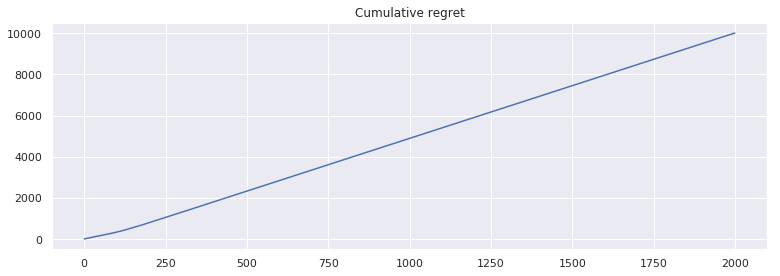

In [14]:
fig, ax = plt.subplots(figsize=(11, 4), nrows=1, ncols=1)

t = np.arange(T)

mean_regrets = np.mean(regrets, axis=0)
std_regrets = np.std(regrets, axis=0) / np.sqrt(regrets.shape[0])
ax.plot(t, mean_regrets)
ax.fill_between(t, mean_regrets - 2*std_regrets, mean_regrets + 2*std_regrets, alpha=0.15)
    
ax.set_title('Cumulative regret')

plt.tight_layout()
plt.show()

fig.savefig('neural_ucb_linear.pdf')

Text(0.5,1,'reward')

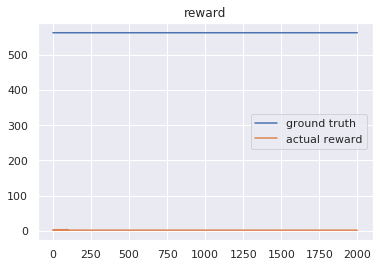

In [15]:
plt.plot([562.7936945431538]*len(model.rewards_list))
plt.plot(model.rewards_list)#([sum(model.rewards_list[:i])/(i+1) for i in range(len(model.rewards_list))][5:])
plt.legend(['ground truth','actual reward'])
plt.title('reward')

Text(0.5,1,'infeasibility')

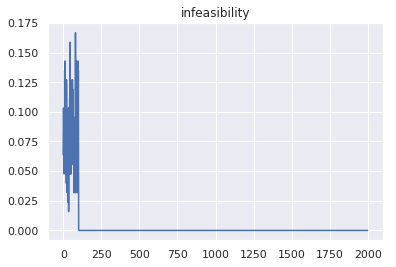

In [16]:
plt.plot(model.feasi)
plt.title('infeasibility')

In [17]:
np.save('reward_mixpolicy_para10_3order24.npy',model.rewards_list)
np.save('constraint_mixpolicy_para10_3order24.npy',model.feasi)

In [18]:
#reward_singleneuralUCB_mixorder24=np.load('reward_singleneuralUCB_3order24.npy')
reward_constrained_rl_mixorder24=np.load('reward_constrained_rl_3order24.npy')
reward_constrained_rl_mixorder24=[i*10/(np.sqrt(10))**3 for i in reward_constrained_rl_mixorder24]
reward_mixpolicy_mixorder24=np.load('reward_mixpolicy_para10_3order24.npy')
#constraint_singleneuralUCB_mixorder24=np.load('constraint_singleneuralUCB_3order24.npy')
constraint_constrained_rl_mixorder24=np.load('constraint_constrained_rl_3order24.npy')
constraint_mixpolicy_mixorder24=np.load('constraint_mixpolicy_para10_3order24.npy')
reward_constrained_rl_mixorder24

[19.60747398103702,
 18.139984723999664,
 18.919107984354277,
 19.389731716614307,
 18.81214041200453,
 18.139984723999664,
 19.213549616503112,
 19.07522250737316,
 18.919107984354277,
 19.389731716614307,
 17.597391186114702,
 18.270596079787182,
 18.159825827166873,
 19.389731716614307,
 19.02594907440478,
 18.543300493979647,
 18.791336130948295,
 18.919107984354277,
 19.389731716614307,
 17.72090150081995,
 19.02594907440478,
 17.745127922001195,
 18.94094441706427,
 18.29292497973263,
 18.44818504252694,
 17.72931198875518,
 18.15192966009183,
 16.870051778432885,
 18.44215223520366,
 16.944508697901146,
 18.854691405826117,
 17.44989876828303,
 18.54053045951759,
 17.34409874717831,
 18.09374455066309,
 17.530568544037017,
 18.038158158820202,
 16.920090178001868,
 18.857787369110344,
 16.710816552973952,
 18.526331094404767,
 17.180444846299142,
 17.404315742545347,
 16.93389723693382,
 16.288604441458528,
 17.35853650189184,
 18.515387641166296,
 17.354669972132992,
 17.082542

In [19]:
np.load('reward_constrained_rl_3order24.npy')

array([62.00427694, 57.36366845, 59.82747253, ..., 67.49089658,
       67.49089658, 67.49089658])

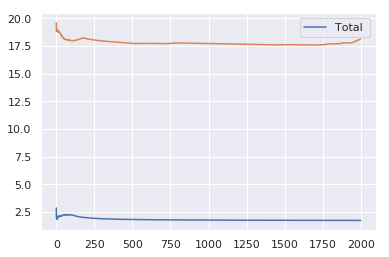

In [20]:
aaa1=[reward_constrained_rl_mixorder24[0]]
for i in range(2000-1):
    aaa1.append((aaa1[-1]*(i+1)+reward_constrained_rl_mixorder24[i+1])/(i+2))
aaa=[reward_mixpolicy_mixorder24[0]]
for i in range(2000-1):
    aaa.append((aaa[-1]*(i+1)+reward_mixpolicy_mixorder24[i+1])/(i+2))
plt.plot(aaa)
plt.plot(aaa1)
plt.legend(['Total '])

In [21]:
aaa1=[constraint_constrained_rl_mixorder24[0]]
for i in range(5000-1):
    aaa1.append((aaa1[-1]*(i+1)+constraint_constrained_rl_mixorder24[i+1])/(i+2))
aaa=[constraint_mixpolicy_mixorder24[0]]
for i in range(4000-1):
    aaa.append((aaa[-1]*(i+1)+constraint_mixpolicy_mixorder24[i+1])/(i+2))
plt.plot(aaa)
plt.plot(aaa1)

IndexError: index 4020 is out of bounds for axis 0 with size 4020

In [ ]:
#plt.plot(reward_singleneuralUCB_mixorder24[:2000])
plt.plot([i for i in reward_constrained_rl_mixorder24][:2000])
plt.plot(reward_mixpolicy_mixorder24[:2000])
plt.plot([1.7206882850862506]*2000)#([562.7936945431538]*2000)
plt.legend(['Constrained_rl','Mixed_policy','Ground_Truth'])#'NeuralUCB',
plt.title('Rewards without Constrained Terms')

In [ ]:
#plt.plot(constraint_singleneuralUCB_mixorder24[:2000])
plt.plot(constraint_constrained_rl_mixorder24[:2000])
plt.plot(constraint_mixpolicy_mixorder24[:2000])
plt.legend(['Constrained_rl','Mixed_policy'])#'NeuralUCB',
plt.title('Constrained Terms')

In [ ]:
hwithoutconstraints(np.array([1,1,0,0,0,0,1,1,1,0,0,0,1,1,0,0,1,0,0,1,0,1,0,1]))/(np.sqrt(10))**3,checkFea(np.array([1,1,0,0,0,0,1,1,1,0,0,0,1,1,0,0,1,0,0,1,0,1,0,1])),sum([1,1,0,0,0,0,1,1,1,0,0,0,1,1,0,0,1,0,0,1,0,1,0,1])

In [ ]:
constraint(np.array([1]*10+[0]*23)*(1/np.sqrt(10))),constraint(np.array([0]*24)*(1/np.sqrt(10)))

In [ ]:
constraint(action*(1/np.sqrt(10))),constraint(action22*(1/np.sqrt(10))),constraint(action2*(1/np.sqrt(10)))

In [ ]:
action22=action.copy()
action22[2]=0

In [ ]:
model.model2(torch.FloatTensor([1]*24).to('cpu')).detach().squeeze()

In [ ]:
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torch.utils.data as Data

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import imageio

torch.manual_seed(1)    # reproducible

x = torch.unsqueeze(torch.linspace(-10, 10, 1000), dim=1)  # x data (tensor), shape=(100, 1)
y = torch.sin(x) + 0.2*torch.rand(x.size())                 # noisy y data (tensor), shape=(100, 1)

# torch can only train on Variable, so convert them to Variable
x, y = Variable(x), Variable(y)
plt.figure(figsize=(10,4))
plt.scatter(x.data.numpy(), y.data.numpy(), color = "blue")
plt.title('Regression Analysis')
plt.xlabel('Independent varible')
plt.ylabel('Dependent varible')
plt.savefig('curve_2.png')
plt.show()

# another way to define a network
net = torch.nn.Sequential(
        torch.nn.Linear(1, 200),
        torch.nn.LeakyReLU(),
        torch.nn.Linear(200, 100),
        torch.nn.LeakyReLU(),
        torch.nn.Linear(100, 1),
    )

optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
loss_func = torch.nn.MSELoss()  # this is for regression mean squared loss

BATCH_SIZE = 64
EPOCH = 200

torch_dataset = Data.TensorDataset(x, y)

loader = Data.DataLoader(
    dataset=torch_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True, num_workers=2,)

my_images = []
fig, ax = plt.subplots(figsize=(16,10))

# start training
for epoch in range(EPOCH):
    for step, (batch_x, batch_y) in enumerate(loader): # for each training step
        
        b_x = Variable(batch_x)
        b_y = Variable(batch_y)

        prediction = net(b_x)     # input x and predict based on x
        print(prediction)
        loss = loss_func(prediction, b_y)     # must be (1. nn output, 2. target)

        optimizer.zero_grad()   # clear gradients for next train
        loss.backward()         # backpropagation, compute gradients
        optimizer.step()        # apply gradients
